In [3]:
#pandas is a library for data manipulation and analysis.
import pandas as pd
#matplotlib is a plotting library and its numerical mathematics extension NumPy;
#matplotlib.pyplot is mainly intended for interactive plots and simple cases of programmatic plot
import matplotlib.pyplot as plt
import numpy as np
#brightway2 is a open source framework for life cycle assessment (LCA). 
import brightway2 as bw
#SciPy contains modules for optimization, linear algebra, integration, interpolation,
#special functions, FFT, signal and image processing, ODE solvers and other tasks.
from scipy.interpolate import InterpolatedUnivariateSpline
#there are a number of pre-defined styles provided by matplotlib: ggplot is one of them.
plt.style.use('ggplot')
#auto is to display the figures in an independant tab;
#it can be changed to inline to represent in the notebook itself
%matplotlib inline

In [4]:
bw.projects.current

'default'

In [ ]:
bw.projects.set_current('B_Publication')
bw.bw2setup()
bw.databases

In [19]:
fpei34 =  r'./ecoinvent 3.4_cutoff_ecoSpold02/datasets'
if 'ecoinvent 3.4 cut off' in bw.databases:
    print("Database has already been imported")
else:
    ei34 = bw.SingleOutputEcospold2Importer(fpei34, 'ecoinvent 3.4 cut off')
    ei34.apply_strategies()
    ei34.statistics()
    ei34.write_database()

Database has already been imported


In [20]:
#this is where the current project is set and the databases are defined
eidb = bw.Database('ecoinvent 3.4 cut off')
bio3 = bw.Database('biosphere3')

In [21]:
#to know the number of items in each databases
#should be 4246 when executed for the first time
len(bio3)

4321

In [22]:
#ecoinvent 3.4 database should be 14889 items at first
len(eidb)

14889

The following model represents a cradle-to-grave parameterized model for the PV systems. It can be divided into 3 parts: 

1 - The first part entitled /Photovoltaic System/:
It is where all the suggested modifications and the set of parameters are created and executed
to change and update the original Ecoinvent 3.4 datasets. 
This part includes numerous subsections: each is related to a certain component or aspect
to finally end up with the last section entitled /final function generating inventories/
which defines the inventory of the system that will be analyzed.
Be careful when executing this part (should be line by line) to avoid duplication and matrix error!

2 - The second part entitled /Impact Analysis/:
It is where all the chosen methods are defined and prepared to calculate the environmental impacts
of the system.
N.B: if the user wants to check the results shown in part 1, he/she should execute part 2 before part 1 in order to get the results in the first part.

3- The third part entitled /PV Production/:
It is where the production of the system is calculated. This part includes all the operational and geographical parameters such as the irradiation, the performance ratio, the degradation rate, etc.

The others sections analyze different scenarios and simulations. 

As a recap, it must be noted that the purpose of this project is to conduct a Life Cycle Assessment (LCA) study of energy systems. In particular, the PV systems were modeled as an example on which to be based other applications and sectors.

The LCA stages include the raw material extraction, the manufactuing and assembly, the use, and the end-of-life including the transportation all the way. The list of parameters which were defined and modeled contribute to each of these stages.
The user will explore them gradually throughout the model and they are listed in the following paragraph.

########################################## Print #################################################

These 2 functions are created to display the datasets clearly

In [23]:
############################## PRINT ###########################
#it displays the datasets in a dataframe (similarly to Simapro)
def print_data(act):
    print(act)
    df = pd.DataFrame(index = ['amount','unit','key'])
    for exc in act.exchanges():
        if exc['name'] in df.columns:
            df[exc['name']].loc['amount'] += exc.amount
        else:
            df[exc['name']] = [exc.amount, exc.unit, exc.input.key]
    return df.T

In [1]:
def print_data2(act) :
    df = pd.DataFrame(index = ['amount','unit','key','type'])
    for (i,exc) in enumerate(act.exchanges()):
        df[str(bw.get_activity(exc.input.key))] = [exc.amount, exc.unit, exc.input.key,exc['type']]
    return df.T

# Part_1: Photovoltaic System

In this part, all the modifications are adopted according to the latest technological advancements and recommendations.
To ensure flexibility and consistency, the created functions are monitored by a set of input variables. These variables englobe both the technological and geographical parameters. It must be noted that the last 4 parameters are used in Part_3 of this notebook. The 30 paramaters can be listed as follows (the definition of each will be developed in the subsections):
- P
- P_module
  or module_efficiency
- roof
- share_recycled_aluminium
- elec_dataset
- inverter_weight
- inverter_lifetime
- PV_lifetime
- glass_thickness
- manufacturing_efficiency_gains
- kerf_loss
- wafer_thickness 
- silver_amount 
- Silicon_electricity_intensity
- d_lorry
- d_train
- d_sea
- recycling_rate
- electricity_recycling
- heat_recycling
- SiC_recycled_share
- TEG_recycled_share
- DW
- recycling_rate_alu
- recycling_rate_cu
- recycling_rate_gl
- irradiation
- PR
- degradation_rate
- orientation

All these parameters have a set default value defined in the following functions. 
These default values serve as an estimation for typical cases when there is lack of data / no knowledge.

## Electricity dataset

Because the case study is set in a European context, this parameter allow to unify the dataset used for some components/processes, if needed. Otherwise the user can stick to the one defined in Ecoinvent 3.4 database. 5 electricity mix choices were proposed as follows:

In [25]:
elec_dataset_us = [act for act in eidb if 'market group for electricity, medium voltage' == act['name'] and 'US' in act['location']][0]
elec_dataset_us

'market group for electricity, medium voltage' (kilowatt hour, US, None)

In [26]:
elec_dataset_eu = [act for act in eidb if 'market group for electricity, medium voltage' == act['name'] and 'ENTSO-E' == act['location']][0]
elec_dataset_eu

'market group for electricity, medium voltage' (kilowatt hour, ENTSO-E, None)

In [27]:
elec_dataset_row = [act for act in eidb if 'market for electricity, medium voltage' == act['name'] and 'RoW' in act['location']][0]
elec_dataset_row

'market for electricity, medium voltage' (kilowatt hour, RoW, None)

In [28]:
elec_dataset_cn = [act for act in eidb if 'market for electricity, medium voltage' == act['name'] and 'CN-CSG' in act['location']][0]
elec_dataset_cn

'market for electricity, medium voltage' (kilowatt hour, CN-CSG, None)

In [29]:
elec_dataset_fr = [act for act in eidb if 'market for electricity, medium voltage' == act['name'] and 'FR' == act['location']][0]
elec_dataset_fr

'market for electricity, medium voltage' (kilowatt hour, FR, None)

For a rest of the world study, use RoW dataset

In [30]:
elec_dataset = elec_dataset_row

In [31]:
#ATTENTION: In order to execute this cell, the first 2 cells of Part_2 should be executed
bw.calculation_setups['B_electricity_mix'] = {'inv': [{elec_dataset_us:1}, {elec_dataset_eu:1}, {elec_dataset_row:1}, {elec_dataset_cn:1}, {elec_dataset_fr:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_electricity_mix')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

NameError: name 'list_methods' is not defined

## Aluminium dataset

The aluminium dataset used for the mounting system and the PV panel frame is adjusted to account for the latest market practices of which the use of secondary/recycled aluminium has an important impact. The user has the flexibility to adjust the share of secondary aluminium according to his/her system.

In [17]:
#the original dataset is the one presented below
alu_original = [act for act in eidb if 'aluminium alloy production, AlMg3' == act['name']and 'RER' in act['location']][0]
alu_original

'aluminium alloy production, AlMg3' (kilogram, RER, None)

In [53]:
def generate_aluminium_alloy_dataset(share_recycled_aluminium = 0.27,
                                     elec_dataset = None):
    '''
    This function generates a dataset for aluminium alloy that will be used for mounting system and PV panel frame.
    The electricity and the amount of recycled aluminium can be adjusted using 
    the share_recycled_aluminium (expressed as a fraction/percentage) 
    and elec_dataset(representing a dataset) respectively.
    '''
    initial_dataset = 'aluminium alloy production, AlMg3'
    alu_adjusted = [act for act in eidb if 'aluminium alloy production, AlMg3 adjusted' == act['name']]
    
    if alu_adjusted == []:
        alu = [act for act in eidb if 'aluminium alloy production, AlMg3' in act['name']and 'RER' in act['location']][0]
        alu_adjusted = alu.copy()
        alu_adjusted['name'] = initial_dataset + ' adjusted'
        alu_adjusted['authors'] = 'Romain Besseau'
        alu_adjusted['comment'] = 'Dataset adjusted with the share of secondary aluminium used and the electricity mix used'
        
        #Adding secondary aluminium
        aluminium_scrap = [act for act in eidb if 'aluminium scrap, new, Recycled Content cut-off' in act['name']][0]

        new_exc = alu_adjusted.new_exchange(input = aluminium_scrap.key, name = aluminium_scrap['name'], 
                                            amount = 0, unit = 'kg', categories = '', type = 'technosphere')
        new_exc.save()
        
        for exc in alu_adjusted.exchanges():
            exc['output'] = alu_adjusted.key
            exc.save()
        
        alu_adjusted.save()        
        
    else:
        alu = [act for act in eidb if initial_dataset == act['name']][0]
        alu_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name']][0]
        
    # Amount of aluminium considered
    for exc in alu.exchanges():
        if exc['name'] == 'aluminium, cast alloy':
            aluminium_amount = exc.amount
            
    is_elec_ds = (elec_dataset != None)
    
    #Adjusting the amount of primary and secondary aluminium
    for exc in alu_adjusted.exchanges():
        if exc['name'] == 'aluminium, cast alloy':
            exc['amount'] = aluminium_amount * (1 - share_recycled_aluminium)
            exc.save()
        if exc['name'] == 'aluminium scrap, new, Recycled Content cut-off':
            exc['amount'] = aluminium_amount * (share_recycled_aluminium)
            exc.save()
        #Adjusting the electricity used for manufacturing
        if is_elec_ds:
            if exc['name'] == 'electricity, high voltage, aluminium industry':
                exc['input'] = elec_dataset.key
                exc.save()
        
    #alu_adjusted.save() 
                
    return alu_adjusted

In [30]:
alu_adjusted = generate_aluminium_alloy_dataset(share_recycled_aluminium = 0.3,
                                     elec_dataset = None)

In [54]:
alu_adjusted = [act for act in eidb if 'aluminium alloy production, AlMg3 adjusted' in act['name']][0]
alu_adjusted

'aluminium alloy production, AlMg3 adjusted' (kilogram, RER, None)

In [32]:
DF = pd.concat([print_data(alu_original),print_data(alu_adjusted)], axis = 1, keys = ['original', 'adjusted'])
DF

'aluminium alloy production, AlMg3' (kilogram, RER, None)
'aluminium alloy production, AlMg3 adjusted' (kilogram, RER, None)


C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


original                 \
                                                 amount           unit   
aluminium alloy, AlMg3                                1       kilogram   
aluminium scrap, new, Recycled Content cut-off      NaN            NaN   
aluminium, cast alloy                             0.965       kilogram   
cast iron                                       0.00406       kilogram   
chromium                                        0.00305       kilogram   
copper                                          0.00102       kilogram   
electricity, high voltage, aluminium industry      1.59  kilowatt hour   
magnesium                                        0.0305       kilogram   
manganese                                       0.00508       kilogram   
silicon, metallurgical grade                    0.00406       kilogram   
zinc                                            0.00203       kilogram   

                                                                                                   \
                                                                                              key   
aluminium alloy, AlMg3                          (ecoinvent 3.4 cut off, 55dfefb1b8d96e368f2493...   
aluminium scrap, new, Recycled Content cut-off                                                NaN   
aluminium, cast alloy                           (ecoinvent 3.4 cut off, bb3477bde0c4f3663411a7...   
cast iron                                       (ecoinvent 3.4 cut off, 0e718dd998cd3c6ca2aac0...   
chromium                                        (ecoinvent 3.4 cut off, 3ecd7cb07efe822b692dd3...   
copper                                          (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...   
electricity, high voltage, aluminium industry   (ecoinvent 3.4 cut off, e45c6da9a7c4e6b5d4bef9...   
magnesium                                       (ecoinvent 3.4 cut off, cab8a25e39b619b55b0d11...   
manganese                                       (ecoinvent 3.4 cut off, a5ac0e818e17156882d192...   
silicon, metallurgical grade                    (ecoinvent 3.4 cut off, 3188d23f89079fe1ac63e4...   
zinc                                            (ecoinvent 3.4 cut off, 002ebeb1ca3506ef21cf04...   

                                               adjusted                 \
                                                 amount           unit   
aluminium alloy, AlMg3                                1       kilogram   
aluminium scrap, new, Recycled Content cut-off   0.2895       kilogram   
aluminium, cast alloy                            0.6755       kilogram   
cast iron                                       0.00406       kilogram   
chromium                                        0.00305       kilogram   
copper                                          0.00102       kilogram   
electricity, high voltage, aluminium industry      1.59  kilowatt hour   
magnesium                                        0.0305       kilogram   
manganese                                       0.00508       kilogram   
silicon, metallurgical grade                    0.00406       kilogram   
zinc                                            0.00203       kilogram   

                                                                                                   
                                                                                              key  
aluminium alloy, AlMg3                          (ecoinvent 3.4 cut off, 2b6143b1ee1c474aa8cd43...  
aluminium scrap, new, Recycled Content cut-off  (ecoinvent 3.4 cut off, 4af142704238ac38488c57...  
aluminium, cast alloy                           (ecoinvent 3.4 cut off, bb3477bde0c4f3663411a7...  
cast iron                                       (ecoinvent 3.4 cut off, 0e718dd998cd3c6ca2aac0...  
chromium                                        (ecoinvent 3.4 cut off, 3ecd7cb07efe822b692dd3...  
copper                                          (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...  
electri

In [33]:
#ATTENTION: In order to execute this cell, the first 2 cells of Part_2 should be executed
bw.calculation_setups['B_aluminium_dataset'] = {'inv': [{alu_original:1}, {alu_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_aluminium_dataset')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                           5.731382            
1                                           4.441280            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.035596                                               
1                                           0.027031                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                           5.890408                             
1                                           4.576014                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.000352                                
1                                           0.000283                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000001                         
1                                           0.000001                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.004777                            
1                                           0.003659                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.054339                                 
1                                           0.041636                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       2.961301e-07                      
1                                       2.436422e-07                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.144029                    
1                                           0.127726                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000002                          
1                                           0.000002                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       2.358739e-07                       
1                                       1.920160e-07                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.016481                              
1                                           0.013006                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.007688                                 
1                                           0.006464                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                           4.544623       
1                                           3.428981       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.010063                             
1                                           0.007192

In [34]:
(5.73-4.44)/5.73*100

22.5130890052356

A share of secondary aluminium has been introduced. Secondary aluminium is much less energy intensive than the primary aluminium.

## Mounting system

The mounting structure can vary from one application to another: integrated to the building, concentrated systems, etc. Hence, the mounting systems were analyzed and compared in this section. The corresponding datasets include the integration of the adjusted aluminium as well.

In [55]:
# 2 Mounting system are identified (Aluminium and stainless steel based)
ground_system = [act for act in eidb if 'photovoltaic mounting system production, for 570kWp open ground module' == act['name']][0]
print(ground_system)
roof_system = [act for act in eidb if 'photovoltaic mounting system production, for slanted-roof installation' == act['name'] and 'RER' in act['location']][0]
print(roof_system)

'photovoltaic mounting system production, for 570kWp open ground module' (square meter, GLO, None)
'photovoltaic mounting system production, for slanted-roof installation' (square meter, RER, None)


In [36]:
# To check the difference between the roof-integrated and ground-mounted systems:
bw.calculation_setups['B_mounting_system'] = {'inv': [{ground_system:1}, {roof_system:1}], 'ia': list_methods}
#bw.calculation_setups[act['name']]
myMultiLCA = bw.MultiLCA('B_mounting_system')
myMultiLCA.results
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         100.541175            
1                                          60.583641            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.675833                                               
1                                           0.393257                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                         107.279509                             
1                                          51.147342                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.005168                                
1                                           0.002824                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000012                         
1                                           0.000007                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.086233                            
1                                           0.050337                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           1.128997                                 
1                                           0.567595                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000007                      
1                                           0.000004                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           1.517843                    
1                                           0.873493                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000027                          
1                                           0.000011                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000004                       
1                                           0.000002                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.285578                              
1                                           0.158862                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.099554                                 
1                                           0.059309                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                       36353.442394       
1                                          39.063878       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.058523                             
1                                           0.000975

In [37]:
(100.54-60.58)/100.54*100

39.745374975134276

In [56]:
#To ensure a uniform analysis, recycling should be added to the roof system like it was done for the ground system
#Let's start by adding recycling to the photovoltaic mounting system production, for slanted-roof installation
roof_system_with_recycling = [act for act in eidb if 'photovoltaic mounting system production, for slanted-roof installation with recycling' == act['name']]

if roof_system_with_recycling == []:
    roof_system =  [act for act in eidb if 'photovoltaic mounting system production, for slanted-roof installation' == act['name'] and 'RER' in act['location']][0]
    roof_system_with_recycling = roof_system.copy()
    roof_system_with_recycling['name'] = 'photovoltaic mounting system production, for slanted-roof installation with recycling'
    roof_system_with_recycling['authors'] = 'Romain Besseau'
    roof_system_with_recycling['comment'] = 'Copy of photovoltaic mounting system production, for slanted-roof installation with recycling activites added (scrap steel and scrap aluminium)'
    
    for exc in roof_system_with_recycling.exchanges():
        if exc['name'] == 'aluminium, wrought alloy':
            aluminium_amout = exc.amount
            scrap_aluminium = [act for act in eidb if 'market for scrap aluminium' in act['name'] and 'Europe' in act['location']][0]  
        
            new_exc = roof_system_with_recycling.new_exchange(input = scrap_aluminium.key, name = scrap_aluminium['name'], amount =  - aluminium_amout, unit = scrap_aluminium['unit'], type = 'technosphere')
            new_exc.save()
        
        if exc['name'] == 'steel, low-alloyed, hot rolled':
            steel_amout = exc.amount
            scrap_steel = [act for act in eidb if 'market for scrap steel' in act['name'] and 'Europe' in act['location']][0]  
        
            new_exc = roof_system_with_recycling.new_exchange(input = scrap_steel.key, name = scrap_steel['name'], amount =  - steel_amout, unit = scrap_steel['unit'], type = 'technosphere')
            new_exc.save()
        
    roof_system_with_recycling.save()

roof_system_with_recycling = [act for act in eidb if 'photovoltaic mounting system production, for slanted-roof installation with recycling' == act['name']][0]
roof_system_with_recycling

'photovoltaic mounting system production, for slanted-roof installation with recycling' (square meter, RER, None)

In [57]:
roof_system_with_recycling = [act for act in eidb if 'photovoltaic mounting system production, for slanted-roof installation with recycling' == act['name']][0]
roof_system_with_recycling

'photovoltaic mounting system production, for slanted-roof installation with recycling' (square meter, RER, None)

In [40]:
print_data(roof_system_with_recycling)

'photovoltaic mounting system production, for slanted-roof installation with recycling' (square meter, RER, None)


amount          unit  \
photovoltaic mounting system, for slanted-roof ...          1  square meter   
polyethylene, high density, granulate               0.0014033      kilogram   
sheet rolling, steel                                   1.4999      kilogram   
steel, low-alloyed, hot rolled                         1.4999      kilogram   
corrugated board box                                  0.13332      kilogram   
aluminium, wrought alloy                               2.8355      kilogram   
polystyrene, high impact                            0.0070167      kilogram   
section bar extrusion, aluminium                       3.0312      kilogram   
waste polyethylene/polypropylene product           -0.0014033      kilogram   
waste polystyrene isolation, flame-retardant       -0.0070167      kilogram   
waste paperboard                                     -0.13332      kilogram   
market for scrap steel                                -1.4999      kilogram   
market for scrap aluminium                            -2.8355      kilogram   

                                                                                                  key  
photovoltaic mounting system, for slanted-roof ...  (ecoinvent 3.4 cut off, d146218f294c45c4a6d22b...  
polyethylene, high density, granulate               (ecoinvent 3.4 cut off, c6d5b7ed36ef2c2d392473...  
sheet rolling, steel                                (ecoinvent 3.4 cut off, 8a128c621f9c7baa4b1829...  
steel, low-alloyed, hot rolled                      (ecoinvent 3.4 cut off, 1e200a3049db914305193e...  
corrugated board box                                (ecoinvent 3.4 cut off, 04d83c7892991a382a8177...  
aluminium, wrought alloy                            (ecoinvent 3.4 cut off, d7b2398f8a10f8a4f80978...  
polystyrene, high impact                            (ecoinvent 3.4 cut off, 6b34f1cda0bf360140a979...  
section bar extrusion, aluminium                    (ecoinvent 3.4 cut off, c088aea59da4f1e655819f...  
waste polyethylene/polypropylene product            (ecoinvent 3.4 cut off, 94c880cbfe70128d2418a4...  
waste polystyrene isolation, flame-retardant        (ecoinvent 3.4 cut off, a6585db7b1c872689bfaca...  
waste paperboard                                    (ecoinvent 3.4 cut off, 3eeb929c4385e7e3211d68...  
market for scrap steel                              (ecoinvent 3.4 cut off, ba4f24b823d8fcbc7293bf...  
market for scrap aluminium                          (ecoinvent 3.4 cut off, 08725eb3b389ca115cadfa...

In [41]:
list_methods = methods_no_LT
bw.calculation_setups['B_ground_mounting_systems'] = {'inv': [{roof_system:1},{roof_system_with_recycling:1}], 'ia': list_methods}
#bw.calculation_setups[act['name']]
myMultiLCA = bw.MultiLCA('B_ground_mounting_systems')
B_df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
B_df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                          60.583641            
1                                          60.645474            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.393257                                               
1                                           0.393683                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                          51.147342                             
1                                          51.241922                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.002824                                
1                                           0.002826                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000007                         
1                                           0.000007                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.050337                            
1                                           0.050471                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.567595                                 
1                                           0.569084                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000004                      
1                                           0.000004                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.873493                    
1                                           0.878121                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000011                          
1                                           0.000011                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000002                       
1                                           0.000002                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.158862                              
1                                           0.159296                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.059309                                 
1                                           0.059415                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                          39.063878       
1                                          39.729307       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.000975                             
1                                           0.000977

In [58]:
def generate_mounting_system_dataset(aluminium_dataset = alu_adjusted, 
                                     initial_dataset = 'photovoltaic mounting system production, for slanted-roof installation with recycling'):
    '''
    This function generates an inventorie for 1 m² of mounting system either open ground or roof installed.
    The aluminium alloy adjusted dataset is used and the recycling rate can be adjusted.
    '''
    system_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name']]
    
    if system_adjusted == []: 
        system = [act for act in eidb if initial_dataset == act['name'] ][0]
        system_adjusted = system.copy()
        system_adjusted['name'] = initial_dataset + ' adjusted'
        system_adjusted['authors'] = 'Romain Besseau'
        system_adjusted['comment'] = 'Dataset adjusted with the share of secondary aluminium used and the recycling rate'
        
        #Changing the aluminium dataset to the adjusted one.
        for exc in system_adjusted.exchanges():
            if exc['name'] == 'aluminium, wrought alloy':
                exc['name'] = aluminium_dataset['name']
                exc['input'] = aluminium_dataset.key
                exc.save()           
        
        for exc in system_adjusted.exchanges():
            exc['output'] = system_adjusted.key
            exc.save()
        
        system_adjusted.save()        
        
    else:
        #system = [act for act in eidb if initial_dataset == act['name'] and 'RER' in act['location']][0]
        system_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name']][0]
            
    return system_adjusted

In [43]:
roof_system_adjusted = generate_mounting_system_dataset(aluminium_dataset = alu_adjusted, 
                                     initial_dataset = 'photovoltaic mounting system production, for slanted-roof installation with recycling')
ground_system_adjusted = generate_mounting_system_dataset(aluminium_dataset = alu_adjusted, 
                                     initial_dataset = 'photovoltaic mounting system production, for 570kWp open ground module')

In [27]:
roof_system_adjusted = [act for act in eidb if 'photovoltaic mounting system production, for slanted-roof installation with recycling adjusted' in act['name']][0]
print_data2(roof_system_adjusted)

amount          unit  \
'photovoltaic mounting system production, for s...            1  square meter   
'market for polyethylene, high density, granula...    0.0014033      kilogram   
'market for sheet rolling, steel' (kilogram, GL...       1.4999      kilogram   
'market for steel, low-alloyed, hot rolled' (ki...       1.4999      kilogram   
'market for corrugated board box' (kilogram, GL...      0.13332      kilogram   
'aluminium alloy production, AlMg3 adjusted' (k...       2.8355      kilogram   
'market for polystyrene, high impact' (kilogram...    0.0070167      kilogram   
'market for section bar extrusion, aluminium' (...       3.0312      kilogram   
'market for waste polyethylene/polypropylene pr...  -0.00136242      kilogram   
'market for waste polyethylene/polypropylene pr... -4.08826e-05      kilogram   
'market for waste polystyrene isolation, flame-...  -0.00681228      kilogram   
'market for waste polystyrene isolation, flame-... -0.000204419      kilogram   
'market for waste paperboard' (kilogram, Europe...    -0.131438      kilogram   
'market for waste paperboard' (kilogram, CH, None)  -0.00188219      kilogram   
'market for scrap steel' (kilogram, Europe with...      -1.4999      kilogram   
'market for scrap aluminium' (kilogram, Europe ...      -2.8355      kilogram   

                                                                                                  key  \
'photovoltaic mounting system production, for s...  (ecoinvent 3.4 cut off, cb03e43e67444dbf8d2eb6...   
'market for polyethylene, high density, granula...  (ecoinvent 3.4 cut off, c6d5b7ed36ef2c2d392473...   
'market for sheet rolling, steel' (kilogram, GL...  (ecoinvent 3.4 cut off, 8a128c621f9c7baa4b1829...   
'market for steel, low-alloyed, hot rolled' (ki...  (ecoinvent 3.4 cut off, 1e200a3049db914305193e...   
'market for corrugated board box' (kilogram, GL...  (ecoinvent 3.4 cut off, 04d83c7892991a382a8177...   
'aluminium alloy production, AlMg3 adjusted' (k...  (ecoinvent 3.4 cut off, 2b6143b1ee1c474aa8cd43...   
'market for polystyrene, high impact' (kilogram...  (ecoinvent 3.4 cut off, 6b34f1cda0bf360140a979...   
'market for section bar extrusion, aluminium' (...  (ecoinvent 3.4 cut off, c088aea59da4f1e655819f...   
'market for waste polyethylene/polypropylene pr...  (ecoinvent 3.4 cut off, 94c880cbfe70128d2418a4...   
'market for waste polyethylene/polypropylene pr...  (ecoinvent 3.4 cut off, e67ad642f8003c221ab790...   
'market for waste polystyrene isolation, flame-...  (ecoinvent 3.4 cut off, a6585db7b1c872689bfaca...   
'market for waste polystyrene isolation, flame-...  (ecoinvent 3.4 cut off, 1a20b29c72a183915bbcae...   
'market for waste paperboard' (kilogram, Europe...  (ecoinvent 3.4 cut off, 3eeb929c4385e7e3211d68...   
'market for waste paperboard' (kilogram, CH, None)  (ecoinvent 3.4 cut off, 64387aec305e3942e9e5a0...   
'market for scrap steel' (kilogram, Europe with...  (ecoinvent 3.4 cut off, ba4f24b823d8fcbc7293bf...   
'market for scrap aluminium' (kilogram, Europe ...  (ecoinvent 3.4 cut off, 08725eb3b389ca115cadfa...   

                                                            type  
'photovoltaic mounting system production, for s...    production  
'market for polyethylene, high density, granula...  technosphere  
'market for sheet rolling, steel' (kilogram, GL...  technosphere  
'market for steel, low-alloyed, hot rolled' (ki...  technosphere  
'market for corrugated board box' (kilogram, GL...  technosphere  
'aluminium alloy production, AlMg3 adjusted' (k...  technosphere  
'market for polystyrene, high impact' (kilogram...  technosphere  
'market for section bar extrusion, aluminium' (...  technosphere  
'market for waste polyethylene/polypropylene pr...  technosphere  
'market for waste polyethylene/polypropylene pr...  technosphere  
'market for waste polystyrene isolation, flame-...  technosphere  
'market for waste polystyrene isolation, flame-...  technosphere  
'market for waste pape

In [28]:
ground_system_adjusted = [act for act in eidb if 'photovoltaic mounting system production, for 570kWp open ground module adjusted' in act['name']][0]
print_data2(ground_system_adjusted)

amount  \
'aluminium alloy production, AlMg3 adjusted' (k...         3.98   
'market for polystyrene, high impact' (kilogram...    0.0045455   
'market for reinforcing steel' (kilogram, GLO, ...         7.25   
'market for zinc coat, coils' (square meter, GL...         0.11   
'market for steel, chromium steel 18/8, hot rol...         0.25   
'photovoltaic mounting system production, for 5...            1   
'market for polyethylene, high density, granula...   0.00090909   
'market for section bar rolling, steel' (kilogr...         6.15   
'market for corrugated board box' (kilogram, GL...     0.086364   
'market for wire drawing, steel' (kilogram, GLO...          1.1   
'market for zinc coat, pieces' (square meter, G...        0.156   
'market for section bar extrusion, aluminium' (...         3.98   
'market for waste polystyrene isolation, flame-...  -0.00127498   
'market for waste polystyrene isolation, flame-...  -3.8259e-05   
'market for waste polystyrene isolation, flame-...  -0.00323226   
'market for scrap steel' (kilogram, Europe with...     -2.42501   
'market for scrap steel' (kilogram, CH, None)       -0.00306581   
'market for scrap steel' (kilogram, RoW, None)         -5.07193   
'market for waste paperboard' (kilogram, Europe...   -0.0255953   
'market for waste paperboard' (kilogram, CH, None) -0.000366524   
'market for waste paperboard' (kilogram, RoW, N...   -0.0604022   
'market for concrete, normal' (cubic meter, CH,...  1.04537e-06   
'market for concrete, normal' (cubic meter, RoW...  0.000540621   
'market for scrap aluminium' (kilogram, Europe ...     -1.26249   
'market for scrap aluminium' (kilogram, CH, None)     -0.059233   
'market for scrap aluminium' (kilogram, RoW, None)     -2.65828   
'market for waste reinforced concrete' (kilogra...    -0.559469   
'market for waste reinforced concrete' (kilogra...    -0.005928   
'market for waste reinforced concrete' (kilogra...      -7.9846   
'market for waste polyethylene/polypropylene pr... -0.000254994   
'market for waste polyethylene/polypropylene pr... -7.65171e-06   
'market for waste polyethylene/polypropylene pr... -0.000646444   
'Transformation, to industrial area' (square me...          4.7   
'Transformation, from pasture, man made' (squar...          4.7   
'Occupation, industrial area' (square meter-yea...          141   

                                                                 unit  \
'aluminium alloy production, AlMg3 adjusted' (k...           kilogram   
'market for polystyrene, high impact' (kilogram...           kilogram   
'market for reinforcing steel' (kilogram, GLO, ...           kilogram   
'market for zinc coat, coils' (square meter, GL...       square meter   
'market for steel, chromium steel 18/8, hot rol...           kilogram   
'photovoltaic mounting system production, for 5...       square meter   
'market for polyethylene, high density, granula...           kilogram   
'market for section bar rolling, steel' (kilogr...           kilogram   
'market for corrugated board box' (kilogram, GL...           kilogram   
'market for wire drawing, steel' (kilogram, GLO...           kilogram   
'market for zinc coat, pieces' (square meter, G...       square meter   
'market for section bar extrusion, aluminium' (...           kilogram   
'market for waste polystyrene isolation, flame-...           kilogram   
'market for waste polystyrene isolation, flame-...           kilogram   
'market for waste polystyrene isolation, flame-...           kilogram   
'market for scrap steel' (kilogram, Europe with...           kilogram   
'market for scrap steel' (kilogram, CH, None)                kilogram   
'market for scrap steel' (kilogram, RoW, None)               kilogram   
'market for waste paperboard' (kilogram, Europe...           kilogram   
'market for waste paperboard' (kilogram, CH, None)           kilogram   
'market for waste paperboard' (kilogram, RoW, N...           kilogram   
'market for concrete, normal' (cubic m

In [46]:
list_methods = methods_no_LT
bw.calculation_setups['B_roof_mounting_systems'] = {'inv': [{roof_system_adjusted:1},{ground_system_adjusted:1}], 'ia': list_methods}
#bw.calculation_setups[act['name']]
myMultiLCA = bw.MultiLCA('B_roof_mounting_systems')
B_df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
B_df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                          19.712203            
1                                          43.085905            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.115227                                               
1                                           0.284984                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                          26.658402                             
1                                          72.773281                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.001707                                
1                                           0.003597                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000006                         
1                                           0.000010                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.016325                            
1                                           0.038305                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.191949                                 
1                                           0.599638                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000002                      
1                                           0.000004                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.681982                    
1                                           1.242536                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000007                          
1                                           0.000022                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000001                       
1                                           0.000002                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.058812                              
1                                           0.144535                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.024382                                 
1                                           0.050380                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                          18.562692       
1                                       36323.732244       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.020604                             
1                                           0.086072

After unifying the datasets and adding the adjusted aluminium for both, it can be seen that the roof_system (represented by the index 0) has less environmental impacts that the ground_system (represented by the index 1).

## Electrical installation

The datasets of the electrical installation (which represents the cables, fuse box, etc.) were compared in order to simplify the modeling of the system. The results show that one dataset can be used and interpolated according to the considered systems.

In [59]:
#all the electrical installation datasets are represented below
act = [act for act in eidb if 'photovoltaics, electric installation' in act['name']]
act

['photovoltaics, electric installation for 3kWp module, at building' (unit, CH, None),
 'market for photovoltaics, electric installation for 570kWp module, open ground' (unit, GLO, None),
 'photovoltaics, electric installation for 3kWp module, at building' (unit, RoW, None),
 'photovoltaics, electric installation for 570kWp module, open ground' (unit, GLO, None),
 'market for photovoltaics, electric installation for 3kWp module, at building' (unit, GLO, None)]

In [60]:
#Electric installation (cables, fuse box, lightning protection...) without the inverter
electrical_installation_3kW = [act for act in eidb if 'photovoltaics, electric installation for 3kWp module, at building' == act['name'] and 'RoW' in act['location']][0]
print(electrical_installation_3kW)
electrical_installation_570kW = [act for act in eidb if 'photovoltaics, electric installation for 570kWp module, open ground' == act['name']][0]
print(electrical_installation_570kW)

'photovoltaics, electric installation for 3kWp module, at building' (unit, RoW, None)
'photovoltaics, electric installation for 570kWp module, open ground' (unit, GLO, None)


In [50]:
#Creating a dataframe for input-output flow
df_ei3kW = print_data(electrical_installation_3kW)
df_ei3kW

'photovoltaics, electric installation for 3kWp module, at building' (unit, RoW, None)


amount      unit  \
brass                                                0.02  kilogram   
photovoltaic plant, electric installation for 3...      1      unit   
zinc                                                 0.04  kilogram   
waste electric wiring                              -29.34  kilogram   
epoxy resin, liquid                                 0.002  kilogram   
polycarbonate                                         0.2  kilogram   
polyethylene, high density, granulate               14.41  kilogram   
polyvinylchloride, bulk polymerised                  2.13  kilogram   
steel, low-alloyed, hot rolled                       0.86  kilogram   
copper                                               14.7  kilogram   
wire drawing, copper                                 14.7  kilogram   
nylon 6                                              0.23  kilogram   
waste polyethylene/polypropylene product           -0.202  kilogram   
scrap copper                                        -0.02  kilogram   
waste polyvinylchloride                             -2.13  kilogram   
scrap steel                                          -0.9  kilogram   

                                                                                                  key  
brass                                               (ecoinvent 3.4 cut off, 6e643b7d9f46dc255b8c85...  
photovoltaic plant, electric installation for 3...  (ecoinvent 3.4 cut off, 98784b0d82cfdf6f367229...  
zinc                                                (ecoinvent 3.4 cut off, 002ebeb1ca3506ef21cf04...  
waste electric wiring                               (ecoinvent 3.4 cut off, 90e723d96fb03c5c34be08...  
epoxy resin, liquid                                 (ecoinvent 3.4 cut off, b88fe2ebe8d73a8783b1b1...  
polycarbonate                                       (ecoinvent 3.4 cut off, 285a2c7b1dc4303135405c...  
polyethylene, high density, granulate               (ecoinvent 3.4 cut off, c6d5b7ed36ef2c2d392473...  
polyvinylchloride, bulk polymerised                 (ecoinvent 3.4 cut off, 80c733a42592703c5cb2d5...  
steel, low-alloyed, hot rolled                      (ecoinvent 3.4 cut off, 1e200a3049db914305193e...  
copper                                              (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...  
wire drawing, copper                                (ecoinvent 3.4 cut off, c38aa059b7d23ec512f2f0...  
nylon 6                                             (ecoinvent 3.4 cut off, f23b57e0a408c904d11f7f...  
waste polyethylene/polypropylene product            (ecoinvent 3.4 cut off, 94c880cbfe70128d2418a4...  
scrap copper                                        (ecoinvent 3.4 cut off, 5ba869bc75f3637aa42ab5...  
waste polyvinylchloride                             (ecoinvent 3.4 cut off, fab73489702637b9c40b4d...  
scrap steel                                         (ecoinvent 3.4 cut off, ba4f24b823d8fcbc7293bf...

In [51]:
#Creating a dataframe for input-output flow
df_ei570kW = print_data(electrical_installation_570kW)
df_ei570kW 

'photovoltaics, electric installation for 570kWp module, open ground' (unit, GLO, None)


amount      unit  \
polyvinylchloride, bulk polymerised                  44.947  kilogram   
waste electric wiring                              -1465.11  kilogram   
photovoltaic plant, electric installation for 5...        1      unit   
polyethylene, high density, granulate                 708.7  kilogram   
wire drawing, copper                                 740.72  kilogram   
zinc                                                 2.7285  kilogram   
copper                                               740.72  kilogram   
epoxy resin, liquid                                 0.13643  kilogram   
nylon 6                                              15.689  kilogram   
polycarbonate                                       0.13643  kilogram   
steel, low-alloyed, hot rolled                       52.884  kilogram   
brass                                                1.3643  kilogram   
waste polyvinylchloride                             -44.947  kilogram   
waste polyethylene/polypropylene product           -0.27286  kilogram   
scrap copper                                        -1.3643  kilogram   
scrap steel                                        -55.6125  kilogram   

                                                                                                  key  
polyvinylchloride, bulk polymerised                 (ecoinvent 3.4 cut off, 80c733a42592703c5cb2d5...  
waste electric wiring                               (ecoinvent 3.4 cut off, 90e723d96fb03c5c34be08...  
photovoltaic plant, electric installation for 5...  (ecoinvent 3.4 cut off, b4661224886edb0161ba15...  
polyethylene, high density, granulate               (ecoinvent 3.4 cut off, c6d5b7ed36ef2c2d392473...  
wire drawing, copper                                (ecoinvent 3.4 cut off, c38aa059b7d23ec512f2f0...  
zinc                                                (ecoinvent 3.4 cut off, 002ebeb1ca3506ef21cf04...  
copper                                              (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...  
epoxy resin, liquid                                 (ecoinvent 3.4 cut off, b88fe2ebe8d73a8783b1b1...  
nylon 6                                             (ecoinvent 3.4 cut off, f23b57e0a408c904d11f7f...  
polycarbonate                                       (ecoinvent 3.4 cut off, 285a2c7b1dc4303135405c...  
steel, low-alloyed, hot rolled                      (ecoinvent 3.4 cut off, 1e200a3049db914305193e...  
brass                                               (ecoinvent 3.4 cut off, 08b71f6097cb492392f237...  
waste polyvinylchloride                             (ecoinvent 3.4 cut off, fab73489702637b9c40b4d...  
waste polyethylene/polypropylene product            (ecoinvent 3.4 cut off, 94c880cbfe70128d2418a4...  
scrap copper                                        (ecoinvent 3.4 cut off, 5ba869bc75f3637aa42ab5...  
scrap steel                                         (ecoinvent 3.4 cut off, ba4f24b823d8fcbc7293bf...

In [52]:
#In order to compare the datasets, the dataframes are concatenated
df_ei = pd.concat([df_ei3kW, df_ei570kW], axis = 1, keys = ['3 kW','570 kW'])
df_ei = df_ei.dropna()
df_ei

C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


3 kW            \
                                         amount      unit   
brass                                      0.02  kilogram   
copper                                     14.7  kilogram   
epoxy resin, liquid                       0.002  kilogram   
nylon 6                                    0.23  kilogram   
polycarbonate                               0.2  kilogram   
polyethylene, high density, granulate     14.41  kilogram   
polyvinylchloride, bulk polymerised        2.13  kilogram   
scrap copper                              -0.02  kilogram   
scrap steel                                -0.9  kilogram   
steel, low-alloyed, hot rolled             0.86  kilogram   
waste electric wiring                    -29.34  kilogram   
waste polyethylene/polypropylene product -0.202  kilogram   
waste polyvinylchloride                   -2.13  kilogram   
wire drawing, copper                       14.7  kilogram   
zinc                                       0.04  kilogram   

                                                                                             \
                                                                                        key   
brass                                     (ecoinvent 3.4 cut off, 6e643b7d9f46dc255b8c85...   
copper                                    (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...   
epoxy resin, liquid                       (ecoinvent 3.4 cut off, b88fe2ebe8d73a8783b1b1...   
nylon 6                                   (ecoinvent 3.4 cut off, f23b57e0a408c904d11f7f...   
polycarbonate                             (ecoinvent 3.4 cut off, 285a2c7b1dc4303135405c...   
polyethylene, high density, granulate     (ecoinvent 3.4 cut off, c6d5b7ed36ef2c2d392473...   
polyvinylchloride, bulk polymerised       (ecoinvent 3.4 cut off, 80c733a42592703c5cb2d5...   
scrap copper                              (ecoinvent 3.4 cut off, 5ba869bc75f3637aa42ab5...   
scrap steel                               (ecoinvent 3.4 cut off, ba4f24b823d8fcbc7293bf...   
steel, low-alloyed, hot rolled            (ecoinvent 3.4 cut off, 1e200a3049db914305193e...   
waste electric wiring                     (ecoinvent 3.4 cut off, 90e723d96fb03c5c34be08...   
waste polyethylene/polypropylene product  (ecoinvent 3.4 cut off, 94c880cbfe70128d2418a4...   
waste polyvinylchloride                   (ecoinvent 3.4 cut off, fab73489702637b9c40b4d...   
wire drawing, copper                      (ecoinvent 3.4 cut off, c38aa059b7d23ec512f2f0...   
zinc                                      (ecoinvent 3.4 cut off, 002ebeb1ca3506ef21cf04...   

                                           570 kW            \
                                           amount      unit   
brass                                      1.3643  kilogram   
copper                                     740.72  kilogram   
epoxy resin, liquid                       0.13643  kilogram   
nylon 6                                    15.689  kilogram   
polycarbonate                             0.13643  kilogram   
polyethylene, high density, granulate       708.7  kilogram   
polyvinylchloride, bulk polymerised        44.947  kilogram   
scrap copper                              -1.3643  kilogram   
scrap steel                              -55.6125  kilogram   
steel, low-alloyed, hot rolled             52.884  kilogram   
waste electric wiring                    -1465.11  kilogram   
waste polyethylene/polypropylene product -0.27286  kilogram   
waste polyvinylchloride                   -44.947  kilogram   
wire drawing, copper                       740.72  kilogram   
zinc                                       2.7285  kilogram   

                                                                                             
                                                                                        key  
brass                                     (ecoinvent 3.4 cut off, 08b71f6097cb492392f237...  
copper                             

In [53]:
# Analysing share ratio
df = df_ei.xs( 'amount', level = 1, axis = 1)
df = df.drop('wire drawing, copper')
df.loc['Total weight'] = df[df > 0].sum()
df['3 kW share'] = df['3 kW'] / df['3 kW'].loc['Total weight']
df['570 kW share'] = df['570 kW'] / df['570 kW'].loc['Total weight']
df

3 kW   570 kW   3 kW share  \
brass                                       0.02   1.3643  0.000613648   
copper                                      14.7   740.72     0.451031   
epoxy resin, liquid                        0.002  0.13643  6.13648e-05   
nylon 6                                     0.23   15.689   0.00705695   
polycarbonate                                0.2  0.13643   0.00613648   
polyethylene, high density, granulate      14.41    708.7     0.442133   
polyvinylchloride, bulk polymerised         2.13   44.947    0.0653535   
scrap copper                               -0.02  -1.3643 -0.000613648   
scrap steel                                 -0.9 -55.6125   -0.0276141   
steel, low-alloyed, hot rolled              0.86   52.884    0.0263868   
waste electric wiring                     -29.34 -1465.11    -0.900221   
waste polyethylene/polypropylene product  -0.202 -0.27286  -0.00619784   
waste polyvinylchloride                    -2.13  -44.947   -0.0653535   
zinc                                        0.04   2.7285    0.0012273   
Total weight                              32.592  1567.31            1   

                                         570 kW share  
brass                                     0.000870475  
copper                                       0.472607  
epoxy resin, liquid                       8.70475e-05  
nylon 6                                     0.0100102  
polycarbonate                             8.70475e-05  
polyethylene, high density, granulate        0.452177  
polyvinylchloride, bulk polymerised         0.0286779  
scrap copper                             -0.000870475  
scrap steel                                -0.0354829  
steel, low-alloyed, hot rolled               0.033742  
waste electric wiring                       -0.934795  
waste polyethylene/polypropylene product -0.000174095  
waste polyvinylchloride                    -0.0286779  
zinc                                       0.00174089  
Total weight                                        1

There is no significant evolution in the share of materials used for the system. The inventories will be extrapolated from  the 3 kW inventories and proportionaly to the weight of the electrical installation as calculated below.

In [61]:
#Extrapolation of the electrical installation weight from 3kVA and 570kVA inventories
# 3 kW electrical installation weighs 33 kg, 570 kW electrical installation weighs 1570 kg
electrical_installation_weight = InterpolatedUnivariateSpline([3, 570], [33, 1570], k=1)
electrical_installation_weight(10)/33

unit_of_equivalent_3kW_electrical_installation = InterpolatedUnivariateSpline([3, 570], [33/33, 1570/33], k=1)

P = 10
unit_of_equivalent_3kW_electrical_installation(P)


array(1.57500935)

This means that 1.575 unit of 3 kW electrical installation will be used as an equivalence of 10 kW power (which represents the power of the system).

## Inverter

Because many technological advancements were accomplished at the level of the inverter, this part compares the original datasets available in Ecoinvent 3.4 database, adapt industrial data based on SMA solar technology, and modify the datasets accordingly to meet the current trends and market specs.

### Creating and saving inventories

In [62]:
#For information: Typical inverter outputs are 5 kW for private home rooftop plants, 
#10 – 20 kW for commercial plants (e.g., factory or barn roofs) 
#and 500 – 800 kW for use in PV power stations.

In [63]:
list_act = [act for act in eidb if 'inverter production' in act['name'] and not 'car' in act['name']]
list_act

['inverter production, 500kW' (unit, RER, None),
 'inverter production, 0.5kW' (unit, RER, None),
 'inverter production, 2.5kW' (unit, RER, None),
 'inverter production, 2.5kW' (unit, RoW, None),
 'inverter production, 0.5kW' (unit, RoW, None),
 'inverter production, 500kW' (unit, RoW, None)]

In [57]:
#to know the old weight: the weight of 2500W inverter is 18.5 kg (Ecoinvent 3.4)
act = [act for act in eidb if 'inverter production, 2.5kW' in act['name'] and 'RER' in act['location']][0]
act['comment']

'Production of an inverter (2500W) with an efficiency of 93.5% (total efficiency factor which includes MPP-Tracking) for photovoltaic plant. Total weight about 18.5 kg.\n[This dataset was already contained in the ecoinvent database version 2. It was not individually updated during the transfer to ecoinvent version 3. Life Cycle Impact Assessment results may still have changed, as they are affected by changes in the supply chain, i.e. in other datasets. This dataset was generated following the ecoinvent quality guidelines for version 2. It may have been subject to central changes described in the ecoinvent version 3 change report (http://www.ecoinvent.org/database/ecoinvent-version-3/reports-of-changes/), and the results of the central updates were reviewed extensively. The changes added e.g. consistent water flows and other information throughout the database. The documentation of this dataset can be found in the ecoinvent reports of version 2, which are still available via the ecoinve

It can be seen that the total weight is 18.5 kg for a 2.5kW inverter based on ecoinvent datasets

In [58]:
#Let's compare the environmental impacts (for instance, the climate change impact) among all the inverters.
CC_method = [m for m in bw.methods if 'IPCC 2013' in str(m) and  'climate change' in str(m) and 'GWP 100a' in str(m) and not 'no LT' in str(m) ][0]

def create_dictionary(act, value = 1):
    dict_activities={}
    dict_activities[act] = value
    return dict_activities

In [59]:
# Importance of production location ?
list_inv = [create_dictionary(act, value = 1) for act in list_act]
list_inv

bw.calculation_setups['multiLCA'] = {'inv': list_inv, 'ia': [CC_method]}
bw.calculation_setups['multiLCA']
myMultiLCA = bw.MultiLCA('multiLCA')
myMultiLCA.results
df_impact = pd.DataFrame(columns = [CC_method], data = myMultiLCA.results)
df_impact.index = [act['name'] + ' ' + act['location'] for act in list_act]
df_impact

(IPCC 2013, climate change, GWP 100a)
inverter production, 500kW RoW                           14828.207890
inverter production, 0.5kW RER                              47.969837
inverter production, 500kW RER                           13860.941355
inverter production, 0.5kW RoW                              49.449487
inverter production, 2.5kW RoW                             245.515495
inverter production, 2.5kW RER                             237.451501

In [60]:
df_impact.to_excel('Inverter_per_country.xls')

It can be noticed that the country where the inverter is manufactured does not have significant impact.
The electricity dataset can be used as well to control the origin of the electricity mix used for more personalization.

In [61]:
%matplotlib inline

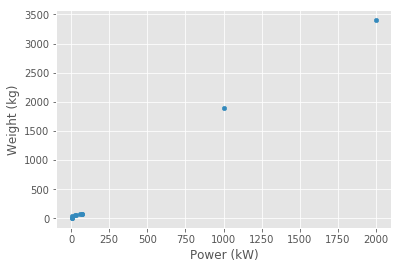

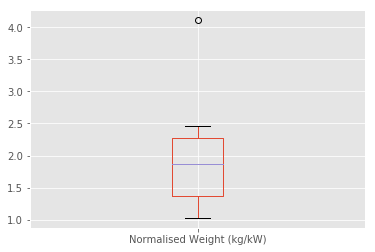

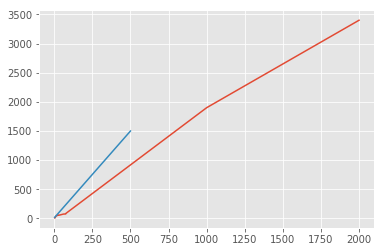

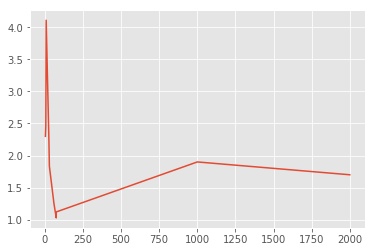

In [62]:
# Weight (kg) evolution with rated Power (kW)
# Use of data from SMA inverter products.
df = pd.DataFrame()
oldx = [2.5, 500]
oldy = [18.5, 1500]
df['Weight (kg)'] = [77, 75, 84, 60, 37, 55, 16,  9.2, 3400, 1900]
df['Power (kW)'] =  [75, 60, 75, 27,  9, 30, 6.5, 4,   2000, 1000]
df['Normalised Weight (kg/kW)'] = df['Weight (kg)'] / df['Power (kW)']
df.plot(kind = 'scatter', x = 'Power (kW)', y = 'Weight (kg)')
#df.plot(kind = 'scatter', x = 'oldx', y = 'oldy', color='r')
#df.plot(kind = 'scatter', x = 'Power (kW)', y = 'Normalised Weight (kg/kW)')
fig, ax = plt.subplots()
df['Normalised Weight (kg/kW)'].plot(kind = 'box', ax = ax)

ii = np.argsort(df['Power (kW)'])
plt.figure()
plt.plot(df['Power (kW)'][ii], df['Weight (kg)'][ii])
plt.plot(oldx, oldy)

plt.figure()
plt.plot(df['Power (kW)'][ii], df['Normalised Weight (kg/kW)'][ii])

Let's consider a typical value of 2 kg per kW. This value is considered conservative as new products tend to be lighter with the development of new technologies.

In [63]:
# Evolution of the share of material with rated power ?
list_act = [act for act in eidb if 'inverter production' in act['name'] and not 'car' in act['name'] and 'RER' in act['location']]
list_act

['inverter production, 0.5kW' (unit, RER, None),
 'inverter production, 500kW' (unit, RER, None),
 'inverter production, 2.5kW' (unit, RER, None)]

In [64]:
#Creating a dataframe for input-output flow
act = [act for act in eidb if 'inverter production, 500kW' == act['name'] and not 'car' in act['name'] and 'RER' in act['location']][0]
print(act)

df = pd.DataFrame(index = ['amount','unit','key'])
for exc in act.exchanges():
    if exc['name'] in df.columns:
        df[exc['name']].loc['amount'] += exc.amount
    else:
        df[exc['name']] = [exc.amount, exc.unit, exc.input.key]
df_inverter_500kW = df.T
df_inverter_500kW

'inverter production, 500kW' (unit, RER, None)


amount           unit  \
injection moulding                                          71       kilogram   
inductor, ring core choke type                           0.351       kilogram   
waste plastic, industrial electronics                     -230       kilogram   
transistor, wired, small size, through-hole mou...       0.038       kilogram   
used printed wiring boards                             -48.866       kilogram   
printed wiring board, for through-hole mounting...      0.1123   square meter   
lubricating oil                                            881       kilogram   
copper                                                     335       kilogram   
polystyrene foam slab                                      1.6       kilogram   
steel, low-alloyed, hot rolled                            1438       kilogram   
polyethylene, high density, granulate                       22       kilogram   
aluminium, cast alloy                                      131       kilogram   
wire drawing, copper                                       335       kilogram   
integrated circuit, logic type                           0.028       kilogram   
inverter, 500kW                                              1           unit   
glass fibre reinforced plastic, polyamide, inje...          71       kilogram   
alkyd paint, white, without solvent, in 60% sol...          22       kilogram   
corrugated board box                                      13.6       kilogram   
printed wiring board, for through-hole mounting...      0.1123   square meter   
fleece, polyethylene                                       0.3       kilogram   
electricity, medium voltage                             4577.8  kilowatt hour   
capacitor, tantalum-, for through-hole mounting          0.023       kilogram   
section bar extrusion, aluminium                           131       kilogram   
glass fibre reinforced plastic, polyester resin...          44       kilogram   
diode, glass-, for through-hole mounting                 0.047       kilogram   
sheet rolling, steel                                      1438       kilogram   
capacitor, electrolyte type, > 2cm height                0.256       kilogram   
electric connector, wire clamp                            47.4       kilogram   
resistor, metal film type, through-hole mounting         0.005       kilogram   
capacitor, film type, for through-hole mounting          0.341       kilogram   
metal working factory                               1.3555e-06           unit   
waste mineral oil                                         -881       kilogram   
waste paperboard                                         -13.6       kilogram   
waste polystyrene                                         -1.6       kilogram   
waste polyethylene                                        -1.6       kilogram   

                                                                                                  key  
injection moulding                                  (ecoinvent 3.4 cut off, 3781de39d137830e00d0d4...  
inductor, ring core choke type                      (ecoinvent 3.4 cut off, 4fe816c92b00c50236a58b...  
waste plastic, industrial electronics               (ecoinvent 3.4 cut off, 205d8c93fd695eca8f07d7...  
transistor, wired, small size, through-hole mou...  (ecoinvent 3.4 cut off, 582fa68b18f99344993468...  
used printed wiring boards                          (ecoinvent 3.4 cut off, 02a397f992ace13c52e2d5...  
printed wiring board, for through-hole mounting...  (ecoinvent 3.4 cut off, 4beedb8a26bed6c2ccf7ec...  
lubricating oil                                     (ecoinvent 3.4 cut off, 73755d76796b5973edb546...  
copper                                              (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...  
polystyrene foam slab                               (ecoinvent 3.4 cut off, f73ebbe3fe8fd9ac4f9f55...  
steel, low-alloyed, hot rolled                      (ecoinvent 3.4 cut off, 1e200a3049db914305193e.

In [65]:
act = [act for act in eidb if 'inverter production, 2.5kW' == act['name'] and not 'car' in act['name'] and 'RER' in act['location']][0]
print(act)

df = pd.DataFrame(index = ['amount','unit','key'])
for exc in act.exchanges():
    if exc['name'] in df.columns:
        df[exc['name']].loc['amount'] += exc.amount
    else:
        df[exc['name']] = [exc.amount, exc.unit, exc.input.key]
df_inverter_3kW = df.T
df_inverter_3kW

'inverter production, 2.5kW' (unit, RER, None)


amount           unit  \
capacitor, tantalum-, for through-hole mounting          0.023       kilogram   
fleece, polyethylene                                      0.06       kilogram   
used printed wiring boards                             -1.7028       kilogram   
sheet rolling, steel                                       9.8       kilogram   
wire drawing, copper                                      5.51       kilogram   
electricity, medium voltage                               21.2  kilowatt hour   
aluminium, cast alloy                                      1.4       kilogram   
integrated circuit, logic type                           0.028       kilogram   
steel, low-alloyed, hot rolled                             9.8       kilogram   
electric connector, wire clamp                           0.237       kilogram   
polyvinylchloride, suspension polymerised           0.00111363       kilogram   
printed wiring board, for through-hole mounting...      0.1123   square meter   
copper                                                    5.51       kilogram   
polystyrene foam slab                                      0.3       kilogram   
corrugated board box                                       2.5       kilogram   
capacitor, film type, for through-hole mounting          0.341       kilogram   
capacitor, electrolyte type, > 2cm height                0.256       kilogram   
section bar extrusion, aluminium                           1.4       kilogram   
transistor, wired, small size, through-hole mou...       0.038       kilogram   
metal working factory                               8.9722e-09           unit   
printed wiring board, for through-hole mounting...      0.1123   square meter   
inverter, 2.5kW                                              1           unit   
styrene-acrylonitrile copolymer                           0.01       kilogram   
diode, glass-, for through-hole mounting                 0.047       kilogram   
resistor, metal film type, through-hole mounting         0.005       kilogram   
inductor, ring core choke type                           0.351       kilogram   
waste paperboard                                          -2.5       kilogram   
waste polyethylene                                       -0.06       kilogram   
waste polystyrene                                        -0.31       kilogram   

                                                                                                  key  
capacitor, tantalum-, for through-hole mounting     (ecoinvent 3.4 cut off, b525361470b501ce153428...  
fleece, polyethylene                                (ecoinvent 3.4 cut off, cd1c52a88fc5be045481ca...  
used printed wiring boards                          (ecoinvent 3.4 cut off, 02a397f992ace13c52e2d5...  
sheet rolling, steel                                (ecoinvent 3.4 cut off, 8a128c621f9c7baa4b1829...  
wire drawing, copper                                (ecoinvent 3.4 cut off, c38aa059b7d23ec512f2f0...  
electricity, medium voltage                         (ecoinvent 3.4 cut off, 18d8b8e2112d031cfe8efe...  
aluminium, cast alloy                               (ecoinvent 3.4 cut off, bb3477bde0c4f3663411a7...  
integrated circuit, logic type                      (ecoinvent 3.4 cut off, dd66ca120c00004ae6d0c8...  
steel, low-alloyed, hot rolled                      (ecoinvent 3.4 cut off, 1e200a3049db914305193e...  
electric connector, wire clamp                      (ecoinvent 3.4 cut off, 9c266f7fe439da8f464615...  
polyvinylchloride, suspension polymerised           (ecoinvent 3.4 cut off, ccfb64ee17372f0470664d...  
printed wiring board, for through-hole mounting...  (ecoinvent 3.4 cut off, aca623540bec2a77abae8c...  
copper                                              (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...  
polystyrene foam slab                               (ecoinvent 3.4 cut off, f73ebbe3fe8fd9ac4f9f55...  
corrugated board box                                (ecoinvent 3.

In [66]:
df_inverter = pd.concat([df_inverter_3kW, df_inverter_500kW], axis = 1, keys = ['3 kW', '500 kW'])
df_inverter = df_inverter.drop(['inverter, 2.5kW', 'inverter, 500kW'])
df_inverter

C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


3 kW                 \
                                                        amount           unit   
alkyd paint, white, without solvent, in 60% sol...         NaN            NaN   
aluminium, cast alloy                                      1.4       kilogram   
capacitor, electrolyte type, > 2cm height                0.256       kilogram   
capacitor, film type, for through-hole mounting          0.341       kilogram   
capacitor, tantalum-, for through-hole mounting          0.023       kilogram   
copper                                                    5.51       kilogram   
corrugated board box                                       2.5       kilogram   
diode, glass-, for through-hole mounting                 0.047       kilogram   
electric connector, wire clamp                           0.237       kilogram   
electricity, medium voltage                               21.2  kilowatt hour   
fleece, polyethylene                                      0.06       kilogram   
glass fibre reinforced plastic, polyamide, inje...         NaN            NaN   
glass fibre reinforced plastic, polyester resin...         NaN            NaN   
inductor, ring core choke type                           0.351       kilogram   
injection moulding                                         NaN            NaN   
integrated circuit, logic type                           0.028       kilogram   
lubricating oil                                            NaN            NaN   
metal working factory                               8.9722e-09           unit   
polyethylene, high density, granulate                      NaN            NaN   
polystyrene foam slab                                      0.3       kilogram   
polyvinylchloride, suspension polymerised           0.00111363       kilogram   
printed wiring board, for through-hole mounting...      0.1123   square meter   
printed wiring board, for through-hole mounting...      0.1123   square meter   
resistor, metal film type, through-hole mounting         0.005       kilogram   
section bar extrusion, aluminium                           1.4       kilogram   
sheet rolling, steel                                       9.8       kilogram   
steel, low-alloyed, hot rolled                             9.8       kilogram   
styrene-acrylonitrile copolymer                           0.01       kilogram   
transistor, wired, small size, through-hole mou...       0.038       kilogram   
used printed wiring boards                             -1.7028       kilogram   
waste mineral oil                                          NaN            NaN   
waste paperboard                                          -2.5       kilogram   
waste plastic, industrial electronics                      NaN            NaN   
waste polyethylene                                       -0.06       kilogram   
waste polystyrene                                        -0.31       kilogram   
wire drawing, copper                                      5.51       kilogram   

                                                                                                       \
                                                                                                  key   
alkyd paint, white, without solvent, in 60% sol...                                                NaN   
aluminium, cast alloy                               (ecoinvent 3.4 cut off, bb3477bde0c4f3663411a7...   
capacitor, electrolyte type, > 2cm height           (ecoinvent 3.4 cut off, e1de6205c74dae2c00ad03...   
capacitor, film type, for through-hole mounting     (ecoinvent 3.4 cut off, bedde173553048a2f18a5a...   
capacitor, tantalum-, for through-hole mounting     (ecoinvent 3.4 cut off, b525361470b501ce153428...   
copper                                              (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...   
corrugated board box                                (ecoinvent 3.4 cut off, 04d83c7892991a382a8177...   
diode, glass-, for through-hole mo

In [67]:
# Merging unit
def merge_unit(row):
    if row['Valid']:
        unit = row['3 kW']
    else :
        unit = row['500 kW']
    return unit

df_unit = df_inverter.xs('unit', level = 1, axis = 1)
df_unit['Valid'] = df_unit['3 kW'].notnull()
df_unit['unit']  = df_unit.apply(merge_unit , axis = 1)

C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [68]:
# Merging key
def merge_key(row):
    if row['Valid']:
        key = row['3 kW']
    else :
        key = row['500 kW']
    return key

df_key = df_inverter.xs('key', level = 1, axis = 1)
df_key['Valid'] = df_key['3 kW'].notnull()
df_key['key']  = df_key.apply(merge_key , axis = 1)

C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [69]:
# Analysing share ratio
df = df_inverter.xs('amount', level = 1, axis = 1)
df = df.replace(np.nan, 0)
df['unit'] = df_unit['unit']
df.loc['Total weight'] = [18.5, 3000, 'kilogram']
df['key'] = df_key['key']

df['3 kW share'] = df['3 kW'] / df['3 kW'].loc['Total weight']
df['500 kW share'] = df['500 kW'] / df['500 kW'].loc['Total weight']
df

3 kW       500 kW  \
alkyd paint, white, without solvent, in 60% sol...  0.000000e+00    22.000000   
aluminium, cast alloy                               1.400000e+00   131.000000   
capacitor, electrolyte type, > 2cm height           2.560000e-01     0.256000   
capacitor, film type, for through-hole mounting     3.410000e-01     0.341000   
capacitor, tantalum-, for through-hole mounting     2.300000e-02     0.023000   
copper                                              5.510000e+00   335.000000   
corrugated board box                                2.500000e+00    13.600000   
diode, glass-, for through-hole mounting            4.700000e-02     0.047000   
electric connector, wire clamp                      2.370000e-01    47.400000   
electricity, medium voltage                         2.120000e+01  4577.800000   
fleece, polyethylene                                6.000000e-02     0.300000   
glass fibre reinforced plastic, polyamide, inje...  0.000000e+00    71.000000   
glass fibre reinforced plastic, polyester resin...  0.000000e+00    44.000000   
inductor, ring core choke type                      3.510000e-01     0.351000   
injection moulding                                  0.000000e+00    71.000000   
integrated circuit, logic type                      2.800000e-02     0.028000   
lubricating oil                                     0.000000e+00   881.000000   
metal working factory                               8.972200e-09     0.000001   
polyethylene, high density, granulate               0.000000e+00    22.000000   
polystyrene foam slab                               3.000000e-01     1.600000   
polyvinylchloride, suspension polymerised           1.113629e-03     0.000000   
printed wiring board, for through-hole mounting...  1.123000e-01     0.112300   
printed wiring board, for through-hole mounting...  1.123000e-01     0.112300   
resistor, metal film type, through-hole mounting    5.000000e-03     0.005000   
section bar extrusion, aluminium                    1.400000e+00   131.000000   
sheet rolling, steel                                9.800000e+00  1438.000000   
steel, low-alloyed, hot rolled                      9.800000e+00  1438.000000   
styrene-acrylonitrile copolymer                     1.000000e-02     0.000000   
transistor, wired, small size, through-hole mou...  3.800000e-02     0.038000   
used printed wiring boards                         -1.702800e+00   -48.866000   
waste mineral oil                                   0.000000e+00  -881.000000   
waste paperboard                                   -2.500000e+00   -13.600000   
waste plastic, industrial electronics               0.000000e+00  -230.000000   
waste polyethylene                                 -6.000000e-02    -1.600000   
waste polystyrene                                  -3.100000e-01    -1.600000   
wire drawing, copper                                5.510000e+00   335.000000   
Total weight                                        1.850000e+01  3000.000000   

                                                             unit  \
alkyd paint, white, without solvent, in 60% sol...       kilogram   
aluminium, cast alloy                                    kilogram   
capacitor, electrolyte type, > 2cm height                kilogram   
capacitor, film type, for through-hole mounting          kilogram   
capacitor, tantalum-, for through-hole mounting          kilogram   
copper                                                   kilogram   
corrugated board box                                     kilogram   
diode, glass-, for through-hole mounting                 kilogram   
electric connector, wire clamp                           kilogram   
electricity, medium voltage                         kilowatt hour   
fleece, polyethylene                                     kilogram   
glass fibre reinforced plastic, polyamide, inje...       kilogram   
glass fibre reinforced plastic, polyester resin...       kilogram   
inductor, ring 

the 2.5kW weighs 18.5 kg and the 500kW weighs 3000 kg.

Between a 3 kVA inverter and a 500 kVA inverter, there is a significant evolution in the share material used. 
The inventory will be calculated based on the weight of the inverter multiplied by the share of the different material involved interpolated between the 3 KVA and 500 kVA inventories.

In [70]:
df.to_pickle('inverter_inventories.pkl')

### Loading inventories

In [64]:
df_inverter = pd.read_pickle('inverter_inventories.pkl')
df_inverter_share = df_inverter[['3 kW share', '500 kW share']]
df_inverter

3 kW       500 kW  \
alkyd paint, white, without solvent, in 60% sol...  0.000000e+00    22.000000   
aluminium, cast alloy                               1.400000e+00   131.000000   
capacitor, electrolyte type, > 2cm height           2.560000e-01     0.256000   
capacitor, film type, for through-hole mounting     3.410000e-01     0.341000   
capacitor, tantalum-, for through-hole mounting     2.300000e-02     0.023000   
copper                                              5.510000e+00   335.000000   
corrugated board box                                2.500000e+00    13.600000   
diode, glass-, for through-hole mounting            4.700000e-02     0.047000   
electric connector, wire clamp                      2.370000e-01    47.400000   
electricity, medium voltage                         2.120000e+01  4577.800000   
fleece, polyethylene                                6.000000e-02     0.300000   
glass fibre reinforced plastic, polyamide, inje...  0.000000e+00    71.000000   
glass fibre reinforced plastic, polyester resin...  0.000000e+00    44.000000   
inductor, ring core choke type                      3.510000e-01     0.351000   
injection moulding                                  0.000000e+00    71.000000   
integrated circuit, logic type                      2.800000e-02     0.028000   
lubricating oil                                     0.000000e+00   881.000000   
metal working factory                               8.972200e-09     0.000001   
polyethylene, high density, granulate               0.000000e+00    22.000000   
polystyrene foam slab                               3.000000e-01     1.600000   
polyvinylchloride, suspension polymerised           1.113629e-03     0.000000   
printed wiring board, for through-hole mounting...  1.123000e-01     0.112300   
printed wiring board, for through-hole mounting...  1.123000e-01     0.112300   
resistor, metal film type, through-hole mounting    5.000000e-03     0.005000   
section bar extrusion, aluminium                    1.400000e+00   131.000000   
sheet rolling, steel                                9.800000e+00  1438.000000   
steel, low-alloyed, hot rolled                      9.800000e+00  1438.000000   
styrene-acrylonitrile copolymer                     1.000000e-02     0.000000   
transistor, wired, small size, through-hole mou...  3.800000e-02     0.038000   
used printed wiring boards                         -1.702800e+00   -48.866000   
waste mineral oil                                   0.000000e+00  -881.000000   
waste paperboard                                   -2.500000e+00   -13.600000   
waste plastic, industrial electronics               0.000000e+00  -230.000000   
waste polyethylene                                 -6.000000e-02    -1.600000   
waste polystyrene                                  -3.100000e-01    -1.600000   
wire drawing, copper                                5.510000e+00   335.000000   
Total weight                                        1.850000e+01  3000.000000   

                                                             unit  \
alkyd paint, white, without solvent, in 60% sol...       kilogram   
aluminium, cast alloy                                    kilogram   
capacitor, electrolyte type, > 2cm height                kilogram   
capacitor, film type, for through-hole mounting          kilogram   
capacitor, tantalum-, for through-hole mounting          kilogram   
copper                                                   kilogram   
corrugated board box                                     kilogram   
diode, glass-, for through-hole mounting                 kilogram   
electric connector, wire clamp                           kilogram   
electricity, medium voltage                         kilowatt hour   
fleece, polyethylene                                     kilogram   
glass fibre reinforced plastic, polyamide, inje...       kilogram   
glass fibre reinforced plastic, polyester resin...       kilogram   
inductor, ring 

In [65]:
# Activities present in the 3 kW inverter (but not in the 500 kW)
PVC = [act for act in eidb if 'polyvinylchloride, suspension polymerised' in act['name'] ][0]
Styrene = [act for act in eidb if 'market for styrene-acrylonitrile copolymer' == act['name'] and 'GLO' in act['location']][0]
print(PVC)
print(Styrene)

'market for polyvinylchloride, suspension polymerised' (kilogram, GLO, None)
'market for styrene-acrylonitrile copolymer' (kilogram, GLO, None)


In [66]:
# Recycling activities
scrap_aluminium = [act for act in eidb if 'market for scrap alu' in act['name'] and 'Europe' in act['location']][0]
print(scrap_aluminium)
scrap_steel = [act for act in eidb if 'market for scrap steel' in act['name'] and 'Europe' in act['location']][0]
print(scrap_steel)
scrap_copper = [act for act in eidb if 'market for scrap copper' in act['name'] and 'Europe' in act['location']][0]
print(scrap_copper)
scrap_electronic = [act for act in eidb if 'market for electronics scrap' == act['name']][0]
print(scrap_electronic)

'market for scrap aluminium' (kilogram, Europe without Switzerland, None)
'market for scrap steel' (kilogram, Europe without Switzerland, None)
'market for scrap copper' (kilogram, Europe without Switzerland, None)
'market for electronics scrap' (kilogram, GLO, None)


In [67]:
def generate_inverter_dataset(P = 10, elec_dataset = None, recycling_rate = 0):
    '''
    This function generates an inventorie of 1 kg of inverter depending of the power output 
    (P expressed in kW)
    (based on the interpolation between 3 kW and 500 kW inverters' inventory)
    '''   
    
    if [act for act in eidb if 'Inverter production, P kW per kg' == act['name']] == []: 
        inverter_500kW = [act for act in eidb if 'inverter production, 500kW' in act['name'] and not 'car' in act['name'] and 'RER' in act['location']][0]
        inverter_P_per_kg = inverter_500kW.copy()
        inverter_P_per_kg['name'] = 'Inverter production, P kW per kg'
        inverter_P_per_kg['unit'] = 'kilogram'
        inverter_P_per_kg['authors'] = 'Romain Besseau'
        inverter_P_per_kg['comment'] = 'Dataset based on the inventories of 3 kVA and 500 kVA PV inverters. It gives the inventory per inverter kilogram depending on the rated power P and considering a linear extrapolation between 3 kVA and 500 kVA inventories that do not have the same material ratio. The impact per kW will then be calculated considering 2 kg of inverter per kW (based on the analysis of ABB PV inverters). PS: With technical improvements the ratio weight power tends to decrease.'
        inverter_P_per_kg.as_dict()
        inverter_P_per_kg.save()
    else:
        inverter_P_per_kg = [act for act in eidb if 'Inverter production, P kW per kg' == act['name']][0]

    #Removing all data
    for exc in inverter_P_per_kg.exchanges():
        exc.delete()
    inverter_P_per_kg.save()

    #New Output
    new_exc = inverter_P_per_kg.new_exchange(input = inverter_P_per_kg.key, name = 'Inverter production, P kW per kg',
                                             amount = 1, unit = 'kg', categories = '', type = 'production')
    new_exc.save()
    inverter_P_per_kg.save()

    #New Inputs
    for exc in df_inverter[df_inverter.key.notnull()].index:
        #print(exc)
        value = np.interp(P, [3, 500], df_inverter_share.loc[exc][['3 kW share', '500 kW share']].values)
        #print(value)
        new_exc = inverter_P_per_kg.new_exchange(input = df_inverter.loc[exc].key, name = exc, amount = value,
                                                 unit = df_inverter.loc[exc].unit, type = 'technosphere')
        new_exc.save()
        
    inverter_P_per_kg.save()
    
    #Adjusting the electricity used for manufacturing
    if elec_dataset != None:
        for exc in inverter_P_per_kg.exchanges():
            if exc['name'] == 'electricity, medium voltage':
                exc['input'] = elec_dataset.key
                exc.save()

    inverter_P_per_kg.save()
    
    #Adding recycling for aluminium
    #amount to recycle
    m_aluminium = 0
    m_copper = 0
    m_steel = 0
    m_electronic = 0

    for exc in inverter_P_per_kg.exchanges():
        if exc['name'] == 'aluminium, cast alloy':
             m_aluminium += exc['amount']
        if exc['name'] == 'copper':
            m_copper += exc['amount']
        if exc['name'] == 'steel, low-alloyed, hot rolled':
            m_steel += exc['amount']
        if ('capacitor' in exc['name']) or ('diode' in exc['name']) or ('integrated circuit' in exc['name']) or ('printed wiring' in exc['name']) or ('resistor' in exc['name']) or ('transistor' in exc['name']):
            m_electronic += exc['amount']
            
    #Adding aluminium recycling
    new_exc = inverter_P_per_kg.new_exchange(input = scrap_aluminium.key, name = scrap_aluminium['name'], amount = m_aluminium*recycling_rate, unit = scrap_aluminium['unit'], type = 'technosphere')
    new_exc.save() 
    
    #Adding copper recycling
    new_exc = inverter_P_per_kg.new_exchange(input = scrap_copper.key, name = scrap_copper['name'], amount = m_copper*recycling_rate, unit = scrap_copper['unit'], type = 'technosphere')
    new_exc.save()
    
    #Adding steel recycling
    new_exc = inverter_P_per_kg.new_exchange(input = scrap_steel.key, name = scrap_steel['name'], amount = m_steel*recycling_rate, unit = scrap_steel['unit'], type = 'technosphere')
    new_exc.save()
    
    #Adding electroning recycling
    new_exc = inverter_P_per_kg.new_exchange(input = scrap_electronic.key, name = scrap_electronic['name'], amount = m_electronic*recycling_rate, unit = scrap_electronic['unit'], type = 'technosphere')
    new_exc.save()
    
    inverter_P_per_kg.save()
        
    return inverter_P_per_kg

In [75]:
inverter_P_per_kg = generate_inverter_dataset(P = 2.5, elec_dataset = None, recycling_rate = 0)
inverter_P_per_kg

'Inverter production, P kW per kg' (kilogram, RER, None)

In [76]:
inverter_P_per_kg = [act for act in eidb if 'Inverter production, P kW per kg' in act['name']][0]
inverter_P_per_kg

'Inverter production, P kW per kg' (kilogram, RER, None)

In [77]:
print_data(inverter_P_per_kg)

'Inverter production, P kW per kg' (kilogram, RER, None)


amount  \
Inverter production, P kW per kg                              1   
alkyd paint, white, without solvent, in 60% sol...            0   
aluminium, cast alloy                                 0.0756757   
capacitor, electrolyte type, > 2cm height             0.0138378   
capacitor, film type, for through-hole mounting       0.0184324   
capacitor, tantalum-, for through-hole mounting      0.00124324   
copper                                                 0.297838   
corrugated board box                                   0.135135   
diode, glass-, for through-hole mounting             0.00254054   
electric connector, wire clamp                        0.0128108   
electricity, medium voltage                             1.14595   
fleece, polyethylene                                 0.00324324   
glass fibre reinforced plastic, polyamide, inje...            0   
glass fibre reinforced plastic, polyester resin...            0   
inductor, ring core choke type                         0.018973   
injection moulding                                            0   
integrated circuit, logic type                       0.00151351   
lubricating oil                                               0   
metal working factory                               4.84984e-10   
polyethylene, high density, granulate                         0   
polystyrene foam slab                                 0.0162162   
polyvinylchloride, suspension polymerised           6.01962e-05   
printed wiring board, for through-hole mounting...   0.00607027   
printed wiring board, for through-hole mounting...   0.00607027   
resistor, metal film type, through-hole mounting     0.00027027   
section bar extrusion, aluminium                      0.0756757   
sheet rolling, steel                                    0.52973   
steel, low-alloyed, hot rolled                          0.52973   
styrene-acrylonitrile copolymer                     0.000540541   
transistor, wired, small size, through-hole mou...   0.00205405   
used printed wiring boards                           -0.0920432   
waste mineral oil                                             0   
waste paperboard                                      -0.135135   
waste plastic, industrial electronics                         0   
waste polyethylene                                  -0.00324324   
waste polystyrene                                    -0.0167568   
wire drawing, copper                                   0.297838   
market for scrap aluminium                                    0   
market for scrap copper                                       0   
market for scrap steel                                        0   
market for electronics scrap                                 -0   

                                                             unit  \
Inverter production, P kW per kg                         kilogram   
alkyd paint, white, without solvent, in 60% sol...       kilogram   
aluminium, cast alloy                                    kilogram   
capacitor, electrolyte type, > 2cm height                kilogram   
capacitor, film type, for through-hole mounting          kilogram   
capacitor, tantalum-, for through-hole mounting          kilogram   
copper                                                   kilogram   
corrugated board box                                     kilogram   
diode, glass-, for through-hole mounting                 kilogram   
electric connector, wire clamp                           kilogram   
electricity, medium voltage                         kilowatt hour   
fleece, polyethylene                                     kilogram   
glass fibre reinforced plastic, polyamide, inje...       kilogram   
glass fibre reinforced plastic, polyester resin...       kilogram   
inductor, ring core choke type                           kilogram   
injection moulding                                       kilogram   
integrated circuit, logic type                           kilogram   


In [78]:
inverter_2_5 = [act for act in eidb if 'inverter production, 2.5kW' in act['name'] and 'RER' in act['location']][0]
inverter_2_5

'inverter production, 2.5kW' (unit, RER, None)

2.5 kw * 2 kg / kW = 5 kg

In [79]:
set_of_methods = list_methods
bw.calculation_setups['B_inverter_2.5kW'] = {'inv': [{inverter_2_5:1}, {inverter_P_per_kg:5}], 'ia': set_of_methods}
myMultiLCA = bw.MultiLCA('B_inverter_2.5kW')
df_impact = pd.DataFrame(columns = set_of_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                          232.46013            
1                                           62.82403            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           3.956890                                               
1                                           1.069429                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                         647.113624                             
1                                         174.894966                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.294940                                
1                                           0.079713                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000084                         
1                                           0.000023                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.339433                            
1                                           0.091738                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           4.203027                                 
1                                           1.135952                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000012                      
1                                           0.000003                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                          10.284614                    
1                                           2.779623                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000227                          
1                                           0.000061                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000016                       
1                                           0.000004                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           1.322383                              
1                                           0.357400                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.353159                                 
1                                           0.095448                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         466.681831       
1                                         126.130462       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.388916                             
1                                           0.105112

In [80]:
(232.46-62.83)/232.46*100

72.97169405489116

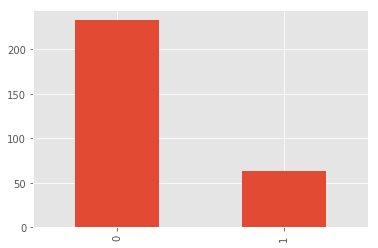

In [83]:
b = df_impact.T.iloc[0]
b.plot(kind = 'bar')

In [84]:
inverter_P_per_kg_500 = generate_inverter_dataset(P = 500, elec_dataset = None, recycling_rate = 0)
inverter_P_per_kg_500

'Inverter production, P kW per kg' (kilogram, RER, None)

In [85]:
inverter_P_per_kg_500 = [act for act in eidb if 'Inverter production, P kW per kg' in act['name']][0]
inverter_P_per_kg_500

'Inverter production, P kW per kg' (kilogram, RER, None)

In [86]:
inverter_500 = [act for act in eidb if 'inverter production, 500kW' in act['name'] and 'RER' in act['location']][0]
inverter_500

'inverter production, 500kW' (unit, RER, None)

500 kW * 2 kg / kW = 1000 kg

In [87]:
set_of_methods = list_methods
bw.calculation_setups['B_inverter_500kW'] = {'inv': [{inverter_500:1}, {inverter_P_per_kg_500:1000}], 'ia': set_of_methods}
myMultiLCA = bw.MultiLCA('B_inverter_500kW')
df_impact = pd.DataFrame(columns = set_of_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                       13560.546131            
1                                        4517.975605            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                         217.480796                                               
1                                          72.493434                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                      107670.453573                             
1                                       35889.553667                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                          13.390272                                
1                                           4.463414                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.005755                         
1                                           0.001918                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                          16.124333                            
1                                           5.374713                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                         205.487093                                 
1                                          68.494855                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.001220                      
1                                           0.000407                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                         735.078914                    
1                                         245.025604                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.013296                          
1                                           0.004432                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.001202                       
1                                           0.000401                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                          77.627912                              
1                                          25.875800                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                          17.932993                                 
1                                           5.977554                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                       30240.985515       
1                                       10080.314103       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           5.312304                             
1                                           1.770767

In [88]:
(13560-4517)/13560*100

66.68879056047197

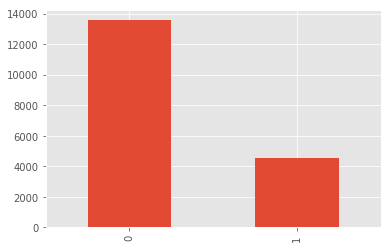

In [90]:
a = df_impact.T.iloc[0]
a.plot(kind = 'bar')

It can be seen that there is a reduction in the envrionmental impacts (~ 66-73% reduction for the climate change). This results from the weight adjustment and the material adjustment accordingly.

## Metallization paste

This section replaces all the silver used in the metallization paste by copper.
However, the adequate replacement will be accomplished in the following sections according to the conductivity.

In [68]:
#Create a new metalization paste copper based
metal_paste_copper = [act for act in eidb if 'metallization paste production, back side, copper' == act['name'] and not 'aluminium' in act['name']]
    
if metal_paste_copper == []: 
    #SCA 'RER' added
    metal_paste = [act for act in eidb if 'metallization paste production, back side' == act['name'] and 'RER' in act['location'] and not 'aluminium' in act['name']][0]
    metal_paste_copper = metal_paste.copy()
    metal_paste_copper['name'] = 'metallization paste production, back side, copper'
    metal_paste_copper['authors'] = 'Romain Besseau'
    metal_paste_copper['comment'] = 'Dataset for metallization paste production where Silver is simply replaced by Copper'


    for exc in metal_paste_copper.exchanges():
        exc['output'] = metal_paste_copper.key
        exc.save()

    copper_dataset = [act for act in eidb if 'copper production, primary' == act['name'] and 'RoW'in act['location']][0]
    #Changing the silver dataset to copper.               
    for exc in metal_paste_copper.exchanges():
        if exc['name'] == 'silver':
            print('Activity to change:')
            print(exc['name'])
            exc['name'] = copper_dataset['name']
            exc['input'] = copper_dataset.key
            print('Activity changed:')
            print(exc['name'])
            exc.save()  
    metal_paste_copper.save()  

metal_paste_copper = [act for act in eidb if 'metallization paste production, back side, copper' in act['name'] ][0]
metal_paste_copper

'metallization paste production, back side, copper' (kilogram, RER, None)

In [69]:
metallization_ori = [act for act in eidb if 'metallization paste production, back side' == act['name'] and not 'aluminium' in act['name']][0]
metallization_ori

'metallization paste production, back side' (kilogram, RoW, None)

In [70]:
metallization_adj = [act for act in eidb if 'metallization paste production, back side, copper' == act['name']][0]
metallization_adj

'metallization paste production, back side, copper' (kilogram, RER, None)

In [94]:
bw.calculation_setups['B_metallization_paste'] = {'inv': [{metallization_ori:1}, {metallization_adj:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_metallization_paste')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         234.351096            
1                                           4.276317            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           2.872357                                               
1                                           0.428741                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                         384.524064                             
1                                          83.385586                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.413738                                
1                                           0.038706                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000092                         
1                                           0.000001                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.774485                            
1                                           0.014599                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                          10.586366                                 
1                                           0.215635                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       2.145210e-06                      
1                                       4.948149e-07                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                          11.448431                    
1                                           0.155412                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000112                          
1                                           0.000045                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       1.703255e-05                       
1                                       2.450392e-07                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           2.233939                              
1                                           0.065362                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.258240                                 
1                                           0.026759                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         501.257430       
1                                          15.583756       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           1.313528                             
1                                           0.010606

In [95]:
(234.35-4.28)/234.35*100

98.17367185833156

This is a theoretical analysis, if all the silver is replaced by copper, the impact can be tremendously reduced. However, it is not the case because of the difference in conductivity, and, hence, the difference of amount needed accordingly.

## Silicon solar grade manufacturing

In this section, the main modification implemented is the change of the electrcity intensity used for the manufacturing of the solar grade.

It should be noted that the parameter Silicon_electricity_intensity englobes the electrcity used for solar processing and casting so 110 + 85 (for casting) kg / kWh in ecoinvent 3.4

In [71]:
def generate_silicon_dataset(Silicon_electricity_intensity = 30+10, elec_dataset = None):
    '''
    This function generates an inventory of 1 kg of silicon solar grade with a variable amount of electricity
    used for the solar grade modified Siemens process.
    electricity_intensity is expressed in kWh/kg. The initial value was initally set at 110 + 85 kWh/kg.
    Using FBR, this value can go down to 30 + 15 kWh/kg (Task 12 report: Stolz et al. (2017))
    '''
    initial_dataset = 'silicon production, solar grade, modified Siemens process'
    Silicon_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name']]
    
    if Silicon_adjusted == []: 
        Silicon = [act for act in eidb if initial_dataset == act['name'] and 'RER' in act['location']][0]
        Silicon_adjusted = Silicon.copy()
        Silicon_adjusted['name'] = initial_dataset + ' adjusted'
        Silicon_adjusted['authors'] = 'Romain Besseau'
        Silicon_adjusted['comment'] = 'Dataset adjusted with the amount of electricity and the corresponding dataset'      
        
        for exc in Silicon_adjusted.exchanges():
            exc['output'] = Silicon_adjusted.key
            exc.save()
        
        #Deleting hydro dataset not to count two times electricity
        # Elec dataset to remove to avoid double amount of electricity
        elec_hydro = [act for act in eidb if 'electricity production, hydro, run-of-river' in act['name'] and 'RoW' in act['location']][0]

        for exc in Silicon_adjusted.exchanges():
            if exc['unit'] == 'kilowatt hour':
                if exc['activity'] == elec_hydro['activity']:
                    exc['amount'] = 0
                    exc.delete()
                    exc.save()
        
        Silicon_adjusted.save()        
        
    else:
        #Silicon = [act for act in eidb if initial_dataset in act['name'] and 'RER' in act['location']][0]
        Silicon_adjusted = [act for act in eidb if initial_dataset + ' adjusted' in act['name']][0]
        
    #Adjusting the amount of electricity used
    for exc in Silicon_adjusted.exchanges():
        if exc['name'] == 'electricity, high voltage':
            exc['amount'] = Silicon_electricity_intensity
            exc.save()
      
    #Adjusting the electricity used for manufacturing
    if elec_dataset != None:
        for exc in Silicon_adjusted.exchanges():
            if exc['name'] == 'electricity, high voltage':
                exc['input'] = elec_dataset.key
                exc.save()

    Silicon_adjusted.save()
    
    return Silicon_adjusted

In [97]:
Silicon_adjusted = generate_silicon_dataset(Silicon_electricity_intensity = 30+10, elec_dataset = None)
Silicon_adjusted

'silicon production, solar grade, modified Siemens process adjusted' (kilogram, RER, None)

In [98]:
silicon_ori = [act for act in eidb if 'silicon production, solar grade, modified Siemens process' == act['name']
               and 'RER' in act['location']][0]
silicon_ori

'silicon production, solar grade, modified Siemens process' (kilogram, RER, None)

In [99]:
bw.calculation_setups['B_silicon_grade'] = {'inv': [{silicon_ori:1}, {Silicon_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_silicon_grade')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                          44.688726            
1                                          42.231903            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.227190                                               
1                                           0.211422                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                           8.534174                             
1                                           7.706300                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.002889                                
1                                           0.002640                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000030                         
1                                           0.000027                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.029261                            
1                                           0.027410                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.423511                                 
1                                           0.392497                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       2.579098e-07                      
1                                       2.184261e-07                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           3.658512                    
1                                           3.315848                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000003                          
1                                           0.000003                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000005                       
1                                           0.000005                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.097260                              
1                                           0.091702                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.020092                                 
1                                           0.018872                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                          33.338078       
1                                          31.376636       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.000604                             
1                                           0.000583

In [100]:
(44.68-42.23)/44.68*100

5.4834377797672404

A correction was made here: in ecoinvent 3.4, 65 kWh / kg was considered produced by hydro-electricity which is not always the case in all the countries. Therefore, these 65 were added to the 45 kWh under 1 source of electricity (not hydro). Therefore, if we correct this value, the original dataset would have 72 kg-CO2-eq/kWh. Hence, this impact reduction are compensated by the less electricity needed going from 110 to 45 kWh / kg. This why, at the end, the significant difference is not noticed.

### Amount of electricity for the different processes ?

In [101]:
list_act = [act for act in eidb if 'silicon production' in act['name'] and not 'treatment' in act['name'] and not 'ferro' in act['name'] and not 'market' in act['name']]
list_act

['silicon production, multi-Si, casted' (kilogram, CA-QC, None),
 'silicon production, electronics grade' (kilogram, DE, None),
 'silicon production, electronics grade' (kilogram, DE, None),
 'silicon production, single crystal, Czochralski process, photovoltaics' (kilogram, RER, None),
 'silicon production, multi-Si, casted' (kilogram, RoW, None),
 'silicon production, solar grade, modified Siemens process' (kilogram, RoW, None),
 'silicon production, electronics grade' (kilogram, RoW, None),
 'silicon production, solar grade, modified Siemens process' (kilogram, RER, None),
 'silicon production, multi-Si, casted' (kilogram, RER, None),
 'silicon production, metallurgical grade' (kilogram, RoW, None),
 'silicon production, solar grade, modified Siemens process adjusted' (kilogram, RER, None),
 'silicon production, electronics grade' (kilogram, RoW, None),
 'silicon production, single crystal, Czochralski process, electronics' (kilogram, RoW, None),
 'silicon production, electronics gr

In [102]:
DF = pd.DataFrame()
for act in list_act:
    df = pd.DataFrame(index = ['amount','unit','key'])
    for exc in act.exchanges():
        if exc['name'] in df.columns:
            df[exc['name']].loc['amount'] += exc.amount
        else:
            df[exc['name']] = [exc.amount, exc.unit, exc.input.key]
    df = df.T[['amount']]
    df.columns = [act['name'] +' '+ act['location']]
    DF = pd.concat([DF,df], axis = 1)
DF.T[['electricity, medium voltage','electricity, high voltage']]

C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


electricity, medium voltage  \
silicon production, multi-Si, casted CA-QC                              19.295   
silicon production, electronics grade DE                                   NaN   
silicon production, electronics grade DE                                   NaN   
silicon production, single crystal, Czochralski...                        85.6   
silicon production, multi-Si, casted RoW                                19.295   
silicon production, solar grade, modified Sieme...                         NaN   
silicon production, electronics grade RoW                                  NaN   
silicon production, solar grade, modified Sieme...                         NaN   
silicon production, multi-Si, casted RER                                19.295   
silicon production, metallurgical grade RoW                                 11   
silicon production, solar grade, modified Sieme...                         NaN   
silicon production, electronics grade RoW                                  NaN   
silicon production, single crystal, Czochralski...                         200   
silicon production, electronics grade RoW                                  NaN   
silicon production, single crystal, Czochralski...                         200   
silicon production, single crystal, Czochralski...                        85.6   
silicon production, metallurgical grade NO                                  11   
silicon production, electronics grade DE                                   NaN   

                                                   electricity, high voltage  
silicon production, multi-Si, casted CA-QC                               NaN  
silicon production, electronics grade DE                             121.476  
silicon production, electronics grade DE                             32.4405  
silicon production, single crystal, Czochralski...                       NaN  
silicon production, multi-Si, casted RoW                                 NaN  
silicon production, solar grade, modified Sieme...                       110  
silicon production, electronics grade RoW                            24.3304  
silicon production, solar grade, modified Sieme...                       110  
silicon production, multi-Si, casted RER                                 NaN  
silicon production, metallurgical grade RoW                              NaN  
silicon production, solar grade, modified Sieme...                        40  
silicon production, electronics grade RoW                            121.476  
silicon production, single crystal, Czochralski...                       NaN  
silicon production, electronics grade RoW                            32.4405  
silicon production, single crystal, Czochralski...                       NaN  
silicon production, single crystal, Czochralski...                       NaN  
silicon production, metallurgical grade NO                               NaN  
silicon production, electronics grade DE                             24.3304

In [103]:
%matplotlib inline

Text(0.5, 0, 'Electricity content (kWh/kg)')

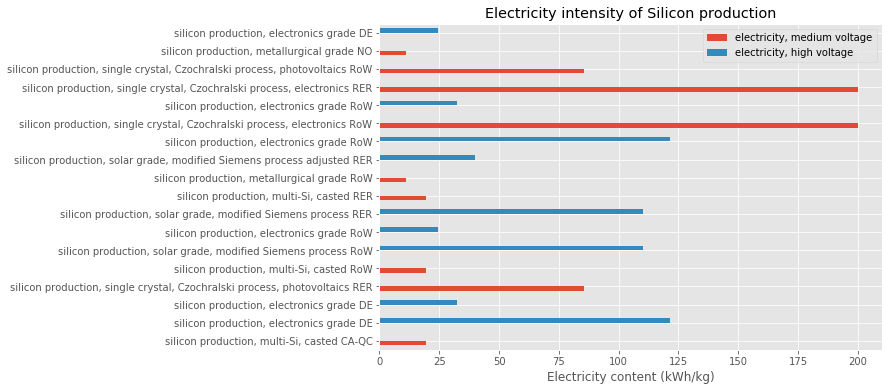

In [104]:
fig, ax = plt.subplots(figsize = (9, 6))
DF.T[['electricity, medium voltage','electricity, high voltage']].plot(kind = 'barh', ax = ax)
plt.title('Electricity intensity of Silicon production')
plt.xlabel('Electricity content (kWh/kg)')

Based on the comparision of the electricity consumption of diffirent silicon processing steps, it can be noticed the following:
- Czochralski process - Energy intensive
- electronic grade with solar grade output consumes energy
- metallurgical - consumes less energy
- solar grade modified Siemens process
- silicon production, multi-Si casted 

In [105]:
Silicon = [act for act in eidb if 'silicon production, solar grade, modified Siemens process' == act['name'] and 'RER' in act['location']][0]
Silicon

'silicon production, solar grade, modified Siemens process' (kilogram, RER, None)

In [106]:
DF = pd.concat([print_data(Silicon),print_data(Silicon_adjusted)], axis = 1, keys = ['original', 'adjusted'])
DF

'silicon production, solar grade, modified Siemens process' (kilogram, RER, None)
'silicon production, solar grade, modified Siemens process adjusted' (kilogram, RER, None)


C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


original                 \
                                                        amount           unit   
AOX, Adsorbable Organic Halogen as Cl               1.2619e-05       kilogram   
BOD5, Biological Oxygen Demand                      0.00020471       kilogram   
COD, Chemical Oxygen Demand                            0.00202       kilogram   
Chloride                                              0.035991       kilogram   
Copper, ion                                         1.0236e-07       kilogram   
DOC, Dissolved Organic Carbon                       0.00090998       kilogram   
Iron, ion                                           5.6085e-06       kilogram   
Nitrogen                                            0.00020751       kilogram   
Phosphate                                           2.8043e-06       kilogram   
Sodium, ion                                            0.03379       kilogram   
TOC, Total Organic Carbon                           0.00090998       kilogram   
Zinc, ion                                            1.963e-06       kilogram   
electricity, high voltage                                  110  kilowatt hour   
heat, district or industrial, natural gas                  185      megajoule   
hydrochloric acid, without water, in 30% soluti...      1.6017       kilogram   
hydrogen, liquid                                      0.050139       kilogram   
silicon, metallurgical grade                              1.13       kilogram   
silicon, solar grade                                         1       kilogram   
silicone factory                                         1e-11           unit   
sodium hydroxide, without water, in 50% solutio...     0.34819       kilogram   

                                                                                                       \
                                                                                                  key   
AOX, Adsorbable Organic Halogen as Cl               (biosphere3, e395a1a3-6915-4b72-a533-ff1a82fc3...   
BOD5, Biological Oxygen Demand                      (biosphere3, 70d467b6-115e-43c5-add2-441de9411...   
COD, Chemical Oxygen Demand                         (biosphere3, fc0b5c85-3b49-42c2-a3fd-db7e57b69...   
Chloride                                            (biosphere3, 5e050fab-1837-4c42-b597-ed2f376f7...   
Copper, ion                                         (biosphere3, 6d9550e2-e670-44c1-bad8-c0c4975ff...   
DOC, Dissolved Organic Carbon                       (biosphere3, 960c0f37-f34c-4fc1-b77c-22d8b35fd...   
Iron, ion                                           (biosphere3, 7c335b9c-a403-47a8-bb6d-2e7d3c3a2...   
Nitrogen                                            (biosphere3, ae70ca6c-807a-482b-9ddc-e449b4893...   
Phosphate                                           (biosphere3, 1727b41d-377e-43cd-bc01-9eaba946e...   
Sodium, ion                                         (biosphere3, 1fc409bc-b8e7-48b2-92d5-2ced4aa7b...   
TOC, Total Organic Carbon                           (biosphere3, f65558fb-61a1-4e48-b4f2-60d62f14b...   
Zinc, ion                                           (biosphere3, 541b633c-17a3-4047-bce6-0c0e4fdb7...   
electricity, high voltage                           (ecoinvent 3.4 cut off, 0ec1bfaa987050bf64a0e1...   
heat, district or industrial, natural gas           (ecoinvent 3.4 cut off, c7dc74449ffe347834f24f...   
hydrochloric acid, without water, in 30% soluti...  (ecoinvent 3.4 cut off, 0f10b7c564e830df89f7a2...   
hydrogen, liquid                                    (ecoinvent 3.4 cut off, bf7545571e83c8827ce310...   
silicon, metallurgical grade                        (ecoinvent 3.4 cut off, 3188d23f89079fe1ac63e4...   
silicon, solar grade                                (ecoinvent 3.4 cut off, 8c4a249ee44347b7b84148...   
silicone factory                                    (ecoinvent 3.4 cut off, 2d3f757fac61524711ef90...   
sodium hydroxide, without water, in 50% solutio...  (ecoinvent 3.4

## Silicon casting

### Analysis of existing silicon casting inventories

In [107]:
list_act = [act for act in eidb if 'silicon production, multi-Si, casted' in act['name'] ]
list_act

['silicon production, multi-Si, casted' (kilogram, RER, None),
 'silicon production, multi-Si, casted' (kilogram, CA-QC, None),
 'silicon production, multi-Si, casted' (kilogram, RoW, None)]

In [108]:
DF = pd.DataFrame()
for act in list_act:
    df = pd.DataFrame(index = ['amount','unit','key'])
    for exc in act.exchanges():
        if exc['name'] in df.columns:
            df[exc['name']].loc['amount'] += exc.amount
        else:
            df[exc['name']] = [exc.amount, exc.unit, exc.input.key]
    df = df.T[['amount']]
    df.columns = [act['name'] +' '+ act['location']]
    DF = pd.concat([DF,df], axis = 1)
display(DF)

C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


silicon production, multi-Si, casted RER  \
Water                                                                             5   
Water, cooling, unspecified natural origin                                        5   
argon, liquid                                                               0.26661   
ceramic tile                                                                0.34204   
electricity, medium voltage                                                  19.295   
helium                                                                   0.00011943   
nitrogen, liquid                                                           0.046747   
silicon, electronics grade                                                 0.165945   
silicon, multi-Si, casted                                                         1   
silicon, solar grade                                                       0.974258   
silicone factory                                                              1e-11   

                                           silicon production, multi-Si, casted CA-QC  \
Water                                                                               5   
Water, cooling, unspecified natural origin                                          5   
argon, liquid                                                                 0.26661   
ceramic tile                                                                  0.34204   
electricity, medium voltage                                                    19.295   
helium                                                                     0.00011943   
nitrogen, liquid                                                             0.046747   
silicon, electronics grade                                                   0.165945   
silicon, multi-Si, casted                                                           1   
silicon, solar grade                                                         0.974258   
silicone factory                                                                1e-11   

                                           silicon production, multi-Si, casted RoW  
Water                                                                             5  
Water, cooling, unspecified natural origin                                        5  
argon, liquid                                                               0.26661  
ceramic tile                                                                0.34204  
electricity, medium voltage                                                  19.295  
helium                                                                   0.00011943  
nitrogen, liquid                                                           0.046747  
silicon, electronics grade                                                 0.165945  
silicon, multi-Si, casted                                                         1  
silicon, solar grade                                                       0.974258  
silicone factory                                                              1e-11

In [109]:
act = [act for act in eidb if 'silicon production, multi-Si, casted' in act['name'] and 'RoW' in act['location']][0]
act

'silicon production, multi-Si, casted' (kilogram, RoW, None)

In [110]:
print_data(act)

'silicon production, multi-Si, casted' (kilogram, RoW, None)


amount           unit  \
argon, liquid                                  0.26661       kilogram   
nitrogen, liquid                              0.046747       kilogram   
silicon, multi-Si, casted                            1       kilogram   
helium                                      0.00011943       kilogram   
silicone factory                                 1e-11           unit   
silicon, solar grade                          0.974258       kilogram   
ceramic tile                                   0.34204       kilogram   
silicon, electronics grade                    0.165945       kilogram   
electricity, medium voltage                     19.295  kilowatt hour   
Water                                                5    cubic meter   
Water, cooling, unspecified natural origin           5    cubic meter   

                                                                                          key  
argon, liquid                               (ecoinvent 3.4 cut off, 2f20c2a049ba5441e42ccd...  
nitrogen, liquid                            (ecoinvent 3.4 cut off, 02cdd2df65932dce703ded...  
silicon, multi-Si, casted                   (ecoinvent 3.4 cut off, eb867f421dde89f989cfdd...  
helium                                      (ecoinvent 3.4 cut off, 5f4d93c5df09c8dde36300...  
silicone factory                            (ecoinvent 3.4 cut off, 2d3f757fac61524711ef90...  
silicon, solar grade                        (ecoinvent 3.4 cut off, de8ae660fc0f701e9599ce...  
ceramic tile                                (ecoinvent 3.4 cut off, bd5664abe2fddef59f855b...  
silicon, electronics grade                  (ecoinvent 3.4 cut off, 6a7f05f0fadb415e3a0d92...  
electricity, medium voltage                 (ecoinvent 3.4 cut off, e3672ed60c481a243f4c29...  
Water                                       (biosphere3, 075e433b-4be4-448e-9510-9a5029c1c...  
Water, cooling, unspecified natural origin  (biosphere3, fc1c42ce-a759-49fa-b987-f1ec5e503...

Let's remove the use of silicon electronics grade (it was significant when the world silicon production was relatively low, nowadays this volume can be neglected compared to the level reached by the solar industry).
Let's remove also silicon solar grade as it is directly call by the wafer dataset and also electricity that is already accounted in the amount of electricity for solar grade manufacturing.
As a consequence, only chemicals, the factory and ceramic will be left and this dataset will complement the silicon solar grade dataset and both will be called for the wafer dataset.

### Creation of a new silicon casting dataset

In [72]:
#Create a new dataset
casting_dataset = [act for act in eidb if 'silicon casting activity' in act['name'] and 'RoW' in act['location']]
    
if casting_dataset == []: 
    original_act = [act for act in eidb if 'silicon production, multi-Si, casted' in act['name'] and 'RoW' in act['location']][0]
    casting_act = original_act.copy()
    casting_act['name'] = 'silicon casting activity'
    casting_act['authors'] = 'Romain Besseau'
    casting_act['comment'] = 'Dataset for silicon casting constructed from silicon production, multi-Si casted removing the silicon that is directly called by the next process, removing the energy that is directly accounted in the silicon dataset. As a results, only chemicals and equipments required for casting remians in the dataset.'

    #Changing connexion to the output and output name
    for exc in casting_act.exchanges():
        exc['output'] = casting_act.key
        exc.save()
        if exc['type'] == 'production':
            exc['name'] = 'casting silicon'
            exc.save()
    casting_act.save()
    
    #Deleting silicon input
    for exc in casting_act.exchanges():
        if 'silicon,' in exc['name']:
            exc.delete()
            exc.save()
        if 'electricity, medium voltage' in exc['name']:
            exc.delete()
            exc.save()
    casting_act.save()
    

casting_act = [act for act in eidb if 'silicon casting activity' in act['name'] and 'RoW' in act['location']][0]
casting_act

'silicon casting activity' (kilogram, RoW, None)

In [112]:
print_data(casting_act)

'silicon casting activity' (kilogram, RoW, None)


amount         unit  \
argon, liquid                                  0.26661     kilogram   
nitrogen, liquid                              0.046747     kilogram   
casting silicon                                      1     kilogram   
helium                                      0.00011943     kilogram   
silicone factory                                 1e-11         unit   
ceramic tile                                   0.34204     kilogram   
Water                                                5  cubic meter   
Water, cooling, unspecified natural origin           5  cubic meter   

                                                                                          key  
argon, liquid                               (ecoinvent 3.4 cut off, 2f20c2a049ba5441e42ccd...  
nitrogen, liquid                            (ecoinvent 3.4 cut off, 02cdd2df65932dce703ded...  
casting silicon                             (ecoinvent 3.4 cut off, 73771362d68742449566ef...  
helium                                      (ecoinvent 3.4 cut off, 5f4d93c5df09c8dde36300...  
silicone factory                            (ecoinvent 3.4 cut off, 2d3f757fac61524711ef90...  
ceramic tile                                (ecoinvent 3.4 cut off, bd5664abe2fddef59f855b...  
Water                                       (biosphere3, 075e433b-4be4-448e-9510-9a5029c1c...  
Water, cooling, unspecified natural origin  (biosphere3, fc1c42ce-a759-49fa-b987-f1ec5e503...

## Wafer manufacturing

In this section, some modifications were integrated by creating new datasets related mainly to the emerging practices in the cutting processes: 6 new datasets were created to serve this purpose.
On one hand, 2 of them (SiC recycled and TEG recycled) are related to the advancements of the traditional cutting process (loose abrasive slurry). The advancement of their recycling has resulted in the use of their recycled material recovered.
On another hand, the 4 new datasets are created to represent 1 meter of wire used in the emerging technology: the diamond wiring.

### Cutting Process

#### SiC, Recycled

In [73]:
def generate_SiC_recycled_dataset():
    '''
    Since the recycling of Silicon carbide has been improving for the last past years, a dataset representing
    the silicon carbide produced from the recycling process is modeled according to the KBOB:2016 with 
    '''
    
    if [act for act in eidb if 'silicon carbide, recycled production' == act['name']] == []:
        act_original= [act for act in eidb if 'silicon carbide production' in act['name'] and 'RER' in act['location']][0]
        SiC_recycled=act_original.copy()
        SiC_recycled['name'] = 'silicon carbide, recycled production'
        SiC_recycled['unit'] = 'kilogram'
        SiC_recycled['author'] = 'ST based on KBOB:2016'
        SiC_recycled['location'] = 'RER'
        SiC_recycled['comment'] = 'Dataset corresponding to the Silicon carbide, recycling, at plant/kg/RER of the KBOB:2016'
        
        #Removing all data
        for exc in SiC_recycled.exchanges():
            exc.delete()
            exc.save()
        SiC_recycled.save()
        
        #Output
        act = [act for act in eidb if 'silicon carbide, recycled production' in act['name']][0]
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = 1, unit = 'kilogram', type = 'production', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        #Electricity input
        act =[act for act in eidb if 'market group for electricity, medium voltage' in act['name'] and 'ENTSO' in act['location']][0]
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = 0.78571, unit = 'kilowatt hour', type = 'technosphere', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        #Transport input
        act = [act for act in eidb if 'market for transport, freight, lorry, unspecified' in act['name'] and 'GLO' in act['location']][0]
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = 0.2625, unit = 'ton kilometer', type = 'technosphere', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        #Silicon input
        act = [act for act in eidb if 'market for silicone factory' in act['name']][0]
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = 1e-11, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        #Emissions to air
        act = [act for act in bio3 if 'Heat, waste' == act['name'] and "air" in act['categories'] and len(act['categories'])==1][0]
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = 2.8286, unit = 'megajoule', type = 'biosphere', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        #Disposal Si
        act = [act for act in eidb if 'market for waste, from silicon wafer production, inorganic' in act['name']][0]
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = -0.042857, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        #Disposal antifreezer
        #This had double impact:
        #act = [act for act in eidb if 'market for spent antifreezer liquid' in act['name'] and 'GLO' in act['location']][0]
        #This should be used because it is not CH only
        #act = [act for act in eidb if 'treatment of spent antifreezer liquid, hazardous waste incineration' in act['name'] and 'RoW' in act['location']][0]
        act = [act for act in eidb if 'treatment of spent antifreezer liquid, hazardous waste incineration' in act['name'] and 'CH' in act['location']][0]
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = -0.071429, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        #Disposal pig iron
        act = [act for act in eidb if 'market for sludge, pig iron production' in act['name'] and 'Europe' in act['location']][0] 
        new_exc = SiC_recycled.new_exchange(input = act.key, amount = -0.13571, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        SiC_recycled.save()
        
        
    else:
        act_original= [act for act in eidb if 'silicon carbide production' in act['name'] and 'RER' in act['location']][0]
        SiC_recycled = [act for act in eidb if 'silicon carbide, recycled production' == act['name']][0]
                
    return SiC_recycled

SiC_recycled = generate_SiC_recycled_dataset()
SiC_recycled

'silicon carbide, recycled production' (kilogram, RER, None)

In [114]:
SiC_recycled = [act for act in eidb if 'silicon carbide, recycled production' in act['name'] and 'RER' in act['location']][0]
SiC_recycled

'silicon carbide, recycled production' (kilogram, RER, None)

In [115]:
SiC_ori = [act for act in eidb if 'silicon carbide production' in act['name'] and 'RER' in act['location']][0]
SiC_ori

'silicon carbide production' (kilogram, RER, None)

In [116]:
DF = pd.concat([print_data(SiC_ori),print_data(SiC_recycled)], axis = 1, keys = ['original', 'adjusted'])
DF

'silicon carbide production' (kilogram, RER, None)
'silicon carbide, recycled production' (kilogram, RER, None)


C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


original                 \
                                                        amount           unit   
Ammonia                                             0.00020215       kilogram   
Carbon dioxide, fossil                                   1.896       kilogram   
Carbon dioxide, non-fossil                            0.064904       kilogram   
Carbon monoxide, fossil                              0.0084344       kilogram   
Heat, waste                                                NaN            NaN   
Nitrogen                                                 0.019       kilogram   
Nitrogen oxides                                      0.0014359       kilogram   
Sulfur dioxide                                       0.0070961       kilogram   
electricity, medium voltage                                8.6  kilowatt hour   
market for silicone factory                                NaN            NaN   
market for sludge, pig iron production                     NaN            NaN   
market for transport, freight, lorry, unspecified          NaN            NaN   
market for waste, from silicon wafer production...         NaN            NaN   
market group for electricity, medium voltage               NaN            NaN   
nitrogen, liquid                                         0.019       kilogram   
petroleum coke                                            1.09       kilogram   
silica sand                                               1.77       kilogram   
silicon carbide                                              1       kilogram   
silicon carbide, recycled production                       NaN            NaN   
silicone factory                                         1e-11           unit   
sodium chloride, powder                                  0.007       kilogram   
treatment of spent antifreezer liquid, hazardou...         NaN            NaN   
waste, from silicon wafer production, inorganic           -0.2       kilogram   
wood chips, wet, measured as dry mass                  0.03211       kilogram   

                                                                                                       \
                                                                                                  key   
Ammonia                                             (biosphere3, 9990b51b-7023-4700-bca0-1a32ef921...   
Carbon dioxide, fossil                              (biosphere3, f9749677-9c9f-4678-ab55-c607dfdc2...   
Carbon dioxide, non-fossil                          (biosphere3, 73ed05cc-9727-4abf-9516-4b5c0fe54...   
Carbon monoxide, fossil                             (biosphere3, 6edcc2df-88a3-48e1-83d8-ffc38d31c...   
Heat, waste                                                                                       NaN   
Nitrogen                                            (biosphere3, e5ea66ee-28e2-4e9b-9a25-4414551d8...   
Nitrogen oxides                                     (biosphere3, d068f3e2-b033-417b-a359-ca4f25da9...   
Sulfur dioxide                                      (biosphere3, 8c52f40c-69b7-4538-8923-b371523c7...   
electricity, medium voltage                         (ecoinvent 3.4 cut off, 18d8b8e2112d031cfe8efe...   
market for silicone factory                                                                       NaN   
market for sludge, pig iron production                                                            NaN   
market for transport, freight, lorry, unspecified                                                 NaN   
market for waste, from silicon wafer production...                                                NaN   
market group for electricity, medium voltage                                                      NaN   
nitrogen, liquid                                    (ecoinvent 3.4 cut off, 7cc3c2c61d2ea4a81a586a...   
petroleum coke                                      (ecoinvent 3.4 cut off, 5fadbefceea2bef107a391...   
silica sand                                         (ecoi

In [117]:
bw.calculation_setups['B_SiC'] = {'inv': [{SiC_ori:1}, {SiC_recycled:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_SiC')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                           6.008422            
1                                           0.604515            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.038344                                               
1                                           0.002994                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                           1.212647                             
1                                           0.278724                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.000417                                
1                                           0.000043                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                       4.987349e-06                         
1                                       5.018540e-07                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.003530                            
1                                           0.000396                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.060069                                 
1                                           0.006488                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       3.593929e-08                      
1                                       6.728587e-09                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.622980                    
1                                           0.063274                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                       3.613711e-07                          
1                                       6.702472e-08                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       5.107851e-07                       
1                                       6.438475e-08                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.010893                              
1                                           0.001239                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.002313                                 
1                                           0.000293                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                           5.002743       
1                                           1.099766       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.000061                             
1                                           0.000029

In [118]:
(6.01-0.60)/6.01*100

90.01663893510816

#### TEG, Recycled

In [119]:
#attention there are 3 datasets which have the same name and location, so they got differentiated by the code
TEG_original = [act for act in eidb if 'ethylene glycol production' == act['name'] and 'RER' == act['location'] and '85c5a45f05a8e40c76aebf8a4dbdc3ad' in act['code']][0]
TEG_original

'ethylene glycol production' (kilogram, RER, None)

In [74]:
def generate_TEG_recycled_dataset():
    '''
    since the recycling of polyethylene glycol carbide, similarly to the silicon carbide, has been improving for the last past
    years, a dataset representing the polyethylene glycol produced from the recycling process is modeled according
    to the KBOB:2016.
    '''
    
    if [act for act in eidb if 'triethylene glycol, recycled production' == act['name']] == []:
        act_original = [act for act in eidb if 'ethylene glycol production' == act['name'] and 'RER' == act['location'] and '85c5a45f05a8e40c76aebf8a4dbdc3ad' in act['code']][0]
        TEG_recycled=act_original.copy()
        TEG_recycled['name'] = 'triethylene glycol, recycled production'
        TEG_recycled['unit'] = 'kilogram'
        TEG_recycled['author'] = 'ST based on KBOB:2016'
        TEG_recycled['location'] = 'RER'
        TEG_recycled['comment'] = 'Dataset corresponding to the Triethylene glycol, recycling, at plant/RER of the KBOB:2016'
        TEG_recycled.save()
        #Removing all data
        for exc in TEG_recycled.exchanges():
            exc.delete()
            exc.save()
        TEG_recycled.save()
        
        #Output
        act = [act for act in eidb if 'triethylene glycol, recycled production' in act['name']][0]
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = 1, unit = 'kilogram', type = 'production', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        #Electricity input
        act =[act for act in eidb if 'market group for electricity, medium voltage' in act['name'] and 'ENTSO' in act['location']][0]
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = 0.78571, unit = 'kilowatt hour', type = 'technosphere', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        #Transport input
        act = [act for act in eidb if 'market for transport, freight, lorry, unspecified' in act['name'] and 'GLO' in act['location']][0]
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = 0.2625, unit = 'ton kilometer', type = 'technosphere', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        #Silicon input
        act = [act for act in eidb if 'market for silicone factory' in act['name']][0]
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = 1e-11, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        #Emissions to air
        act = [act for act in bio3 if 'Heat, waste' in act['name'] and "air" in act['categories'] and 'f2d84834-d0b3-42e5-b41a-f04cc80337a4' in act['code']][0]
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = 2.8286, unit = 'megajoule', type = 'biosphere', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        #Disposal Si
        act = act = [act for act in eidb if 'market for waste, from silicon wafer production, inorganic' in act['name']][0]
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = -0.042857, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        #Disposal antifreezer
        #This had double impact:
        #act = [act for act in eidb if 'market for spent antifreezer liquid' in act['name'] and 'GLO' in act['location']][0]
        #This should be used because it is not CH only
        #act = [act for act in eidb if 'treatment of spent antifreezer liquid, hazardous waste incineration' in act['name'] and 'RoW' in act['location']][0]
        act = [act for act in eidb if 'treatment of spent antifreezer liquid, hazardous waste incineration' in act['name'] and 'CH' in act['location']][0]
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = -0.071429, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        #Disposal pig iron
        act = [act for act in eidb if 'market for sludge, pig iron production' in act['name'] and 'Europe' in act['location']][0] 
        new_exc = TEG_recycled.new_exchange(input = act.key, amount = -0.13571, unit = 'unit', type = 'technosphere', name = act['name'])
        new_exc.save()
        TEG_recycled.save()
        
        
    else:
        act_original= [act for act in eidb if 'ethylene glycol production' in act['name'] and 'RER' in act['location']][0]
        TEG_recycled = [act for act in eidb if 'triethylene glycol, recycled production' == act['name']][0]
                
    return TEG_recycled

TEG_recycled = generate_TEG_recycled_dataset()
TEG_recycled

'triethylene glycol, recycled production' (kilogram, RER, None)

In [121]:
TEG_recycled = [act for act in eidb if 'triethylene glycol, recycled production' == act['name'] and 'RER' == act['location']][0]
TEG_recycled

'triethylene glycol, recycled production' (kilogram, RER, None)

In [122]:
DF = pd.concat([print_data(TEG_original),print_data(TEG_recycled)], axis = 1, keys = ['original', 'adjusted'])
DF

'ethylene glycol production' (kilogram, RER, None)
'triethylene glycol, recycled production' (kilogram, RER, None)


C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


original  \
                                                         amount   
Acetaldehyde                                        1.65164e-06   
BOD5, Biological Oxygen Demand                      0.000339294   
COD, Chemical Oxygen Demand                         0.000339294   
DOC, Dissolved Organic Carbon                       8.84454e-05   
Ethene                                              7.07846e-06   
Heat, waste                                                 NaN   
TOC, Total Organic Carbon                           8.84454e-05   
Water, unspecified natural origin                    0.00621762   
chemical factory, organics                          4.14508e-10   
diethylene glycol                                             1   
electricity, medium voltage                            0.390674   
ethylene oxide                                         0.830189   
market for silicone factory                                 NaN   
market for sludge, pig iron production                      NaN   
market for transport, freight, lorry, unspecified           NaN   
market for waste, from silicon wafer production...          NaN   
market group for electricity, medium voltage                NaN   
treatment of spent antifreezer liquid, hazardou...          NaN   
triethylene glycol, recycled production                     NaN   

                                                                   \
                                                             unit   
Acetaldehyde                                             kilogram   
BOD5, Biological Oxygen Demand                           kilogram   
COD, Chemical Oxygen Demand                              kilogram   
DOC, Dissolved Organic Carbon                            kilogram   
Ethene                                                   kilogram   
Heat, waste                                                   NaN   
TOC, Total Organic Carbon                                kilogram   
Water, unspecified natural origin                     cubic meter   
chemical factory, organics                                   unit   
diethylene glycol                                        kilogram   
electricity, medium voltage                         kilowatt hour   
ethylene oxide                                           kilogram   
market for silicone factory                                   NaN   
market for sludge, pig iron production                        NaN   
market for transport, freight, lorry, unspecified             NaN   
market for waste, from silicon wafer production...            NaN   
market group for electricity, medium voltage                  NaN   
treatment of spent antifreezer liquid, hazardou...            NaN   
triethylene glycol, recycled production                       NaN   

                                                                                                       \
                                                                                                  key   
Acetaldehyde                                        (biosphere3, 5ad58fcc-e9ba-4155-a3c9-e4ffb3065...   
BOD5, Biological Oxygen Demand                      (biosphere3, 70d467b6-115e-43c5-add2-441de9411...   
COD, Chemical Oxygen Demand                         (biosphere3, fc0b5c85-3b49-42c2-a3fd-db7e57b69...   
DOC, Dissolved Organic Carbon                       (biosphere3, 960c0f37-f34c-4fc1-b77c-22d8b35fd...   
Ethene                                              (biosphere3, 36270548-9316-424b-9aeb-e0de134b0...   
Heat, waste                                                                                       NaN   
TOC, Total Organic Carbon                           (biosphere3, f65558fb-61a1-4e48-b4f2-60d62f14b...   
Water, unspecified natural origin                   (biosphere3, 831f249e-53f2-49cf-a93c-7cee105f0...   
chemical factory, organics                          (ecoinvent 3.4 cut off, 919aba3512aa390f687044...   
diethylene glycol                         

In [123]:
bw.calculation_setups['B_TEG'] = {'inv': [{TEG_original:1}, {TEG_recycled:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_TEG')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                           2.058947            
1                                           0.604515            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.009206                                               
1                                           0.002994                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                           0.782188                             
1                                           0.278724                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.000121                                
1                                           0.000043                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                       5.854662e-07                         
1                                       5.018540e-07                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.001421                            
1                                           0.000396                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.017326                                 
1                                           0.006488                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       2.028629e-08                      
1                                       6.728587e-09                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.071633                    
1                                           0.063274                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                       1.365942e-07                          
1                                       6.702472e-08                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       6.030500e-08                       
1                                       6.438475e-08                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.006238                              
1                                           0.001239                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.001106                                 
1                                           0.000293                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                           1.099881       
1                                           1.099766       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.000086                             
1                                           0.000029

In [124]:
(2.06-0.60)/2.06*100

70.87378640776699

#### Diamond Wiring

All the following datasets are based on Isabella Bianco thesis (2018) in which she analyzed the cutting processes in details. It was essential to integrate these datasets to elaborate the dataset of the wire which will be used for the cutting process according to the emerging diamond wiring technology.

In [75]:
def generate_tungsten():
    '''
    This function generates a new dataset the tungsten carbide (expressed in kg) which is used for the wire later on.
    '''
    
    if [act for act in eidb if 'tungsten carbide production' == act['name']] == []:
        act_original=[act for act in eidb if 'silicon carbide production' == act['name'] and 'RER' in act['location']][0]
        tungsten_carbide=act_original.copy()
        tungsten_carbide['name'] = 'tungsten carbide production'
        tungsten_carbide['unit'] = 'kilogram'
        tungsten_carbide['location'] = 'RER'
        tungsten_carbide['author'] = 'ST based on Isabella Bianco dataset'
        tungsten_carbide['comment'] = 'Dataset corresponding to the LCI provided by Isabella Bianco(2018) thesis - Table 46'
        
        #Removing all data
        for exc in tungsten_carbide.exchanges():
            exc.delete()
            exc.save()
        tungsten_carbide.save()
        
        #Output
        act = [act for act in eidb if 'tungsten carbide production' in act['name']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 1, unit = 'kilogram', type = 'production', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        #input
        act = [act for act in eidb if 'market for sodium hydroxide, without water, in 50% solution state' in act['name'] and 'GLO' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 1.49, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'aluminium sulfate production, powder' in act['name'] and 'RER' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 0.071, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'sodium sulfide production' in act['name'] and 'GLO' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 0.044, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'magnesium sulfate production' in act['name'] and 'RER' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 0.027, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'market for ammonia, liquid' in act['name'] and 'RER' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 0.106, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'market for soda ash, dense' in act['name'] and 'GLO' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 1.21, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'sulfuric acid production' == act['name'] and 'RER' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 1.24, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'market group for electricity, medium voltage' in act['name'] and 'ENTSO-E' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 111.16, unit = 'kilowatt hour', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'hydrogen sulfide production' == act['name'] and 'RER' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 0.0076, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'market for nitrogen, liquid' == act['name'] and 'RER' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 1.65, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'market for hydrogen, liquid' in act['name'] and 'RER' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 0.32, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()        
        
        act = [act for act in eidb if 'market for tap water' in act['name'] and 'RoW' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 2.84, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
        act = [act for act in eidb if 'carbon black production' == act['name'] and 'GLO' in act['location']][0]
        new_exc = tungsten_carbide.new_exchange(input = act.key, amount = 0.13, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        tungsten_carbide.save()
        
    else:
        tungsten_carbide = [act for act in eidb if 'tungsten carbide production' == act['name']][0]
        tungsten_carbide.save()
        
    return tungsten_carbide  

tungsten_carbide = generate_tungsten()
tungsten_carbide

'tungsten carbide production' (kilogram, RER, None)

In [126]:
tungsten_carbide = [act for act in eidb if 'tungsten carbide production' in act['name']][0]
tungsten_carbide

'tungsten carbide production' (kilogram, RER, None)

In [127]:
#This shows the impact of the AMOUNT used later on in the diamond wire
list_methods = set_of_methods
bw.calculation_setups['B_tungsten_carbide'] = {'inv': [{tungsten_carbide:1e-08}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_tungsten_carbide')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                       5.279047e-07            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                       3.442640e-09                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                       1.467581e-07                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                       5.822200e-11                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                       6.138310e-13                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                       3.779487e-10                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                       6.391691e-09                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       4.494377e-15                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                       7.592940e-08                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                       4.754092e-14                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       6.480983e-14                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                       1.017440e-09                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                       2.464991e-10                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                       3.819395e-07       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                       7.330196e-12

In [128]:
(5.27*10e-07)

5.2699999999999995e-06

In [129]:
#In order to check the list of materials of this dataset, the following table displays the new created inventory
print_data(tungsten_carbide)

'tungsten carbide production' (kilogram, RER, None)


amount           unit  \
tungsten carbide production                              1       kilogram   
market for sodium hydroxide, without water, in ...    1.49       kilogram   
aluminium sulfate production, powder                 0.071       kilogram   
sodium sulfide production                            0.044       kilogram   
magnesium sulfate production                         0.027       kilogram   
market for ammonia, liquid                           0.106       kilogram   
market for soda ash, dense                            1.21       kilogram   
sulfuric acid production                              1.24       kilogram   
market group for electricity, medium voltage        111.16  kilowatt hour   
hydrogen sulfide production                         0.0076       kilogram   
market for nitrogen, liquid                           1.65       kilogram   
market for hydrogen, liquid                           0.32       kilogram   
market for tap water                                  2.84       kilogram   
carbon black production                               0.13       kilogram   

                                                                                                  key  
tungsten carbide production                         (ecoinvent 3.4 cut off, 7975c86dc09648b981891c...  
market for sodium hydroxide, without water, in ...  (ecoinvent 3.4 cut off, 4530462f16af88054d371d...  
aluminium sulfate production, powder                (ecoinvent 3.4 cut off, 4927723b313b90e34212e5...  
sodium sulfide production                           (ecoinvent 3.4 cut off, 54e5361b8311d216936f67...  
magnesium sulfate production                        (ecoinvent 3.4 cut off, 0e427c061e7b9c49aa009d...  
market for ammonia, liquid                          (ecoinvent 3.4 cut off, 4d0177e8503bbe6dfb3220...  
market for soda ash, dense                          (ecoinvent 3.4 cut off, f5fce40af08ede7bd96cc1...  
sulfuric acid production                            (ecoinvent 3.4 cut off, 5899bd007ddc340a8b1116...  
market group for electricity, medium voltage        (ecoinvent 3.4 cut off, cca4325e1d556f283ccd07...  
hydrogen sulfide production                         (ecoinvent 3.4 cut off, b2180cf703491ae5e7fa24...  
market for nitrogen, liquid                         (ecoinvent 3.4 cut off, 7cc3c2c61d2ea4a81a586a...  
market for hydrogen, liquid                         (ecoinvent 3.4 cut off, bf7545571e83c8827ce310...  
market for tap water                                (ecoinvent 3.4 cut off, 3ce30880d9b80555ef296e...  
carbon black production                             (ecoinvent 3.4 cut off, 81d96623274f99d82a90a8...

In [76]:
def generate_diamond_powder():
    '''
    This function generates a new dataset of diamond powder which is used for the wire later on.
    '''
    
    if [act for act in eidb if 'diamond powder, production' == act['name']] == []:
        act_original= [act for act in eidb if 'sodium percarbonate production, powder' in act['name'] and 'RER' in act['location']][0]
        diamond_powder=act_original.copy()
        diamond_powder['name'] = 'diamond powder, production'
        diamond_powder['unit'] = 'kilogram'
        diamond_powder['location'] = 'RER'
        diamond_powder['author'] = 'ST based on Isabella Bianco dataset'
        diamond_powder['comment'] = 'Dataset corresponding to the LCI provided by Isabella Bianco(2018) thesis - Table 51'
        
        #Removing all data
        for exc in diamond_powder.exchanges():
            exc.delete()
            exc.save()
        diamond_powder.save()
        
        #Output
        act = [act for act in eidb if 'diamond powder, production' in act['name']][0]
        new_exc = diamond_powder.new_exchange(input = act.key, amount = 1, unit = 'kilogram', type = 'production', name = act['name'])
        new_exc.save()
        diamond_powder.save()
        
        #input
        act = [act for act in eidb if 'market for electricity, medium voltage' in act['name'] and 'RoW' in act['location']][0]
        new_exc = diamond_powder.new_exchange(input = act.key, amount = 840, unit = 'kilowatt hour', type = 'technosphere', name = act['name'])
        new_exc.save()
        diamond_powder.save()
        
        act = [act for act in eidb if 'graphite production' in act['name'] and 'RER' in act['location']][0]
        new_exc = diamond_powder.new_exchange(input = act.key, amount = 1, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        diamond_powder.save()
        
        #transport from China to Europe (Italy, for example)
        act = [act for act in eidb if 'transport, freight, sea, transoceanic ship' == act['name'] and 'GLO' in act['location']][0]
        new_exc = diamond_powder.new_exchange(input = act.key, amount = 170, unit = 'ton kilometer', type = 'technosphere', name = act['name'])
        new_exc.save()
        diamond_powder.save()
        
        act = [act for act in eidb if 'transport, freight, lorry 16-32 metric ton, EURO4' == act['name'] and 'RER' in act['location']][0]
        new_exc = diamond_powder.new_exchange(input = act.key, amount = 0.53, unit = 'ton kilometer', type = 'technosphere', name = act['name'])
        new_exc.save()
        diamond_powder.save()
        
    else:
        diamond_powder = [act for act in eidb if 'diamond powder, production' == act['name']][0]
        diamond_powder.save()
        
    return diamond_powder

diamond_powder = generate_diamond_powder()
diamond_powder

'diamond powder, production' (kilogram, RER, None)

In [131]:
diamond_powder = [act for act in eidb if 'diamond powder, production' in act['name']][0]
diamond_powder

'diamond powder, production' (kilogram, RER, None)

In [132]:
print_data(diamond_powder)

'diamond powder, production' (kilogram, RER, None)


amount           unit  \
diamond powder, production                              1       kilogram   
electricity, from municipal waste incineration ...    840  kilowatt hour   
graphite production                                     1       kilogram   
transport, freight, sea, transoceanic ship            170  ton kilometer   
transport, freight, lorry 16-32 metric ton, EURO4    0.53  ton kilometer   

                                                                                                  key  
diamond powder, production                          (ecoinvent 3.4 cut off, d45793c36ccc47e69e70fa...  
electricity, from municipal waste incineration ...  (ecoinvent 3.4 cut off, 52a1d5370a6bc08b27d319...  
graphite production                                 (ecoinvent 3.4 cut off, 51820a75dd442801b9da21...  
transport, freight, sea, transoceanic ship          (ecoinvent 3.4 cut off, e79ac991757bc3b26dcf0a...  
transport, freight, lorry 16-32 metric ton, EURO4   (ecoinvent 3.4 cut off, a74041641f98034682656a...

In [133]:
#this code presents the impact of the amount needed for the diamond wire at the end of this section
list_methods = set_of_methods
bw.calculation_setups['B_diamond_powder'] = {'inv': [{diamond_powder:2e-05}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_diamond_powder')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                           0.000123            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.000002                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                           0.000302                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                       2.749692e-09                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                       2.893563e-11                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                       4.737211e-07                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.000005                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       1.267214e-11                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.000004                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                       7.538207e-11                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       1.266083e-11                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.000001                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                       1.060818e-07                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                           0.000212       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                       1.504060e-09

In [134]:
0.011037

0.011037

In [77]:
def generate_sintered_diamond_bead():
    
    '''
    This function generates a new dataset of sintered diamond which is used for the wire later on.
    The paramater elec_dataset permits the control of the electricity used for manufacturing.
    '''
    
    if [act for act in eidb if 'sintered diamond bead, for quarrying' == act['name']] == []:
        act_original= [act for act in eidb if  'polymethyl methacrylate production, beads' == act['name'] and 'RER' in act['location']][0]
        sintered_diamond_bead=act_original.copy()
        sintered_diamond_bead['name'] = 'sintered diamond bead, for quarrying'
        sintered_diamond_bead['unit'] = 'kilogram'
        sintered_diamond_bead['location'] = 'RER'
        sintered_diamond_bead['author'] = 'ST based on Isabella Bianco dataset'
        sintered_diamond_bead['comment'] = 'Dataset corresponding to the LCI provided by Isabella Bianco(2018) thesis - Table 50'
        
        #Removing all data
        for exc in sintered_diamond_bead.exchanges():
            exc.delete()
            exc.save()
        sintered_diamond_bead.save()
        
        #Output
        act = [act for act in eidb if 'sintered diamond bead, for quarrying' in act['name']][0]
        new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 0.004, unit = 'kilogram', type = 'production', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
    
        #the input of the sintered diamond bead (table 50 of Isabella Bianco thesis) to be integrated to Table 45
        
        act = [act for act in eidb if 'market group for electricity, medium voltage' == act['name'] and 'ENTSO-E' == act['location']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 0.1, unit = 'kilowatt hour', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'market for steel, unalloyed' in act['name'] and 'GLO' in act['location']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 0.003, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'market for cobalt' in act['name'] and 'GLO' in act['location']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 7e-08, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()    
        
        act = [act for act in eidb if 'market for copper' == act['name']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 2.1e-07, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if  'market for pig iron' == act['name']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 3.5e-07, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'market for nickel, 99.5%' == act['name']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 2.1e-08, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'tungsten carbide production' == act['name'] and 'RER' in act['location']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 3.5e-08, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'diamond powder, production' == act['name']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 2e-05, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if  'polymethyl methacrylate production, beads' == act['name'] and 'RER' in act['location']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 2e-05, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'cobalt production' == act['name']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 5e-05, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'market for silver' in act['name']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 2.1e-04, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'market for nitrogen, liquid' in act['name'] and 'RER' in act['location']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 0.0323, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
        
        act = [act for act in eidb if 'market for hydrogen, liquid' in act['name'] and 'RER' in act['location']][0]
        new_exc = new_exc = sintered_diamond_bead.new_exchange(input = act.key, amount = 9e-04, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_diamond_bead.save()
    
    else:
        sintered_diamond_bead = [act for act in eidb if 'sintered diamond bead, for quarrying' == act['name']][0]
        sintered_diamond_bead.save()        
    return sintered_diamond_bead 

sintered_diamond_bead = generate_sintered_diamond_bead()
sintered_diamond_bead

'sintered diamond bead, for quarrying' (kilogram, RER, None)

In [136]:
sintered_diamond_bead = [act for act in eidb if 'sintered diamond bead, for quarrying' in act['name']][0]
sintered_diamond_bead

'sintered diamond bead, for quarrying' (kilogram, RER, None)

In [137]:
#To display the new dataset
print_data(sintered_diamond_bead)

'sintered diamond bead, for quarrying' (kilogram, RER, None)


amount           unit  \
sintered diamond bead, for quarrying            0.004       kilogram   
market group for electricity, medium voltage      0.1  kilowatt hour   
market for steel, unalloyed                     0.003       kilogram   
market for cobalt                               7e-08       kilogram   
market for copper                             2.1e-07       kilogram   
market for pig iron                           3.5e-07       kilogram   
market for nickel, 99.5%                      2.1e-08       kilogram   
tungsten carbide production                   3.5e-08       kilogram   
diamond powder, production                      2e-05       kilogram   
polymethyl methacrylate production, beads       2e-05       kilogram   
cobalt production                               5e-05       kilogram   
market for silver                             0.00021       kilogram   
market for nitrogen, liquid                    0.0323       kilogram   
market for hydrogen, liquid                    0.0009       kilogram   

                                                                                            key  
sintered diamond bead, for quarrying          (ecoinvent 3.4 cut off, 4f10473b664b400697cb28...  
market group for electricity, medium voltage  (ecoinvent 3.4 cut off, cca4325e1d556f283ccd07...  
market for steel, unalloyed                   (ecoinvent 3.4 cut off, f5d1c199f9b95cae4fe0bb...  
market for cobalt                             (ecoinvent 3.4 cut off, 2720fcaab10b1fb688f5a7...  
market for copper                             (ecoinvent 3.4 cut off, d6f0a3a0933866c2f8d7eb...  
market for pig iron                           (ecoinvent 3.4 cut off, 69b526b78c08e05d45829d...  
market for nickel, 99.5%                      (ecoinvent 3.4 cut off, e9e8cc60b276e1c60226e8...  
tungsten carbide production                   (ecoinvent 3.4 cut off, 7975c86dc09648b981891c...  
diamond powder, production                    (ecoinvent 3.4 cut off, d45793c36ccc47e69e70fa...  
polymethyl methacrylate production, beads     (ecoinvent 3.4 cut off, d7093c9a72efcb7f5eb292...  
cobalt production                             (ecoinvent 3.4 cut off, 304111e97778e1ae04b8f1...  
market for silver                             (ecoinvent 3.4 cut off, d4883bb611557107b44ed2...  
market for nitrogen, liquid                   (ecoinvent 3.4 cut off, 7cc3c2c61d2ea4a81a586a...  
market for hydrogen, liquid                   (ecoinvent 3.4 cut off, bf7545571e83c8827ce310...

In [138]:
#To understand the impact of the amount of sintered bead used for the diamond wire at the end of this section
list_methods = set_of_methods
bw.calculation_setups['B_sintered_diamond_bead'] = {'inv': [{sintered_diamond_bead:0.0427}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_sintered_diamond_bead')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                           1.411438            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.013478                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                           1.464906                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.001436                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                       9.902806e-07                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.003003                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                            0.04281                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       1.479394e-08                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.122607                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                       4.238052e-07                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       1.195134e-07                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.008792                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.001154                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                            2.10766       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                            0.00435

In [139]:
1.53

1.53

In [78]:
def generate_DW_single_electroplated():
    
    '''
    This function generates a new dataset represented the electroplated diamond wire used for the cutting process of the wafer.
    The paramater elec_dataset permits the control of the electricity used for manufacturing.
    '''
    
    if [act for act in eidb if 'sintered diamond wire, steel' == act['name']] == []:
        act_original= [act for act in eidb if 'wire drawing, steel' in act['name'] and 'RER' in act['location']][0]
        sintered_DW=act_original.copy()
        sintered_DW['name'] = 'sintered diamond wire, steel'
        sintered_DW['unit'] = 'meter'
        sintered_DW['location'] = 'RER'
        sintered_DW['author'] = 'ST based on Isabella Bianco dataset'
        sintered_DW['comment'] = 'Dataset corresponding to the LCI provided by Isabella Bianco(2018) thesis - Table 47'
        
        #Removing all data
        for exc in sintered_DW.exchanges():
            exc.delete()
            exc.save()
        sintered_DW.save()
        
        #Output
        act = [act for act in eidb if 'sintered diamond wire, steel' in act['name']][0]
        new_exc = sintered_DW.new_exchange(input = act.key, amount = 1, unit = 'meter', type = 'production', name = act['name'])
        new_exc.save()
        sintered_DW.save()
        
        #the input of the sintered diamond wire for primapry cuttings (Table 47)
        act = [act for act in eidb if 'sintered diamond bead, for quarrying' in act['name']][0]
        new_exc =  sintered_DW.new_exchange(input = act.key, amount = 0.0427, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_DW.save()
        
        act = [act for act in eidb if 'market group for electricity, medium voltage' == act['name'] and 'ENTSO-E' == act['location']][0]
        new_exc = sintered_DW.new_exchange(input = act.key, amount = 0.9, unit = 'kilowatt hour', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_DW.save()
        
        act = [act for act in eidb if 'wire drawing, steel' == act['name'] and 'RER' in act['location']][0]
        new_exc =  sintered_DW.new_exchange(input = act.key, amount = 0.095, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_DW.save()
        
        act = [act for act in eidb if 'polyurethane production, flexible foam' in act['name'] and 'RER' in act['location']][0]
        new_exc =  sintered_DW.new_exchange(input = act.key, amount = 0.15, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_DW.save()
        
        act = [act for act in eidb if 'transport, freight, lorry 16-32 metric ton, EURO4' == act['name'] and 'RER' in act['location']][0]
        new_exc =  sintered_DW.new_exchange(input = act.key, amount = 0.003, unit = 'ton kilometer', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_DW.save()
        
        act = [act for act in eidb if 'market for waste plastic, mixture' == act['name'] and 'Europe' in act['location']][0]
        new_exc =  sintered_DW.new_exchange(input = act.key, amount = 0.045, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
        sintered_DW.save()
        
        
    else:
        sintered_DW = [act for act in eidb if 'sintered diamond wire, steel' == act['name']][0]
        sintered_DW.save()
    return sintered_DW

sintered_DW = generate_DW_single_electroplated()
sintered_DW

'sintered diamond wire, steel' (meter, RER, None)

In [141]:
#To display
print_data(sintered_DW)

'sintered diamond wire, steel' (meter, RER, None)


amount           unit  \
sintered diamond wire, steel                            1          meter   
sintered diamond bead, for quarrying               0.0427       kilogram   
market group for electricity, medium voltage          0.9  kilowatt hour   
wire drawing, steel                                 0.095       kilogram   
polyurethane production, flexible foam               0.15       kilogram   
transport, freight, lorry 16-32 metric ton, EURO4   0.003  ton kilometer   
market for waste plastic, mixture                   0.045       kilogram   

                                                                                                 key  
sintered diamond wire, steel                       (ecoinvent 3.4 cut off, cc7ebc099fb24308bcfffc...  
sintered diamond bead, for quarrying               (ecoinvent 3.4 cut off, 4f10473b664b400697cb28...  
market group for electricity, medium voltage       (ecoinvent 3.4 cut off, cca4325e1d556f283ccd07...  
wire drawing, steel                                (ecoinvent 3.4 cut off, 6ced1c8128a422608c8872...  
polyurethane production, flexible foam             (ecoinvent 3.4 cut off, 5a4f7562ce24ca31c762a7...  
transport, freight, lorry 16-32 metric ton, EURO4  (ecoinvent 3.4 cut off, a74041641f98034682656a...  
market for waste plastic, mixture                  (ecoinvent 3.4 cut off, ac015350c8d805cb0bf7b9...

In [142]:
#To calculate the impact of the wire used for cutting alone
list_methods = set_of_methods
bw.calculation_setups['B_sintered_DW'] = {'inv': [{sintered_DW:0.0006075}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_sintered_DW')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                           0.001566            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.000012                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                           0.001328                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                       9.299635e-07                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                       9.088741e-10                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.000003                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           0.000033                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                       2.484743e-11                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           0.000113                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                       2.996771e-10                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                       1.005909e-10                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.000007                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.000001                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                           0.001502       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.000003

In [143]:
0.001637

0.001637

### Wafer 

In [144]:
casting_act['name']

'silicon casting activity'

In [79]:
def generate_wafer_dataset(SiC_recycled_share=0.694, TEG_recycled_share = 0.899, 
                           DW=False, manufacturing_efficiency_gains = 0, 
                           kerf_loss = 0.44, wafer_thickness = 200, 
                           elec_dataset = None, Silicon_dataset = None):
    '''
    This function generates an inventory of 1 m² of wafer production. 
    The initial amount of electricity (8 kWh/m²) is adjusted (to 20 kWh/m2 as per KBOB:2016) considering the possibility 
    to be improved (by using less) using manufacturing_efficiency_gains parameter (expressed in fraction/percentage).
    The electricity dataset can be also controlled using the elec_dataset parameter.
    The wafer solar grade used is the wafer solar grade adjusted (that considered the progress in solar grade wafer production),
    the amount of wafer is also adjusted considering the wafer thickness decreasing with the technical progress and evolution 
    of cutting processes with less kerf loss. manufacturing_efficiency_gains and kerf loss are expressed in fraction.
    wafer thickness is expressed in micrometer.
    SiC amount is adjusted from 2.63 kg (Ecoinvent 3.4) to 2.02988 kg (KBOB:2016) in total of which a certain amount (69.4%) 
    is produced from a recycled process with the possibility to modify it. SiC_recycled_share is the amount of recycled SiC
    expressed in fraction/percentage.
    TEG amount is adjusted from 2.71 kg (Ecoinvent 3.4) to 2.16548 kg (KBOB:2016) in total of which a certain amount (89.9%) 
    is produced from a recycled process with the possibility to modify it. TEG_recycled_share is the amount of recycled TEG
    expressed in fraction/percentage.
    Since the Diamond wiring technology is emerging, hence an added boolean parameter is added related to the added/omitted
    amount of SiC, TEG, diamond wire, and water.
    '''
    initial_dataset = 'multi-Si wafer production'
    wafer_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name']]
    
    if wafer_adjusted == []: 
        wafer = [act for act in eidb if initial_dataset == act['name'] and 'RER' in act['location']][0]
        wafer_adjusted = wafer.copy()
        wafer_adjusted['name'] = initial_dataset + ' adjusted'
        wafer_adjusted['authors'] = 'Romain Besseau and ST'
        wafer_adjusted['comment'] = 'Dataset adjusted with the adjustment of the amount of electricity, the corresponding dataset, the amount of Silicon and the corresponding Silicon solar grade dataset'      
        wafer_adjusted.save()
        
        for exc in wafer_adjusted.exchanges():
            exc['output'] = wafer_adjusted.key
            exc.save()
    
        for exc in wafer_adjusted.exchanges():
            if exc['name'] == 'silicon, multi-Si, casted':
                exc['name'] = 'silicon production, solar grade, modified Siemens process adjusted'
                exc.save()
                if Silicon_dataset != None:
                    exc['input'] = Silicon_dataset.key
                    exc.save()
        
        wafer_adjusted.save()  
        
        casting_act = [act for act in eidb if 'silicon casting activity' in act['name'] and 'RoW' in act['location']][0]
        new_exc = wafer_adjusted.new_exchange(input = casting_act.key, 
                                              name = casting_act['name'], 
                                              amount = 0, 
                                              unit = casting_act['unit'],
                                              type = 'technosphere')
        new_exc.save() 
        
        act = [act for act in eidb if 'sintered diamond wire, steel' in act['name'] and 'RER' in act['location']][0]
        new_exc = wafer_adjusted.new_exchange(input = act.key, amount = 0, unit = 'meter', type = 'technosphere', name = act['name'])
        new_exc.save()
        wafer_adjusted.save()

        SiC_recycled = generate_SiC_recycled_dataset()
        act = [act for act in eidb if 'silicon carbide, recycled production' in act['name'] and 'RER' in act['location']][0]
        new_exc = wafer_adjusted.new_exchange(input = act.key, amount = 0, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()

        #Adjusting TEG recycled
        TEG_recycled = generate_TEG_recycled_dataset()
        act = [act for act in eidb if 'triethylene glycol, recycled production' in act['name'] and 'RER' in act['location']][0]
        new_exc = wafer_adjusted.new_exchange(input = act.key, amount = 0, unit = 'kilogram', type = 'technosphere', name = act['name'])
        new_exc.save()
          
        wafer_adjusted.save()        
        
    else:
        #wafer = [act for act in eidb if initial_dataset == act['name'] and 'RER' in act['location']][0]
        wafer_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name']][0]
        
    
    #Diamond Wiring for cutting process; TiC = 0, TEG is replaced by water with additional 98.94 tap water as per KBOB:2016
    if DW==True:
        for exc in wafer_adjusted.exchanges():
            SiC_recycled_share = 0
            TEG_recycled_share = 0
            if exc['name'] == 'triethylene glycol' :
                exc['amount'] = 0
                exc.save()
            
            if exc['name'] == 'silicon carbide' :
                exc['amount'] = 0
                exc.save()
            
            if exc['name'] == 'tap water' :
                exc['amount'] = exc['amount'] + 98.94
                exc.save()
                
            if exc['name'] == 'sintered diamond wire, steel' :
                exc['amount'] = 0.0006075
                exc.save()
        print("By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process")
        
    elif DW==False:
        
        #Adjusting SiC, The data was extracted from KBOB:2016    
        #Adjusting TEG, The data was extracted from KBOB:2016 
        for exc in wafer_adjusted.exchanges():
            if exc['name'] == 'triethylene glycol' :
                exc['amount'] = 2.16548 * (1 - TEG_recycled_share) 
                exc.save()
            
            if exc['name'] == 'silicon carbide' :
                exc['amount'] = 2.02988 * (1 - SiC_recycled_share)
                exc.save()
            
            if exc['name'] == 'silicon carbide, recycled production':
                exc['amount'] = 2.02988 * SiC_recycled_share
                exc.save()
            
            if exc['name'] == 'triethylene glycol, recycled production':
                exc['amount'] = 2.16548 * TEG_recycled_share
                exc.save()
    
    #Adjusting the amount of electricity used
    for exc in wafer_adjusted.exchanges():
        if exc['name'] == 'electricity, medium voltage':
            exc['amount'] = 20 * (1 - manufacturing_efficiency_gains) # It was 8 but it was modified by ST to 20
            exc.save()
    #Adjusting the electricity used for manufacturing
    if elec_dataset != None:
        for exc in wafer_adjusted.exchanges():
            if exc['name'] == 'electricity, medium voltage':
                exc['input'] = elec_dataset.key
                exc.save()
                
    #Adding the 4 MJ natural gas used for the wafer as proposed by KBOB
    act = [act for act in eidb if 'at industrial furnace >100kW' in act['name'] and 'Europe' in act['location']][0]
    new_exc = wafer_adjusted.new_exchange(input = act.key, amount = 4, unit = 'megajoule', type = 'technosphere', name = act['name'])
    new_exc.save()
    
    #Adjusting the amount of solar grade silicon used
    #Amount calculated from wafer thickness and Silicon density (2328 kg/m3)
    for exc in wafer_adjusted.exchanges():
        if exc['name'] == 'silicon production, solar grade, modified Siemens process adjusted':
            exc['amount'] = wafer_thickness*1e-6 * 2328 / (1 - kerf_loss)
            if Silicon_dataset != None:
                exc['input'] = Silicon_dataset.key
                exc.save()
            exc.save()
        if exc['name'] == 'silicon casting activity':
            exc['amount'] = wafer_thickness*1e-6 * 2328 / (1 - kerf_loss)
            exc.save()
    
    wafer_adjusted.save()
    
    return wafer_adjusted

In [147]:
wafer_adjusted = generate_wafer_dataset(SiC_recycled_share=0, 
                                        TEG_recycled_share = 0, 
                                        DW= False, manufacturing_efficiency_gains = 0, 
                                        kerf_loss = 0.50, wafer_thickness = 240, 
                                        elec_dataset = None,
                                        Silicon_dataset = None)
wafer_adjusted

'multi-Si wafer production adjusted' (square meter, RER, None)

In [156]:
wafer_adjusted = [act for act in eidb if 'multi-Si wafer production adjusted' == act['name']][0]
wafer_adjusted

'multi-Si wafer production adjusted' (square meter, RER, None)

In [149]:
wafer_ori = [act for act in eidb if 'multi-Si wafer production' == act['name'] and 'RER' in act['location']][0]
wafer_ori

'multi-Si wafer production' (square meter, RER, None)

In [150]:
list_methods = set_of_methods
bw.calculation_setups['B_wafer_original'] = {'inv': [{wafer_ori:1} , {wafer_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_wafer_original')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         126.616095            
1                                         126.019653            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.662366                                               
1                                           0.664895                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                          50.609313                             
1                                          50.696813                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.008265                                
1                                           0.008538                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000051                         
1                                           0.000055                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.102799                            
1                                           0.102182                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                            1.20027                                 
1                                            1.21240                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000002                      
1                                           0.000002                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           6.103785                    
1                                           6.623959                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000011                          
1                                           0.000011                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000009                       
1                                           0.000009                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.303319                              
1                                           0.299786                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.097170                                 
1                                           0.098423                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         109.191991       
1                                         109.238724       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.003352                             
1                                           0.003940

The wafer dataset is validated (126 kg-CO2-eq/m2 wafer) using a kerf loss of 0.55 and a wafer thickness of 240 micrometers as a standard scenario as proposed by Junglebeth et al. (2007)

The use of the DW cutting technique imposed less kerf loss. Hence, if DW = True and kerf_loss = 0.5-0.15 = 0.35. Hence, the impact of the wafer increases

At this level, there is a slight variation between 86 and 87 kg-CO2-eq / kWh caused by the DW parameter (! SOURCE OF THE ERROR NOT FOUND !). Yet, this error can be avoided by deleting the adjusted wafer each time before generating a new change.

The impact of the use of recycled SiC and recycled TEG is also contributing to a sligh reduction in the impacts

Thinner wafer is also important: by reducing wafer_thickness from 240 to 200 micrometers, the impacts are reduced by:

In [153]:
wafer_adjusted = generate_wafer_dataset(SiC_recycled_share=0, 
                                        TEG_recycled_share = 0, 
                                        DW= True, 
                                        manufacturing_efficiency_gains = 0, 
                                        kerf_loss = 0.50-0.15,
                                        wafer_thickness = 200, 
                                        elec_dataset = None,
                                        Silicon_dataset = Silicon_adjusted)
wafer_adjusted

By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process


'multi-Si wafer production adjusted' (square meter, RER, None)

In [154]:
list_methods = set_of_methods
bw.calculation_setups['B_wafer_original'] = {'inv': [{wafer_ori:1} , {wafer_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_wafer_original')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         126.616095            
1                                          47.606288            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.662366                                               
1                                           0.257289                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                          50.609313                             
1                                          30.098119                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.008265                                
1                                           0.004240                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000051                         
1                                           0.000032                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.102799                            
1                                           0.042927                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           1.200270                                 
1                                           0.478369                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000002                      
1                                           0.000002                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           6.103785                    
1                                           3.953647                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000011                          
1                                           0.000006                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000009                       
1                                           0.000005                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.303319                              
1                                           0.112277                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.097170                                 
1                                           0.026773                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         109.191991       
1                                          53.663707       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.003352                             
1                                           0.002429

In [155]:
(126.61-47.61)/126.61*100

62.396335202590635

Comparing the 2 results: original dataset and same modified dataset + DW = True. It can be seen that there is an important reduction of the impact that can range between 60-65% approximately for the climate change. This reduction is even more important when the emerging cutting process is adapted where the diamond wire technique is used (around 20.5% reduction in comparision with DW=False as shown in the following cells).

In [157]:
wafer_adjusted = generate_wafer_dataset(SiC_recycled_share=0.694, 
                                        TEG_recycled_share = 0.899, 
                                        DW= False, 
                                        manufacturing_efficiency_gains = 0, 
                                        kerf_loss = 0.44,
                                        wafer_thickness = 200, 
                                        elec_dataset = None,
                                        Silicon_dataset = Silicon_adjusted)
wafer_adjusted

'multi-Si wafer production adjusted' (square meter, RER, None)

In [158]:
list_methods = set_of_methods
bw.calculation_setups['B_wafer_original'] = {'inv': [{wafer_ori:1} , {wafer_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_wafer_original')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         126.616095            
1                                          59.907017            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.662366                                               
1                                           0.320289                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                          50.609313                             
1                                          33.239013                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.008265                                
1                                           0.004938                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000051                         
1                                           0.000039                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.102799                            
1                                           0.051046                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           1.200270                                 
1                                           0.590887                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000002                      
1                                           0.000002                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           6.103785                    
1                                           4.806334                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000011                          
1                                           0.000007                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000009                       
1                                           0.000006                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.303319                              
1                                           0.138662                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.097170                                 
1                                           0.033932                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         109.191991       
1                                          65.046134       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.003352                             
1                                           0.002711

In [161]:
(59.91-47.61)/59.91*100

20.530796194291433

## PV cell manufacturing

This section generates a PV cell dataset with the possibility to modify 9 parameters and adapt them accoding to the user's systems. These parameters are explained in the following cells.

In [80]:
pv_cell = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer' == act['name'] and 'RER' in act['location']][0]
pv_cell  

'photovoltaic cell production, multi-Si wafer' (square meter, RER, None)

In [81]:
#Let's start by adding copper dataset to the photovoltaic cell production
#The value is set to 0 copper based metallization paste but can be adjusted in the functions !
pv_cell_with_copper = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer with copper' == act['name']]

if pv_cell_with_copper == []:
    pv_cell = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer' == act['name'] and 'RER' in act['location']][0]
    pv_cell_with_copper = pv_cell.copy()
    pv_cell_with_copper['name'] = 'photovoltaic cell production, multi-Si wafer with copper'
    pv_cell_with_copper['authors'] = 'Romain Besseau'
    pv_cell_with_copper['comment'] = 'Copy of photovoltaic cell production, multi-Si wafer with the possibility to substitue Silver metal metallization paste by Copper metalization paste. The amount to Cu metal paste is initial set to 0.'
    
    metal_paste_copper = [act for act in eidb if 'metallization paste production, back side, copper' in act['name'] ][0]
    
    new_exc = pv_cell_with_copper.new_exchange(input = metal_paste_copper.key, name = metal_paste_copper['name'], amount = 0, unit = metal_paste_copper['unit'], type = 'technosphere')
    new_exc.save()
        
    pv_cell_with_copper.save()

pv_cell_with_copper = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer with copper' == act['name']][0]
pv_cell_with_copper

'photovoltaic cell production, multi-Si wafer with copper' (square meter, RER, None)

In [82]:
def generate_pv_cell_dataset(SiC_recycled_share=0.694, 
                             TEG_recycled_share = 0.899, 
                             DW = False,
                             manufacturing_efficiency_gains = 0, 
                             kerf_loss = 0.44, 
                             wafer_thickness = 200, 
                             silver_amount = 9.6, 
                             Silicon_electricity_intensity = 30+10, 
                             elec_dataset = None, 
                             print_steps = False):
    '''
    This function generates a PV cell dataset with the possibility to regulate the amount of silver used
    while the code automatically replaces the reduced amount of silver by copper based on the difference of conductivity.
    This done by controlling the silver_amount paramter expressed in g/m2.
    SiC_recycled_share is the amount of recycled SiC expressed in fraction/percentage.
    TEG_recycled_share is the amount of recycled TEG expressed in fraction/percentage.
    Diamond wiring technology represented by the boolean paramter DW (True/False).It affects the use of
    SiC, TEG, diamond wire, and water (and indirectly the kerf_loss parameter that should be modified by the user).
    manufacturing_efficiency_gains parameter is expressed in fraction/percentage.
    The amount of wafer is also adjusted considering the wafer_thickness parameter (expressed in micrometer)
    The kerf loss representing the losses resulted from the cutting process is expressed in a fraction/percentage 
    The Silicon_electricity_intensity is expressed in kWh/m2.    
    '''
    initial_dataset = 'photovoltaic cell production, multi-Si wafer with copper'
    pv_cell_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name'] and 'RER' in act['location']]
    
    if pv_cell_adjusted == []: 
        pv_cell = [act for act in eidb if initial_dataset in act['name'] and 'RER' in act['location']][0]
        pv_cell_adjusted = pv_cell.copy()
        pv_cell_adjusted['name'] = initial_dataset + ' adjusted'
        pv_cell_adjusted['authors'] = 'Romain Besseau'
        pv_cell_adjusted['comment'] = 'Dataset adjusted with the amount of silver, silicon and electricy adjusted and the corresponding datasets'
        
        #Changing output of flows        
        for exc in pv_cell_adjusted.exchanges():
            exc['output'] = pv_cell_adjusted.key
            exc.save()
            
        #Changing the silicon wafer name
        for exc in pv_cell_adjusted.exchanges():
            if exc['name'] == 'multi-Si wafer':
                exc['name'] = 'Silicon wafer adjusted'
                exc.save()
        
        pv_cell_adjusted.save()        
        
    else:
        pv_cell = [act for act in eidb if initial_dataset == act['name'] and 'RER' in act['location']][0]
        pv_cell_adjusted = [act for act in eidb if initial_dataset + ' adjusted' == act['name']][0]
        
    #Adapting the amount of Silver used for the metallic contact
    #By default, for the front side : 7.4 g/m² Silver based paste corresponding to 6.2 g/m² of Ag (84% Silver)
    #By default, for the back side : 4.9 g/m² Silver based paste corresponding to 3.3 g/m² of Ag (67% Silver)
    #An additional 0.7 g of Ag is used is anyway considered for the panel.

    #Changing the use of Silver metallization paste
    if print_steps :
        print('Changing metallization processes')
    for exc in pv_cell_adjusted.exchanges():
        if exc['name'] == 'metallization paste, front side':
            exc['amount'] = np.max([7.4e-3 * (silver_amount - 0.7)  / (6.2 + 3.3), 0])
            exc.save()
            new_front_silver_amount = 0.84 * exc['amount']
            if print_steps :
                print('Front silver amount: %s g/m²'%(1e3*new_front_silver_amount))
    for exc in pv_cell_adjusted.exchanges():
        if exc['name'] == 'metallization paste, back side' :
            exc['amount'] = np.max([4.9e-3 * (silver_amount - 0.7)  / (6.2 + 3.3), 0])
            exc.save()
            new_back_silver_amount = 0.67 * exc['amount']
            if print_steps :
                print('Back silver amount: %s g/m²'%(1e3*new_back_silver_amount))
    #Adding copper paste used to substitute the amount of Silver used.
    #The amount of copper is calculated considering the difference of conductivity between Ag and Cu
    #Conductiviy of Ag = 6.3e7 S/m, Cu = 5.96e7 S/m at 20°C
    for exc in pv_cell_adjusted.exchanges():
        if exc['name'] == 'metallization paste production, back side, copper' :
            exc['amount'] = np.max([1/0.67 * 6.3e7 / 5.96e7 * ( 9.6e-3 - (new_front_silver_amount + new_back_silver_amount) ) , 0])
            exc.save()
            new_copper_amount = 0.67 * exc['amount']
            if print_steps :
                print('Copper amount: %s g/m²'%(1e3*new_copper_amount))
    
    #Adjusting the electricity used for manufacturing
    #Initially, PV cell manufacturing require 30.243 kWh/m²
    if print_steps :
        print('Changing electricity processes')
    for exc in pv_cell_adjusted.exchanges():
        if exc['name'] == 'electricity, medium voltage':
            exc['amount'] = 30.243 * (1 - manufacturing_efficiency_gains)
            if elec_dataset != None:
                exc['input'] = elec_dataset.key
            exc.save()
    
    #Adjusting the wafer dataset used
    if print_steps :
        print('Changing Silicon processes')
    Silicon_adjusted = generate_silicon_dataset(Silicon_electricity_intensity = Silicon_electricity_intensity, elec_dataset = elec_dataset)
    if print_steps :
        print('Changing wafer processes')
    wafer_adjusted = generate_wafer_dataset(SiC_recycled_share = SiC_recycled_share, TEG_recycled_share = TEG_recycled_share, DW = DW, manufacturing_efficiency_gains = manufacturing_efficiency_gains, kerf_loss = kerf_loss, wafer_thickness = wafer_thickness, elec_dataset = elec_dataset, Silicon_dataset = Silicon_adjusted)
    
    for exc in pv_cell_adjusted.exchanges():
            if exc['name'] == 'Silicon wafer adjusted':
                exc['input'] = wafer_adjusted.key
                exc.save()
                
    #Metal content
    for exc in pv_cell_adjusted.exchanges():
        if exc['name'] == 'Tin':
            tin_amount = exc['amount']
        if exc['name'] == 'Aluminium':
            aluminium_amount = exc['amount']
    
    metal_content_dict = {'Silver': silver_amount*1e-3, 'Tin': tin_amount, 'Copper': new_copper_amount, 'Aluminium': aluminium_amount}
    return pv_cell_adjusted, metal_content_dict #output in m²

In [188]:
pv_cell_adjusted, metal_dict = generate_pv_cell_dataset(SiC_recycled_share=0,
                                                        TEG_recycled_share = 0,
                                                        DW = False,
                                                        manufacturing_efficiency_gains = 0,
                                                        kerf_loss = 0.5, 
                                                        wafer_thickness = 240,
                                                        silver_amount = 11.2,
                                                        Silicon_electricity_intensity = 110+19.5,
                                                        elec_dataset = None, 
                                                        print_steps = True)
pv_cell_adjusted

Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes


'photovoltaic cell production, multi-Si wafer with copper adjusted' (square meter, RER, None)

In [192]:
pv_cell = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer with copper' == act['name']][0]
pv_cell

'photovoltaic cell production, multi-Si wafer with copper' (square meter, RER, None)

In [193]:
pv_cell_adjusted = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer with copper adjusted' in act['name']][0]
pv_cell_adjusted

'photovoltaic cell production, multi-Si wafer with copper adjusted' (square meter, RER, None)

In [194]:
#The impacts of these 2 datasets: pv_cell and pv_cell_adjusted is as follows
list_methods = set_of_methods
bw.calculation_setups['B_pv_cell_validation'] = {'inv': [{pv_cell:1}, {pv_cell_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_pv_cell_validation')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         161.591897            
1                                         162.856350            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.865167                                               
1                                           0.937495                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                         128.758656                             
1                                         126.102923                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.019068                                
1                                           0.022443                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000071                         
1                                           0.000130                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.162786                            
1                                           0.155905                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           1.642255                                 
1                                           1.800418                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000002                      
1                                           0.000002                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           8.571169                    
1                                          16.043810                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000042                          
1                                           0.000043                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000024                       
1                                           0.000028                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.592219                              
1                                           0.566697                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.128926                                 
1                                           0.092890                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         143.497549       
1                                         143.206116       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.022587                             
1                                           0.024601

PARASOL_LCA wafer is validated when compared to the original ecoinvent 3.4 dataset with a less than 1% difference (161.6 and 162,8 kg-CO2-eq/m2)

In [195]:
(161.59-162.85)/161.59*100

-0.7797512222290927

In [196]:
pv_cell_adjusted, metal_dict = generate_pv_cell_dataset(SiC_recycled_share=0.694,
                                                        TEG_recycled_share = 0.899,
                                                        DW = False,
                                                        manufacturing_efficiency_gains = 0,
                                                        kerf_loss = 0.44, 
                                                        wafer_thickness = 200,
                                                        silver_amount = 9.6,
                                                        Silicon_electricity_intensity = 30+10,
                                                        elec_dataset = None, 
                                                        print_steps = True)
pv_cell_adjusted

Changing metallization processes
Front silver amount: 5.823410526315789 g/m²
Back silver amount: 3.0756526315789476 g/m²
Copper amount: 0.7409231720240198 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes


'photovoltaic cell production, multi-Si wafer with copper adjusted' (square meter, RER, None)

In [197]:
pv_cell_adjusted = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer with copper adjusted' in act['name']][0]
pv_cell_adjusted

'photovoltaic cell production, multi-Si wafer with copper adjusted' (square meter, RER, None)

In [198]:
#So let's compare the results, this is the original dataset with 0 copper 
pv_cell = [act for act in eidb if 'photovoltaic cell production, multi-Si wafer with copper' == act['name'] and 'RER' in act['location']][0]
pv_cell

'photovoltaic cell production, multi-Si wafer with copper' (square meter, RER, None)

In [199]:
#and this is the adjusted pv cell with all the adapted modification in the function generate_pv_cell_dataset
DF = pd.concat([print_data(pv_cell),print_data(pv_cell_adjusted)], axis = 1, keys = ['original', 'adjusted'])
DF

'photovoltaic cell production, multi-Si wafer with copper' (square meter, RER, None)
'photovoltaic cell production, multi-Si wafer with copper adjusted' (square meter, RER, None)


C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


original                 \
                                                        amount           unit   
Aluminium                                           0.00077252       kilogram   
Ethane, hexafluoro-, HFC-116                        0.00011861       kilogram   
Hydrogen chloride                                   0.00026627       kilogram   
Hydrogen fluoride                                   4.8488e-06       kilogram   
Lead                                                0.00077252       kilogram   
Methane, tetrafluoro-, R-14                         0.00024763       kilogram   
NMVOC, non-methane volatile organic compounds, ...     0.19354       kilogram   
Nitrogen oxides                                          5e-05       kilogram   
Particulates, < 2.5 um                               0.0026627       kilogram   
Silicon                                             7.2732e-05       kilogram   
Silicon wafer adjusted                                     NaN            NaN   
Silver                                              0.00077252       kilogram   
Sodium                                              4.8488e-05       kilogram   
Tin                                                 0.00077252       kilogram   
Water                                                  0.91843    cubic meter   
Water, cooling, unspecified natural origin             0.99852    cubic meter   
acetic acid, without water, in 98% solution state    0.0028271       kilogram   
ammonia, liquid                                       0.006739       kilogram   
argon, liquid                                         0.025682       kilogram   
calcium chloride                                      0.021573       kilogram   
electricity, medium voltage                             30.243  kilowatt hour   
ethanol, without water, in 99.7% solution state...  0.00064103       kilogram   
heat, district or industrial, natural gas              4.28994      megajoule   
heat, district or industrial, other than natura...      1.1059      megajoule   
hydrochloric acid, without water, in 30% soluti...    0.045611       kilogram   
hydrogen fluoride                                     0.037722       kilogram   
isopropanol                                           0.078895       kilogram   
metallization paste production, back side, copper            0       kilogram   
metallization paste, back side                        0.004931       kilogram   
metallization paste, back side, aluminium              0.07191       kilogram   
metallization paste, front side                      0.0073964       kilogram   
multi-Si wafer                                            1.06   square meter   
nitric acid, without water, in 50% solution state     0.026668       kilogram   
nitrogen, liquid                                        1.8532       kilogram   
oxygen, liquid                                         0.10191       kilogram   
phosphoric acid, fertiliser grade, without wate...   0.0076744       kilogram   
phosphoryl chloride                                   0.001595       kilogram   
photovoltaic cell factory                                4e-07           unit   
photovoltaic cell, multi-Si wafer                            1   square meter   
polystyrene, expandable                             0.00040722       kilogram   
silicone product                                     0.0012122       kilogram   
sodium hydroxide, without water, in 50% solutio...     0.15697       kilogram   
sodium silicate, spray powder, 80%                    0.074786       kilogram   
solvent, organic                                     0.0014341       kilogram   
tetrafluoroethylene                                  0.0031558       kilogram   
titanium dioxide                                    1.4177e-06       kilogram   
waste, from silicon wafer production, inorganic       -0.27572       kilogram   
wastewater from PV cell production                    -0.21734    cubic meter   
wate

In [200]:
#The impacts of these 2 datasets: pv_cell and pv_cell_adjusted is as follows
list_methods = set_of_methods
bw.calculation_setups['B_pv_cell'] = {'inv': [{pv_cell:1}, {pv_cell_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_pv_cell')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         161.591897            
1                                          90.199967            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           0.865167                                               
1                                           0.490744                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                         128.758656                             
1                                         109.317066                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.019068                                
1                                           0.015237                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000071                         
1                                           0.000060                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.162786                            
1                                           0.104971                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           1.642255                                 
1                                           0.977784                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000002                      
1                                           0.000002                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           8.571169                    
1                                           7.458425                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000042                          
1                                           0.000037                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000024                       
1                                           0.000022                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.592219                              
1                                           0.409084                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.128926                                 
1                                           0.056810                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         143.497549       
1                                          95.312936       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.022587                             
1                                           0.020731

In [203]:
(161.59-90.19)/161.59*100

44.18590259298224

There is a reduction of the 44 % of the climate change impact (kg-CO2-eq). This can go to lower values if DW is used.

## PV module manufacturing

This is where most of the modifications are accomplished to adjust the manufacturing of the wafer by controlling 16 parameters.
In addition the recycling activities were added to represent the cradle-to-grade aspect of the study.

In [83]:
#Recycling activity for panel
scrap_glass = [act for act in eidb if 'market for waste glass sheet' in act['name'] and 'Europe' in act['location']][0]
print(scrap_glass)
scrap_aluminium = [act for act in eidb if 'market for scrap alu' in act['name'] and 'Europe' in act['location']][0]
print(scrap_aluminium)
scrap_copper = [act for act in eidb if 'market for scrap copper' in act['name'] and 'Europe' in act['location']][0]
print(scrap_copper)

'market for waste glass sheet' (kilogram, Europe without Switzerland, None)
'market for scrap aluminium' (kilogram, Europe without Switzerland, None)
'market for scrap copper' (kilogram, Europe without Switzerland, None)


In [84]:
#Heat for recycling
heat_for_recycling = [act for act in eidb if 'heat and power co-generation, biogas, gas engine' in act['name'] and 'RoW' in act['location'] and act['unit'] == 'megajoule'][0]
heat_for_recycling

'heat and power co-generation, biogas, gas engine' (megajoule, RoW, None)

In [85]:
def generate_panel_dataset(SiC_recycled_share=0.694,
                           TEG_recycled_share = 0.899,
                           DW = False,
                           glass_thickness = 4, 
                           aluminium_dataset = alu_adjusted,
                           elec_dataset = None,
                           manufacturing_efficiency_gains = 0,
                           kerf_loss = 0.44, 
                           wafer_thickness = 200, 
                           silver_amount = 9.6, 
                           Silicon_electricity_intensity = 30+10,
                           print_steps = True, 
                           recycling_rate_alu = 0.96, 
                           recycling_rate_cu = 0.75, 
                           recycling_rate_glass = 0.9,
                           electricity_recycling = 50,
                           heat_recycling = 76):
    
    #the 3 recycling rates can be substituted by 1 total recovery rate which ranges
    #between 0.75 and 0.92 according to Stolz et al.(2017) if not enough information is provided.
    
    '''
    This function generates 1 m2 PV panel dataset.
    SiC_recycled_share is the amount of recycled SiC expressed in fraction/percentage.
    TEG_recycled_share is the amount of recycled TEG expressed in fraction/percentage.
    Diamond wiring technology represented by the boolean paramter DW (True/False).I affects the use of
    SiC, TEG, diamond wire, and water.
    manufacturing_efficiency_gains parameter is expressed in fraction/percentage.
    The amount of wafer is also adjusted considering the wafer_thickness parameter (expressed in micrometer)
    The kerf loss representing the losses resulted from the cutting process is expressed in a fraction/percentage 
    The Silicon_electricity_intensity is expressed in kWh/m2.
    
    The recycling_rate_alu, recycling_rate_cu, recycling_rate_glass are the
    recycling rate of the aluminum, copper, and glass respectively expressed in a fraction/percentage.
    The electricity_recycling represents the amount of electricty used for recycling (expressed in kWh/ton)
    The heat_recycling represents the amount of heat used for recycling (expressed in MJ/ton)
    
    '''
    initial_dataset = 'photovoltaic panel production, multi-Si wafer'
    ##SCA changed it from RoW to RER
    panel_adjusted = [act for act in eidb if initial_dataset + ' adjusted' in act['name'] and 'RER' in act['location']]
    
    if panel_adjusted == []: 
        panel = [act for act in eidb if initial_dataset in act['name'] and 'RER' in act['location']][0]
        panel_adjusted = panel.copy()
        panel_adjusted['name'] = initial_dataset + ' adjusted'
        panel_adjusted['authors'] = 'Romain Besseau'
        panel_adjusted['comment'] = 'Dataset adjusted with the glassthickness, aluminium, electrciity, manufacturing efficienciy gains, kerf loss, wafer thickness, silver amount and Silicon electricity content'
        
                
        for exc in panel_adjusted.exchanges():
            exc['output'] = panel_adjusted.key
            exc.save()
            
        #Adding aluminium recycling
        new_exc = panel_adjusted.new_exchange(input = scrap_aluminium.key, name = scrap_aluminium['name'], amount = 0, unit = scrap_aluminium['unit'], type = 'technosphere')
        new_exc.save() 

        #Adding copper recycling
        new_exc = panel_adjusted.new_exchange(input = scrap_copper.key, name = scrap_copper['name'], amount = 0, unit = scrap_copper['unit'], type = 'technosphere')
        new_exc.save()

        #Adding glass recycling
        new_exc = panel_adjusted.new_exchange(input = scrap_glass.key, name = scrap_glass['name'], amount = 0, unit = scrap_glass['unit'], type = 'technosphere')
        new_exc.save()
        
        #Adding electricity for recycling
        if elec_dataset == None:
            elec_dataset = [act for act in eidb if 'market group for electricity, medium voltage' == act['name'] and 'ENTSO-E' == act['location']][0]
        new_exc = panel_adjusted.new_exchange(input = elec_dataset.key, name = 'electricity for recycling', amount = 0, unit = elec_dataset['unit'], type = 'technosphere')
        new_exc.save()

        #Heat for recycling
        heat_for_recycling = [act for act in eidb if 'heat and power co-generation, biogas, gas engine' in act['name'] and 'RoW' in act['location'] and act['unit'] == 'megajoule'][0]
        new_exc = panel_adjusted.new_exchange(input = heat_for_recycling.key, name = 'heat for recycling', amount = 0, unit = heat_for_recycling['unit'], type = 'technosphere')
        new_exc.save()
        
        panel_adjusted.save()        
        
    else:
        panel = [act for act in eidb if initial_dataset in act['name'] and 'RoW' in act['location']][0]
        panel_adjusted = [act for act in eidb if initial_dataset + ' adjusted' in act['name']][0]
        
    #Adjusting the aluminium dataset
    for exc in panel_adjusted.exchanges():
        if exc['name'] == 'aluminium alloy, AlMg3':
            exc['name'] = aluminium_dataset['name']
            exc['input'] = aluminium_dataset.key
            exc.save()
    
    #Adjusting the electricity used for manufacturing
    if elec_dataset != None:
        for exc in panel_adjusted.exchanges():
            if exc['name'] == 'electricity, medium voltage':
                exc['input'] = elec_dataset.key
                exc['name'] = elec_dataset['name']
                exc.save()
    
    #Adjusting the glass thickness
    #Glass density 2.5 kg/(m²*mm)
    for exc in panel_adjusted.exchanges():
        if exc['name'] == 'solar glass, low-iron' or exc['name'] == 'tempering, flat glass':
            exc['amount'] = glass_thickness * 2.5 * 1
            exc.save()
    
    #Adjusting photovoltaic cell, multi-Si wafer
    #Creating an adjusted dataset
    if print_steps:
        print('Changing cell production process')
    pv_cell_adjusted, metal_dict = generate_pv_cell_dataset(SiC_recycled_share=SiC_recycled_share, TEG_recycled_share = TEG_recycled_share,
                                                            DW=DW, manufacturing_efficiency_gains = manufacturing_efficiency_gains,
                                                            kerf_loss = kerf_loss, wafer_thickness = wafer_thickness, 
                                                            silver_amount = silver_amount, 
                                                            Silicon_electricity_intensity = Silicon_electricity_intensity,
                                                            elec_dataset = elec_dataset, print_steps = print_steps)

    for exc in panel_adjusted.exchanges():
        if exc['name'] == 'photovoltaic cell, multi-Si wafer':
            exc['input'] = pv_cell_adjusted.key
            exc['name'] = pv_cell_adjusted['name']
            exc.save()
    
    #Panel recycling
    #Amount contained in the pv cells
    m_aluminium = metal_dict['Aluminium']
    m_copper = metal_dict['Copper']
    m_silver = metal_dict['Silver']
    m_tin = metal_dict['Tin']
    m_glass = 0
    
    #Other recyclable product in pv panel
    for exc in panel_adjusted.exchanges():
        if exc['name'] == 'aluminium alloy, AlMg3':
            m_aluminium +=exc['amount']
        if exc['name'] == 'copper':
            m_copper +=exc['amount']
        if exc['name'] == 'solar glass, low-iron':
            m_glass += exc['amount']
            
    #Changing the amount of metal to recycle and heat and energy used
    for exc in panel_adjusted.exchanges():
        if exc['name'] == scrap_aluminium['name']:
            exc['amount'] = m_aluminium*recycling_rate_alu
            exc.save()
            
        if exc['name'] == scrap_copper['name']:
            exc['amount'] = m_copper*recycling_rate_cu
            exc.save()
        
        if exc['name'] == scrap_glass['name']:
            exc['amount'] = m_glass*recycling_rate_glass
            exc.save()
                   
        #Energy for recycling 
        #Life Cycle Inventory of Current Photovoltaic  Module Recycling Processes in Europe  PVPS task 12
        #50 kWh/t for the mechanical processes plus about 76 kWhequivalent of natural gas per ton
        #1.6 m² of pv panel weight around 20 kg  
        if exc['name'] == 'electricity for recycling':
            exc['amount'] = electricity_recycling * (20e-3/1.6)
            exc.save()
            if elec_dataset != None:
                exc['input'] = elec_dataset.key
                exc.save()
        
        if exc['name'] == 'heat for recycling':
            exc['amount'] = heat_recycling * (20e-3/1.6) / 3.6
            exc.save()
                    
    panel_adjusted.save()
                
    return panel_adjusted #output in m²

In [211]:
panel_adjusted = generate_panel_dataset(SiC_recycled_share=0,
                                        TEG_recycled_share = 0,
                                        DW = False, 
                                        glass_thickness = 4, 
                                        aluminium_dataset = alu_original, 
                                        elec_dataset = None,
                                        manufacturing_efficiency_gains = 0, 
                                        kerf_loss = 0.5,
                                        wafer_thickness = 240, 
                                        silver_amount = 11.2,
                                        Silicon_electricity_intensity = 110+19.5, 
                                        print_steps = True, 
                                        recycling_rate_alu = 0, 
                                        recycling_rate_cu = 0, 
                                        recycling_rate_glass = 0,
                                        electricity_recycling = 0, 
                                        heat_recycling = 0)

Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes


In [212]:
panel_adjusted = [act for act in eidb if 'photovoltaic panel production, multi-Si wafer adjusted' in act['name']][0]
panel_adjusted

'photovoltaic panel production, multi-Si wafer adjusted' (square meter, RER, None)

In [213]:
panel_ori = [act for act in eidb if 'photovoltaic panel production, multi-Si wafer' == act['name'] and 'RER' in act['location']][0]
panel_ori

'photovoltaic panel production, multi-Si wafer' (square meter, RER, None)

In [214]:
#The comparision of the original and the modified panel is represented as follows:
list_methods = set_of_methods
bw.calculation_setups['B_pv_panel'] = {'inv': [{panel_ori:1}, {panel_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_pv_panel')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         206.322028            
1                                         194.640804            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           1.206202                                               
1                                           1.195502                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                         160.949154                             
1                                         156.431579                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.023794                                
1                                           0.027459                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                            0.00007                         
1                                            0.00013                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.212146                            
1                                           0.189354                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           2.194587                                 
1                                           2.242066                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000003                      
1                                           0.000004                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           8.489711                    
1                                          16.074716                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000051                          
1                                           0.000051                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000025                       
1                                           0.000029                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.738795                              
1                                           0.664849                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.179581                                 
1                                           0.127335                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         231.924977       
1                                         223.989255       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.053494                             
1                                           0.055524

In [215]:
(206.31-194.64)/206.31*100

5.656536280354814

There is a slight difference of 5% at the validation level, it can be from the transport or from dataset replacement. (SOURCE NOT FOUND)

In [216]:
panel_adjusted = generate_panel_dataset(SiC_recycled_share=0, 
                                          TEG_recycled_share = 0,
                                          DW = True, 
                                          glass_thickness = 4,
                                          aluminium_dataset = alu_original,
                                          elec_dataset = None,
                                          manufacturing_efficiency_gains = 0, 
                                          kerf_loss = 0.44-0.15, 
                                          wafer_thickness = 200, 
                                          silver_amount = 9.6,
                                          Silicon_electricity_intensity = 30+10,
                                          print_steps = True, 
                                          recycling_rate_alu = 0.96, 
                                          recycling_rate_cu = 0.75,
                                          recycling_rate_glass = 0.9,
                                          electricity_recycling = 50, 
                                          heat_recycling = 76)

Changing cell production process
Changing metallization processes
Front silver amount: 5.823410526315789 g/m²
Back silver amount: 3.0756526315789476 g/m²
Copper amount: 0.7409231720240198 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process


In [218]:
#The comparision of the original and the modified panel is represented as follows:
list_methods = set_of_methods
bw.calculation_setups['B_pv_panel'] = {'inv': [{panel_ori:1}, {panel_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_pv_panel')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                         206.322028            
1                                         113.427560            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                           1.206202                                               
1                                           0.721025                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                         160.949154                             
1                                         136.002378                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.023794                                
1                                           0.019569                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000070                         
1                                           0.000058                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           0.212146                            
1                                           0.135252                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                           2.194587                                 
1                                           1.355591                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000003                      
1                                           0.000003                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                           8.489711                    
1                                           7.203497                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000051                          
1                                           0.000045                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000025                       
1                                           0.000022                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           0.738795                              
1                                           0.495717                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           0.179581                                 
1                                           0.085659                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                         231.924977       
1                                         165.460543       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.053494                             
1                                           0.051459

In [219]:
(206.32-113.42)/206.32*100

45.0271423032183

The adjusted panel has less CO2 emissions of 45.03% per m2 panel compared to an original ecoinvent 3.4 dataset.

In [220]:
panel = [act for act in eidb if 'photovoltaic panel production, multi-Si wafer' == act['name'] and 'RoW' in act['location']][0]
panel_adjusted = [act for act in eidb if 'photovoltaic panel production, multi-Si wafer' + ' adjusted' == act['name']][0]

In [221]:
DF = pd.concat([print_data(panel),print_data(panel_adjusted)], axis = 1, keys = ['original', 'adjusted'])
DF

'photovoltaic panel production, multi-Si wafer' (square meter, RoW, None)
'photovoltaic panel production, multi-Si wafer adjusted' (square meter, RER, None)


C:\Users\Scarlett Tannous\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


original                 \
                                                        amount           unit   
1-propanol                                           0.0081386       kilogram   
Water                                                0.0031929    cubic meter   
acetone, liquid                                       0.012959       kilogram   
aluminium alloy production, AlMg3                          NaN            NaN   
aluminium alloy, AlMg3                                  2.6294       kilogram   
brazing solder, cadmium free                         0.0087647       kilogram   
copper                                                 0.11269       kilogram   
corrugated board box                                    1.0956       kilogram   
electricity for recycling                                  NaN            NaN   
electricity, medium voltage                             4.7107  kilowatt hour   
ethylvinylacetate, foil                                 1.0017       kilogram   
glass fibre reinforced plastic, polyamide, inje...     0.18781       kilogram   
heat for recycling                                         NaN            NaN   
heat, district or industrial, natural gas              4.86639      megajoule   
lubricating oil                                      0.0016069       kilogram   
market for scrap aluminium                                 NaN            NaN   
market for scrap copper                                    NaN            NaN   
market for waste glass sheet                               NaN            NaN   
market group for electricity, medium voltage               NaN            NaN   
methanol                                             0.0021556       kilogram   
municipal solid waste                                    -0.03       kilogram   
nickel, 99.5%                                       0.00016277       kilogram   
photovoltaic cell production, multi-Si wafer wi...         NaN            NaN   
photovoltaic cell, multi-Si wafer                      0.93241   square meter   
photovoltaic panel factory                               4e-06           unit   
photovoltaic panel, multi-Si wafer                           1   square meter   
polyethylene terephthalate, granulate, amorphous       0.37297       kilogram   
polyvinylfluoride, film                                 0.1104       kilogram   
silicone product                                       0.12195       kilogram   
solar glass, low-iron                                   10.079       kilogram   
tap water                                               21.286       kilogram   
tempering, flat glass                                   10.079       kilogram   
vinyl acetate                                        0.0016434       kilogram   
waste mineral oil                                   -0.0016069       kilogram   
waste plastic, mixture                                 -1.6861       kilogram   
waste polyvinylfluoride                                -0.1104       kilogram   
wastewater, from residence                           -0.021286    cubic meter   
wire drawing, copper                                   0.11269       kilogram   

                                                                                                       \
                                                                                                  key   
1-propanol                                          (ecoinvent 3.4 cut off, ec1216b8c34d1f9ff4e72a...   
Water                                               (biosphere3, 075e433b-4be4-448e-9510-9a5029c1c...   
acetone, liquid                                     (ecoinvent 3.4 cut off, 6e1d8b37a585e41c980356...   
aluminium alloy production, AlMg3                                                                 NaN   
aluminium alloy, AlMg3                              (ecoinvent 3.4 cut off, bce37382d6f662b0b79704...   
brazing solder, cadmium free                        (ecoinvent 3.4 cut off, 39

## Final function generating inventories

This section calls for all the previously defined datasets to stock them in a dictionary and prepare them to be the system inventory that will be analyzed in the following section (Part_2). 

In [86]:
def add_to_dict(dictionary, key, value):
    if key not in dictionary:
         dictionary[key] = value
    else:
         dictionary[key] = dictionary[key] + value

In [87]:
#Select the electricity dataset of your choice (that will be used for manufacturing electricity intensive part of the PV system)
#For European context
#elec_dataset = [act for act in eidb if 'market group for electricity, medium voltage' == act['name'] and 'ENTSO-E' == act['location']][0]
#elec_dataset

In [88]:
elec_dataset = [act for act in eidb if 'market for electricity, high voltage' == act['name'] and 'RoW' == act['location']][0]
elec_dataset

'market for electricity, high voltage' (kilowatt hour, RoW, None)

In [89]:
#Dataset for diesel burned in buidling machine for site preparation of ground installed power plant.
diesel_burned = [act for act in eidb if 'market for diesel, burned in building machine' in act['name']][0]
diesel_burned

'market for diesel, burned in building machine' (megajoule, GLO, None)

In [90]:
#Dataset for transport
transport_car = [act for act in eidb if 'transport, passenger car, large size, petrol, EURO 5' in act['name'] and 'RER' in act['location']][0]
print(transport_car)
transport_van = [act for act in eidb if 'transport, freight, light commercial vehicle' in act['name'] and 'Europe' in act['location']][0]
print(transport_van)
transport_lorry = [act for act in eidb if 'transport, freight, lorry, all sizes, EURO6 to generic market for transport, freight, lorry, unspecified' in act['name'] and 'RER' in act['location']][0]
print(transport_lorry)
transport_train = [act for act in eidb if 'transport, freight train, electricity' in act['name'] and 'RoW' in act['location']][0]
print(transport_train)
transport_sea = [act for act in eidb if 'transport, freight, sea, transoceanic ship' == act['name'] and 'GLO' in act['location']][0]
print(transport_sea)

'transport, passenger car, large size, petrol, EURO 5' (kilometer, RER, None)
'transport, freight, light commercial vehicle' (ton kilometer, Europe without Switzerland, None)
'transport, freight, lorry, all sizes, EURO6 to generic market for transport, freight, lorry, unspecified' (ton kilometer, RER, None)
'transport, freight train, electricity' (ton kilometer, RoW, None)
'transport, freight, sea, transoceanic ship' (ton kilometer, GLO, None)


In [118]:
def create_dictionary_PV_system(P = None, 
                                P_module = 200,
                                module_efficiency = None, 
                                roof = True,
                                share_recycled_aluminium = 0.27, 
                                elec_dataset = None, 
                                inverter_weight = None,  
                                print_steps = True, 
                                inverter_lifetime = 15,
                                PV_lifetime = 30,
                                glass_thickness = 4,
                                recycling_rate = 0,
                                manufacturing_efficiency_gains = 0,
                                kerf_loss = 0.44, 
                                wafer_thickness = 200, 
                                silver_amount = 9.6, 
                                Silicon_electricity_intensity = 30+10,
                                SiC_recycled_share=0.694, 
                                TEG_recycled_share = 0.899, 
                                DW=False, 
                                d_lorry = 1020, 
                                d_train = 350, 
                                d_sea = 4000,
                                recycling_rate_alu = 0.96, 
                                recycling_rate_cu = 0.75,
                                recycling_rate_glass = 0.9,
                                electricity_recycling = 50,
                                heat_recycling = 76):
    """
    This function generate a lifecycle inventory of a PV system
    List of parameters : P (system power) expressed in kWp,
    P_module (rated power) expressed in Wp, 
    module efficiency in %, 
    roof = True/False (True by default), share_recycled_aluminium in %,
    inverter_weight in kg, inverter_lifetime and PV_lifeytime in years,
    glass_thickness in mm, manufacturing_efficiency_gains in %, kerf_loss in%,
    wafer_thickness = 200 in micrometer, silver_amount in g/m2, 
    Silicon_electricity_intensity in kWh/kg, SiC_recycled_share and TEG_recycled_share in %, 
    DW = True/False (False by default), d_lorry , d_train , and d_sea in tkm,
    recycling_rate_alu, recycling_rate_cu, recycling_rate_glass in %,
    electricity_recycling in kWh/t, heat_recycling in MJ/t.
    """
    dict_activities={}
    
    #Adding activities for mounting system
    surface_module = 1.6 #Module surface in m²
    if P_module != None:
        module_efficiency = P_module / surface_module / 1000
    if module_efficiency != None:
        P_module = module_efficiency * surface_module * 1000
    if print_steps:
        print('System power: %s kWp'%P)
        print('PV module power: %s Wp'%P_module)
        print('Module efficiency: %s percent'%(module_efficiency*100))
    
    surface  = P*1e3 / P_module * surface_module
    
    if print_steps:
        print('Surface occupied: %s m²'%surface)
    if roof:
        mounting_system = 'photovoltaic mounting system production, for slanted-roof installation with recycling'
    else:       
        mounting_system = 'photovoltaic mounting system production, for 570kWp open ground module'
        #Adding diesel burned in machine for site preparation
        #7673 MJ were accounted for the 570 kWp power plant
        add_to_dict(dict_activities, key = diesel_burned, value = P/570 * 7673)
    
    #Creating an adjusted dataset for the aluminium alloy
    if print_steps:
        print('Creating aluminium dataset')
    alu_adjusted =  generate_aluminium_alloy_dataset(share_recycled_aluminium = share_recycled_aluminium, elec_dataset = elec_dataset) 
        
    #Creating an adjusted dataset for the mounting system
    if print_steps:
        print('Creating mounting system dataset')
    mounting_system_adjusted = generate_mounting_system_dataset(aluminium_dataset = alu_adjusted, initial_dataset = mounting_system)
    #Adding mounting system to the inventory
    add_to_dict(dict_activities, key = mounting_system_adjusted, value = surface)
    
    
    #Adding activities for electrical installation
    weight_of_electrical_installation = electrical_installation_weight(P)
    if print_steps:
        print('Electrical installation weight: %s kg'%weight_of_electrical_installation)     
    #Electrical installation for 3 kW system weight 33 kg                
    add_to_dict(dict_activities, key = electrical_installation_3kW, value = weight_of_electrical_installation/33)
    
    #Adding activities for inverter
    inverter_P_per_kg = generate_inverter_dataset(P = P, elec_dataset = elec_dataset, recycling_rate = recycling_rate)
    if inverter_weight == None:
        #By default 2 kg/kW (cf analysis of SMA data)
        inverter_weight = 2 * P
    if print_steps:
        print('Inverter weight: %s kg'%inverter_weight)     
    add_to_dict(dict_activities, key = inverter_P_per_kg, 
                value = inverter_weight * PV_lifetime /inverter_lifetime)
    
    
    #Adding pv panel adjusted
    alu_adjusted = [act for act in eidb if 'aluminium alloy production, AlMg3 adjusted' == act['name'] and 'RER' in act['location']][0]
    if print_steps:
        print('Creating panel production processes')
    panel_adjusted = generate_panel_dataset(SiC_recycled_share=SiC_recycled_share, TEG_recycled_share = TEG_recycled_share, DW= DW, 
                                            glass_thickness = glass_thickness, aluminium_dataset = alu_adjusted, elec_dataset = elec_dataset,
                                            manufacturing_efficiency_gains = manufacturing_efficiency_gains, kerf_loss = kerf_loss, wafer_thickness = wafer_thickness,
                                            silver_amount = silver_amount, Silicon_electricity_intensity = Silicon_electricity_intensity, print_steps = print_steps,
                                            recycling_rate_alu = recycling_rate_alu, recycling_rate_cu = recycling_rate_cu, recycling_rate_glass = recycling_rate_glass,
                                            electricity_recycling = electricity_recycling, heat_recycling = heat_recycling)
        

    add_to_dict(dict_activities, key = panel_adjusted, value = surface)
 
    #Adding transport 
    if print_steps:
        print('Adding transport activities')
    #for engineers for feasability study (100 - 200 km)
    add_to_dict(dict_activities, key = transport_car, value = 150)
    #for maintenance
    add_to_dict(dict_activities, key = transport_van, value = (inverter_weight*1e-3) * 100 * (PV_lifetime/inverter_lifetime))
    #for material
    #PV panel weiht around 20 kg, 
    m_total = ((surface / surface_module)*20 + weight_of_electrical_installation + inverter_weight * PV_lifetime / inverter_lifetime)*1e-3
    #by lorry
    add_to_dict(dict_activities, key = transport_lorry, value = m_total*d_lorry)
    #by train
    add_to_dict(dict_activities, key = transport_train, value = m_total*d_train)
    #by boat
    add_to_dict(dict_activities, key = transport_sea, value = m_total*d_sea)
      
    #Recycling activities already containted in the previously called dataset
    
    return dict_activities           

In [119]:
   system_inv = create_dictionary_PV_system(P = 10, 
                                            P_module = 200,
                                            module_efficiency = None, 
                                            roof = True,
                                            share_recycled_aluminium = 0.27, 
                                            elec_dataset = None, 
                                            inverter_weight = None,  
                                            print_steps = True, 
                                            inverter_lifetime = 15,
                                            PV_lifetime = 30,
                                            glass_thickness = 4,
                                            recycling_rate = 0,
                                            manufacturing_efficiency_gains = 0,
                                            kerf_loss = 0.44, 
                                            wafer_thickness = 200, 
                                            silver_amount = 9.6, 
                                            Silicon_electricity_intensity = 30+10,
                                            SiC_recycled_share=0.694, 
                                            TEG_recycled_share = 0.899, 
                                            DW=False, 
                                            d_lorry = 1020, 
                                            d_train = 350, 
                                            d_sea = 4000,
                                            recycling_rate_alu = 0.96, 
                                            recycling_rate_cu = 0.75,
                                            recycling_rate_glass = 0.9,
                                            electricity_recycling = 50,
                                            heat_recycling = 76)

System power: 10 kWp
PV module power: 200.0 Wp
Module efficiency: 12.5 percent
Surface occupied: 80.0 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 51.9753086419753 kg
Inverter weight: 20 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 5.823410526315789 g/m²
Back silver amount: 3.0756526315789476 g/m²
Copper amount: 0.7409231720240198 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
Adding transport activities


In [121]:
#The system inventory can be summarized as follows:
system_inv

{'photovoltaic mounting system production, for slanted-roof installation with recycling adjusted' (square meter, RER, None): 80.0,
 'photovoltaics, electric installation for 3kWp module, at building' (unit, RoW, None): 1.5750093527871305,
 'Inverter production, P kW per kg' (kilogram, RER, None): 40.0,
 'photovoltaic panel production, multi-Si wafer adjusted' (square meter, RER, None): 80.0,
 'transport, passenger car, large size, petrol, EURO 5' (kilometer, RER, None): 150,
 'transport, freight, light commercial vehicle' (ton kilometer, Europe without Switzerland, None): 4.0,
 'transport, freight, lorry, all sizes, EURO6 to generic market for transport, freight, lorry, unspecified' (ton kilometer, RER, None): 1113.8148148148148,
 'transport, freight train, electricity' (ton kilometer, RoW, None): 382.19135802469134,
 'transport, freight, sea, transoceanic ship' (ton kilometer, GLO, None): 4367.901234567901}

In [122]:
def generate_PV_system_dataset(system_inv):
    if [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']] == []:

        act_original=[act for act in eidb if 'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof'
                      in act['name'] and 'RoW' in act['location']][0]

        new_act=act_original.copy()
        new_act['name'] = 'photovoltaic installation, adjusted'
        new_act['unit'] = 'unit'  
        new_act['location'] = 'GLO'
        new_act['comment'] = 'Dataset corresponding to a PV system without storage created from the dictionary \
                            created by the create_dictionary_PV_system() function'
        new_act.save()

        for exc in new_act.exchanges():
            exc.delete()
        new_act.save()

    act_to_adjust = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

    for exc in act_to_adjust.exchanges():
        exc.delete()
    act_to_adjust.save()

    for act in system_inv:
        new_exc = act_to_adjust.new_exchange(input = act.key, amount = system_inv[act], unit = act['unit'], type = 'technosphere', name = act['name'])
        new_exc.save()
    act_to_adjust.save()

    #output
    new_exc = act_to_adjust.new_exchange(input = act_to_adjust.key, amount = 1, unit = 'unit',categories='',type='production', name = act_to_adjust['name'])
    new_exc.save()
    act_to_adjust.save()
    
    act_to_adjust = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]
    
    return act_to_adjust

In [123]:
system_adjusted = generate_PV_system_dataset(system_inv)
system_adjusted

'photovoltaic installation, adjusted' (unit, GLO, None)

In [234]:
act=system_adjusted
df = pd.DataFrame(index = ['amount','unit','key','type'])
for (i,exc) in enumerate(act.exchanges()):
    df[str(bw.get_activity(exc.input.key))] = [exc.amount, exc.unit, exc.input.key,exc['type']]
df.T

amount           unit  \
'photovoltaic mounting system production, for s...       80   square meter   
'photovoltaics, electric installation for 3kWp ...  1.57501           unit   
'Inverter production, P kW per kg' (kilogram, R...       40       kilogram   
'photovoltaic panel production, multi-Si wafer ...       80   square meter   
'transport, passenger car, large size, petrol, ...      150      kilometer   
'transport, freight, light commercial vehicle' ...        4  ton kilometer   
'transport, freight, lorry, all sizes, EURO6 to...  1113.81  ton kilometer   
'transport, freight train, electricity' (ton ki...  382.191  ton kilometer   
'transport, freight, sea, transoceanic ship' (t...   4367.9  ton kilometer   
'photovoltaic installation, adjusted' (unit, GL...        1           unit   

                                                                                                  key  \
'photovoltaic mounting system production, for s...  (ecoinvent 3.4 cut off, cb03e43e67444dbf8d2eb6...   
'photovoltaics, electric installation for 3kWp ...  (ecoinvent 3.4 cut off, 98784b0d82cfdf6f367229...   
'Inverter production, P kW per kg' (kilogram, R...  (ecoinvent 3.4 cut off, eb13b1e736154d18bcd2af...   
'photovoltaic panel production, multi-Si wafer ...  (ecoinvent 3.4 cut off, ce075cc36d2b42bc9c0eca...   
'transport, passenger car, large size, petrol, ...  (ecoinvent 3.4 cut off, 3cf496c1b28a22d1b74df8...   
'transport, freight, light commercial vehicle' ...  (ecoinvent 3.4 cut off, 23a08438697d30e8ebb743...   
'transport, freight, lorry, all sizes, EURO6 to...  (ecoinvent 3.4 cut off, 9527bb48bee8a981fb97a9...   
'transport, freight train, electricity' (ton ki...  (ecoinvent 3.4 cut off, aad4c41c30365413cd8d94...   
'transport, freight, sea, transoceanic ship' (t...  (ecoinvent 3.4 cut off, e79ac991757bc3b26dcf0a...   
'photovoltaic installation, adjusted' (unit, GL...  (ecoinvent 3.4 cut off, fd75bdbc4b224b04b8ba7c...   

                                                            type  
'photovoltaic mounting system production, for s...  technosphere  
'photovoltaics, electric installation for 3kWp ...  technosphere  
'Inverter production, P kW per kg' (kilogram, R...  technosphere  
'photovoltaic panel production, multi-Si wafer ...  technosphere  
'transport, passenger car, large size, petrol, ...  technosphere  
'transport, freight, light commercial vehicle' ...  technosphere  
'transport, freight, lorry, all sizes, EURO6 to...  technosphere  
'transport, freight train, electricity' (ton ki...  technosphere  
'transport, freight, sea, transoceanic ship' (t...  technosphere  
'photovoltaic installation, adjusted' (unit, GL...    production

In [ ]:
system_adjusted

In [235]:
list_methods = set_of_methods
bw.calculation_setups['B_system'] = {'inv': [{system_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_system')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact 

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                       12878.486033            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                          93.979266                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                       16735.793774                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           3.184645                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.006118                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                          14.559152                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                         155.111362                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000424                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                         758.484299                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.005431                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                            0.00204                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                          53.140249                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                          11.113636                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                       18161.639962       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                             6.9128

In [244]:
12878/10

1287.8

In [245]:
system_inv = create_dictionary_PV_system(P = 3, 
                                        P_module = 210,
                                        module_efficiency = None, 
                                        roof = True,
                                        share_recycled_aluminium = 0, 
                                        elec_dataset = None, 
                                        inverter_weight = None,  
                                        print_steps = False, 
                                        inverter_lifetime = 12.5,
                                        PV_lifetime = 30,
                                        glass_thickness = 4,
                                        recycling_rate = 0,
                                        manufacturing_efficiency_gains = 0,
                                        kerf_loss = 0.55, 
                                        wafer_thickness = 270, 
                                        silver_amount = 11.2, 
                                        Silicon_electricity_intensity = 110+10,
                                        SiC_recycled_share=0, 
                                        TEG_recycled_share = 0, 
                                        DW=False, 
                                        d_lorry = 1020, 
                                        d_train = 350, 
                                        d_sea = 4000,
                                        recycling_rate_alu = 0, 
                                        recycling_rate_cu = 0,
                                        recycling_rate_glass = 0,
                                        electricity_recycling = 0,
                                        heat_recycling = 0)
system_adjusted = generate_PV_system_dataset(system_inv)
list_methods = set_of_methods
bw.calculation_setups['B_system'] = {'inv': [{system_adjusted:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA('B_system')
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact / 3

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                        1962.966036            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                          14.362495                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                        2013.977599                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.475487                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.001189                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           1.922888                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                          23.237625                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000048                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                         147.217116                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                           0.000668                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000262                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           6.810579                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           1.506681                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                        2315.015394       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.793759

# Part_2: Impact analysis

In this part of the code, a set of selected methods is chosen. The methods are extracted from bw.methods brightway library of methods. 1 scenario was illustrated as an example (it should not be considered as the only representative scenario). It is where all the scenarios can be developed and analyzed by modifying the 30 previously defined parameters. The flexiblity of this model allows the elaboration of various scenarios with a multi-criteria approach.

In [92]:
methods_no_LT = [m for m in bw.methods if 'ILCD 1.0.8 2016' in str(m) and 'no LT' in str(m) ]
methods_no_LT

[('ILCD 1.0.8 2016 midpoint no LT', 'climate change', 'GWP 100a'),
 ('ILCD 1.0.8 2016 midpoint no LT',
  'ecosystem quality',
  'freshwater and terrestrial acidification'),
 ('ILCD 1.0.8 2016 midpoint no LT',
  'ecosystem quality',
  'freshwater ecotoxicity'),
 ('ILCD 1.0.8 2016 midpoint no LT',
  'ecosystem quality',
  'freshwater eutrophication'),
 ('ILCD 1.0.8 2016 midpoint no LT', 'ecosystem quality', 'ionising radiation'),
 ('ILCD 1.0.8 2016 midpoint no LT',
  'ecosystem quality',
  'marine eutrophication'),
 ('ILCD 1.0.8 2016 midpoint no LT',
  'ecosystem quality',
  'terrestrial eutrophication'),
 ('ILCD 1.0.8 2016 midpoint no LT', 'human health', 'carcinogenic effects'),
 ('ILCD 1.0.8 2016 midpoint no LT', 'human health', 'ionising radiation'),
 ('ILCD 1.0.8 2016 midpoint no LT',
  'human health',
  'non-carcinogenic effects'),
 ('ILCD 1.0.8 2016 midpoint no LT', 'human health', 'ozone layer depletion'),
 ('ILCD 1.0.8 2016 midpoint no LT',
  'human health',
  'photochemical ozo

In [93]:
len(methods_no_LT)

15

In [94]:
list_methods = methods_all = methods_no_LT

In [95]:
DF_impact = pd.DataFrame(index = methods_no_LT)
DF_impact

Empty DataFrame
Columns: []
Index: [(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication), (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects), (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation), (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects), (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion), (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation), (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics), (ILCD 1.0.8 2016 midpoint no LT, resources, land use), (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)]

In [744]:
act = [act for act in eidb if 'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof' in act['name'] and act['unit'] =='unit' and 'RoW' in act['location']][0]
print(act)
bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': methods_all}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = methods_all, data = myMultiLCA.results)
DF_impact['Ecoinvent'] = df_impact.T / 3
df_impact /3 

'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof' (unit, RoW, None)


(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                        2320.268891            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                          17.835355                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                        2467.586207                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.606784                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000667                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           2.437462                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                          26.350016                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000066                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                          81.085891                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                             0.0008                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000223                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           8.513598                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                            2.30211                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                        2585.553526       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.778959

In [27]:
# to check the methods informations
# bw.Method(Ecotox_method).metadata

Numerous case studies can be executed by changing the parameters. We stop at this level. The representation and analyses of the results will be elaborated in further steps. It must be noted that this notebook calculate the environmental impacts resulted from the full system. 

In order to get results per kWp, the impacts shoud be divided by the assumed system power (a simple calculation).

In order to get results (in impacts/kWh), the set of calculations established in Part_3 which calculate the production of the system (in kWh) based on real data should be accompanied to the results obtained from this notebook (in impact).

# Part_3: PV Production

This part constitutes a complementary notebook to the Part_1 and Part_2.
In order to account for all the life stages of the system, the production phase should be calculated. 
This notebook calculate the production of the PV. The results obtained are expressed in kWh over the system's lifespan.

In [99]:
#panda for data manipulation and data analysis
import pandas as pd
#numpy for multi-dimensional array, matrices, and high-level mathematical functions
import numpy as np
#request for making HTTP requests simpler and more human-friendly. 
import requests
#matplotlib is a numerical mathematics extension NumPy for 2D plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#mpld3 brings together Matplotlib, python, java, and D3.js
import mpld3
%matplotlib inline
#pvlib provides a set of functions and classes for simulating the performance of photovoltaic energy systems.
#For the pvlib installation: 
#follow the intruction provided in https://pvlib-python.readthedocs.io/en/latest/installation.html
import pvlib
#workalender handles calendars, list legal / religious holidays and gives working-day-related computation functions.
import workalendar.europe
#can create heat and electrical profiles by scaling the BDEW profiles to your desired annual demand
import demandlib.bdew as bdew
import demandlib.particular_profiles as profiles
#datetime supplies classes for manipulating dates and times in both simple and complex ways. 
from datetime import time as settime

In [100]:
#In order to calculate the production, the location should be chosen to upload the irradiation and meteorological data
#as explained in the following section
lat = 43.58
lon = 5.75
site_name = 'Antibes'

## Upload the data

In order to upload the required meteorological data, the user can check CAMS and soda-pro website, create a username, and dowload the data while respecting the format and the title mentioned below in the code. 
CAMS data can be found at: http://www.soda-pro.com/fr/web-services/radiation/cams-radiation-service
MERRA-2 data be found at: http://www.soda-pro.com/fr/web-services/meteo-data/merra.
CAMS provides the irradiation data and MERRA-2 provides the other required meteorological data.

ATTENTION: 
In order to have data code-compliant, the user should respect the set nomenclature of the file: CAMS_NAME and MERRA2_NAME;
For example, if the uploaded data is for Antibes city, the uploaded csv file should be called: CAMS_Antibes and MERRA2_Antibes
to ensure appropriate data upload.

In [101]:
df_cams = pd.read_csv('CAMS_%s.csv'%site_name, header=42, decimal = '.', delimiter = ';' )

In [102]:
df_cams.head()

# Observation period  TOA  Clear sky GHI  \
0  2010-01-01T00:00:00.0/2010-01-01T00:15:00.0  0.0            0.0   
1  2010-01-01T00:15:00.0/2010-01-01T00:30:00.0  0.0            0.0   
2  2010-01-01T00:30:00.0/2010-01-01T00:45:00.0  0.0            0.0   
3  2010-01-01T00:45:00.0/2010-01-01T01:00:00.0  0.0            0.0   
4  2010-01-01T01:00:00.0/2010-01-01T01:15:00.0  0.0            0.0   

   Clear sky BHI  Clear sky DHI  Clear sky BNI  GHI  BHI  DHI  BNI  \
0            0.0            0.0            0.0  0.0  0.0  0.0  0.0   
1            0.0            0.0            0.0  0.0  0.0  0.0  0.0   
2            0.0            0.0            0.0  0.0  0.0  0.0  0.0   
3            0.0            0.0            0.0  0.0  0.0  0.0  0.0   
4            0.0            0.0            0.0  0.0  0.0  0.0  0.0   

   Reliability  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0

In [103]:
df_cams.index = df_cams['# Observation period'].apply(lambda x:x.split('/')[0])

In [104]:
# CAMS data
df_cams = pd.read_csv('CAMS_%s.csv'%site_name, header = 42, decimal = '.', delimiter = ';' )
df_cams.index = df_cams['# Observation period'].apply(lambda x:x.split('/')[0])
df_cams.index = pd.to_datetime(df_cams.index)
del df_cams['# Observation period']
df_cams.head()

TOA  Clear sky GHI  Clear sky BHI  Clear sky DHI  \
# Observation period                                                     
2010-01-01 00:00:00   0.0            0.0            0.0            0.0   
2010-01-01 00:15:00   0.0            0.0            0.0            0.0   
2010-01-01 00:30:00   0.0            0.0            0.0            0.0   
2010-01-01 00:45:00   0.0            0.0            0.0            0.0   
2010-01-01 01:00:00   0.0            0.0            0.0            0.0   

                      Clear sky BNI  GHI  BHI  DHI  BNI  Reliability  
# Observation period                                                  
2010-01-01 00:00:00             0.0  0.0  0.0  0.0  0.0          1.0  
2010-01-01 00:15:00             0.0  0.0  0.0  0.0  0.0          1.0  
2010-01-01 00:30:00             0.0  0.0  0.0  0.0  0.0          1.0  
2010-01-01 00:45:00             0.0  0.0  0.0  0.0  0.0          1.0  
2010-01-01 01:00:00             0.0  0.0  0.0  0.0  0.0          1.0

In [105]:
# Merra2 données horaires
df_merra = pd.read_csv('MERRA2_%s.csv'%site_name, header = 22, decimal = '.', delimiter = ';' )
df_merra['# Time'] = df_merra['UT time'].apply(lambda x : str(np.int(x.split(':')[0]) - 1)+':'+ x.split(':')[1])
df_merra.index = pd.to_datetime(df_merra['# Date'] + ' ' + df_merra['# Time'])
df_merra = df_merra[['Temperature', 'Relative Humidity', 'Pressure',
                       'Wind speed', 'Wind direction', 'Rainfall', 'Snowfall', 'Snow depth']]
df_merra['Temperature'] = df_merra['Temperature'] - 273.15
df_merra.head()

Temperature  Relative Humidity  Pressure  Wind speed  \
2014-01-01 00:00:00         3.59              96.11    971.82        2.57   
2014-01-01 01:00:00         3.82              94.22    971.78        2.49   
2014-01-01 02:00:00         4.00              92.52    971.51        2.48   
2014-01-01 03:00:00         4.00              91.78    971.25        2.47   
2014-01-01 04:00:00         3.81              91.85    971.10        2.48   

                     Wind direction  Rainfall  Snowfall  Snow depth  
2014-01-01 00:00:00          106.99  0.014371       0.0    0.000352  
2014-01-01 01:00:00          105.24  0.024635       0.0    0.000352  
2014-01-01 02:00:00          102.43  0.026491       0.0    0.000353  
2014-01-01 03:00:00           98.49  0.020309       0.0    0.000350  
2014-01-01 04:00:00           97.26  0.015801       0.0    0.000353

In [109]:
# Dataframe météo
weather = pd.concat([df_cams[['GHI', 'BNI', 'DHI']]*60/15, df_merra.resample('15min').first().interpolate('time')], axis = 1)
weather.columns = ['ghi', 'dni', 'dhi', 'temp_air', 'Relative Humidity', 'Pressure',
                   'wind_speed', 'Wind direction', 'Rainfall', 'Snowfall', 'Snow depth']
weather = weather.fillna(method = 'bfill')
weather.head()

ghi  dni  dhi  temp_air  Relative Humidity  Pressure  \
2010-01-01 00:00:00  0.0  0.0  0.0      3.59              96.11    971.82   
2010-01-01 00:15:00  0.0  0.0  0.0      3.59              96.11    971.82   
2010-01-01 00:30:00  0.0  0.0  0.0      3.59              96.11    971.82   
2010-01-01 00:45:00  0.0  0.0  0.0      3.59              96.11    971.82   
2010-01-01 01:00:00  0.0  0.0  0.0      3.59              96.11    971.82   

                     wind_speed  Wind direction  Rainfall  Snowfall  \
2010-01-01 00:00:00        2.57          106.99  0.014371       0.0   
2010-01-01 00:15:00        2.57          106.99  0.014371       0.0   
2010-01-01 00:30:00        2.57          106.99  0.014371       0.0   
2010-01-01 00:45:00        2.57          106.99  0.014371       0.0   
2010-01-01 01:00:00        2.57          106.99  0.014371       0.0   

                     Snow depth  
2010-01-01 00:00:00    0.000352  
2010-01-01 00:15:00    0.000352  
2010-01-01 00:30:00    0.000352  
2010-01-01 00:45:00    0.000352  
2010-01-01 01:00:00    0.000352

## Observation  of the data

In order to ensure that the uploaded data is complete and representative and to have an insight about its variation, this section permits the observation of the meteorological data and irradiation data.

### Meteo Data

Text(0, 0.5, 'Rayonnement solaire (W/m²)')

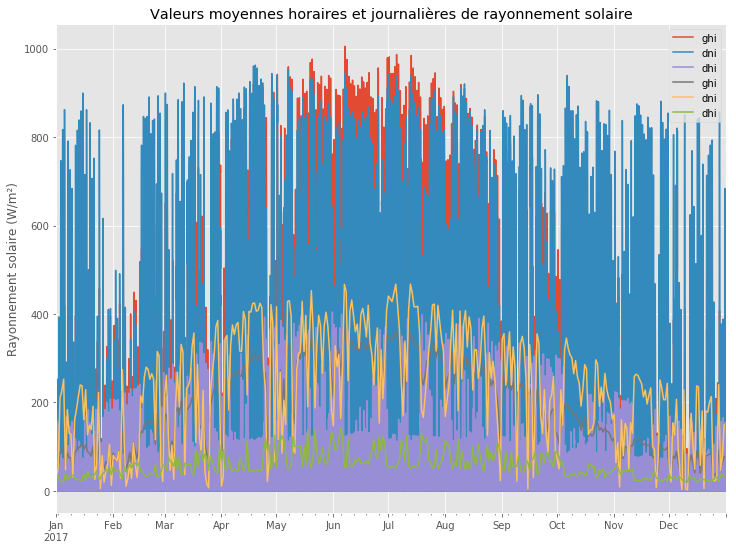

In [110]:
#Observation du rayonnement solaire
df = weather[['ghi','dni','dhi']]['2017']

fig, ax = plt.subplots(sharex = True, sharey = True, figsize = (12,9))
df.resample('H').mean().plot(ax = ax)
df.resample('H').mean().resample('D').mean().plot(ax = ax)
plt.title('Valeurs moyennes horaires et journalières de rayonnement solaire')
plt.ylabel('Rayonnement solaire (W/m²)')

#mpld3.display(fig)

Text(0, 0.5, 'Temperature (°C)')

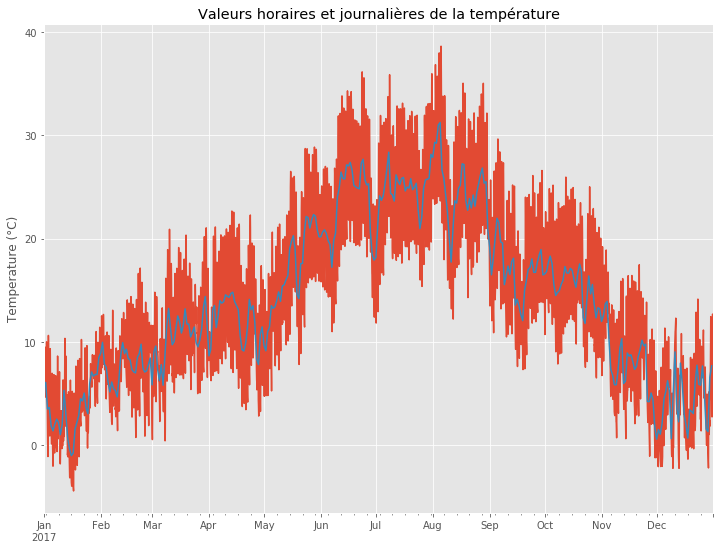

In [611]:
#Observation de la température
df = weather.temp_air['2017']

fig, ax = plt.subplots(sharex = True, sharey = True, figsize = (12,9))
df.resample('H').mean().plot(ax = ax)
df.resample('D').mean().plot(ax = ax)
plt.title('Valeurs horaires et journalières de la température')
plt.ylabel('Temperature (°C)')

#mpld3.display(fig)

Text(0, 0.5, 'Vent (m/s)')

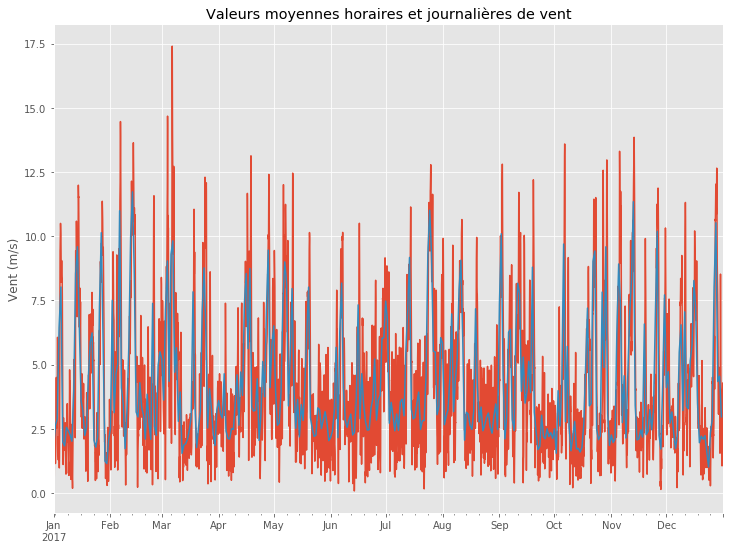

In [612]:
#Observation des données de vent
df = weather.wind_speed['2017']

fig, ax = plt.subplots(sharex = True, sharey = True, figsize = (12,9))
df.resample('H').mean().plot(ax = ax)
df.resample('D').mean().plot(ax = ax)
plt.title('Valeurs moyennes horaires et journalières de vent')
plt.ylabel('Vent (m/s)')

#mpld3.display(fig)

### Irradiation Data

Ressource annuelle GHI (kWh/m²/an):


Text(0, 0.5, 'GHI (kWh/m²/an)')

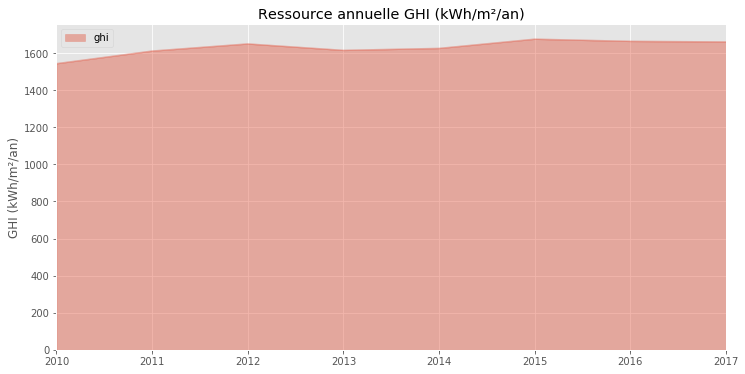

In [613]:
print('Ressource annuelle GHI (kWh/m²/an):')
fig, ax = plt.subplots(figsize = (12, 6))
(weather[['ghi']]['2004':'2017'].resample('h').mean().resample('a').sum()/1e3).plot(kind = 'area', alpha = 0.4, ax = ax)
plt.title('Ressource annuelle GHI (kWh/m²/an)')
plt.ylabel('GHI (kWh/m²/an)')

## Modeling the PV Production

This is where the production function is defined. This function rely on a set of defined parameters that indicate the location, weahter (meteo and irradiation), the orientation, the performance ration (PR), and the degradation rate (DR).

In [111]:
def assessed_PV_productivity(weather, latitude, longitude,
                             inclinaison, azimuth, name, PR = 0.85, altitude = 0,
                                          timezone = 'Europe/Paris', DR = 0.005, lifespan = 30,
                                          tracker = False, gcr = 0.3, backtrack = True, max_angle = 60):
    """
    This function generates the production over the lifespan of the system.
    Aside from the localisation parameters: latitude, longitude, and altitude, 4 important parameters are defined:
    - PR representing the performance ratio and expressed in fraction/percentage
    - DR representing the degradation rate and expressed in fraction/percentage
    - lifespan of the system expressed in years
    - inclinaison and the azimuth representing the orientation expressed in degrees
    - weather which includes the irradiation data
    
    """
    Ppv = 1
    #Localisation
    location = pvlib.location.Location(latitude = latitude, longitude = longitude, altitude = altitude, tz = timezone, name = name)
    
    #Chargement et choix de module polycristallin
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    module = sandia_modules['SolarWorld_Sunmodule_250_Poly__2013_']
    inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
    
    if not(tracker):
        #Orientation des panneaux
        system = pvlib.pvsystem.PVSystem(module_parameters=module,
                                   inverter_parameters=inverter,
                                   modules_per_string=1,
                                   strings_per_inverter=1, 
                                   surface_tilt = inclinaison,
                                   surface_azimuth = azimuth,
                                   racking_model = 'insulated_back_polymerback'
                                   )
    if tracker:
        system = pvlib.tracking.SingleAxisTracker(axis_tilt = 0,axis_azimuth = 180,max_angle = max_angle,backtrack = backtrack,
                                                  gcr = gcr, racking_model = 'insulated_back_polymerback', 
                                                  module_parameters=module,modules_per_string=1,
                                                  inverter_parameters=inverter, strings_per_inverter=1,)

    #Systeme PV
    mc = pvlib.modelchain.ModelChain(system, location)
    
    mc.run_model(times=weather.index, weather=weather)    
    
    df = pd.DataFrame()
    df['P'] = mc.ac / 0.250
    df['I'] = mc.effective_irradiance
    
    df['P'] = df['P']* PR/(df.resample('h').mean().resample('a').sum().P / df.resample('h').mean().resample('a').sum().I).mean()
    df['P'] = df['P']* Ppv / 1e3
    
    prod_year0 = df.resample('H').mean().resample('A').sum().P.mean()
    #Use a degradation rate of 0.5% per year until the end of life (30 years)
    #in a sensitivity analysis, resulting in an average reduction in 
    #the annual yield of 7.5%. 
    prod_lifetime =  prod_year0*((1.0-(1-DR)**(lifespan)))/(1-(1-DR))
    print("For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)")
    
    return [prod_lifetime, prod_lifetime/lifespan]

In [112]:
# def calc_impact_per_kWh(impacts_per_kWp, P, P_module, irradiance, PR, DR, lifespan):
#     prod_year0 = irradiance*((P*1e3*1.6)/P_module)*PR
#     print(prod_year0)
#     prod_lifetime =  prod_year0*lifespan*((1.0-(1-DR)**(lifespan)))/(1-(1-DR))
#     print(prod_lifetime)
#     #per year
#     kWh_per_kWp = (prod_lifetime/(P*lifespan))
#     print(kWh_per_kWp)
#     impacts_per_kWh = impacts_per_kWp / kWh_per_kWp
#     print(impacts_per_kWh)
#     return impacts_per_kWh*1000

In [113]:
prod = assessed_PV_productivity(weather = weather['2017'], latitude = lat, longitude = lon, inclinaison = 30, azimuth = 180, name = 'Antibes_Production', PR = 0.85, altitude = 0, timezone = 'Europe/Paris', DR = 0.005, lifespan = 30, tracker = False, gcr = 0.3, backtrack = True, max_angle = 60) 
print('%s kWh/kWp/lifespan'%prod[0])
print('%s kWh/kWp/year'%prod[1])

For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
46027.608980247765 kWh/kWp/lifespan
1534.2536326749255 kWh/kWp/year


# How to calculate the impact of the whole system?

Finally, in order to calculate the envrionmental performance, the results obtained from Part_2 and expressed in impacts (i.e. kg-CO2 eq) per the system should be divided over the result obtained from the Part_3 and expressed in kWh produced by the system over its lifespan.
Make sure to repsect the chosen lifespan in both Parts.
As a result, this final calculation is expressed in impacts/kWh.

In [750]:
#the impacts of the systems of 30 years lifespan (expressed in kg-CO2-eq)
df_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                        6960.806674            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                          53.506064                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                        7402.758622                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           1.820352                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.002002                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           7.312385                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                          79.050047                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000199                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                         243.257673                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                             0.0024                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000668                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                          25.540794                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           6.906331                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                        7756.660578       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           2.336876

In [757]:
#the production of the system over the 30 years (expressed in kWh)
prod

[46027.608980247765, 1534.2536326749255]

In [760]:
#Hence the environmental performance of the system (expressed in g-CO2-eq/kWh)
env_performance = (7000/(46027.6*3)*1000)
env_performance

50.69422114847035

# B-PUBLICATION RESULTS

In order to get better representation of the contribution analysis results, sankey diagram can be used. After the installation detailed in https://github.com/LCA-ActivityBrowser/activity-browser#contributing, type in the anaconda command:
- conda activate ab
- activity-browser

## Original PV Roof 3 kWp Installation

In [115]:
#the panel chosen is RoW because the market GLO includes only the RoW and CH 
#so to better understand the inventories of the system the RoW is used
panel_RoW = [act for act in eidb if 'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof' in act['name'] and 'RoW' in act['location']][0]
panel_RoW

'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof' (unit, RoW, None)

In [116]:
#Based on Ecoinvent description, the dataset relies on 2005 data
panel_RoW['comment']

'This dataset represents a photovoltaic installation with a capacity of 3kWp and a lifetime of 30 years installed on an average location on the world. The installation consists out of the following infrastructure parts (represented by unit processes in the database):  \n- Panel: multi-Si (mc-Si)  \n- mounted slanted-roof mounting structure   \n- inverse rectifier \n- 3kWp electric installation\n\nAll four main unit processes include the material uses, emissions process energies and dismantling per unit. \nGeography:  Average installation for a global dataset. This dataset has been copied from an original dataset covering the geography Switzerland (CH). The uncertainty has been adjusted accordingly.\nTechnology:  Current technology for mounting of panels or laminates, electric installations and other components. For technical details of the different installation components see  the particular infrastructure datasets. The construction process of mounted slanted-roof installations is the

In [116]:
act = panel_RoW
print(act)

df = pd.DataFrame(index = ['amount','unit','key','type'])
for (i,exc) in enumerate(act.exchanges()):
    df[str(bw.get_activity(exc.input.key))] = [exc.amount, exc.unit, exc.input.key,exc['type']]
df.T

'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof' (unit, RoW, None)


amount  \
'market for photovoltaic mounting system, for s...        22.79   
'market for photovoltaic panel, multi-Si wafer'...      23.4737   
'photovoltaic slanted-roof installation, 3kWp, ...            1   
'market for inverter, 2.5kW' (unit, GLO, None)              2.4   
'market for photovoltaics, electric installatio...            1   
'market for electricity, low voltage' (kilowatt...   0.00227192   
'market for electricity, low voltage' (kilowatt...  0.000435892   
'market for electricity, low voltage' (kilowatt...   0.00962151   
'market group for electricity, low voltage' (ki...    0.0391613   
'market group for electricity, low voltage' (ki...   0.00686145   
'market group for electricity, low voltage' (ki...     0.109595   
'market group for electricity, low voltage' (ki...    0.0132991   
'market group for electricity, low voltage' (ki...    0.0487351   
'market for electricity, low voltage' (kilowatt...  1.86283e-05   

                                                             unit  \
'market for photovoltaic mounting system, for s...   square meter   
'market for photovoltaic panel, multi-Si wafer'...   square meter   
'photovoltaic slanted-roof installation, 3kWp, ...           unit   
'market for inverter, 2.5kW' (unit, GLO, None)               unit   
'market for photovoltaics, electric installatio...           unit   
'market for electricity, low voltage' (kilowatt...  kilowatt hour   
'market for electricity, low voltage' (kilowatt...  kilowatt hour   
'market for electricity, low voltage' (kilowatt...  kilowatt hour   
'market group for electricity, low voltage' (ki...  kilowatt hour   
'market group for electricity, low voltage' (ki...  kilowatt hour   
'market group for electricity, low voltage' (ki...  kilowatt hour   
'market group for electricity, low voltage' (ki...  kilowatt hour   
'market group for electricity, low voltage' (ki...  kilowatt hour   
'market for electricity, low voltage' (kilowatt...  kilowatt hour   

                                                                                                  key  \
'market for photovoltaic mounting system, for s...  (ecoinvent 3.4 cut off, 7ce995e1f24759853ca505...   
'market for photovoltaic panel, multi-Si wafer'...  (ecoinvent 3.4 cut off, 24197bba87b453d82b3dd4...   
'photovoltaic slanted-roof installation, 3kWp, ...  (ecoinvent 3.4 cut off, d6bd7f99518fd4db856ac5...   
'market for inverter, 2.5kW' (unit, GLO, None)      (ecoinvent 3.4 cut off, f4bb73ff12ea973f11bbfe...   
'market for photovoltaics, electric installatio...  (ecoinvent 3.4 cut off, 3f88442540d0e0f0cb6b10...   
'market for electricity, low voltage' (kilowatt...  (ecoinvent 3.4 cut off, a9f449b65099fa4d346660...   
'market for electricity, low voltage' (kilowatt...  (ecoinvent 3.4 cut off, 2b801a5a604d74125cd6a4...   
'market for electricity, low voltage' (kilowatt...  (ecoinvent 3.4 cut off, f3414815c3462907bcb904...   
'market group for electricity, low voltage' (ki...  (ecoinvent 3.4 cut off, 2114d0ab71505029c98b63...   
'market group for electricity, low voltage' (ki...  (ecoinvent 3.4 cut off, aec924b089a087eea85d8a...   
'market group for electricity, low voltage' (ki...  (ecoinvent 3.4 cut off, df10c8e7d027c151156021...   
'market group for electricity, low voltage' (ki...  (ecoinvent 3.4 cut off, f6e3d9695fdc675765ac53...   
'market group for electricity, low voltage' (ki...  (ecoinvent 3.4 cut off, a9b8dafd2ad87ceb795f6c...   
'market for electricity, low voltage' (kilowatt...  (ecoinvent 3.4 cut off, 48cf86068b20660694841d...   

                                                            type  
'market for photovoltaic mounting system, for s...  technosphere  
'market for photovoltaic panel, multi-Si wafer'...  technosphere  
'photovoltaic slanted-roof installation, 3kWp, ...    production  
'market for inverter, 2.5kW' (unit, GLO, None)      technosphere  
'market for photovoltaics, electric installatio...  technosphere  
'market for electricity, low voltage'

In [253]:
#to represent the results using the 2 selected impact categories:
bw.calculation_setups[act['name']] = {'inv': [{panel_RoW:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact 

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                        6960.806674            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                          53.506064                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                        7402.758622                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           1.820352                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.002002                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           7.312385                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                          79.050047                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000199                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                         243.257673                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                             0.0024                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000668                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                          25.540794                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                           6.906331                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                        7756.660578       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           2.336876

In [263]:
6960/3

2320.0

In [258]:
#For an European optimally oriented panel:
#the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
(6960/(1330*30*3))*1000

58.145363408521305

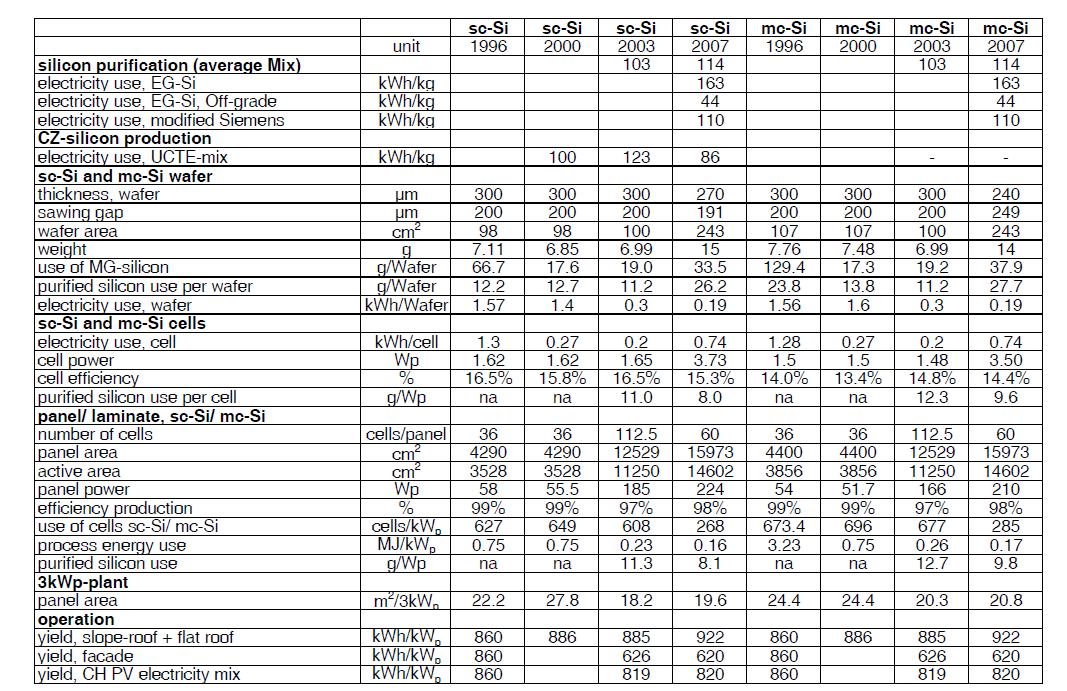

In [120]:
from IPython.display import Image
Image(filename='key_parameters_Ecoinvent_Jungbluth_2008.png', width=800, height=800)

## Adjusted PV Roof 3 kWp Installation Scenariosn

### Simulations

In [311]:
DF_impact = pd.DataFrame(index = methods_no_LT)
DF_impact

Empty DataFrame
Columns: []
Index: [(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication), (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication), (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects), (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation), (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects), (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion), (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation), (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics), (ILCD 1.0.8 2016 midpoint no LT, resources, land use), (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)]

In [312]:
act = [act for act in eidb if 'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof' in act['name'] and act['unit'] =='unit' and 'RoW' in act['location']][0]
print(act)
bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': methods_all}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = methods_all, data = myMultiLCA.results)
DF_impact['Ecoinvent'] = df_impact.T / 3
df_impact /3 

'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof' (unit, RoW, None)


(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
0                                        2320.268891            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
0                                          17.835355                                               

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater ecotoxicity)  \
0                                        2467.586207                             

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater eutrophication)  \
0                                           0.606784                                

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, ionising radiation)  \
0                                           0.000667                         

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, marine eutrophication)  \
0                                           2.437462                            

   (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, terrestrial eutrophication)  \
0                                          26.350016                                 

   (ILCD 1.0.8 2016 midpoint no LT, human health, carcinogenic effects)  \
0                                           0.000066                      

   (ILCD 1.0.8 2016 midpoint no LT, human health, ionising radiation)  \
0                                          81.085891                    

   (ILCD 1.0.8 2016 midpoint no LT, human health, non-carcinogenic effects)  \
0                                             0.0008                          

   (ILCD 1.0.8 2016 midpoint no LT, human health, ozone layer depletion)  \
0                                           0.000223                       

   (ILCD 1.0.8 2016 midpoint no LT, human health, photochemical ozone creation)  \
0                                           8.513598                              

   (ILCD 1.0.8 2016 midpoint no LT, human health, respiratory effects, inorganics)  \
0                                            2.30211                                 

   (ILCD 1.0.8 2016 midpoint no LT, resources, land use)  \
0                                        2585.553526       

   (ILCD 1.0.8 2016 midpoint no LT, resources, mineral, fossils and renewables)  
0                                           0.778959

In [313]:
elec_dataset = elec_dataset_row

In [319]:
P = 3
P_module = 210
elec_dataset = elec_dataset_row
roof = True
DW=False 
kerf_loss = 0.5
share_recycled_aluminium = 0
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = 18.5,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 240, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 110+19.5,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0, 
                                         TEG_recycled_share = 0,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['3 kW PV system, 210 Wp panel'] = df_impact.T / 3
DF_impact

3kWc_210Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 210.00000000000003 Wp
Module efficiency: 13.125 percent
Surface occupied: 22.857142857142854 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 18.5 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696

In [320]:
P = 3
P_module = 280
elec_dataset = elec_dataset_row
roof = True
DW=False 
kerf_loss = 0.5
share_recycled_aluminium = 0
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = 18.5,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 240, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 110+19.5,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0, 
                                         TEG_recycled_share = 0,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)'] = df_impact.T / 3
DF_impact

3kWc_280Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 279.99999999999994 Wp
Module efficiency: 17.5 percent
Surface occupied: 17.14285714285715 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 18.5 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                          

In [321]:
P = 3
P_module = 280
elec_dataset = elec_dataset_row
roof = True
DW=False 
kerf_loss = 0.5
share_recycled_aluminium = 0
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = 18.5,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 240, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0, 
                                         TEG_recycled_share = 0,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['+ Fluidized Bed Reactor (FBR) process'] = df_impact.T / 3
DF_impact

3kWc_280Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 279.99999999999994 Wp
Module efficiency: 17.5 percent
Surface occupied: 17.14285714285715 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 18.5 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [322]:
P = 3
P_module = 280
elec_dataset = elec_dataset_row
roof = True
DW=False 
kerf_loss = 0.5
share_recycled_aluminium = 0
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = 18.5,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0, 
                                         TEG_recycled_share = 0,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['+ Thinner wafer'] = df_impact.T / 3
DF_impact

3kWc_280Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 279.99999999999994 Wp
Module efficiency: 17.5 percent
Surface occupied: 17.14285714285715 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 18.5 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [323]:
P = 3
P_module = 280
elec_dataset = elec_dataset_row
roof = True
DW=False 
kerf_loss = 0.5
share_recycled_aluminium = 0
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = 18.5,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['+ Secondary SiC (69%) and TEG (89%)'] = df_impact.T / 3
DF_impact

3kWc_280Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 279.99999999999994 Wp
Module efficiency: 17.5 percent
Surface occupied: 17.14285714285715 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 18.5 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [324]:
P = 3
P_module = 280
elec_dataset = elec_dataset_row
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = 18.5,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['+ DW cutting process \nand reduced kerf loss'] = df_impact.T / 3
DF_impact

3kWc_280Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 279.99999999999994 Wp
Module efficiency: 17.5 percent
Surface occupied: 17.14285714285715 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 18.5 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [325]:
P = 3
P_module = 280
elec_dataset = elec_dataset_row
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0.27
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = 18.5,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['+ Secondary aluminum'] = df_impact.T / 3
DF_impact

3kWc_280Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 279.99999999999994 Wp
Module efficiency: 17.5 percent
Surface occupied: 17.14285714285715 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 18.5 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [342]:
P = 3
P_module = 280
elec_dataset = elec_dataset_row
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0.27
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = None,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['+ Adjusted inverter dataset'] = df_impact.T / 3
DF_impact

3kWc_280Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 279.99999999999994 Wp
Module efficiency: 17.5 percent
Surface occupied: 17.14285714285715 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 6 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [343]:
P = 3
P_module = 320 #corresponding to 20% efficiency
elec_dataset = elec_dataset_row
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0.27
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = None,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)

DF_impact['+ Better panel efficiency of 20%'] = df_impact.T / 3
DF_impact

3kWc_320Wc_roofTrue_Europe_2018
System power: 3 kWp
PV module power: 320.00000000000006 Wp
Module efficiency: 20.0 percent
Surface occupied: 14.999999999999998 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 33.0 kg
Inverter weight: 6 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [346]:
P = 30
P_module = 320 #corresponding to 20% efficiency
elec_dataset = elec_dataset_row
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0.27
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = None,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact/P

DF_impact['+ 30 kWp system'] = df_impact.T / P
DF_impact

30kWc_320Wc_roofTrue_Europe_2018
System power: 30 kWp
PV module power: 320.00000000000006 Wp
Module efficiency: 20.0 percent
Surface occupied: 149.99999999999997 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 106.19047619047619 kg
Inverter weight: 60 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [348]:
elec_dataset_eu = [act for act in eidb if 'market group for electricity, medium voltage' == act['name'] and 'ENTSO-E' == act['location']][0]
elec_dataset_eu

'market group for electricity, medium voltage' (kilowatt hour, ENTSO-E, None)

In [349]:
P = 30
P_module = 320 #corresponding to 20% efficiency
elec_dataset = elec_dataset_eu
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0.27
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = None,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact/P

DF_impact['+ EU electricity mix'] = df_impact.T / P
DF_impact

30kWc_320Wc_roofTrue_Europe_2018
System power: 30 kWp
PV module power: 320.00000000000006 Wp
Module efficiency: 20.0 percent
Surface occupied: 149.99999999999997 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 106.19047619047619 kg
Inverter weight: 60 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [374]:
elec_dataset_fr = [act for act in eidb if 'market for electricity, medium voltage' == act['name'] and 'FR' == act['location']][0]
elec_dataset_fr

'market for electricity, medium voltage' (kilowatt hour, FR, None)

In [375]:
P = 30
P_module = 320 #corresponding to 20% efficiency
elec_dataset = elec_dataset_fr
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0.27
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = None,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact/P

DF_impact['+ Low carbon (FR) electricity mix'] = df_impact.T / P
DF_impact

30kWc_320Wc_roofTrue_Europe_2018
System power: 30 kWp
PV module power: 320.00000000000006 Wp
Module efficiency: 20.0 percent
Surface occupied: 149.99999999999997 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 106.19047619047619 kg
Inverter weight: 60 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [378]:
elec_nw = [act for act in eidb if 'market for electricity, medium voltage' == act['name'] and 'NO' == act['location']][0]
elec_nw

'market for electricity, medium voltage' (kilowatt hour, NO, None)

In [380]:
P = 30
P_module = 320 #corresponding to 20% efficiency
elec_dataset = elec_nw
roof = True
DW= True 
kerf_loss = 0.5-0.15
share_recycled_aluminium = 0.27
manufacturing_efficiency_gains = 0
mLCA_name = '%skWc_%sWc_roof%s_Europe_2018'%(P,P_module,roof)
print(mLCA_name)
system_inv = create_dictionary_PV_system(P = P,
                                         P_module = P_module, 
                                         module_efficiency = None, 
                                         roof = roof,
                                         share_recycled_aluminium = share_recycled_aluminium, 
                                         elec_dataset = elec_dataset,
                                         inverter_weight = None,  
                                         print_steps = True, 
                                         inverter_lifetime = 12.5, 
                                         PV_lifetime = 30, 
                                         glass_thickness = 4, 
                                         manufacturing_efficiency_gains = 0,
                                         kerf_loss = kerf_loss,
                                         wafer_thickness = 200, 
                                         silver_amount = 11.2, 
                                         Silicon_electricity_intensity = 30+10,
                                         d_lorry = 0, 
                                         d_train = 0, 
                                         d_sea = 0,
                                         recycling_rate_alu = 0, 
                                         recycling_rate_cu = 0, 
                                         recycling_rate_glass = 0,
                                         recycling_rate = 0,
                                         electricity_recycling = 0, 
                                         heat_recycling = 0,
                                         SiC_recycled_share=0.694, 
                                         TEG_recycled_share = 0.899,
                                         DW=DW)

act = generate_PV_system_dataset(system_inv)
act = [act for act in eidb if 'photovoltaic installation, adjusted' == act['name']][0]

bw.calculation_setups[act['name']] = {'inv': [{act:1}], 'ia': list_methods}
myMultiLCA = bw.MultiLCA(act['name'])
df_impact = pd.DataFrame(columns = list_methods, data = myMultiLCA.results)
df_impact/P

DF_impact['+ Low carbon (NO) electricity mix'] = df_impact.T / P
DF_impact

30kWc_320Wc_roofTrue_Europe_2018
System power: 30 kWp
PV module power: 320.00000000000006 Wp
Module efficiency: 20.0 percent
Surface occupied: 149.99999999999997 m²
Creating aluminium dataset
Creating mounting system dataset
Electrical installation weight: 106.19047619047619 kg
Inverter weight: 60 kg
Creating panel production processes
Changing cell production process
Changing metallization processes
Front silver amount: 6.870315789473684 g/m²
Back silver amount: 3.6285789473684207 g/m²
Copper amount: 0.0 g/m²
Changing electricity processes
Changing Silicon processes
Changing wafer processes
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
Adding transport activities


Ecoinvent  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  2320.268891   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    17.835355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2467.586207   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.606784   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.000667   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     2.437462   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    26.350016   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000066   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    81.085891   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000800   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000223   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     8.513598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     2.302110   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  2585.553526   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     0.778959   

                                                    3 kW PV system, 210 Wp panel  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                   2329.096342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     19.496663   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                   2391.695190   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.639147   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      0.000885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                      2.589085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                     27.830171   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000056   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                    106.099155   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      0.000233   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      8.996045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                      2.187878   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...                   2655.781660   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...                      0.998696   

                                                    3 kW PV system, 280 Wp panel \n(better panel efficiency of 17.5%)  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...                                        1814.380024                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          15.996191                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                        2011.559361                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.579542                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           0.000684                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                           2.042919                   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...                                          22.128601                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000045                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                          82.120253                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000683                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           0.000180                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...                                           7.141133                   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...             

In [381]:
DF_impact.to_pickle('FINAL_PV_IMPACT/Full_model_results.pkl')

### Visualization

In [390]:
DF_impact = pd.read_pickle('FINAL_PV_IMPACT/Full_model_results.pkl')

In [392]:
DF_impact = DF_impact.T
DF_impact
DF_impact = DF_impact.sort_values(by = DF_impact.columns[0], ascending= True)
DF_impact

(ILCD 1.0.8 2016 midpoint no LT, climate change, GWP 100a)  \
+ Low carbon (NO) electricity mix                                                          678.378882            
+ Low carbon (FR) electricity mix                                                          684.848104            
+ EU electricity mix                                                                       836.328304            
+ 30 kWp system                                                                            927.383312            
+ Better panel efficiency of 20%                                                           979.444436            
+ Adjusted inverter dataset                                                               1098.458425            
+ Secondary aluminum                                                                      1217.845299            
+ DW cutting process \nand reduced kerf loss                                              1234.885829            
+ Secondary SiC (69%) and TEG (89%)                                                       1324.596206            
+ Thinner wafer                                                                           1393.066229            
+ Fluidized Bed Reactor (FBR) process                                                     1446.249739            
3 kW PV system, 280 Wp panel \n(better panel ef...                                        1814.380024            
Ecoinvent                                                                                 2320.268891            
3 kW PV system, 210 Wp panel                                                              2329.096342            

                                                    (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, freshwater and terrestrial acidification)  \
+ Low carbon (NO) electricity mix                                                            5.069073                                               
+ Low carbon (FR) electricity mix                                                            5.151854                                               
+ EU electricity mix                                                                         6.142866                                               
+ 30 kWp system                                                                              7.163683                                               
+ Better panel efficiency of 20%                                                             8.749799                                               
+ Adjusted inverter dataset                                                                  9.523814                                               
+ Secondary aluminum                                                                        11.684207                                               
+ DW cutting process \nand reduced kerf loss                                                11.806463                                               
+ Secondary SiC (69%) and TEG (89%)                                                         12.338809                                               
+ Thinner wafer                                                                             12.713893                                               
+ Fluidized Bed Reactor (FBR) process                                                       13.040591                                               
3 kW PV system, 280 Wp panel \n(better panel ef...                                          15.996191                                               
Ecoinvent                                                                                   17.835355                                               
3 kW PV system, 210 Wp panel                                                                19.496663                                               

                                                    (ILCD 1.0.8 2016 midpoint no LT, ecosystem quality, f

In [419]:
A = (DF_impact/ (30*1300))
A.columns = [m[1:] for m in A.columns] 
A

(climate change, GWP 100a)  \
+ Low carbon (NO) electricity mix                                     0.017394   
+ Low carbon (FR) electricity mix                                     0.017560   
+ EU electricity mix                                                  0.021444   
+ 30 kWp system                                                       0.023779   
+ Better panel efficiency of 20%                                      0.025114   
+ Adjusted inverter dataset                                           0.028166   
+ Secondary aluminum                                                  0.031227   
+ DW cutting process \nand reduced kerf loss                          0.031664   
+ Secondary SiC (69%) and TEG (89%)                                   0.033964   
+ Thinner wafer                                                       0.035720   
+ Fluidized Bed Reactor (FBR) process                                 0.037083   
3 kW PV system, 280 Wp panel \n(better panel ef...                    0.046523   
Ecoinvent                                                             0.059494   
3 kW PV system, 210 Wp panel                                          0.059720   

                                                    (ecosystem quality, freshwater and terrestrial acidification)  \
+ Low carbon (NO) electricity mix                                                            0.000130               
+ Low carbon (FR) electricity mix                                                            0.000132               
+ EU electricity mix                                                                         0.000158               
+ 30 kWp system                                                                              0.000184               
+ Better panel efficiency of 20%                                                             0.000224               
+ Adjusted inverter dataset                                                                  0.000244               
+ Secondary aluminum                                                                         0.000300               
+ DW cutting process \nand reduced kerf loss                                                 0.000303               
+ Secondary SiC (69%) and TEG (89%)                                                          0.000316               
+ Thinner wafer                                                                              0.000326               
+ Fluidized Bed Reactor (FBR) process                                                        0.000334               
3 kW PV system, 280 Wp panel \n(better panel ef...                                           0.000410               
Ecoinvent                                                                                    0.000457               
3 kW PV system, 210 Wp panel                                                                 0.000500               

                                                    (ecosystem quality, freshwater ecotoxicity)  \
+ Low carbon (NO) electricity mix                                                      0.027446   
+ Low carbon (FR) electricity mix                                                      0.027630   
+ EU electricity mix                                                                   0.028314   
+ 30 kWp system                                                                        0.028960   
+ Better panel efficiency of 20%                                                       0.035318   
+ Adjusted inverter dataset                                                            0.038451   
+ Secondary aluminum                                                                   0.047410   
+ DW cutting process \nand reduced kerf loss                                           0.047893   
+ Secondary SiC (69%) and TEG (89%)                                                    0.048412   
+ Thinner wafer                                                            

In [129]:
ILCD_methods_unit = [bw.Method(m).metadata['unit'] for m in methods_no_LT]
ILCD_methods_unit

['kg CO2-Eq',
 'mol H+-Eq',
 'CTUh.m3.yr',
 'kg P-Eq',
 'mol N-Eq',
 'kg N-Eq',
 'mol N-Eq',
 'CTUh',
 'kg U235-Eq',
 'CTUh',
 'kg CFC-11.',
 'kg ethyle.',
 'kg PM2.5-.',
 'kg Soil O.',
 'kg Sb-Eq']

In [426]:
ax[0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F8F617BB00>,
      dtype=object)

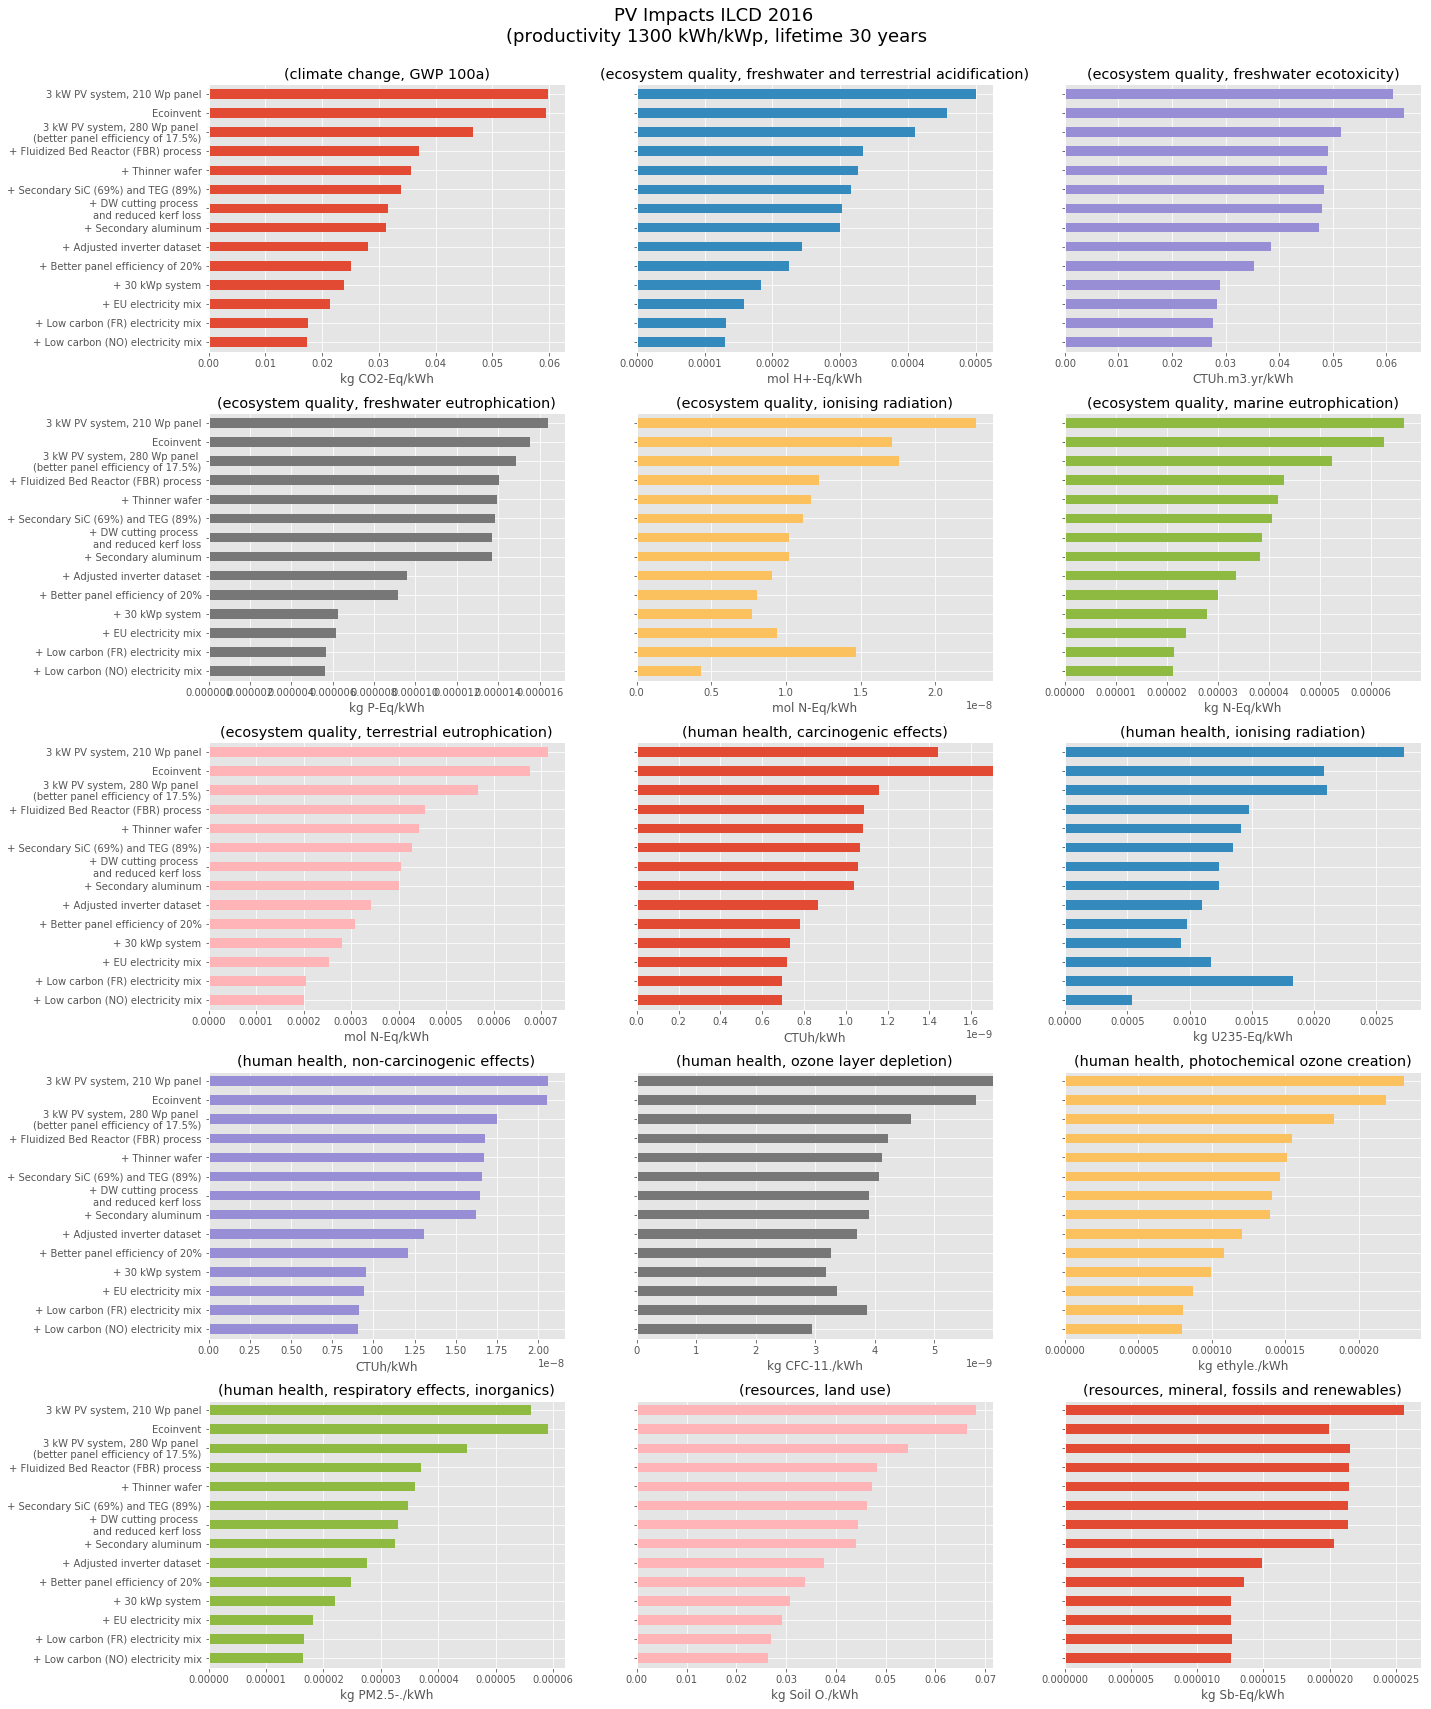

In [455]:
fig, ax = plt.subplots(nrows =5,ncols=3, figsize = (20,23))
A.plot(ax = ax,                           
        kind = 'barh', 
        subplots = True, 
        label = False, 
        legend = False, 
        sharey = True)
#plt.legend(bbox_to_anchor=(0.5, -0.05))
fig.suptitle('PV Impacts ILCD 2016 \n(productivity 1300 kWh/kWp, lifetime 30 years',
             fontsize = 18, y=1.03)
for j,axj in enumerate(ax):
    for i,axi in enumerate(axj):
        axi.set_xlabel('%s/kWh'%ILCD_methods_unit[3*j+i])
plt.tight_layout()

## Once-At-a-Time (OAT) Results

In [216]:
ILCD_methods_unit = [bw.Method(m).metadata['unit'] for m in methods_no_LT]
ILCD_methods_unit

['kg CO2-Eq',
 'mol H+-Eq',
 'CTUh.m3.yr',
 'kg P-Eq',
 'mol N-Eq',
 'kg N-Eq',
 'mol N-Eq',
 'CTUh',
 'kg U235-Eq',
 'CTUh',
 'kg CFC-11.',
 'kg ethyle.',
 'kg PM2.5-.',
 'kg Soil O.',
 'kg Sb-Eq']

###  System Power

In [219]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in [3, 10, 36, 500, 3000]:
    print(i)
    system_inv = create_dictionary_PV_system(P = i,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = elec_dataset_row,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_system_power.pkl')
DF_impact

3
10
36
500
3000


3             10    \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  4961.385715  16124.893718   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    30.785665     90.368881   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4584.068999  13324.005720   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     1.085904      2.743776   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     0.001227      0.003984   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     4.411875     14.030367   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    45.650802    143.518412   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000104      0.000333   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...   150.490318    487.524850   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.001528      0.004338   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     0.000634      0.002081   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    15.884085     50.265202   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     3.408337     10.520982   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  4981.952515  15706.681035   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     1.651800      5.239865   

                                                            36    \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  57573.340537   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    310.741112   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  45795.698466   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      8.822428   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.014208   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     49.676626   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    506.038312   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.001180   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...   1737.435289   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.014719   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.007459   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    177.688355   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     36.851708   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  55447.201179   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     18.434056   

                                                             500   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  783203.852582   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    3986.909705   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  627431.144159   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      96.306057   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...       0.191726   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     662.468616   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    6688.328596   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...       0.015835   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...   23462.014227   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...       0.185640   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...       0.102595   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    2369.506947   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     483.053378   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  737243.876595   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...     218.671717   

                                                            3000  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  4.703017e+06  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.389936e+04  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.760519e+06  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  5.759831e+02  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.150372e+00  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.974459e+03  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.012370e+04  
(ILCD 1.0.8 2016 midpoint no LT,

In [220]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_system_power.pkl')
df_impact = df_impact.T
df_impact.index.name = 'System power'

In [221]:
df_impact_kW = df_impact[methods_no_LT].divide(df_impact.index.values, axis = 0)
df_impact_kW.columns = [m[2] for m in df_impact_kW.columns]

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the size of the PV installation')

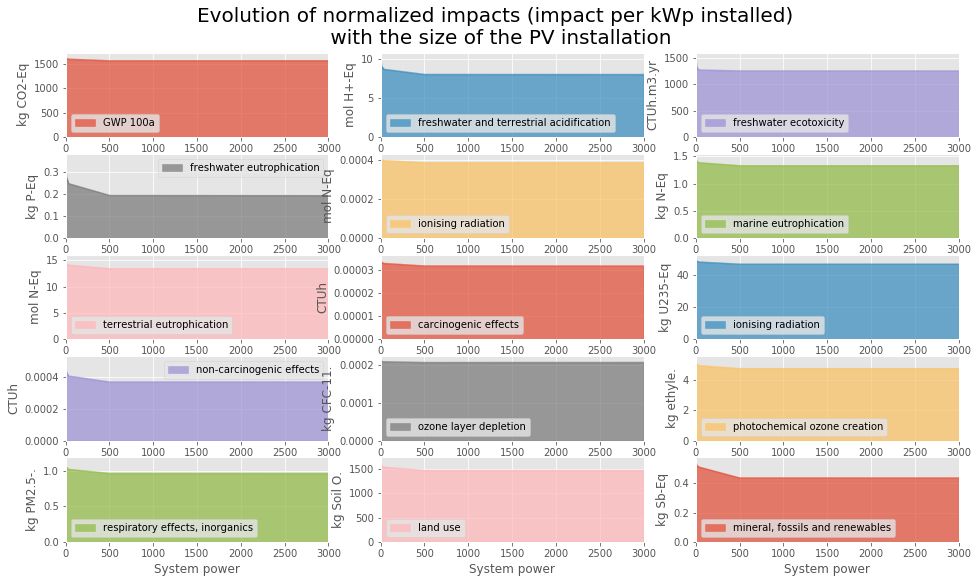

In [222]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact_kW.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel('%s'%ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the size of the PV installation', y = 0.95, fontsize = 20)
#plt.tight_layout()

In [223]:
df_RC = pd.DataFrame(index = df_impact_kW.columns)

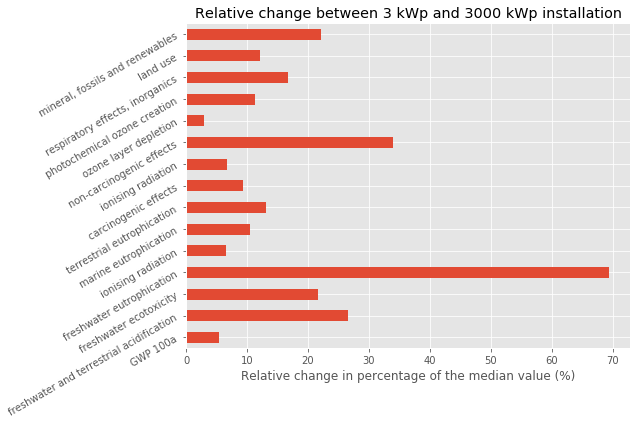

In [224]:
df = (df_impact_kW.max() - df_impact_kW.min())/df_impact_kW.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change between 3 kWp and 3000 kWp installation')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Panel Efficiency

#### Panel Rated Power Parameter

The panel efficiency can be monitored either by 'P_module' parameter or by 'module efficiency' parameter since these two parameters are interlinked with the panel surface. Therefore they can be used interchangeably.

In [225]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(150, 350, 10):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = i, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = elec_dataset_row,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_panel_power.pkl')
DF_impact

150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


150  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  29492.697902   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    151.997539   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  22273.114196   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      3.901989   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007229   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     25.057417   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    253.714475   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000588   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    884.296748   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.007097   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.003851   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     89.424424   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     18.349840   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  27897.844695   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      8.876552   

                                                             160  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  27729.061446   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    143.731953   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  21069.386841   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      3.746152   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006794   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     23.581307   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    238.973131   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000554   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    831.139105   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.006725   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.003617   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     84.184002   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     17.297669   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  26265.714058   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      8.387029   

                                                             170  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  26172.911631   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    136.438789   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  20007.274470   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      3.608648   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006411   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     22.278857   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    225.966062   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000524   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    784.235303   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.006398   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.003411   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     79.560100   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     16.369283   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  24825.598791   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      7.955096   

                                                             180  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  24789.667352   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    129.955977   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  19063.174584   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      3.486423   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006069   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     21.121124   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    214.404224   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000497   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    742.543035   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.006107   
(ILCD 1.0.8 2016 midpoint no LT, human health,

In [226]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_panel_power.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Panel efficiency'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Panel efficiency                                                          
150               2949.269790                                 15.199754   
160               2772.906145                                 14.373195   
170               2617.291163                                 13.643879   
180               2478.966735                                 12.995598   
190               2355.202773                                 12.415557   
200               2243.815208                                 11.893520   
210               2143.035982                                 11.421200   
220               2051.418503                                 10.991819   
230               1967.767762                                 10.599776   
240               1891.087916                                 10.240402   
250               1820.542458                                  9.909779   
260               1755.423573                                  9.604588   
270               1695.128310                                  9.322004   
280               1639.139851                                  9.059604   
290               1587.012665                                  8.815301   
300               1538.360625                                  8.587285   
310               1492.847426                                  8.373980   
320               1450.178802                                  8.174006   
330               1410.096155                                  7.986152   
340               1372.371311                                  7.809348   

                  freshwater ecotoxicity  freshwater eutrophication  \
Panel efficiency                                                      
150                          2227.311420                   0.390199   
160                          2106.938684                   0.374615   
170                          2000.727447                   0.360865   
180                          1906.317458                   0.348642   
190                          1821.845363                   0.337706   
200                          1745.820478                   0.327864   
210                          1677.036058                   0.318959   
220                          1614.504766                   0.310863   
230                          1557.410979                   0.303472   
240                          1505.075007                   0.296696   
250                          1456.925913                   0.290463   
260                          1412.480595                   0.284709   
270                          1371.327523                   0.279381   
280                          1333.113956                   0.274434   
290                          1297.535808                   0.269828   
300                          1264.329536                   0.265529   
310                          1233.265604                   0.261507   
320                          1204.143168                   0.257737   
330                          1176.785729                   0.254195   
340                          1151.037550                   0.250862   

                  ionising radiation  marine eutrophication  \
Panel efficiency                                              
150                         0.000723               2.505742   
160                         0.000679               2.358131   
170                         0.000641               2.227886   
180                         0.000607               2.112112   
190                         0.000576               2.008526   
200                         0.000549               1.915298   
210                         0.000524               1.830949   
220                         0.000501               1.754268   
230                         0.000481               1.684254   
240                         0.000462               1.620076   
250                         0.000445               

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the nominal power of PV modules')

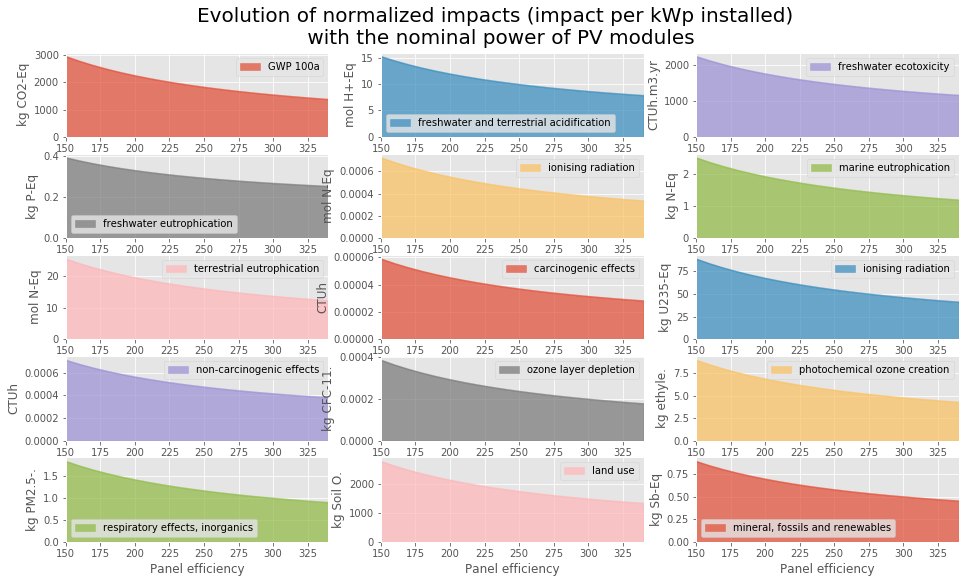

In [227]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the nominal power of PV modules', y = 0.95, fontsize = 20)
#plt.tight_layout()

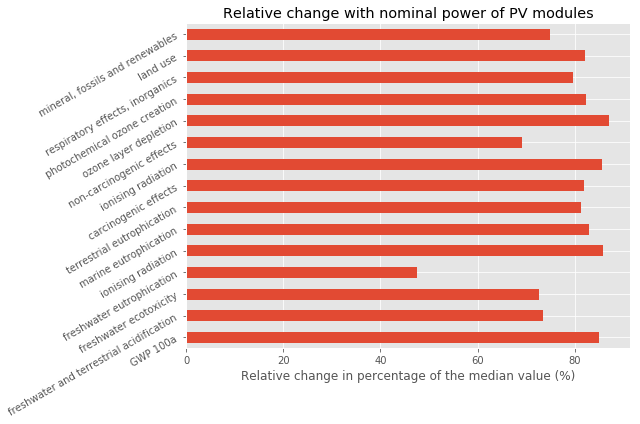

In [228]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with nominal power of PV modules')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

#### Or Panel Efficiency Parameter

The panel efficiency can be monitored either by 'P_module' parameter or by 'module efficiency' parameter since these two parameters are interlinked with the panel surface. Therefore they can be used interchangeably

In [229]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.15, 0.22, 0.01):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = None, #should be None
                                             module_efficiency = i, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = elec_dataset_row,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_panel_efficiency.pkl')
DF_impact

0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006


0.15  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  19112.064153   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    102.575510   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  15056.135423   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.967389   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.004630   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     16.247306   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    165.786489   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000382   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    566.775058   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004871   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002474   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     58.155798   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     12.046426   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  18155.461636   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.939578   

                                                            0.16  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  17986.929437   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     97.390031   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  14303.193855   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.869942   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.004357   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     15.319448   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    156.514049   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000361   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    533.389694   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004639   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002325   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     54.860772   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     11.387727   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  17129.652629   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.633606   

                                                            0.17  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  16994.163511   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     92.814609   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13638.833647   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.783960   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.004116   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     14.500749   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    148.332485   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000342   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    503.932021   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004434   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002193   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     51.953396   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     10.806522   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  16224.527034   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.363631   

                                                            0.18  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  16111.704910   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     88.747568   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13048.291241   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.707531   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.003902   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     13.773017   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    141.059983   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000325   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    477.747422   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004252   
(ILCD 1.0.8 2016 midpoint no LT, human health

In [230]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_panel_efficiency.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Panel efficieny 2'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Panel efficieny 2                                                          
0.15               1911.206415                                 10.257551   
0.16               1798.692944                                  9.739003   
0.17               1699.416351                                  9.281461   
0.18               1611.170491                                  8.874757   
0.19               1532.213669                                  8.510864   
0.20               1461.152529                                  8.183360   
0.21               1396.859117                                  7.887047   
0.22               1338.410560                                  7.617671   

                   freshwater ecotoxicity  freshwater eutrophication  \
Panel efficieny 2                                                      
0.15                          1505.613542                   0.296739   
0.16                          1430.319385                   0.286994   
0.17                          1363.883365                   0.278396   
0.18                          1304.829124                   0.270753   
0.19                          1251.991119                   0.263915   
0.20                          1204.436915                   0.257760   
0.21                          1161.411682                   0.252192   
0.22                          1122.297835                   0.247130   

                   ionising radiation  marine eutrophication  \
Panel efficieny 2                                              
0.15                         0.000463               1.624731   
0.16                         0.000436               1.531945   
0.17                         0.000412               1.450075   
0.18                         0.000390               1.377302   
0.19                         0.000371               1.312189   
0.20                         0.000354               1.253587   
0.21                         0.000338               1.200567   
0.22                         0.000324               1.152366   

                   terrestrial eutrophication  carcinogenic effects  \
Panel efficieny 2                                                     
0.15                                16.578649              0.000038   
0.16                                15.651405              0.000036   
0.17                                14.833248              0.000034   
0.18                                14.105998              0.000033   
0.19                                13.455301              0.000031   
0.20                                12.869673              0.000030   
0.21                                12.339819              0.000028   
0.22                                11.858134              0.000027   

                   ionising radiation  non-carcinogenic effects  \
Panel efficieny 2                                                 
0.15                        56.677506                  0.000487   
0.16                        53.338969                  0.000464   
0.17                        50.393202                  0.000443   
0.18                        47.774742                  0.000425   
0.19                        45.431910                  0.000409   
0.20                        43.323360                  0.000394   
0.21                        41.415625                  0.000381   
0.22                        39.681321                  0.000369   

                   ozone layer depletion  photochemical ozone creation  \
Panel efficieny 2                                                        
0.15                            0.000247                      5.815580   
0.16                            0.000232                      5.486077   
0.17                            0.000219                      5.195340   
0.18                            0.000208                      4.936906   
0.19                            0.000197                      4.705676   

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the nominal power of PV modules')

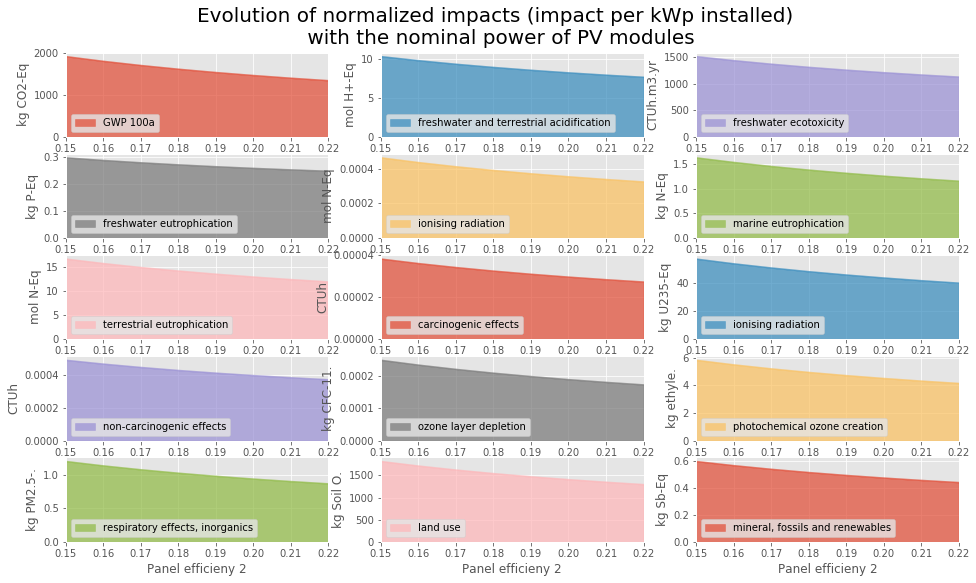

In [231]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the nominal power of PV modules', y = 0.95, fontsize = 20)
#plt.tight_layout()

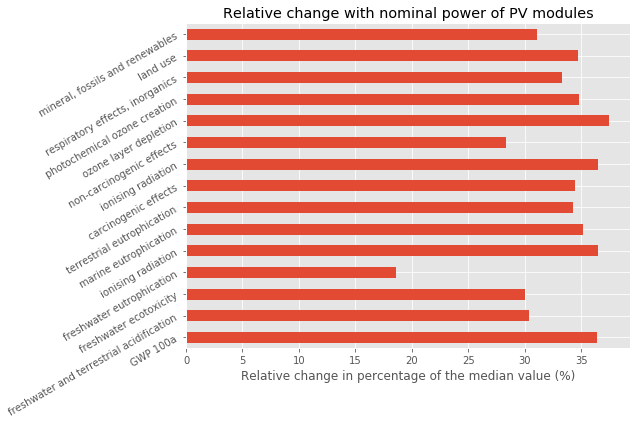

In [232]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with nominal power of PV modules')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### Roof

In [233]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in [True, False]:
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = i,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = elec_dataset_row,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_roof_ground.pkl')
DF_impact

True
False


True          False
(ILCD 1.0.8 2016 midpoint no LT, climate change...  16626.549798  1.804639e+04
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     90.796482  1.011376e+02
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13337.434132  1.599654e+04
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.744836  2.857029e+00
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.004010  4.269285e-03
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     14.146436  1.552714e+01
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    144.815232  1.695385e+02
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000333  4.864500e-04
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    491.076012  5.236958e+02
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004341  5.224678e-03
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002144  2.224114e-03
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     50.698842  5.597242e+01
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     10.544947  1.210571e+01
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  15832.355660  2.090503e+06
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.240287  9.000246e+00

In [234]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_roof_ground.pkl')
df_impact = df_impact.T

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact.index = ['Roof','Ground']
df_impact = df_impact / 10
df_impact.index.name = 'Roof / Ground'
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Roof / Ground                                                          
Roof           1662.654980                                  9.079648   
Ground         1804.639499                                 10.113761   

               freshwater ecotoxicity  freshwater eutrophication  \
Roof / Ground                                                      
Roof                      1333.743413                   0.274484   
Ground                    1599.653747                   0.285703   

               ionising radiation  marine eutrophication  \
Roof / Ground                                              
Roof                     0.000401               1.414644   
Ground                   0.000427               1.552714   

               terrestrial eutrophication  carcinogenic effects  \
Roof / Ground                                                     
Roof                            14.481523              0.000033   
Ground                          16.953854              0.000049   

               ionising radiation  non-carcinogenic effects  \
Roof / Ground                                                 
Roof                    49.107601                  0.000434   
Ground                  52.369582                  0.000522   

               ozone layer depletion  photochemical ozone creation  \
Roof / Ground                                                        
Roof                        0.000214                      5.069884   
Ground                      0.000222                      5.597242   

               respiratory effects, inorganics       land use  \
Roof / Ground                                                   
Roof                                  1.054495    1583.235566   
Ground                                1.210571  209050.330161   

               mineral, fossils and renewables  
Roof / Ground                                   
Roof                                  0.524029  
Ground                                0.900025

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the type of installation')

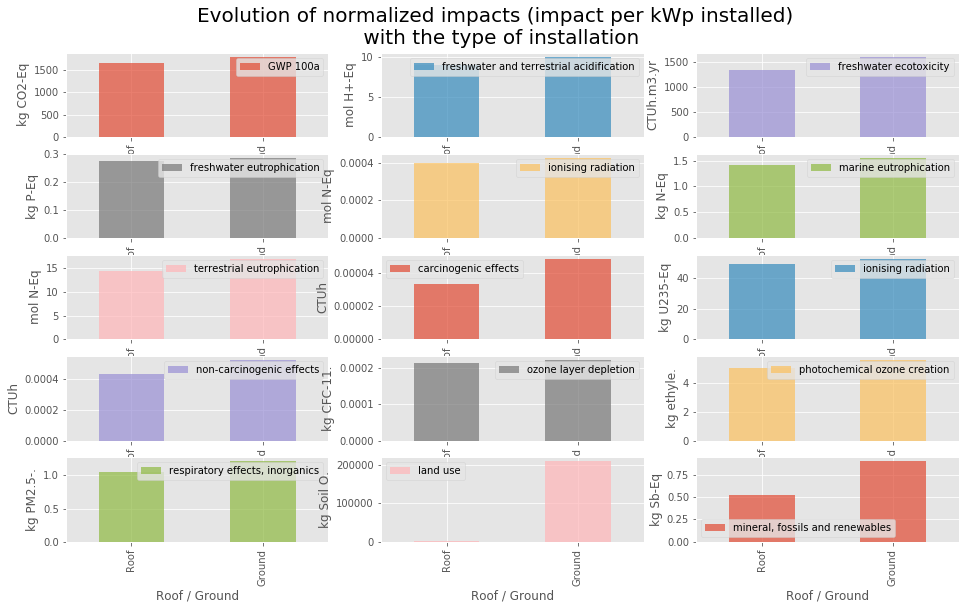

In [235]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'bar', alpha = 0.7, legend= True)
plt.legend(loc = 3)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
        axj.set_title('')
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the type of installation', y = 0.95, fontsize = 20)
#plt.tight_layout()

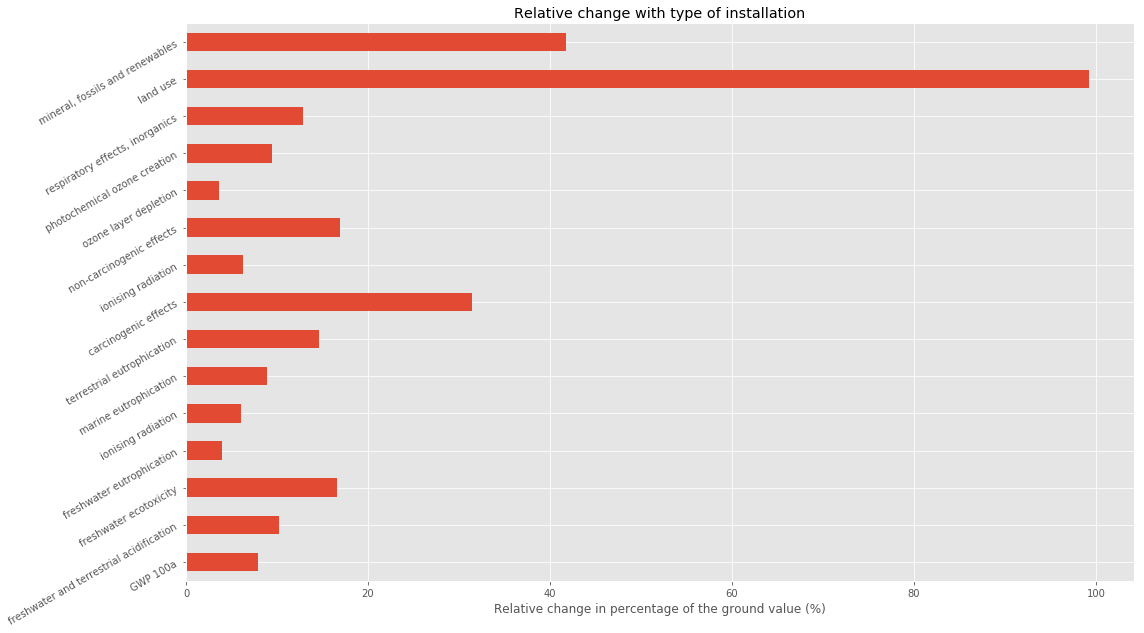

In [236]:
df = (df_impact.max() - df_impact.min())/df_impact.loc['Ground'] * 100
fig, ax = plt.subplots(figsize = (16, 9))
plt.title('Relative change with type of installation')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the ground value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### Share of Recycled Aluminum

In [237]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in [0, 1.1,0.3]:
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = i, 
                                             elec_dataset = elec_dataset_row,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_Aluminium_roof.pkl')
DF_impact

0
1.1
0.3


0.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  16846.033274   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     92.072234   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13529.945788   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.754997   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.004031   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     14.316635   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    146.748680   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000341   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    493.675390   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004428   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002154   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     51.232759   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     10.724950   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  16002.899656   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.658937   

                                                             1.1           0.3  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  16095.254497  16668.353449  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     86.996967     90.711151  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12749.477858  13317.815723  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.713901      2.743846  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.003956      0.004012  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     13.656414     14.142840  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    139.242403    144.771512  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000310      0.000333  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    484.100535    491.255748  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004074      0.004332  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002130      0.002151  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     49.181511     50.696734  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      9.998458     10.528109  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  15344.018518  15829.988371  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      3.953445      5.193825

In [238]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_Aluminium_roof.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Recycled share of aluminum'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  \
Recycled share of aluminum                
0.0                         1684.603327   
1.1                         1609.525450   
0.3                         1666.835345   

                            freshwater and terrestrial acidification  \
Recycled share of aluminum                                             
0.0                                                         9.207223   
1.1                                                         8.699697   
0.3                                                         9.071115   

                            freshwater ecotoxicity  freshwater eutrophication  \
Recycled share of aluminum                                                      
0.0                                    1352.994579                   0.275500   
1.1                                    1274.947786                   0.271390   
0.3                                    1331.781572                   0.274385   

                            ionising radiation  marine eutrophication  \
Recycled share of aluminum                                              
0.0                                   0.000403               1.431664   
1.1                                   0.000396               1.365641   
0.3                                   0.000401               1.414284   

                            terrestrial eutrophication  carcinogenic effects  \
Recycled share of aluminum                                                     
0.0                                          14.674868              0.000034   
1.1                                          13.924240              0.000031   
0.3                                          14.477151              0.000033   

                            ionising radiation  non-carcinogenic effects  \
Recycled share of aluminum                                                 
0.0                                  49.367539                  0.000443   
1.1                                  48.410053                  0.000407   
0.3                                  49.125575                  0.000433   

                            ozone layer depletion  \
Recycled share of aluminum                          
0.0                                      0.000215   
1.1                                      0.000213   
0.3                                      0.000215   

                            photochemical ozone creation  \
Recycled share of aluminum                                 
0.0                                             5.123276   
1.1                                             4.918151   
0.3                                             5.069673   

                            respiratory effects, inorganics     land use  \
Recycled share of aluminum                                                 
0.0                                                1.072495  1600.289966   
1.1                                                0.999846  1534.401852   
0.3                                                1.052811  1582.998837   

                            mineral, fossils and renewables  
Recycled share of aluminum                                   
0.0                                                0.565894  
1.1                                                0.395344  
0.3                                                0.519383

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the share of recycled aluminium')

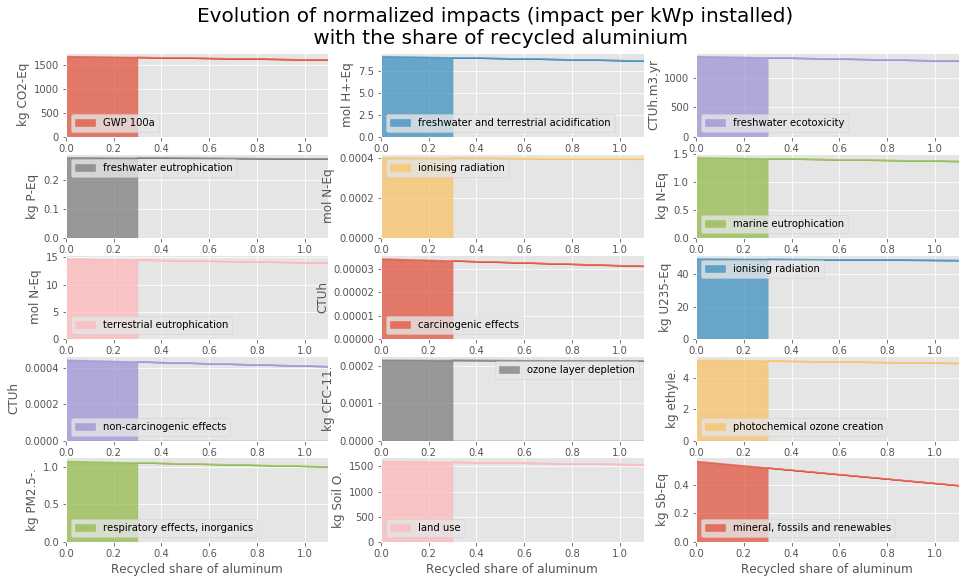

In [239]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the share of recycled aluminium', y = 0.95, fontsize = 20)
#plt.tight_layout()

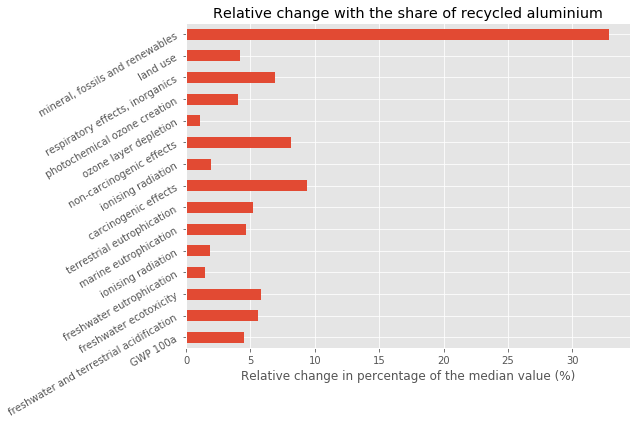

In [240]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the share of recycled aluminium')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### Electricity Mix

In [241]:
A = [elec_dataset_row, elec_dataset_eu, elec_dataset_us, elec_dataset_cn, elec_dataset_fr]

In [242]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in A:
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = i,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i['location']] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_electricity_mix.pkl')
DF_impact

'market for electricity, medium voltage' (kilowatt hour, RoW, None)
'market group for electricity, medium voltage' (kilowatt hour, ENTSO-E, None)
'market group for electricity, medium voltage' (kilowatt hour, US, None)
'market for electricity, medium voltage' (kilowatt hour, CN-CSG, None)
'market for electricity, medium voltage' (kilowatt hour, FR, None)


RoW  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  16704.933560   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     90.863295   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13339.532322   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.745001   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.004014   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     14.164572   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    145.017860   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000333   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    491.630881   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004342   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002154   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     50.766598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     10.548692   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  15851.992320   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.240352   

                                                         ENTSO-E  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15599.435218   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     78.489634   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13031.467074   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.699558   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.004817   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     12.253808   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    132.733828   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000326   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    602.227352   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004271   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002241   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     44.894123   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.702960   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  15094.024040   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.245530   

                                                              US  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  16777.605115   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     76.921227   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13483.795760   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.849042   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.005171   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     12.318226   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    125.404375   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000335   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    660.326524   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004302   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002237   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     45.492796   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     11.580199   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  15278.211779   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.243228   

                                                          CN-CSG            FR  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  18706.578785  13774.948914  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     98.309701     66.475510  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13537.735929  12703.031786  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.555432      2.474191  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.002217      0.007289  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     15.821848     11.178277  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    160.670692    109.833957  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000344      0.000316  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    282.667088 

In [243]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_electricity_mix.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Electricity mix'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Electricity mix                                                          
RoW              1670.493356                                  9.086329   
ENTSO-E          1559.943522                                  7.848963   
US               1677.760511                                  7.692123   
CN-CSG           1870.657878                                  9.830970   
FR               1377.494891                                  6.647551   

                 freshwater ecotoxicity  freshwater eutrophication  \
Electricity mix                                                      
RoW                         1333.953232                   0.274500   
ENTSO-E                     1303.146707                   0.269956   
US                          1348.379576                   0.284904   
CN-CSG                      1353.773593                   0.255543   
FR                          1270.303179                   0.247419   

                 ionising radiation  marine eutrophication  \
Electricity mix                                              
RoW                        0.000401               1.416457   
ENTSO-E                    0.000482               1.225381   
US                         0.000517               1.231823   
CN-CSG                     0.000222               1.582185   
FR                         0.000729               1.117828   

                 terrestrial eutrophication  carcinogenic effects  \
Electricity mix                                                     
RoW                               14.501786              0.000033   
ENTSO-E                           13.273383              0.000033   
US                                12.540438              0.000033   
CN-CSG                            16.067069              0.000034   
FR                                10.983396              0.000032   

                 ionising radiation  non-carcinogenic effects  \
Electricity mix                                                 
RoW                       49.163088                  0.000434   
ENTSO-E                   60.222735                  0.000427   
US                        66.032652                  0.000430   
CN-CSG                    28.266709                  0.000451   
FR                        91.506115                  0.000413   

                 ozone layer depletion  photochemical ozone creation  \
Electricity mix                                                        
RoW                           0.000215                      5.076660   
ENTSO-E                       0.000224                      4.489412   
US                            0.000224                      4.549280   
CN-CSG                        0.000204                      5.554361   
FR                            0.000248                      4.168630   

                 respiratory effects, inorganics     land use  \
Electricity mix                                                 
RoW                                     1.054869  1585.199232   
ENTSO-E                                 0.870296  1509.402404   
US                                      1.158020  1527.821178   
CN-CSG                                  1.376716  1645.943869   
FR                                      0.794117  1399.432430   

                 mineral, fossils and renewables  
Electricity mix                                   
RoW                                     0.524035  
ENTSO-E                                 0.524553  
US                                      0.524323  
CN-CSG                                  0.523751  
FR                                      0.525884

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the electricity mix of manufacture')

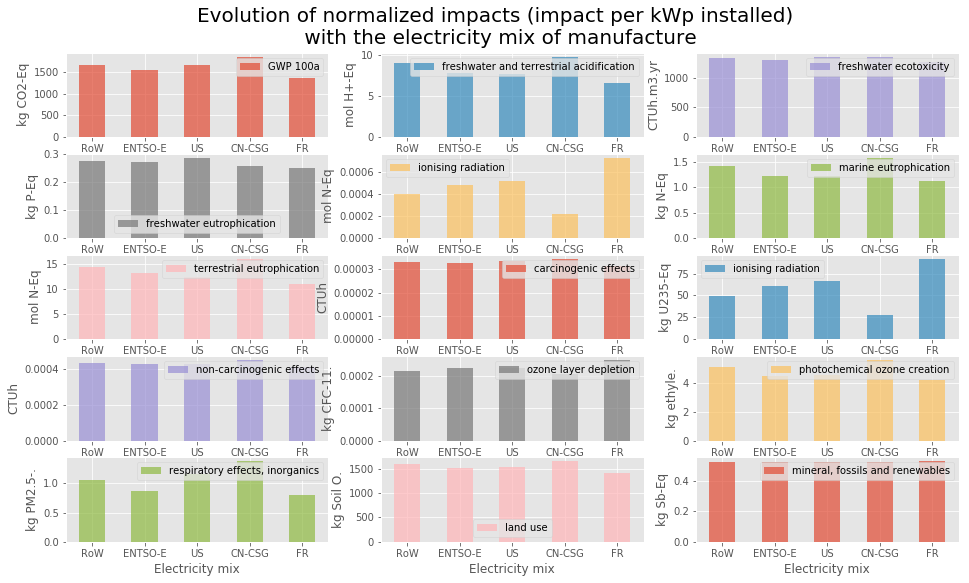

In [244]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'bar', alpha = 0.7, rot = 0)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
        axj.set_title('')
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the electricity mix of manufacture', y = 0.95, fontsize = 20)
#plt.tight_layout()

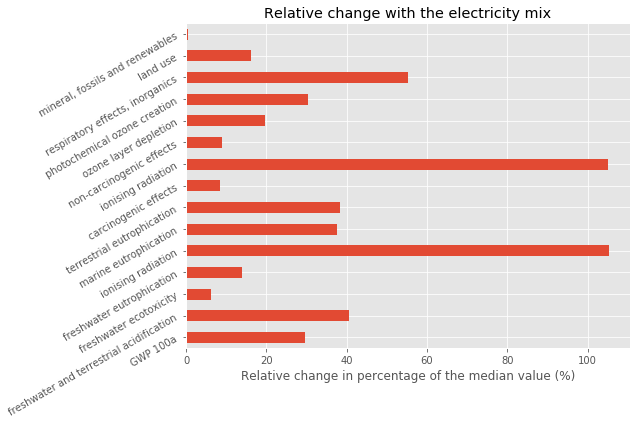

In [245]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the electricity mix')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### Inverter Weight

In [246]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(1,6.1,1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = i*10,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_Inverter_weight.pkl')
DF_impact

1.0
2.0
3.0
4.0
5.0
6.0


1.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13552.044372   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     62.317731   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12004.676426   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.160373   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007174   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     10.817874   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    105.460827   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000303   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    900.847465   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.003885   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002462   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     40.276550   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.566253   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13486.449747   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      4.843276   

                                                             2.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13824.335641   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.622342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12707.028747   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.476295   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007269   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.196986   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.137604   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    912.464944   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004130   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002483   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.747751   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.950008   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14012.867985   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.258750   

                                                             3.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14096.626909   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     70.926953   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13409.381067   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.792216   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007363   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.576098   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.814381   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000329   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    924.082423   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004374   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002504   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.218953   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.333763   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14539.286222   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.674223   

                                                             4.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14368.918178   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     75.231564   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  14111.733387   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      3.108138   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007458   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.955210   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    119.491158   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000343   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    935.699902   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004618   
(ILCD 1.0.8 2016 midpoint no LT, human health,

In [247]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_Inverter_weight.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Inverter specific weight (kg/kW)'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  \
Inverter specific weight (kg/kW)                
1.0                               1355.204437   
2.0                               1382.433564   
3.0                               1409.662691   
4.0                               1436.891818   
5.0                               1464.120945   
6.0                               1491.350072   

                                  freshwater and terrestrial acidification  \
Inverter specific weight (kg/kW)                                             
1.0                                                               6.231773   
2.0                                                               6.662234   
3.0                                                               7.092695   
4.0                                                               7.523156   
5.0                                                               7.953618   
6.0                                                               8.384079   

                                  freshwater ecotoxicity  \
Inverter specific weight (kg/kW)                           
1.0                                          1200.467643   
2.0                                          1270.702875   
3.0                                          1340.938107   
4.0                                          1411.173339   
5.0                                          1481.408571   
6.0                                          1551.643803   

                                  freshwater eutrophication  \
Inverter specific weight (kg/kW)                              
1.0                                                0.216037   
2.0                                                0.247629   
3.0                                                0.279222   
4.0                                                0.310814   
5.0                                                0.342406   
6.0                                                0.373998   

                                  ionising radiation  marine eutrophication  \
Inverter specific weight (kg/kW)                                              
1.0                                         0.000717               1.081787   
2.0                                         0.000727               1.119699   
3.0                                         0.000736               1.157610   
4.0                                         0.000746               1.195521   
5.0                                         0.000755               1.233432   
6.0                                         0.000765               1.271343   

                                  terrestrial eutrophication  \
Inverter specific weight (kg/kW)                               
1.0                                                10.546083   
2.0                                                11.013760   
3.0                                                11.481438   
4.0                                                11.949116   
5.0                                                12.416793   
6.0                                                12.884471   

                                  carcinogenic effects  ionising radiation  \
Inverter specific weight (kg/kW)                                             
1.0                                           0.000030           90.084746   
2.0                                           0.000032           91.246494   
3.0                                           0.000033           92.408242   
4.0                                           0.000034           93.569990   
5.0                                           0.000036           94.731738   
6.0                                           0.000037           95.893486   

                                  non-carcinogenic effects  \
Inverter specific weight (kg/kW)                             
1.0                                               0.000389   
2.0                                               0.000413   
3.0           

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the specific weight of the inverter')

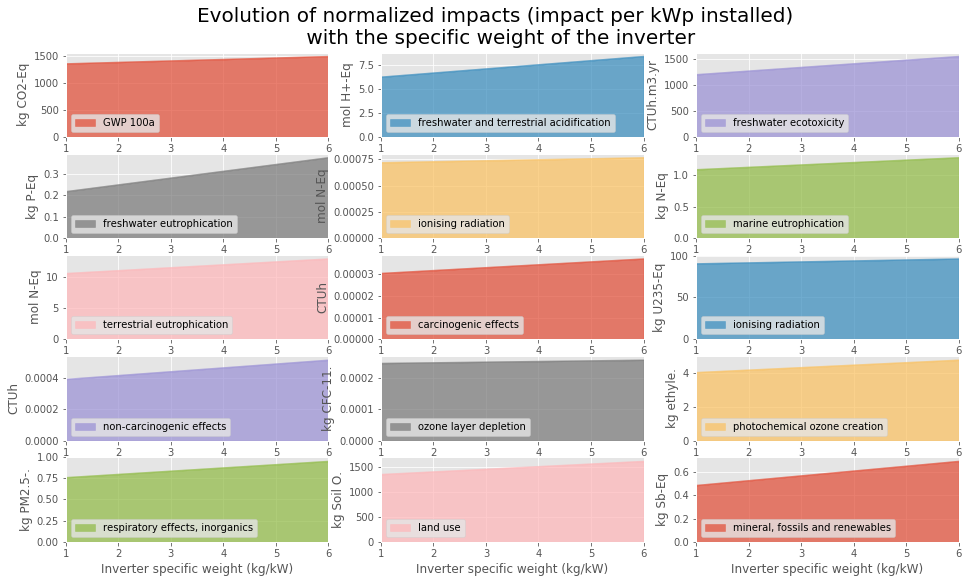

In [248]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the specific weight of the inverter', y = 0.95, fontsize = 20)
#plt.tight_layout()

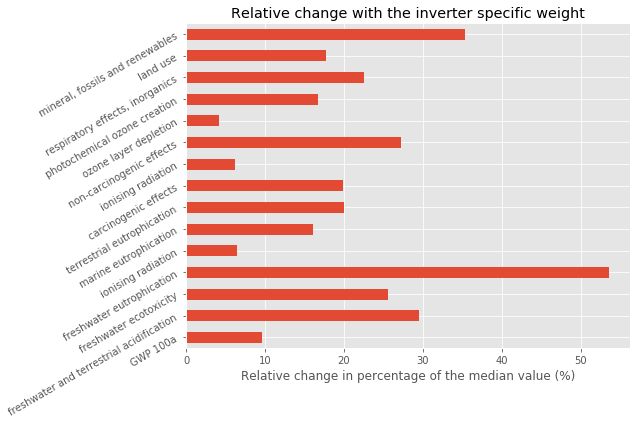

In [249]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the inverter specific weight')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### Inverter Lifetime

In [250]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(10,31,5):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = i, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_Inverter_lifetime.pkl')
DF_impact

10
15
20
25
30


10  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14159.333919   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     70.980403   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  13411.059619   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.792349   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007367   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.590607   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.976483   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000329   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    924.526318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004374   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002511   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.273158   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.336759   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14554.995550   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.674276   

                                                              15  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13918.396156   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.702517   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12709.546574   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.476494   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007273   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.218749   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.380758   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    913.130787   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004130   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002495   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.829059   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.954502   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14036.431977   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.258829   

                                                              20  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13805.765650   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     64.570255   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12358.999871   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.318582   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007227   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.034634   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    108.103158   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000310   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    907.488508   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004008   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002487   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.113785   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.763747   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13779.113856   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.051112   

                                                              25            30  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13744.458048  13708.811897  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     63.296243     62.451356  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12148.839704  12008.872805  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.223849      2.160705  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007200      0.007182  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     10.925615     10.854146  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    106.752808    105.866084  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000306      0.000303  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    904.147530  

In [251]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_Inverter_lifetime.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Inverter lifetime'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Inverter lifetime                                                          
10                 1415.933392                                  7.098040   
15                 1391.839616                                  6.670252   
20                 1380.576565                                  6.457026   
25                 1374.445805                                  6.329624   
30                 1370.881190                                  6.245136   

                   freshwater ecotoxicity  freshwater eutrophication  \
Inverter lifetime                                                      
10                            1341.105962                   0.279235   
15                            1270.954657                   0.247649   
20                            1235.899987                   0.231858   
25                            1214.883970                   0.222385   
30                            1200.887281                   0.216070   

                   ionising radiation  marine eutrophication  \
Inverter lifetime                                              
10                           0.000737               1.159061   
15                           0.000727               1.121875   
20                           0.000723               1.103463   
25                           0.000720               1.092562   
30                           0.000718               1.085415   

                   terrestrial eutrophication  carcinogenic effects  \
Inverter lifetime                                                     
10                                  11.497648              0.000033   
15                                  11.038076              0.000032   
20                                  10.810316              0.000031   
25                                  10.675281              0.000031   
30                                  10.586608              0.000030   

                   ionising radiation  non-carcinogenic effects  \
Inverter lifetime                                                 
10                          92.452632                  0.000437   
15                          91.313079                  0.000413   
20                          90.748851                  0.000401   
25                          90.414753                  0.000394   
30                          90.195720                  0.000389   

                   ozone layer depletion  photochemical ozone creation  \
Inverter lifetime                                                        
10                              0.000251                      4.327316   
15                              0.000249                      4.182906   
20                              0.000249                      4.111378   
25                              0.000248                      4.069004   
30                              0.000248                      4.041206   

                   respiratory effects, inorganics     land use  \
Inverter lifetime                                                 
10                                        0.833676  1455.499555   
15                                        0.795450  1403.643198   
20                                        0.776375  1377.911386   
25                                        0.764959  1362.629392   
30                                        0.757374  1352.572307   

                   mineral, fossils and renewables  
Inverter lifetime                                   
10                                        0.567428  
15                                        0.525883  
20                                        0.505111  
25                                        0.492649  
30                                        0.484341

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the inverter lifetime')

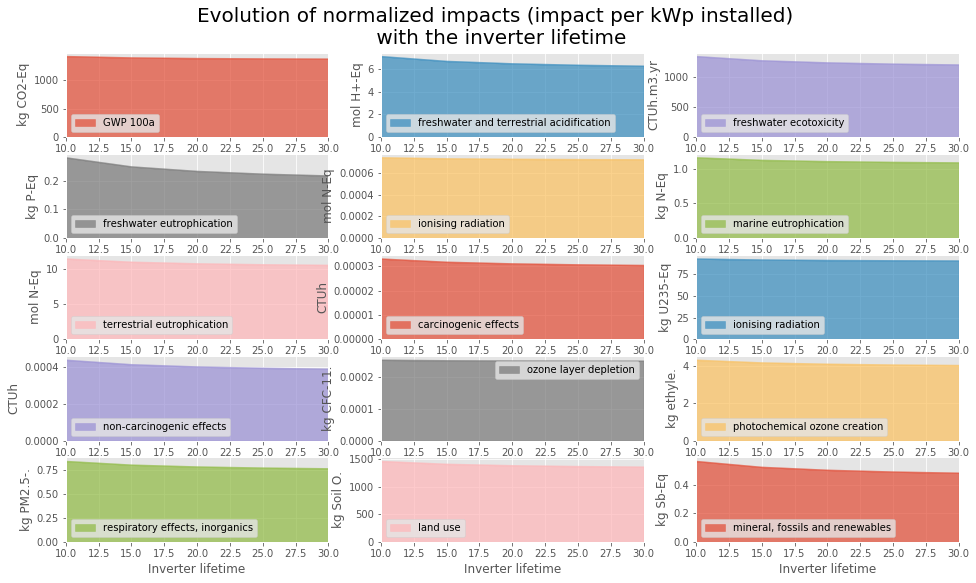

In [252]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the inverter lifetime', y = 0.95, fontsize = 20)
#plt.tight_layout()

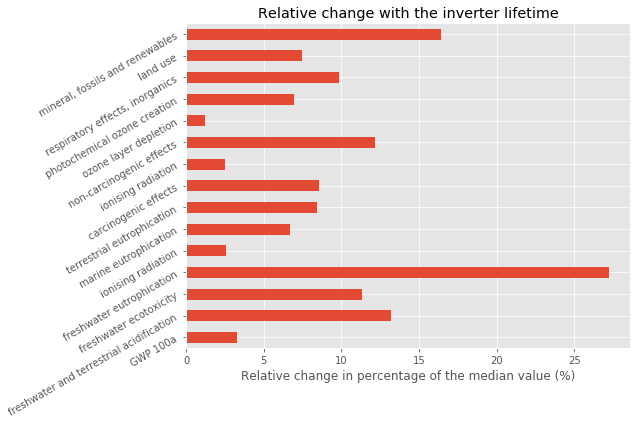

In [253]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the inverter lifetime')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### PV Lifetime

In [254]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(20,40,5):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = i, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_PV_lifetime.pkl')
DF_impact

20
25
30
35


20  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13810.026822   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     63.895135   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12243.270004   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.266034   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007214   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     10.982934   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    107.452026   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000307   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    905.903679   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.003968   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002490   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     40.911497   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.702160   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13703.814035   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      4.981908   

                                                              25  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13911.241746   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     65.338914   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12477.667203   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.371363   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007246   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.111723   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    109.037969   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000312   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    909.850154   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004049   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002498   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.410932   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.830577   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13881.905002   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.120408   

                                                              30            35  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14012.456671  14113.671595  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.782692     68.226471  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12712.064401  12946.461600  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.476692      2.582021  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007278      0.007311  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.240512     11.369301  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.623912    112.209854  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316      0.000321  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    913.796630    917.743105  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004131      0.004212  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002506      0.002515  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.910366     42.409801  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.958995      8.087413  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14059.995969  14238.086936  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.258908      5.397408

In [255]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_PV_lifetime.pkl')
df_impact = df_impact.T
df_impact.index.name = 'PV lifetime'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  freshwater and terrestrial acidification  \
PV lifetime                                                          
20           1381.002682                                  6.389513   
25           1391.124175                                  6.533891   
30           1401.245667                                  6.678269   
35           1411.367160                                  6.822647   

             freshwater ecotoxicity  freshwater eutrophication  \
PV lifetime                                                      
20                       1224.32700                   0.226603   
25                       1247.76672                   0.237136   
30                       1271.20644                   0.247669   
35                       1294.64616                   0.258202   

             ionising radiation  marine eutrophication  \
PV lifetime                                              
20                     0.000721               1.098293   
25                     0.000725               1.111172   
30                     0.000728               1.124051   
35                     0.000731               1.136930   

             terrestrial eutrophication  carcinogenic effects  \
PV lifetime                                                     
20                            10.745203              0.000031   
25                            10.903797              0.000031   
30                            11.062391              0.000032   
35                            11.220985              0.000032   

             ionising radiation  non-carcinogenic effects  \
PV lifetime                                                 
20                    90.590368                  0.000397   
25                    90.985015                  0.000405   
30                    91.379663                  0.000413   
35                    91.774311                  0.000421   

             ozone layer depletion  photochemical ozone creation  \
PV lifetime                                                        
20                        0.000249                      4.091150   
25                        0.000250                      4.141093   
30                        0.000251                      4.191037   
35                        0.000251                      4.240980   

             respiratory effects, inorganics     land use  \
PV lifetime                                                 
20                                  0.770216  1370.381403   
25                                  0.783058  1388.190500   
30                                  0.795900  1405.999597   
35                                  0.808741  1423.808694   

             mineral, fossils and renewables  
PV lifetime                                   
20                                  0.498191  
25                                  0.512041  
30                                  0.525891  
35                                  0.539741

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the PV lifetime')

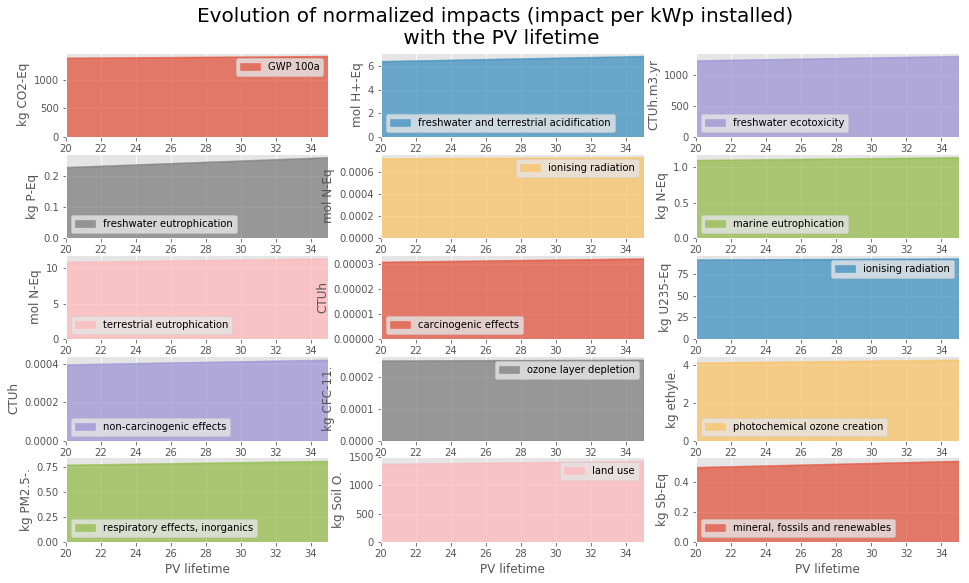

In [256]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the PV lifetime', y = 0.95, fontsize = 20)
#plt.tight_layout()

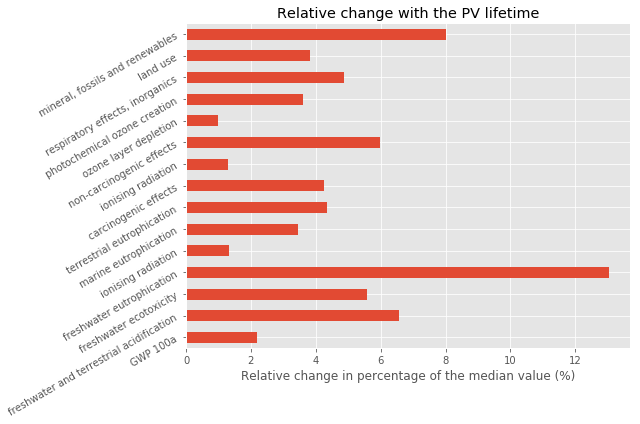

In [257]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the PV lifetime')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### Glass Thickness

In [259]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(2,4.1,1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = i, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_glass_thickness.pkl')
DF_impact

2.0
3.0
4.0


2.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13676.825187   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     63.161076   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12582.749014   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.465422   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007206   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     10.670617   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    103.680236   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000315   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    904.103308   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004113   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002476   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     40.219465   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.689805   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13525.348007   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.246217   

                                                             3.0           4.0  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13875.994434  14075.163681  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     64.998609     66.836142  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12648.245983  12713.742953  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.471123      2.476825  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007244      0.007282  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     10.962819     11.255021  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    107.233125    110.786014  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000315      0.000316  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    909.171917    914.240525  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004122      0.004131  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002495      0.002514  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.092018     41.964571  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.825898      7.961991  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13800.526652  14075.705297  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.252589      5.258960

In [260]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_glass_thickness.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Glass thickness'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Glass thickness                                                          
2.0              1367.682519                                  6.316108   
3.0              1387.599443                                  6.499861   
4.0              1407.516368                                  6.683614   

                 freshwater ecotoxicity  freshwater eutrophication  \
Glass thickness                                                      
2.0                         1258.274901                   0.246542   
3.0                         1264.824598                   0.247112   
4.0                         1271.374295                   0.247682   

                 ionising radiation  marine eutrophication  \
Glass thickness                                              
2.0                        0.000721               1.067062   
3.0                        0.000724               1.096282   
4.0                        0.000728               1.125502   

                 terrestrial eutrophication  carcinogenic effects  \
Glass thickness                                                     
2.0                               10.368024              0.000031   
3.0                               10.723313              0.000032   
4.0                               11.078601              0.000032   

                 ionising radiation  non-carcinogenic effects  \
Glass thickness                                                 
2.0                       90.410331                  0.000411   
3.0                       90.917192                  0.000412   
4.0                       91.424052                  0.000413   

                 ozone layer depletion  photochemical ozone creation  \
Glass thickness                                                        
2.0                           0.000248                      4.021947   
3.0                           0.000250                      4.109202   
4.0                           0.000251                      4.196457   

                 respiratory effects, inorganics     land use  \
Glass thickness                                                 
2.0                                     0.768981  1352.534801   
3.0                                     0.782590  1380.052665   
4.0                                     0.796199  1407.570530   

                 mineral, fossils and renewables  
Glass thickness                                   
2.0                                     0.524622  
3.0                                     0.525259  
4.0                                     0.525896

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the glass thickness')

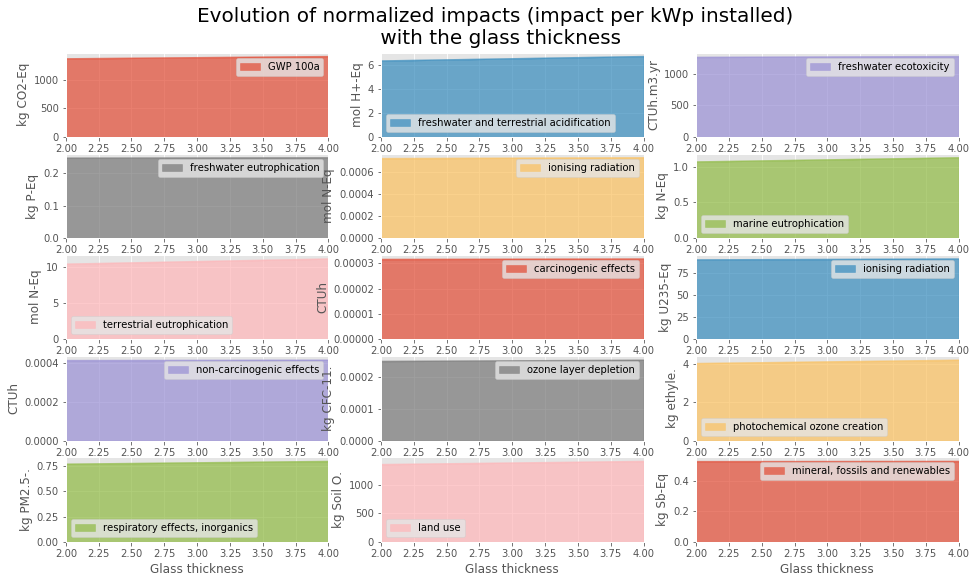

In [261]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the glass thickness', y = 0.95, fontsize = 20)
#plt.tight_layout()

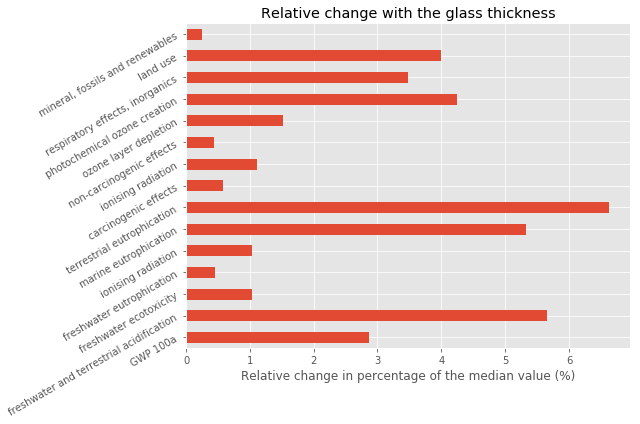

In [262]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the glass thickness')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()
df_RC[df_impact.index.name] = df

### Manufacturing Efficiency Gain

In [263]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0,1.1,0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = i,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_manufacturing_efficiency_gains.pkl')
DF_impact

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


0.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14090.840433   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.849505   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12714.162591   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.476858   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007282   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.258648   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.826540   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    914.351499   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004131   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002516   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.978123   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.962740   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14079.632629   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.258974   

                                                             0.1  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14092.542538   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.779006   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12704.087071   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.475996   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007001   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.248706   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.704158   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    879.236108   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004130   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002493   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.956653   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.956853   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14069.465482   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.257260   

                                                             0.2  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14094.244643   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.708507   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12694.011552   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.475133   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006720   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.238765   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.581776   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    844.120717   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004128   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002470   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.935184   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.950966   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14059.298334   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.255546   

                                                             0.3  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14095.946743   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.638008   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12683.936029   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.474271   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006439   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.228823   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.459393   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000315   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    809.005313   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004126   
(ILCD 1.0.8 2016 midpoint no LT, human health,

In [264]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_manufacturing_efficiency_gains.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Manufacturing efficiency gains'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  \
Manufacturing efficiency gains                
0.0                             1409.084043   
0.1                             1409.254254   
0.2                             1409.424464   
0.3                             1409.594674   
0.4                             1409.764885   
0.5                             1409.935095   
0.6                             1410.105306   
0.7                             1410.275516   
0.8                             1410.445727   
0.9                             1410.615937   
1.0                             1410.786147   

                                freshwater and terrestrial acidification  \
Manufacturing efficiency gains                                             
0.0                                                             6.684951   
0.1                                                             6.677901   
0.2                                                             6.670851   
0.3                                                             6.663801   
0.4                                                             6.656751   
0.5                                                             6.649701   
0.6                                                             6.642651   
0.7                                                             6.635601   
0.8                                                             6.628551   
0.9                                                             6.621501   
1.0                                                             6.614452   

                                freshwater ecotoxicity  \
Manufacturing efficiency gains                           
0.0                                        1271.416259   
0.1                                        1270.408707   
0.2                                        1269.401155   
0.3                                        1268.393603   
0.4                                        1267.386051   
0.5                                        1266.378499   
0.6                                        1265.370947   
0.7                                        1264.363395   
0.8                                        1263.355843   
0.9                                        1262.348291   
1.0                                        1261.340739   

                                freshwater eutrophication  ionising radiation  \
Manufacturing efficiency gains                                                  
0.0                                              0.247686            0.000728   
0.1                                              0.247600            0.000700   
0.2                                              0.247513            0.000672   
0.3                                              0.247427            0.000644   
0.4                                              0.247341            0.000616   
0.5                                              0.247255            0.000588   
0.6                                              0.247168            0.000560   
0.7                                              0.247082            0.000532   
0.8                                              0.246996            0.000503   
0.9                                              0.246910            0.000475   
1.0                                              0.246823            0.000447   

                                marine eutrophication  \
Manufacturing efficiency gains                          
0.0                                          1.125865   
0.1                                          1.124871   
0.2                                          1.123876   
0.3                                          1.122882   
0.4                                          1.121888   
0.5                                          1.120894   
0.6                                          1.119900   
0.7                                          1.118906   
0.8                                          1.117912  

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with Manufacturing efficiency gains')

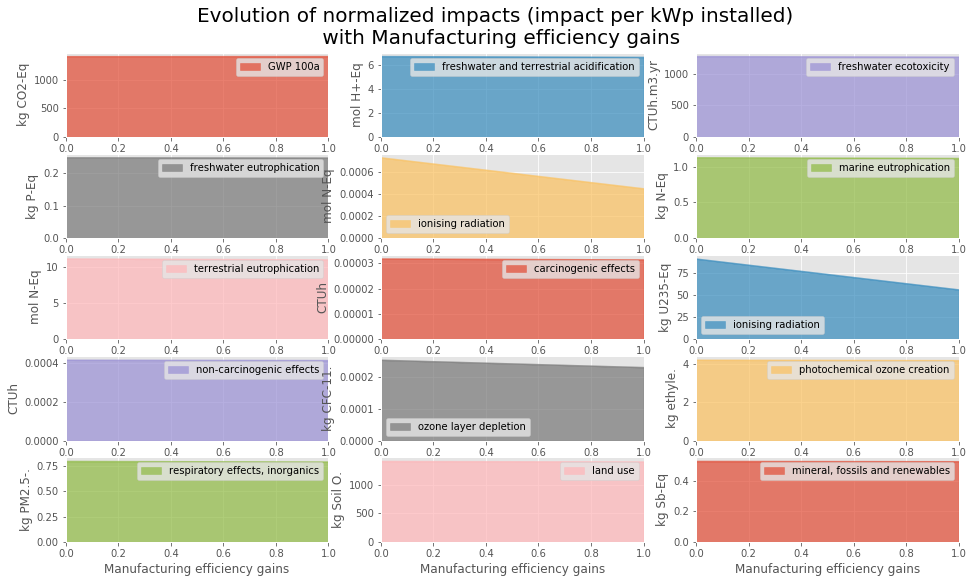

In [265]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

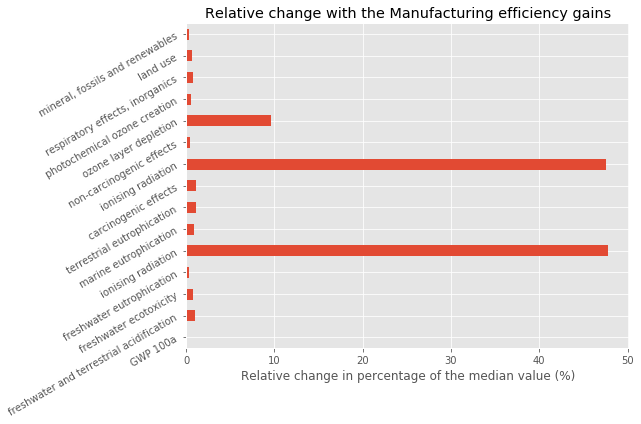

In [266]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Kerf Loss

In [267]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.25,0.51,0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = i,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_kerf_loss.pkl')
DF_impact

0.25
0.35
0.44999999999999996


0.25  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13931.256273   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     65.631985   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12647.066157   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.465199   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006734   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.079078   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    108.737662   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000314   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    846.107281   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004113   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002459   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.355334   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.775177   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13837.014527   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.243572   

                                                            0.35          0.45  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14097.488415  14318.467988  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.264072     67.121149  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12680.003178  12724.764705  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.470684      2.478151  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006988      0.007333  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.182221     11.321552  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    109.927507    111.535286  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000315      0.000317  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    877.716519    920.779675  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004122      0.004134  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002497      0.002547  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.718875     42.209685  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.864710      7.986528  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13970.543872  14151.201236  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.250635      5.260261

In [268]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_kerf_loss.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Kerf loss'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Kerf loss                                                          
0.25       1393.125627                                  6.563199   
0.35       1409.748841                                  6.626407   
0.45       1431.846799                                  6.712115   

           freshwater ecotoxicity  freshwater eutrophication  \
Kerf loss                                                      
0.25                  1264.706616                   0.246520   
0.35                  1268.000318                   0.247068   
0.45                  1272.476471                   0.247815   

           ionising radiation  marine eutrophication  \
Kerf loss                                              
0.25                 0.000673               1.107908   
0.35                 0.000699               1.118222   
0.45                 0.000733               1.132155   

           terrestrial eutrophication  carcinogenic effects  \
Kerf loss                                                     
0.25                        10.873766              0.000031   
0.35                        10.992751              0.000032   
0.45                        11.153529              0.000032   

           ionising radiation  non-carcinogenic effects  \
Kerf loss                                                 
0.25                84.610728                  0.000411   
0.35                87.771652                  0.000412   
0.45                92.077968                  0.000413   

           ozone layer depletion  photochemical ozone creation  \
Kerf loss                                                        
0.25                    0.000246                      4.135533   
0.35                    0.000250                      4.171887   
0.45                    0.000255                      4.220968   

           respiratory effects, inorganics     land use  \
Kerf loss                                                 
0.25                              0.777518  1383.701453   
0.35                              0.786471  1397.054387   
0.45                              0.798653  1415.120124   

           mineral, fossils and renewables  
Kerf loss                                   
0.25                              0.524357  
0.35                              0.525063  
0.45                              0.526026

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the kerf losses')

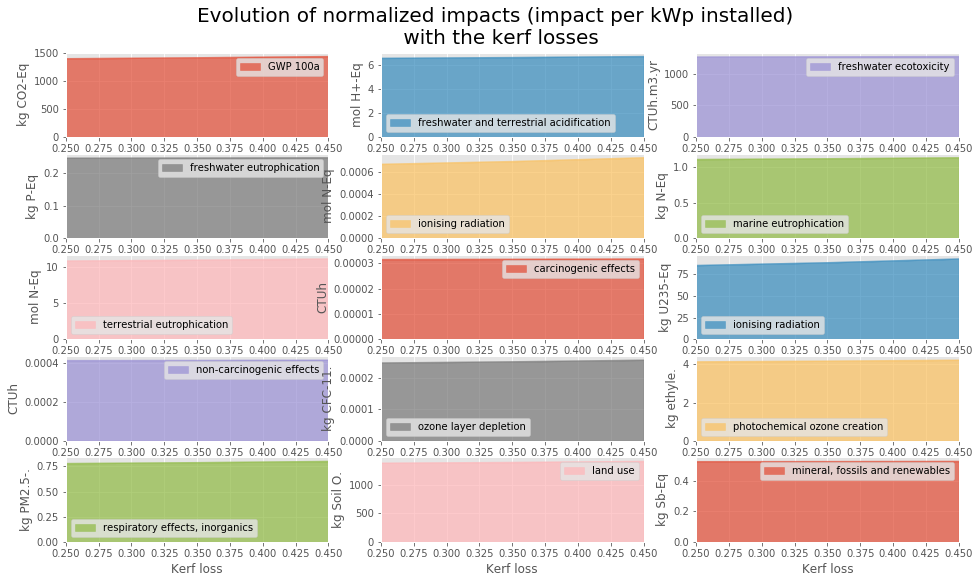

In [269]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the kerf losses', y = 0.95, fontsize = 20)
#plt.tight_layout()

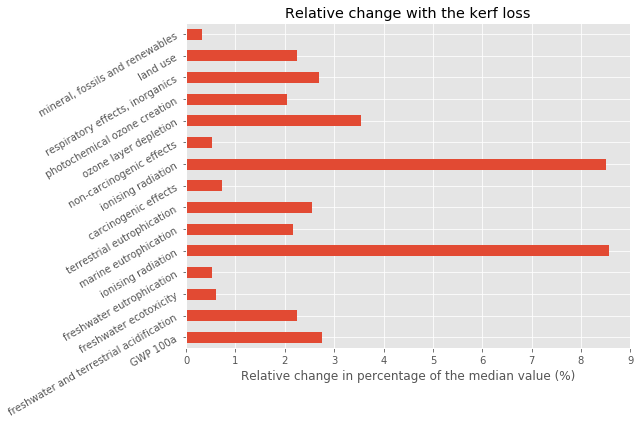

In [270]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the kerf loss')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Wafer Thickness

In [271]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(128,300,25):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = i, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_wafer_thickness.pkl')
DF_impact

128
153
178
203
228
253
278


128  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  13838.485024   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     65.097543   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12618.130342   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.460236   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006502   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     10.997552   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    107.792013   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000314   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    817.191799   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004105   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002432   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.070997   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.694982   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13728.451733   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.237066   

                                                             153  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14017.991591   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     65.784183   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12653.934411   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.466202   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006778   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.109469   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    109.083193   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000315   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    851.578230   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004115   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002473   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.465396   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.792343   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13873.408050   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.244750   

                                                             178  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14197.498158   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.470822   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12689.738480   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.472167   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007054   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.221387   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.374373   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    885.964661   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004124   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002513   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.859796   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.889704   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14018.364367   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.252434   

                                                             203  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14377.004818   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.157461   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12725.542569   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478133   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007329   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.333305   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    111.665554   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    920.351112   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004134   
(ILCD 1.0.8 2016 midpoint no LT, human health,

In [272]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_wafer_thickness.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Wafer thickness'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Wafer thickness                                                          
128              1383.848502                                  6.509754   
153              1401.799159                                  6.578418   
178              1419.749816                                  6.647082   
203              1437.700482                                  6.715746   
228              1455.651139                                  6.784410   
253              1473.601786                                  6.853074   
278              1491.552443                                  6.921738   

                 freshwater ecotoxicity  freshwater eutrophication  \
Wafer thickness                                                      
128                         1261.813034                   0.246024   
153                         1265.393441                   0.246620   
178                         1268.973848                   0.247217   
203                         1272.554257                   0.247813   
228                         1276.134664                   0.248410   
253                         1279.715069                   0.249006   
278                         1283.295476                   0.249603   

                 ionising radiation  marine eutrophication  \
Wafer thickness                                              
128                        0.000650               1.099755   
153                        0.000678               1.110947   
178                        0.000705               1.122139   
203                        0.000733               1.133330   
228                        0.000760               1.144522   
253                        0.000788               1.155714   
278                        0.000816               1.166906   

                 terrestrial eutrophication  carcinogenic effects  \
Wafer thickness                                                     
128                               10.779201              0.000031   
153                               10.908319              0.000031   
178                               11.037437              0.000032   
203                               11.166555              0.000032   
228                               11.295673              0.000032   
253                               11.424791              0.000032   
278                               11.553909              0.000032   

                 ionising radiation  non-carcinogenic effects  \
Wafer thickness                                                 
128                       81.719180                  0.000410   
153                       85.157823                  0.000411   
178                       88.596466                  0.000412   
203                       92.035111                  0.000413   
228                       95.473754                  0.000414   
253                       98.912395                  0.000415   
278                      102.351038                  0.000416   

                 ozone layer depletion  photochemical ozone creation  \
Wafer thickness                                                        
128                           0.000243                      4.107100   
153                           0.000247                      4.146540   
178                           0.000251                      4.185980   
203                           0.000255                      4.225420   
228                           0.000260                      4.264860   
253                           0.000264                      4.304299   
278                           0.000268                      4.343739   

                 respiratory effects, inorganics     land use  \
Wafer thickness                                                 
128                                     0.769498  1372.845173   
153                                     0.779234  1387.340805   
178                                     0.7889

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the wafer thickness')

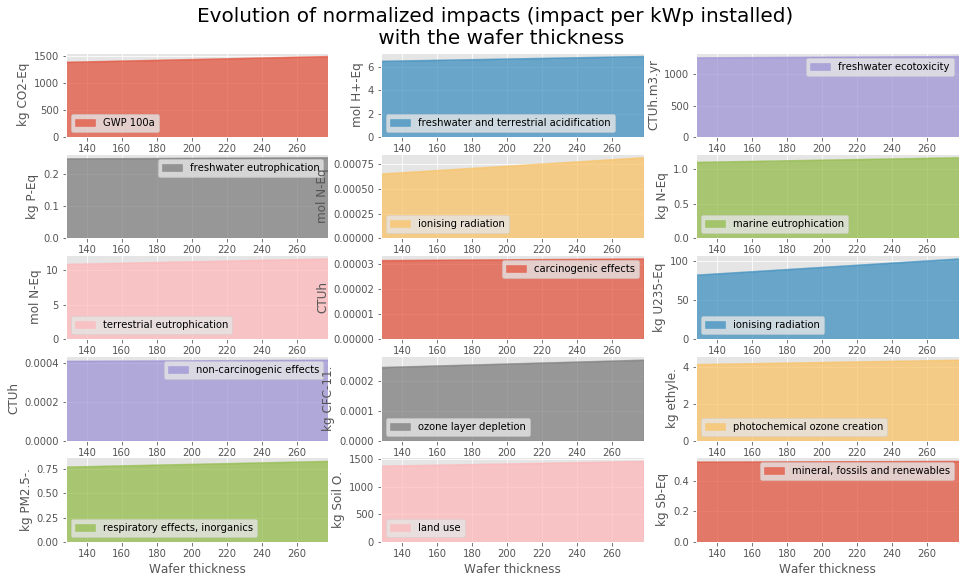

In [273]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the wafer thickness', y = 0.95, fontsize = 20)
#plt.tight_layout()

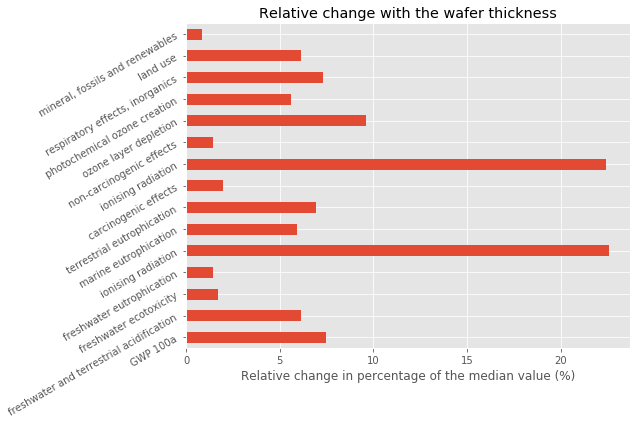

In [274]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the wafer thickness')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Silver Amount

In [275]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in [2,11.2]:
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = i, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_silver_amount.pkl')
DF_impact

2
11.2


2.0           11.2
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14282.385229  14465.033936
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     65.682620     67.480609
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12545.354876  12767.034053
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.254214      2.527530
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007245      0.007312
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     10.879807     11.435339
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    105.468369    113.041584
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316      0.000317
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    909.915794    918.229071
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004096      0.004145
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002547      0.002562
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     40.965323     42.554316
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.840839      8.010211
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  13871.457514  14228.395402
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      4.479938      5.424130

In [276]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_silver_amount.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Silver content'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Silver content                                                          
2.0             1428.238523                                  6.568262   
11.2            1446.503394                                  6.748061   

                freshwater ecotoxicity  freshwater eutrophication  \
Silver content                                                      
2.0                        1254.535488                   0.225421   
11.2                       1276.703405                   0.252753   

                ionising radiation  marine eutrophication  \
Silver content                                              
2.0                       0.000724               1.087981   
11.2                      0.000731               1.143534   

                terrestrial eutrophication  carcinogenic effects  \
Silver content                                                     
2.0                              10.546837              0.000032   
11.2                             11.304158              0.000032   

                ionising radiation  non-carcinogenic effects  \
Silver content                                                 
2.0                      90.991579                  0.000410   
11.2                     91.822907                  0.000415   

                ozone layer depletion  photochemical ozone creation  \
Silver content                                                        
2.0                          0.000255                      4.096532   
11.2                         0.000256                      4.255432   

                respiratory effects, inorganics     land use  \
Silver content                                                 
2.0                                    0.784084  1387.145751   
11.2                                   0.801021  1422.839540   

                mineral, fossils and renewables  
Silver content                                   
2.0                                    0.447994  
11.2                                   0.542413

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the silver content')

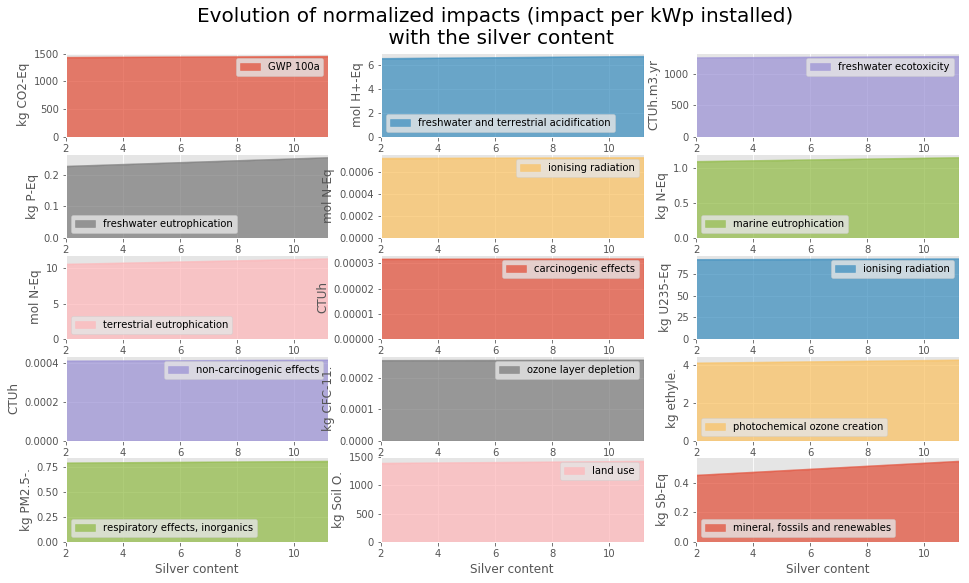

In [277]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the silver content', y = 0.95, fontsize = 20)
#plt.tight_layout()

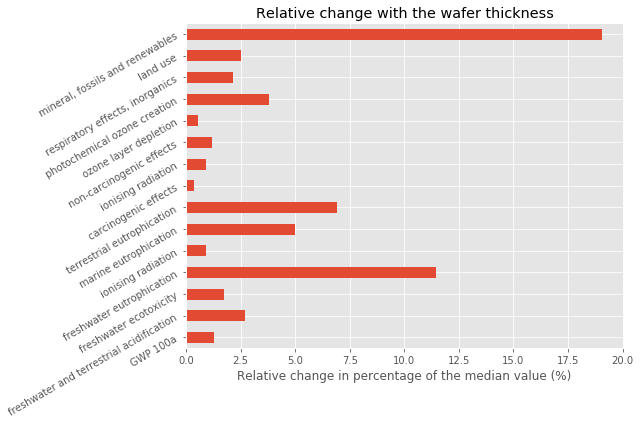

In [278]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the wafer thickness')
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Silicon Electricity Intensity

In [279]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in [21, 30, 40, 50, 75,100,195]:
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = i,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_silicon_electricity_intensity.pkl')
DF_impact

21
30
40
50
75
100
195


21   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14405.917514   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.883870   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12689.651962   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.474705   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006384   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.297906   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    111.228356   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    802.240190   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004128   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002480   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.175807   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.958364   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14124.082979   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.253656   

                                                             30   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14443.141321   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.026536   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12706.253742   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.476119   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.006819   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.322454   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    111.520064   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    856.665551   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004131   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002520   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.243356   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.969345   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14149.742131   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.256331   

                                                             40   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14482.759246   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.183568   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12724.653537   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.477686   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007303   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.349327   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    111.839681   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    917.125844   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004134   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002565   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.316904   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.981463   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14177.815930   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259303   

                                                             50   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14522.377170   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.340601   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12743.053333   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479253   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007786   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.376200   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.159298   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    977.586137   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004137   
(ILCD 1.0.8 2016 midpoint no LT, human health,

In [280]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_silicon_electricity_intensity.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Silicon electricity content'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
#df_impact[df_impact < 0] = 10e3
df_impact

GWP 100a  \
Silicon electricity content                
21                           1440.591751   
30                           1444.314132   
40                           1448.275925   
50                           1452.237717   
75                           1459.790685   
100                          1467.343654   
195                          1491.655442   

                             freshwater and terrestrial acidification  \
Silicon electricity content                                             
21                                                           6.688387   
30                                                           6.702654   
40                                                           6.718357   
50                                                           6.734060   
75                                                           6.771314   
100                                                          6.808568   
195                                                          6.946391   

                             freshwater ecotoxicity  \
Silicon electricity content                           
21                                      1268.965196   
30                                      1270.625374   
40                                      1272.465354   
50                                      1274.305333   
75                                      1278.842337   
100                                     1283.379340   
195                                     1300.502453   

                             freshwater eutrophication  ionising radiation  \
Silicon electricity content                                                  
21                                            0.247470            0.000638   
30                                            0.247612            0.000682   
40                                            0.247769            0.000730   
50                                            0.247925            0.000779   
75                                            0.248312            0.000899   
100                                           0.248699            0.001020   
195                                           0.250160            0.001479   

                             marine eutrophication  \
Silicon electricity content                          
21                                        1.129791   
30                                        1.132245   
40                                        1.134933   
50                                        1.137620   
75                                        1.143794   
100                                       1.149968   
195                                       1.172414   

                             terrestrial eutrophication  carcinogenic effects  \
Silicon electricity content                                                     
21                                            11.122836              0.000032   
30                                            11.152006              0.000032   
40                                            11.183968              0.000032   
50                                            11.215930              0.000032   
75                                            11.289755              0.000032   
100                                           11.363581              0.000032   
195                                           11.632770              0.000033   

                             ionising radiation  non-carcinogenic effects  \
Silicon electricity content                                                 
21                                    80.224019                  0.000413   
30                                    85.666555                  0.000413   
40                                    91.712584                  0.000413   
50                                    97.758614                  0.000414   
75                                   112.857041                  0.000415   
100                   

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Silicon electricity content')

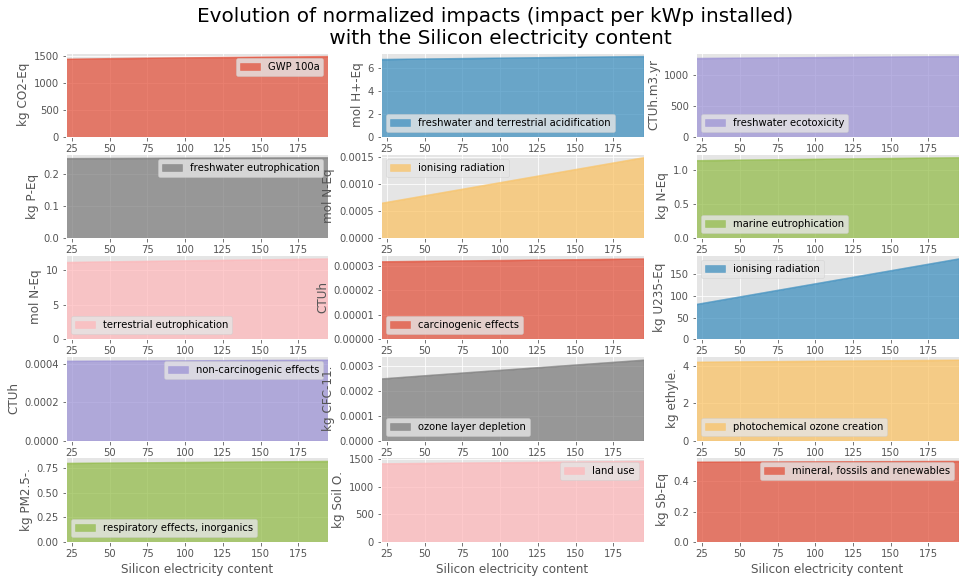

In [281]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

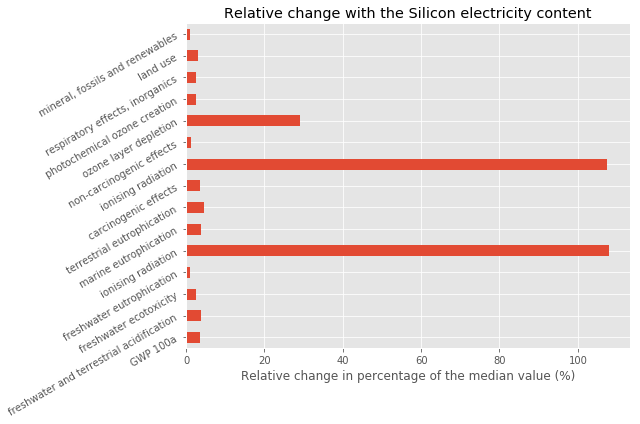

In [282]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Distance by Lorry

In [351]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(40,2000, 500):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = i, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_d_lorry.pkl')
DF_impact

40
540
1040
1540


40    \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15635.542012   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.947103   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12477.648236   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478886   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007320   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.581307   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.429581   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    919.288682   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004126   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002703   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.151025   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.992191   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14067.900157   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.252844   

                                                            540   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15703.976591   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     68.123003   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12622.665672   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479750   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007346   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.615517   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.815766   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.927598   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004135   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002715   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.295164   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.018704   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14289.537532   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.256795   

                                                            1040          1540  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15772.411169  15840.845748  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     68.298903     68.474803  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12767.683108  12912.700544  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.480614      2.481478  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007372      0.007398  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.649728     11.683939  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    115.201950    115.588135  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000319      0.000319  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    926.566514    930.205429  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004144      0.004152  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002727      0.002738  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.439303     43.583442  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.045216      8.071728  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14511.174908  14732.812283  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260746      5.264698

In [352]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_d_lorry.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Distance by lorry'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Distance by lorry                                                          
40                 1563.554201                                   6.79471   
540                1570.397659                                   6.81230   
1040               1577.241117                                   6.82989   
1540               1584.084575                                   6.84748   

                   freshwater ecotoxicity  freshwater eutrophication  \
Distance by lorry                                                      
40                            1247.764824                   0.247889   
540                           1262.266567                   0.247975   
1040                          1276.768311                   0.248061   
1540                          1291.270054                   0.248148   

                   ionising radiation  marine eutrophication  \
Distance by lorry                                              
40                           0.000732               1.158131   
540                          0.000735               1.161552   
1040                         0.000737               1.164973   
1540                         0.000740               1.168394   

                   terrestrial eutrophication  carcinogenic effects  \
Distance by lorry                                                     
40                                  11.442958              0.000032   
540                                 11.481577              0.000032   
1040                                11.520195              0.000032   
1540                                11.558814              0.000032   

                   ionising radiation  non-carcinogenic effects  \
Distance by lorry                                                 
40                          91.928868                  0.000413   
540                         92.292760                  0.000414   
1040                        92.656651                  0.000414   
1540                        93.020543                  0.000415   

                   ozone layer depletion  photochemical ozone creation  \
Distance by lorry                                                        
40                              0.000270                      4.315103   
540                             0.000271                      4.329516   
1040                            0.000273                      4.343930   
1540                            0.000274                      4.358344   

                   respiratory effects, inorganics     land use  \
Distance by lorry                                                 
40                                        0.799219  1406.790016   
540                                       0.801870  1428.953753   
1040                                      0.804522  1451.117491   
1540                                      0.807173  1473.281228   

                   mineral, fossils and renewables  
Distance by lorry                                   
40                                        0.525284  
540                                       0.525680  
1040                                      0.526075  
1540                                      0.526470

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Distance by lorry')

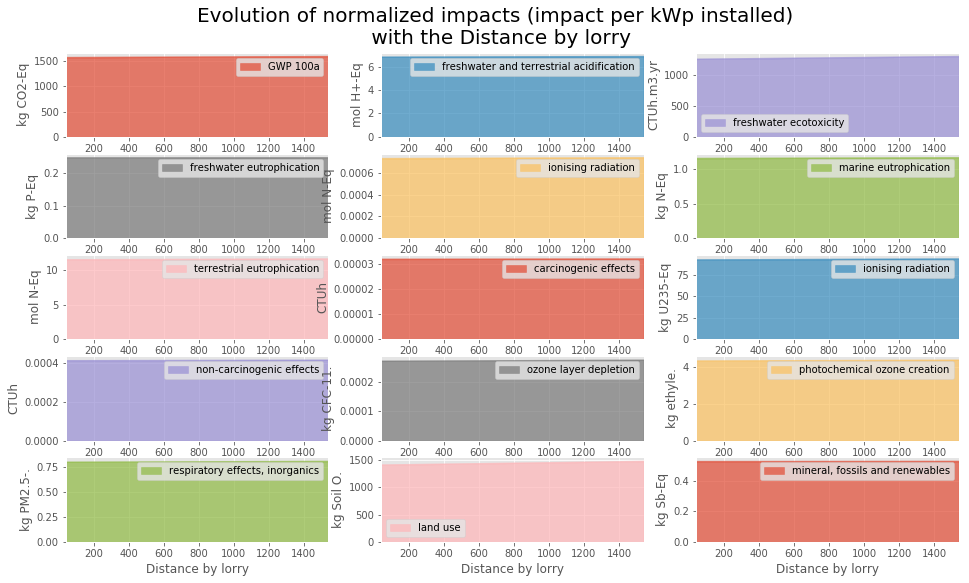

In [353]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

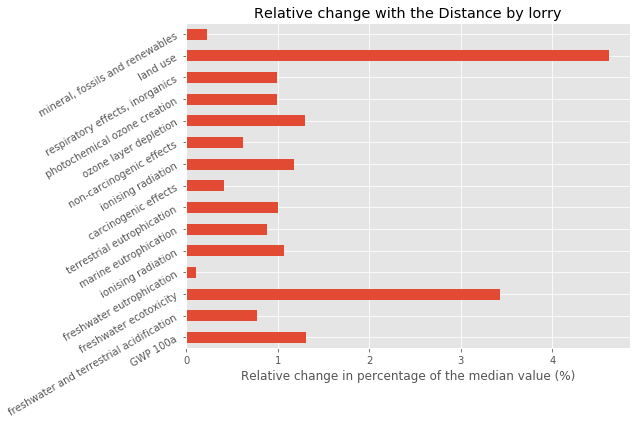

In [354]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Distance by Train

In [355]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0,600.1, 200):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = i, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_d_train.pkl')
DF_impact

0.0
200.0
400.0
600.0


0.0    \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15788.253495   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     68.238759   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12754.090736   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479755   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007367   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.640321   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    115.091399   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    926.001373   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004142   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002729   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.412844   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.033663   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14483.686491   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260364   

                                                           200.0  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15811.587885   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     68.298046   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12759.451937   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.480298   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007371   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.652770   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    115.233511   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000319   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    926.481473   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004143   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002732   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.454017   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.041281   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14502.833640   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260521   

                                                           400.0         600.0  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15834.922276  15858.256666  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     68.357333     68.416620  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12764.813138  12770.174340  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.480841      2.481383  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007375      0.007379  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.665219     11.677668  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    115.375623    115.517735  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000319      0.000319  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    926.961573    927.441673  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004144      0.004145  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002734      0.002737  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.495190     43.536363  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.048898      8.056516  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14521.980788  14541.127937  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260677      5.260834

In [356]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_d_train.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Distance by train'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Distance by train                                                          
0.0                1578.825349                                  6.823876   
200.0              1581.158789                                  6.829805   
400.0              1583.492228                                  6.835733   
600.0              1585.825667                                  6.841662   

                   freshwater ecotoxicity  freshwater eutrophication  \
Distance by train                                                      
0.0                           1275.409074                   0.247976   
200.0                         1275.945194                   0.248030   
400.0                         1276.481314                   0.248084   
600.0                         1277.017434                   0.248138   

                   ionising radiation  marine eutrophication  \
Distance by train                                              
0.0                          0.000737               1.164032   
200.0                        0.000737               1.165277   
400.0                        0.000737               1.166522   
600.0                        0.000738               1.167767   

                   terrestrial eutrophication  carcinogenic effects  \
Distance by train                                                     
0.0                                 11.509140              0.000032   
200.0                               11.523351              0.000032   
400.0                               11.537562              0.000032   
600.0                               11.551774              0.000032   

                   ionising radiation  non-carcinogenic effects  \
Distance by train                                                 
0.0                         92.600137                  0.000414   
200.0                       92.648147                  0.000414   
400.0                       92.696157                  0.000414   
600.0                       92.744167                  0.000415   

                   ozone layer depletion  photochemical ozone creation  \
Distance by train                                                        
0.0                             0.000273                      4.341284   
200.0                           0.000273                      4.345402   
400.0                           0.000273                      4.349519   
600.0                           0.000274                      4.353636   

                   respiratory effects, inorganics     land use  \
Distance by train                                                 
0.0                                       0.803366  1448.368649   
200.0                                     0.804128  1450.283364   
400.0                                     0.804890  1452.198079   
600.0                                     0.805652  1454.112794   

                   mineral, fossils and renewables  
Distance by train                                   
0.0                                       0.526036  
200.0                                     0.526052  
400.0                                     0.526068  
600.0                                     0.526083

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Distance by train')

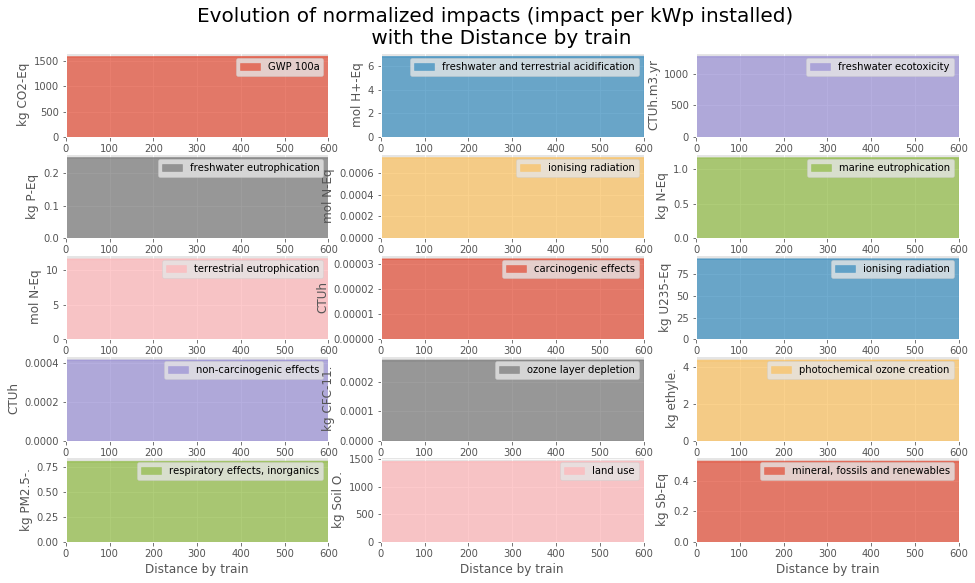

In [357]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

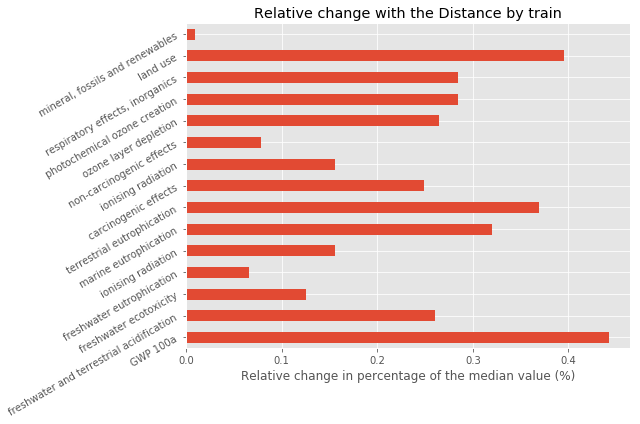

In [358]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Distance by Ships

In [289]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0,6000, 1000):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = i,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_d_sea.pkl')
DF_impact

0
1000
2000
3000
4000
5000


0     \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14649.710112   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.425265   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12722.320886   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.477509   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007296   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.214479   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.323514   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    916.256695   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004134   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002585   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     41.957065   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.949845   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14147.267912   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259368   

                                                            1000  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14674.598594   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.671632   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12724.687510   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.477694   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007301   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.263606   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    110.874790   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    916.945621   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004134   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002588   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.104618   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.960932   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14171.596078   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259407   

                                                            2000  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14699.487075   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.917999   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12727.054133   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.477879   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007306   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.312734   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    111.426065   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    917.634547   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004135   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002592   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.252170   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.972019   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14195.924244   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259447   

                                                            3000  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14724.375557   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.164365   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12729.420757   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478064   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007311   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.361862   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    111.977341   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    918.323473   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004135   
(ILCD 1.0.8 2016 midpoint no LT, human health

In [290]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_d_sea.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Distance by ships'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Distance by ships                                                          
0                  1464.971011                                  6.642527   
1000               1467.459859                                  6.667163   
2000               1469.948708                                  6.691800   
3000               1472.437556                                  6.716437   
4000               1474.926404                                  6.741073   
5000               1477.415252                                  6.765710   

                   freshwater ecotoxicity  freshwater eutrophication  \
Distance by ships                                                      
0                             1272.232089                   0.247751   
1000                          1272.468751                   0.247769   
2000                          1272.705413                   0.247788   
3000                          1272.942076                   0.247806   
4000                          1273.178738                   0.247825   
5000                          1273.415401                   0.247843   

                   ionising radiation  marine eutrophication  \
Distance by ships                                              
0                            0.000730               1.121448   
1000                         0.000730               1.126361   
2000                         0.000731               1.131273   
3000                         0.000731               1.136186   
4000                         0.000732               1.141099   
5000                         0.000732               1.146012   

                   terrestrial eutrophication  carcinogenic effects  \
Distance by ships                                                     
0                                   11.032351              0.000032   
1000                                11.087479              0.000032   
2000                                11.142607              0.000032   
3000                                11.197734              0.000032   
4000                                11.252862              0.000032   
5000                                11.307989              0.000032   

                   ionising radiation  non-carcinogenic effects  \
Distance by ships                                                 
0                           91.625670                  0.000413   
1000                        91.694562                  0.000413   
2000                        91.763455                  0.000413   
3000                        91.832347                  0.000414   
4000                        91.901240                  0.000414   
5000                        91.970132                  0.000414   

                   ozone layer depletion  photochemical ozone creation  \
Distance by ships                                                        
0                               0.000258                      4.195707   
1000                            0.000259                      4.210462   
2000                            0.000259                      4.225217   
3000                            0.000260                      4.239972   
4000                            0.000260                      4.254728   
5000                            0.000260                      4.269483   

                   respiratory effects, inorganics     land use  \
Distance by ships                                                 
0                                         0.794984  1414.726791   
1000                                      0.796093  1417.159608   
2000                                      0.797202  1419.592424   
3000                                      0.798311  1422.025241   
4000                                      0.799419  1424.458057   
5000                                      0.800528  1426.890874   

                   mineral, fossils and renewables  
Distance by ships                 

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Distance by ships')

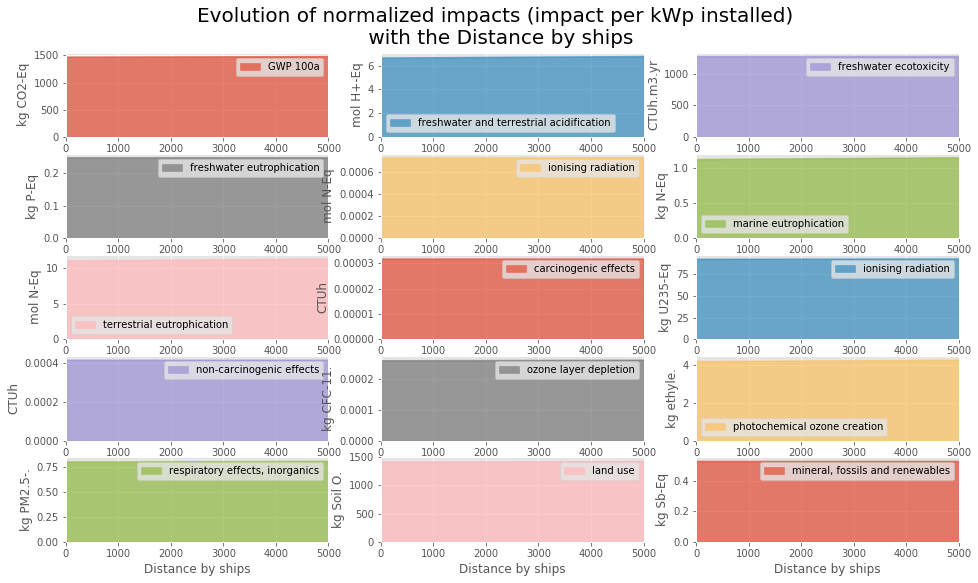

In [291]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

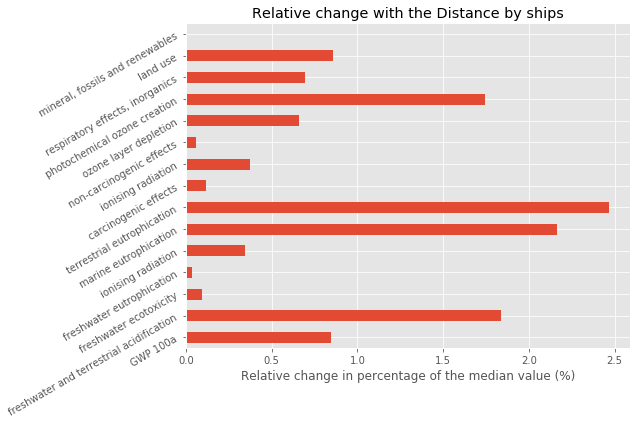

In [292]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Recycling Rate

In [293]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.75,1.1, 0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = i,
                                             electricity_recycling = 50, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_recycling_rate.pkl')
DF_impact

0.75
0.85
0.95
1.0499999999999998


0.75  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14780.691059   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.437994   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12735.081642   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478317   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007318   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.418414   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.611570   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    919.240159   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004136   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002603   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.574922   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.995796   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14253.374974   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259556   

                                                            0.85  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14796.318801   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.450998   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12733.864624   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478349   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007319   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.421928   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.650828   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    919.347258   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004136   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002604   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.588111   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.996475   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14256.675816   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259567   

                                                            0.95          1.05  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14811.946543  14827.574285  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.464003     67.477007  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12732.647604  12731.430586  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478381      2.478413  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007320      0.007321  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.425441     11.428954  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.690085    112.729343  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317      0.000317  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    919.454356    919.561455  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004136      0.004136  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002606      0.002608  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.601299     42.614487  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.997155      7.997835  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14259.976658  14263.277499  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259578      5.259589

In [294]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_recycling_rate.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Recycling rate'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Recycling rate                                                          
0.75            1478.069106                                  6.743799   
0.85            1479.631880                                  6.745100   
0.95            1481.194654                                  6.746400   
1.05            1482.757429                                  6.747701   

                freshwater ecotoxicity  freshwater eutrophication  \
Recycling rate                                                      
0.75                       1273.508164                   0.247832   
0.85                       1273.386462                   0.247835   
0.95                       1273.264760                   0.247838   
1.05                       1273.143059                   0.247841   

                ionising radiation  marine eutrophication  \
Recycling rate                                              
0.75                      0.000732               1.141841   
0.85                      0.000732               1.142193   
0.95                      0.000732               1.142544   
1.05                      0.000732               1.142895   

                terrestrial eutrophication  carcinogenic effects  \
Recycling rate                                                     
0.75                             11.261157              0.000032   
0.85                             11.265083              0.000032   
0.95                             11.269009              0.000032   
1.05                             11.272934              0.000032   

                ionising radiation  non-carcinogenic effects  \
Recycling rate                                                 
0.75                     91.924016                  0.000414   
0.85                     91.934726                  0.000414   
0.95                     91.945436                  0.000414   
1.05                     91.956146                  0.000414   

                ozone layer depletion  photochemical ozone creation  \
Recycling rate                                                        
0.75                         0.000260                      4.257492   
0.85                         0.000260                      4.258811   
0.95                         0.000261                      4.260130   
1.05                         0.000261                      4.261449   

                respiratory effects, inorganics     land use  \
Recycling rate                                                 
0.75                                   0.799580  1425.337497   
0.85                                   0.799648  1425.667582   
0.95                                   0.799715  1425.997666   
1.05                                   0.799783  1426.327750   

                mineral, fossils and renewables  
Recycling rate                                   
0.75                                   0.525956  
0.85                                   0.525957  
0.95                                   0.525958  
1.05                                   0.525959

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Recycling rate')

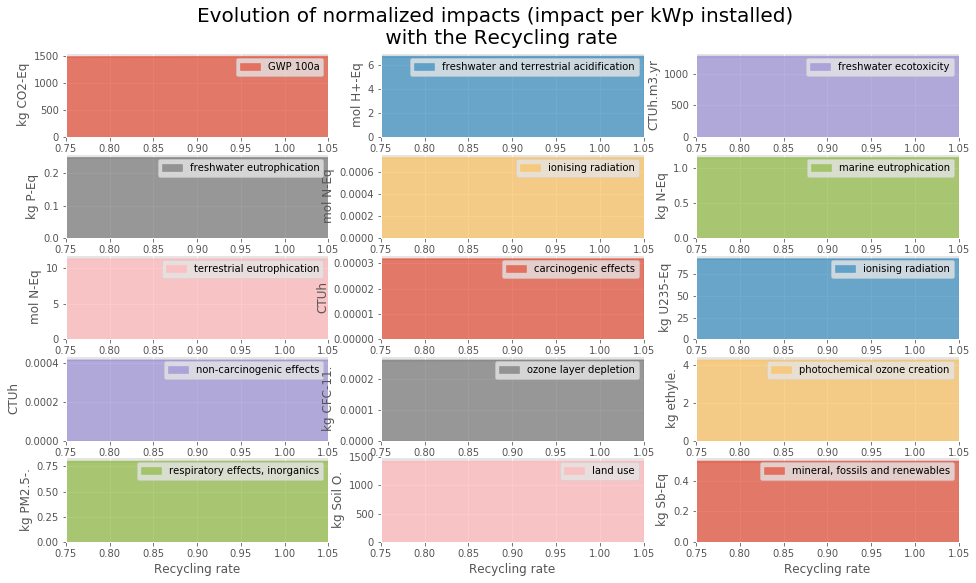

In [295]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

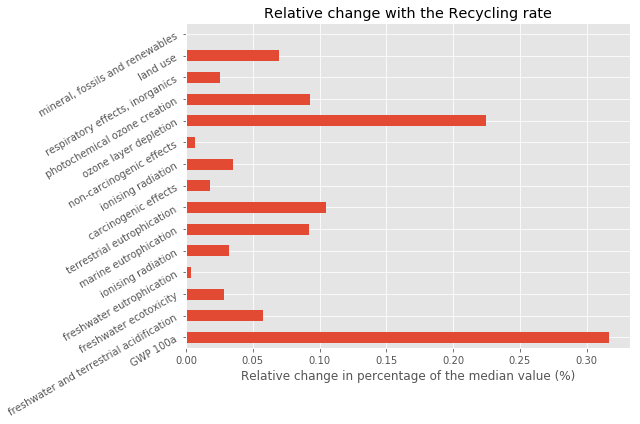

In [296]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Electricity for Recycling 

In [297]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(50,101,20):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = i, 
                                             heat_recycling = 75,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_recycling_electricity.pkl')
DF_impact

50
70
90


50  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14843.324553   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.490907   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12734.305208   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478448   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007321   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.432752   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.771771   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    919.678241   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004136   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002610   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.628583   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.998688   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14268.144567   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259606   

                                                              70            90  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14859.729668  14876.134784  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.508640     67.526374  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12735.271857  12736.238505  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478527      2.478607  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007337      0.007352  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.437086     11.441421  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.820787    112.869804  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317      0.000317  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    921.625224    923.572206  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004137      0.004137  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002614      0.002617  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.643959     42.659336  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.999782      8.000877  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14272.806507  14277.468448  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259709      5.259812

In [298]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_recycling_electricity.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Electricity for recycling'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  \
Electricity for recycling                
50                         1484.332455   
70                         1485.972967   
90                         1487.613478   

                           freshwater and terrestrial acidification  \
Electricity for recycling                                             
50                                                         6.749091   
70                                                         6.750864   
90                                                         6.752637   

                           freshwater ecotoxicity  freshwater eutrophication  \
Electricity for recycling                                                      
50                                    1273.430521                   0.247845   
70                                    1273.527186                   0.247853   
90                                    1273.623851                   0.247861   

                           ionising radiation  marine eutrophication  \
Electricity for recycling                                              
50                                   0.000732               1.143275   
70                                   0.000734               1.143709   
90                                   0.000735               1.144142   

                           terrestrial eutrophication  carcinogenic effects  \
Electricity for recycling                                                     
50                                          11.277177              0.000032   
70                                          11.282079              0.000032   
90                                          11.286980              0.000032   

                           ionising radiation  non-carcinogenic effects  \
Electricity for recycling                                                 
50                                  91.967824                  0.000414   
70                                  92.162522                  0.000414   
90                                  92.357221                  0.000414   

                           ozone layer depletion  \
Electricity for recycling                          
50                                      0.000261   
70                                      0.000261   
90                                      0.000262   

                           photochemical ozone creation  \
Electricity for recycling                                 
50                                             4.262858   
70                                             4.264396   
90                                             4.265934   

                           respiratory effects, inorganics     land use  \
Electricity for recycling                                                 
50                                                0.799869  1426.814457   
70                                                0.799978  1427.280651   
90                                                0.800088  1427.746845   

                           mineral, fossils and renewables  
Electricity for recycling                                   
50                                                0.525961  
70                                                0.525971  
90                                                0.525981

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Electricity for recycling')

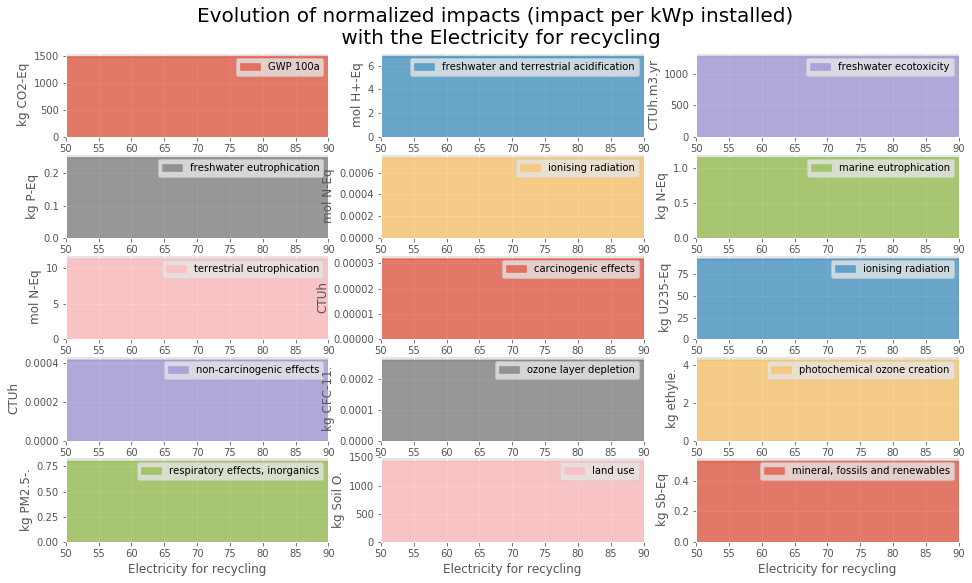

In [299]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

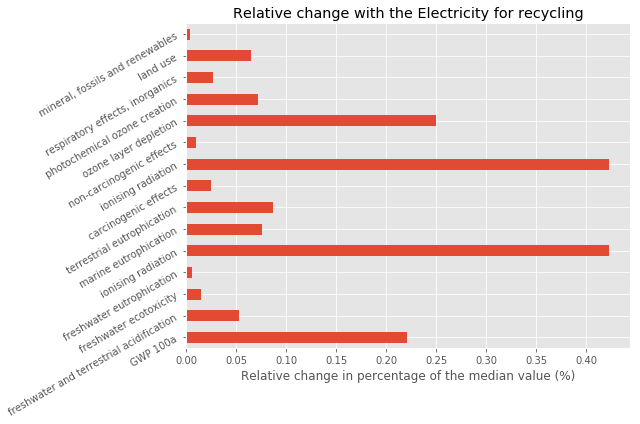

In [300]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Heat for Recycling

In [301]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(75,151,20):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = i,
                                             SiC_recycled_share=0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_recycling_heat.pkl')
DF_impact

75
95
115
135


75   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14890.354811   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.530994   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12735.564122   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478547   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007324   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.443634   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.893348   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    920.011163   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004137   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002616   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.669236   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.000934   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14279.926563   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259645   

                                                             95   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14906.060310   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.550141   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12735.988036   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478581   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007325   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.447447   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.959336   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    920.122327   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004137   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002618   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.682840   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.001819   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14283.871355   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259658   

                                                             115           135  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14921.765809  14937.471308  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.569287     67.588433  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12736.411951  12736.835865  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.478614      2.478648  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007325      0.007326  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.451260     11.455073  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.025325    113.091313  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317      0.000317  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    920.233491    920.344655  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004137      0.004137  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002620      0.002622  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.696444     42.710048  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.002704      8.003589  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14287.816147  14291.760939  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259672      5.259685

In [302]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_recycling_heat.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Heat for recycling'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Heat for recycling                                                          
75                  1489.035481                                  6.753099   
95                  1490.606031                                  6.755014   
115                 1492.176581                                  6.756929   
135                 1493.747131                                  6.758843   

                    freshwater ecotoxicity  freshwater eutrophication  \
Heat for recycling                                                      
75                             1273.556412                   0.247855   
95                             1273.598804                   0.247858   
115                            1273.641195                   0.247861   
135                            1273.683587                   0.247865   

                    ionising radiation  marine eutrophication  \
Heat for recycling                                              
75                            0.000732               1.144363   
95                            0.000732               1.144745   
115                           0.000733               1.145126   
135                           0.000733               1.145507   

                    terrestrial eutrophication  carcinogenic effects  \
Heat for recycling                                                     
75                                   11.289335              0.000032   
95                                   11.295934              0.000032   
115                                  11.302532              0.000032   
135                                  11.309131              0.000032   

                    ionising radiation  non-carcinogenic effects  \
Heat for recycling                                                 
75                           92.001116                  0.000414   
95                           92.012233                  0.000414   
115                          92.023349                  0.000414   
135                          92.034465                  0.000414   

                    ozone layer depletion  photochemical ozone creation  \
Heat for recycling                                                        
75                               0.000262                      4.266924   
95                               0.000262                      4.268284   
115                              0.000262                      4.269644   
135                              0.000262                      4.271005   

                    respiratory effects, inorganics     land use  \
Heat for recycling                                                 
75                                         0.800093  1427.992656   
95                                         0.800182  1428.387135   
115                                        0.800270  1428.781615   
135                                        0.800359  1429.176094   

                    mineral, fossils and renewables  
Heat for recycling                                   
75                                         0.525965  
95                                         0.525966  
115                                        0.525967  
135                                        0.525968

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Heat for recycling')

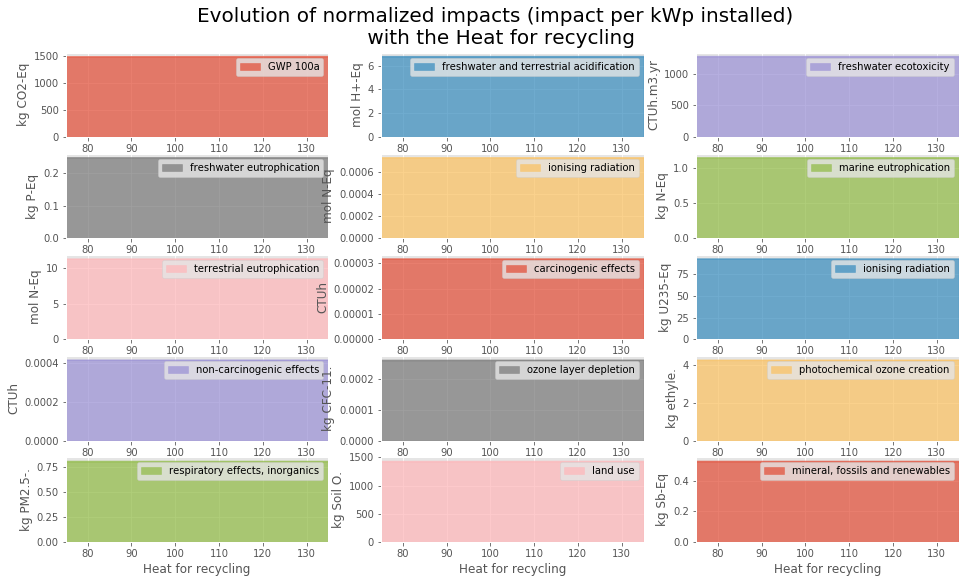

In [303]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

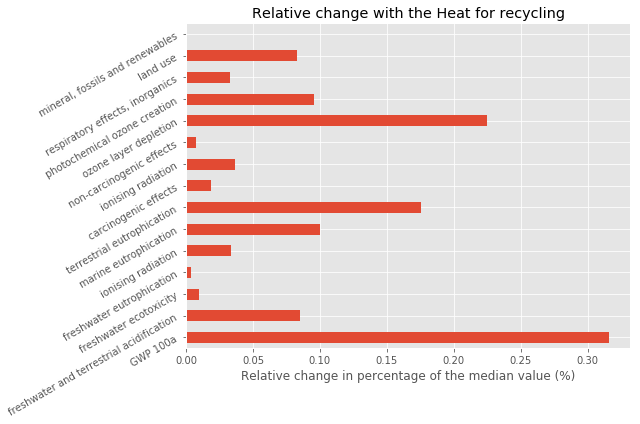

In [304]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Recycled SiC

In [305]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.528,1,0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= i, 
                                             TEG_recycled_share = 0.899,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_recycled_SiC.pkl')
DF_impact

0.528
0.628
0.728
0.828
0.9279999999999999


0.528  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15080.985612   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     68.312706   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12764.232678   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.484478   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007377   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.546446   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.147163   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    926.537847   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004144   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002630   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.996505   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.098431   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14382.981418   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260119   

                                                           0.628  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15019.600694   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.887531   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12748.393403   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.481018   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007348   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.496884   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.530797   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.984495   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004140   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002628   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.845562   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.042256   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14334.291481   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259878   

                                                           0.728  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14958.215801   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.462356   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12732.554135   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.477558   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007318   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.447322   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.914432   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    919.431145   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004136   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002627   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.694618   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.986080   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14285.601563   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.259638   

                                                           0.828         0.928  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14896.830891  14835.445985  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.037181     66.612006  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12716.714861  12700.875589  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.474098      2.470638  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007289      0.007260  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.397759     11.348197  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    112.298066    111.681700  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000317      0.000317  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    915.87779

In [306]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_recycled_SiC.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Share of recycled SiC'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Share of recycled SiC                                                          
0.528                  1508.098561                                  6.831271   
0.628                  1501.960069                                  6.788753   
0.728                  1495.821580                                  6.746236   
0.828                  1489.683089                                  6.703718   
0.928                  1483.544599                                  6.661201   

                       freshwater ecotoxicity  freshwater eutrophication  \
Share of recycled SiC                                                      
0.528                             1276.423268                   0.248448   
0.628                             1274.839340                   0.248102   
0.728                             1273.255413                   0.247756   
0.828                             1271.671486                   0.247410   
0.928                             1270.087559                   0.247064   

                       ionising radiation  marine eutrophication  \
Share of recycled SiC                                              
0.528                            0.000738               1.154645   
0.628                            0.000735               1.149688   
0.728                            0.000732               1.144732   
0.828                            0.000729               1.139776   
0.928                            0.000726               1.134820   

                       terrestrial eutrophication  carcinogenic effects  \
Share of recycled SiC                                                     
0.528                                   11.414716              0.000032   
0.628                                   11.353080              0.000032   
0.728                                   11.291443              0.000032   
0.828                                   11.229807              0.000032   
0.928                                   11.168170              0.000032   

                       ionising radiation  non-carcinogenic effects  \
Share of recycled SiC                                                 
0.528                           92.653785                  0.000414   
0.628                           92.298450                  0.000414   
0.728                           91.943114                  0.000414   
0.828                           91.587779                  0.000413   
0.928                           91.232444                  0.000413   

                       ozone layer depletion  photochemical ozone creation  \
Share of recycled SiC                                                        
0.528                               0.000263                      4.299651   
0.628                               0.000263                      4.284556   
0.728                               0.000263                      4.269462   
0.828                               0.000263                      4.254367   
0.928                               0.000262                      4.239273   

                       respiratory effects, inorganics     land use  \
Share of recycled SiC                                                 
0.528                                         0.809843  1438.298142   
0.628                                         0.804226  1433.429148   
0.728                                         0.798608  1428.560156   
0.828                                         0.792990  1423.691163   
0.928                                         0.787373  1418.822170   

                       mineral, fossils and renewables  
Share of recycled SiC                                   
0.528                                         0.526012  
0.628                                         0.525988  
0.728                                         0.525964  
0.828                                         0.525940  
0.928                                       

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Share of recycled SiC')

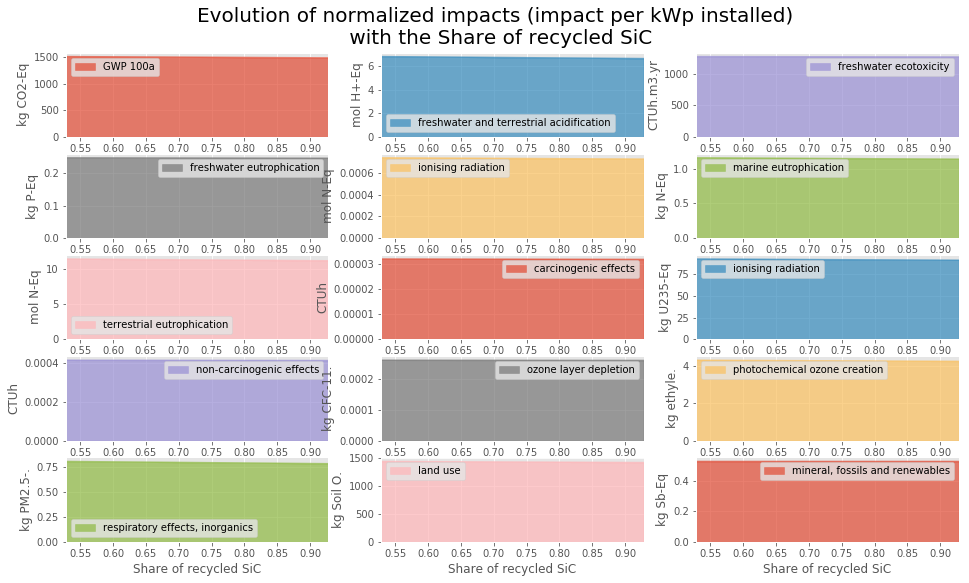

In [307]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

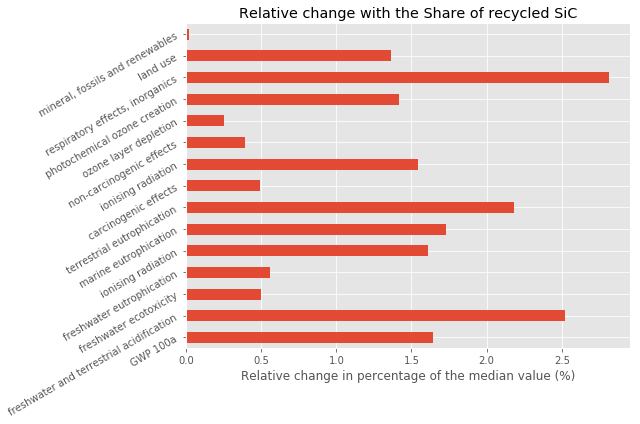

In [308]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Recycled TEG

In [309]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.528,1,0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = i,
                                             DW=False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_recycled_TEG.pkl')
DF_impact

0.528
0.628
0.728
0.828
0.9279999999999999


0.528  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15099.774191   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.948989   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12765.102755   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.481983   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007331   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.530127   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.798276   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    920.841000   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004141   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002634   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.035682   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.052011   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14322.368878   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.262116   

                                                           0.628  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15097.033919   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.882179   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12758.578545   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.481170   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007332   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.519242   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.693539   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    920.997509   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004140   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002636   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.983335   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.040812   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14324.383689   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.261495   

                                                           0.728  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15094.293640   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.815368   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12752.054333   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.480358   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007333   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.508357   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.588802   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    921.154018   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004139   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002638   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.930988   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.029612   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14326.398497   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260874   

                                                           0.828         0.928  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15091.553368  15088.813091  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.748557     67.681746  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12745.530123  12739.005911  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479545      2.478732  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007333      0.007334  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.497472     11.486588  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.484065    113.379328  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318      0.000318  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    921.31052

In [310]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_recycled_TEG.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Share of recycled TEG'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Share of recycled TEG                                                          
0.528                  1509.977419                                  6.794899   
0.628                  1509.703392                                  6.788218   
0.728                  1509.429364                                  6.781537   
0.828                  1509.155337                                  6.774856   
0.928                  1508.881309                                  6.768175   

                       freshwater ecotoxicity  freshwater eutrophication  \
Share of recycled TEG                                                      
0.528                             1276.510276                   0.248198   
0.628                             1275.857855                   0.248117   
0.728                             1275.205433                   0.248036   
0.828                             1274.553012                   0.247954   
0.928                             1273.900591                   0.247873   

                       ionising radiation  marine eutrophication  \
Share of recycled TEG                                              
0.528                            0.000733               1.153013   
0.628                            0.000733               1.151924   
0.728                            0.000733               1.150836   
0.828                            0.000733               1.149747   
0.928                            0.000733               1.148659   

                       terrestrial eutrophication  carcinogenic effects  \
Share of recycled TEG                                                     
0.528                                   11.379828              0.000032   
0.628                                   11.369354              0.000032   
0.728                                   11.358880              0.000032   
0.828                                   11.348406              0.000032   
0.928                                   11.337933              0.000032   

                       ionising radiation  non-carcinogenic effects  \
Share of recycled TEG                                                 
0.528                           92.084100                  0.000414   
0.628                           92.099751                  0.000414   
0.728                           92.115402                  0.000414   
0.828                           92.131053                  0.000414   
0.928                           92.146704                  0.000414   

                       ozone layer depletion  photochemical ozone creation  \
Share of recycled TEG                                                        
0.528                               0.000263                      4.303568   
0.628                               0.000264                      4.298334   
0.728                               0.000264                      4.293099   
0.828                               0.000264                      4.287864   
0.928                               0.000264                      4.282629   

                       respiratory effects, inorganics     land use  \
Share of recycled TEG                                                 
0.528                                         0.805201  1432.236888   
0.628                                         0.804081  1432.438369   
0.728                                         0.802961  1432.639850   
0.828                                         0.801841  1432.841331   
0.928                                         0.800721  1433.042812   

                       mineral, fossils and renewables  
Share of recycled TEG                                   
0.528                                         0.526212  
0.628                                         0.526149  
0.728                                         0.526087  
0.828                                         0.526025  
0.928                                       

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Share of recycled TEG')

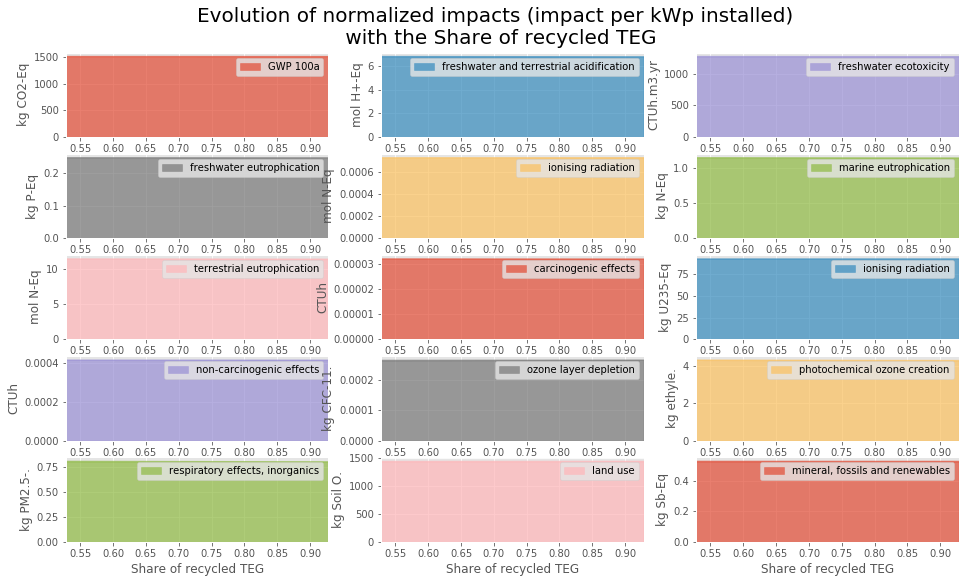

In [311]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

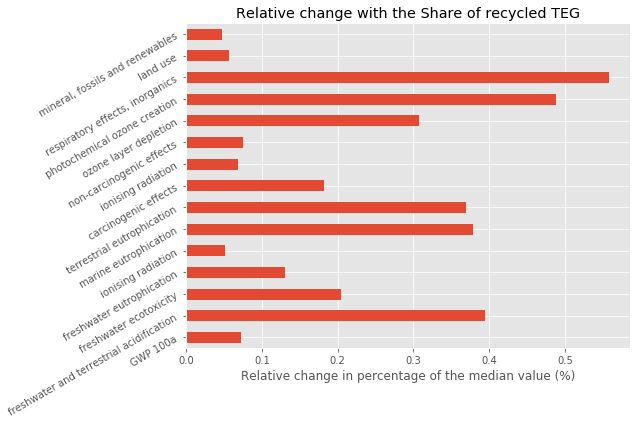

In [312]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### DW

In [313]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in [True, False]:
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.92, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW=i)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_DW.pkl')
DF_impact

True
By selecting diamond wiring: it is advised to consider 15% less silicon used (translated into 15% less kerf loss) when compared to the traditional cutting process
False


True          False
(ILCD 1.0.8 2016 midpoint no LT, climate change...  14830.938943  15127.555441
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     66.177174     67.744827
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12675.276939  12744.694257
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.465750      2.479223
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007223      0.007338
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.301389     11.499800
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    111.045779    113.527846
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000316      0.000318
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    907.820802    921.875479
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004123      0.004139
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002630      0.002646
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.240646     42.878481
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      7.813603      8.013487
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14126.314398  14341.446766
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.257336      5.260049

In [314]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_DW.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Diamond Wiring (DW) cutting process'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  \
Diamond Wiring (DW) cutting process                
True                                 1483.093894   
False                                1512.755544   

                                     freshwater and terrestrial acidification  \
Diamond Wiring (DW) cutting process                                             
True                                                                 6.617717   
False                                                                6.774483   

                                     freshwater ecotoxicity  \
Diamond Wiring (DW) cutting process                           
True                                            1267.527694   
False                                           1274.469426   

                                     freshwater eutrophication  \
Diamond Wiring (DW) cutting process                              
True                                                  0.246575   
False                                                 0.247922   

                                     ionising radiation  \
Diamond Wiring (DW) cutting process                       
True                                           0.000722   
False                                          0.000734   

                                     marine eutrophication  \
Diamond Wiring (DW) cutting process                          
True                                              1.130139   
False                                             1.149980   

                                     terrestrial eutrophication  \
Diamond Wiring (DW) cutting process                               
True                                                  11.104578   
False                                                 11.352785   

                                     carcinogenic effects  ionising radiation  \
Diamond Wiring (DW) cutting process                                             
True                                             0.000032           90.782080   
False                                            0.000032           92.187548   

                                     non-carcinogenic effects  \
Diamond Wiring (DW) cutting process                             
True                                                 0.000412   
False                                                0.000414   

                                     ozone layer depletion  \
Diamond Wiring (DW) cutting process                          
True                                              0.000263   
False                                             0.000265   

                                     photochemical ozone creation  \
Diamond Wiring (DW) cutting process                                 
True                                                     4.224065   
False                                                    4.287848   

                                     respiratory effects, inorganics  \
Diamond Wiring (DW) cutting process                                    
True                                                        0.781360   
False                                                       0.801349   

                                        land use  \
Diamond Wiring (DW) cutting process                
True                                 1412.631440   
False                                1434.144677   

                                     mineral, fossils and renewables  
Diamond Wiring (DW) cutting process                                   
True                                                        0.525734  
False                                                       0.526005

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Diamond Wiring (DW) cutting process')

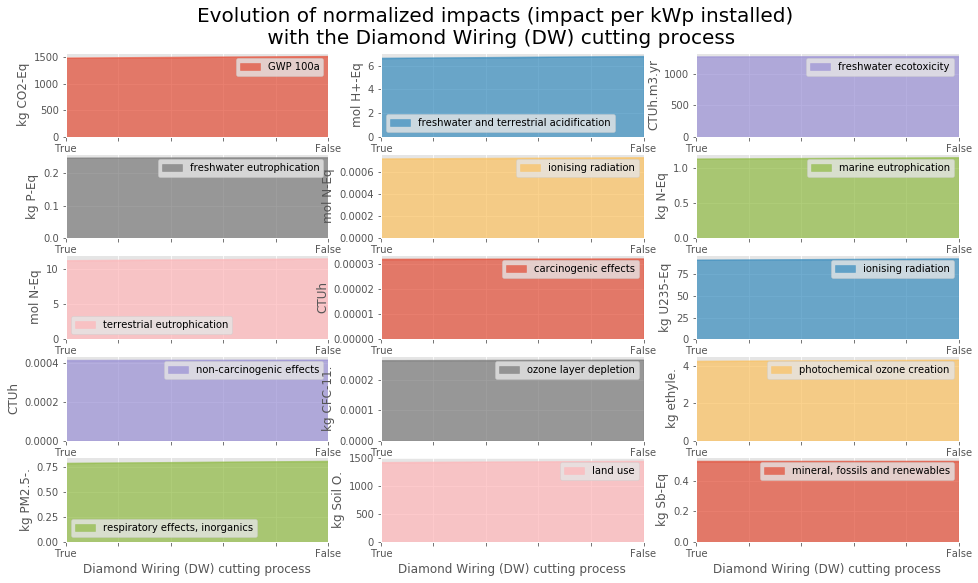

In [315]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

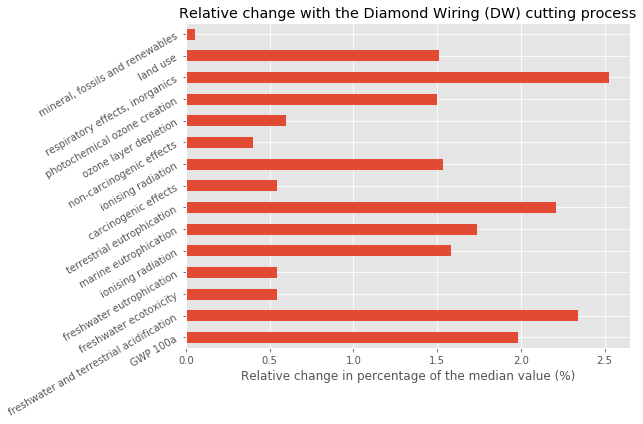

In [316]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Aluminum Recycling Rate

In [317]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.56,1.1, 0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = i, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW= False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_aluminum_recycling_share.pkl')
DF_impact

0.56
0.66
0.76
0.86
0.96
1.06


0.56  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15143.232469   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.758191   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12745.114335   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479256   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007338   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.503427   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.568378   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    921.986472   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004139   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002648   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.892034   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.014236   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14345.376190   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260062   

                                                            0.66  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15158.909145   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.771553   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12745.533851   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479289   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007339   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.507054   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.608902   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.097441   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004139   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002650   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.905585   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.014985   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14349.302941   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260075   

                                                            0.76  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15174.585821   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.784915   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12745.953366   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479322   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007340   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.510681   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.649426   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.208409   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004139   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002652   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.919136   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.015734   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14353.229692   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260089   

                                                            0.86  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15190.262497   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.798277   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12746.372882   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479355   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007341   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.514309   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.689950   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.319378   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004140   
(ILCD 1.0.8 2016 midpoint no LT, human health

In [318]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_aluminum_recycling_share.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Aluminum recycling rate'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  \
Aluminum recycling rate                
0.56                     1514.323247   
0.66                     1515.890914   
0.76                     1517.458582   
0.86                     1519.026250   
0.96                     1520.593917   
1.06                     1522.161585   

                         freshwater and terrestrial acidification  \
Aluminum recycling rate                                             
0.56                                                     6.775819   
0.66                                                     6.777155   
0.76                                                     6.778492   
0.86                                                     6.779828   
0.96                                                     6.781164   
1.06                                                     6.782500   

                         freshwater ecotoxicity  freshwater eutrophication  \
Aluminum recycling rate                                                      
0.56                                1274.511433                   0.247926   
0.66                                1274.553385                   0.247929   
0.76                                1274.595337                   0.247932   
0.86                                1274.637288                   0.247936   
0.96                                1274.679240                   0.247939   
1.06                                1274.721191                   0.247942   

                         ionising radiation  marine eutrophication  \
Aluminum recycling rate                                              
0.56                               0.000734               1.150343   
0.66                               0.000734               1.150705   
0.76                               0.000734               1.151068   
0.86                               0.000734               1.151431   
0.96                               0.000734               1.151794   
1.06                               0.000734               1.152156   

                         terrestrial eutrophication  carcinogenic effects  \
Aluminum recycling rate                                                     
0.56                                      11.356838              0.000032   
0.66                                      11.360890              0.000032   
0.76                                      11.364943              0.000032   
0.86                                      11.368995              0.000032   
0.96                                      11.373047              0.000032   
1.06                                      11.377100              0.000032   

                         ionising radiation  non-carcinogenic effects  \
Aluminum recycling rate                                                 
0.56                              92.198647                  0.000414   
0.66                              92.209744                  0.000414   
0.76                              92.220841                  0.000414   
0.86                              92.231938                  0.000414   
0.96                              92.243035                  0.000414   
1.06                              92.254131                  0.000414   

                         ozone layer depletion  photochemical ozone creation  \
Aluminum recycling rate                                                        
0.56                                  0.000265                      4.289203   
0.66                                  0.000265                      4.290558   
0.76                                  0.000265                      4.291914   
0.86                                  0.000265                      4.293269   
0.96                                  0.000266                      4.294624   
1.06                                  0.000266                      4.295979   

                         respiratory effects, inorganics     land use  \
Aluminum recycling rate                             

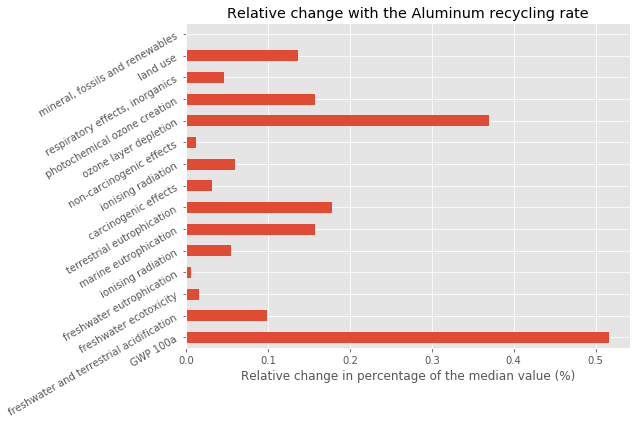

In [319]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Copper Recycling Rate

In [320]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.44,1, 0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.96, 
                                             recycling_rate_cu = i, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW= False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_copper_recycling_share.pkl')
DF_impact

0.44
0.54
0.6400000000000001
0.7400000000000001
0.8400000000000001
0.9400000000000002


0.44  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15237.327363   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.838589   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12750.344108   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479456   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007343   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.525259   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.812298   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.654674   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004140   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002660   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.973568   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.018796   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14369.201295   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260143   

                                                            0.54  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15252.992927   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.851879   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12749.888767   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479488   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007344   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.528864   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.852574   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.764880   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004140   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002662   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     42.987045   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.019523   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14373.043647   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260155   

                                                            0.64  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15268.658491   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.865169   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12749.433426   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479521   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007345   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.532469   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.892850   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.875086   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004140   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002664   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.000523   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.020251   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14376.885999   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260168   

                                                            0.74  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15284.324054   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.878459   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12748.978085   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479554   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007346   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.536074   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    113.933127   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    922.985292   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004140   
(ILCD 1.0.8 2016 midpoint no LT, human health

In [321]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_copper_recycling_share.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Copper recycling rate'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Copper recycling rate                                                          
0.44                   1523.732736                                  6.783859   
0.54                   1525.299293                                  6.785188   
0.64                   1526.865849                                  6.786517   
0.74                   1528.432405                                  6.787846   
0.84                   1529.998962                                  6.789175   
0.94                   1531.565518                                  6.790504   

                       freshwater ecotoxicity  freshwater eutrophication  \
Copper recycling rate                                                      
0.44                              1275.034411                   0.247946   
0.54                              1274.988877                   0.247949   
0.64                              1274.943343                   0.247952   
0.74                              1274.897809                   0.247955   
0.84                              1274.852274                   0.247959   
0.94                              1274.806740                   0.247962   

                       ionising radiation  marine eutrophication  \
Copper recycling rate                                              
0.44                             0.000734               1.152526   
0.54                             0.000734               1.152886   
0.64                             0.000734               1.153247   
0.74                             0.000735               1.153607   
0.84                             0.000735               1.153968   
0.94                             0.000735               1.154328   

                       terrestrial eutrophication  carcinogenic effects  \
Copper recycling rate                                                     
0.44                                    11.381230              0.000032   
0.54                                    11.385257              0.000032   
0.64                                    11.389285              0.000032   
0.74                                    11.393313              0.000032   
0.84                                    11.397340              0.000032   
0.94                                    11.401368              0.000032   

                       ionising radiation  non-carcinogenic effects  \
Copper recycling rate                                                 
0.44                            92.265467                  0.000414   
0.54                            92.276488                  0.000414   
0.64                            92.287509                  0.000414   
0.74                            92.298529                  0.000414   
0.84                            92.309550                  0.000414   
0.94                            92.320570                  0.000414   

                       ozone layer depletion  photochemical ozone creation  \
Copper recycling rate                                                        
0.44                                0.000266                      4.297357   
0.54                                0.000266                      4.298705   
0.64                                0.000266                      4.300052   
0.74                                0.000267                      4.301400   
0.84                                0.000267                      4.302748   
0.94                                0.000267                      4.304096   

                       respiratory effects, inorganics     land use  \
Copper recycling rate                                                 
0.44                                          0.801880  1436.920130   
0.54                                          0.801952  1437.304365   
0.64                                          0.802025  1437.688600   
0.74                                          0.802098  1438.072835   
0.84      

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Copper recycling rate')

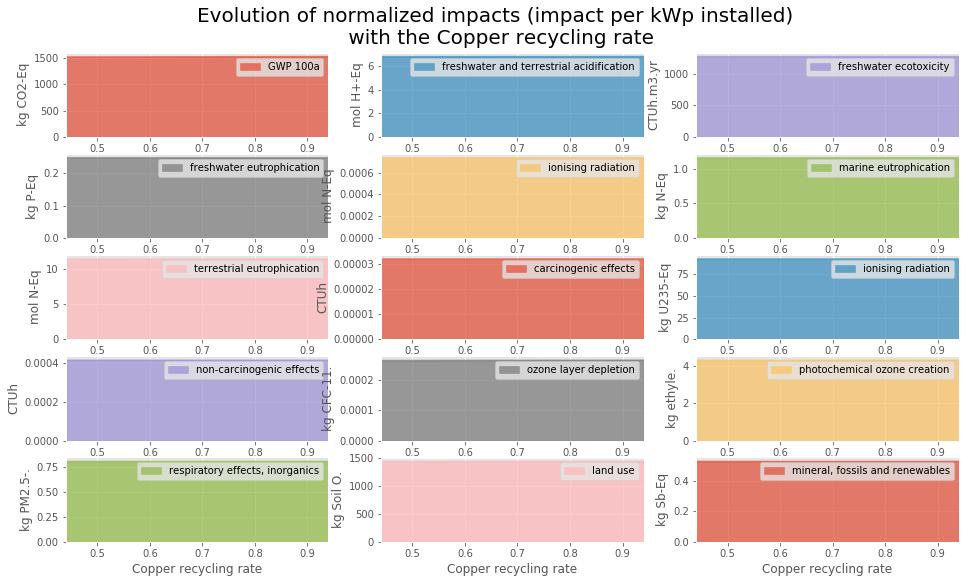

In [322]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

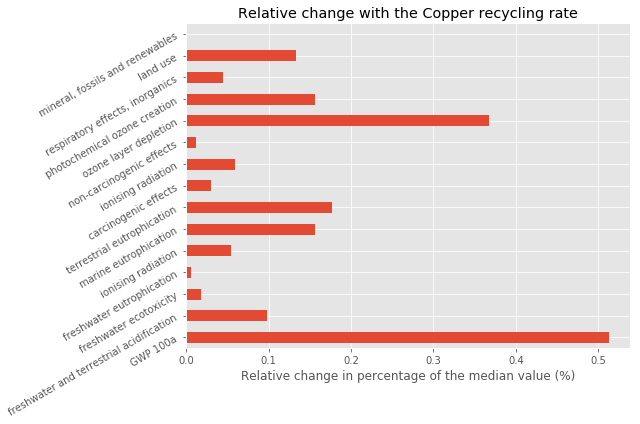

In [323]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Glass Recycling Share

In [324]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.6,1, 0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.96, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = i,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW= False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = myMultiLCA.results.T

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_glass_recycling_share.pkl')
DF_impact

0.6
0.7
0.7999999999999999
0.8999999999999999


0.6  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15333.101271   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.931735   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12752.750347   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479704   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007349   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.551173   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.102153   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    923.474732   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004141   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002672   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.067715   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.024586   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14417.589466   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260297   

                                                             0.7  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15348.195331   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.940699   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12752.303036   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479720   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007350   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.553393   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.126854   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    923.533507   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004141   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002674   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.076910   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.024880   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14413.154259   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260284   

                                                             0.8           0.9  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  15363.289391  15378.383450  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     67.949663     67.958627  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  12751.855725  12751.408414  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      2.479737      2.479753  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...      0.007350      0.007351  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...     11.555614     11.557834  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...    114.151555    114.176256  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.000318      0.000318  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...    923.592283    923.651058  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.004141      0.004141  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      0.002675      0.002677  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...     43.086106     43.095301  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...      8.025175      8.025469  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  14408.719053  14404.283846  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...      5.260272      5.260260

In [325]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_glass_recycling_share.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Glass recycling rate'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Glass recycling rate                                                          
0.6                   1533.310127                                  6.793174   
0.7                   1534.819533                                  6.794070   
0.8                   1536.328939                                  6.794966   
0.9                   1537.838345                                  6.795863   

                      freshwater ecotoxicity  freshwater eutrophication  \
Glass recycling rate                                                      
0.6                              1275.275035                   0.247970   
0.7                              1275.230304                   0.247972   
0.8                              1275.185573                   0.247974   
0.9                              1275.140841                   0.247975   

                      ionising radiation  marine eutrophication  \
Glass recycling rate                                              
0.6                             0.000735               1.155117   
0.7                             0.000735               1.155339   
0.8                             0.000735               1.155561   
0.9                             0.000735               1.155783   

                      terrestrial eutrophication  carcinogenic effects  \
Glass recycling rate                                                     
0.6                                    11.410215              0.000032   
0.7                                    11.412685              0.000032   
0.8                                    11.415155              0.000032   
0.9                                    11.417626              0.000032   

                      ionising radiation  non-carcinogenic effects  \
Glass recycling rate                                                 
0.6                            92.347473                  0.000414   
0.7                            92.353351                  0.000414   
0.8                            92.359228                  0.000414   
0.9                            92.365106                  0.000414   

                      ozone layer depletion  photochemical ozone creation  \
Glass recycling rate                                                        
0.6                                0.000267                      4.306772   
0.7                                0.000267                      4.307691   
0.8                                0.000268                      4.308611   
0.9                                0.000268                      4.309530   

                      respiratory effects, inorganics     land use  \
Glass recycling rate                                                 
0.6                                          0.802459  1441.758947   
0.7                                          0.802488  1441.315426   
0.8                                          0.802517  1440.871905   
0.9                                          0.802547  1440.428385   

                      mineral, fossils and renewables  
Glass recycling rate                                   
0.6                                          0.526030  
0.7                                          0.526028  
0.8                                          0.526027  
0.9                                          0.526026

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Glass recycling rate')

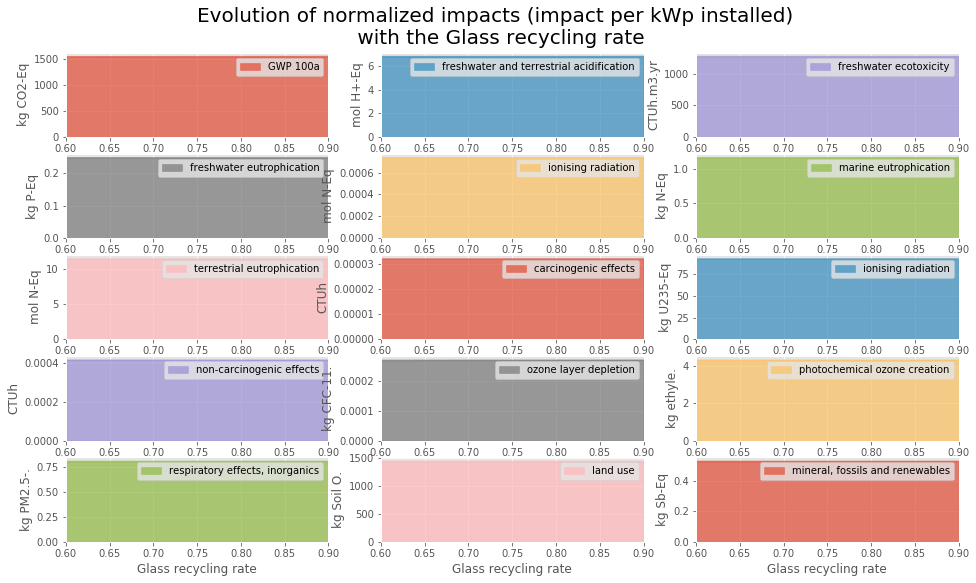

In [326]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

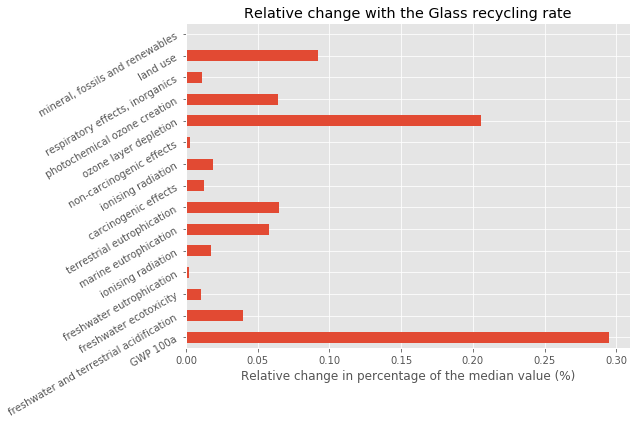

In [327]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Irradiation

In [328]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(900,2800, 200):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.96, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW= False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    DF_impact[i] = (myMultiLCA.results.T/(i*10*30))
    

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_irradiation.pkl')
DF_impact

900
1100
1300
1500
1700
1900
2100
2300
2500
2700


900   \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  5.701504e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.517481e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.722899e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  9.184392e-06   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.722758e-08   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.282023e-05   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.230251e-04   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.178641e-09   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  3.421341e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.533671e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.923073e-09   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.596624e-04   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.972673e-05   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  5.336375e-02   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.948249e-05   

                                                            1100  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  4.669617e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.060162e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.864317e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  7.514603e-06   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.227957e-08   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.504572e-05   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.462343e-04   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.644026e-10   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.799615e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.254853e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  8.124822e-09   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.306739e-04   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.432414e-05   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  4.367315e-02   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.594026e-05   

                                                            1300  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  3.955234e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.743557e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.269915e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  6.358595e-06   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.885403e-08   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.966337e-05   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.930714e-04   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  8.160839e-10   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.369190e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.061825e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  6.879879e-09   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.106050e-04   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.058389e-05   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  3.696427e-02   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.348795e-05   

                                                            1500  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  3.431353e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.511379e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.834019e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  5.510856e-06   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.634196e-08   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.571632e-05   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.540852e-04   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  7.073169e-10   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.053544e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.202717e-09   
(ILCD 1.0.8 2016 midpoint no LT, human health

In [329]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_irradiation.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Irradiation'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Irradiation                                                       
900          0.005702                                  0.000025   
1100         0.004670                                  0.000021   
1300         0.003955                                  0.000017   
1500         0.003431                                  0.000015   
1700         0.003031                                  0.000013   
1900         0.002714                                  0.000012   
2100         0.002458                                  0.000011   
2300         0.002247                                  0.000010   
2500         0.002069                                  0.000009   
2700         0.001918                                  0.000008   

             freshwater ecotoxicity  freshwater eutrophication  \
Irradiation                                                      
900                        0.004723               9.184392e-07   
1100                       0.003864               7.514603e-07   
1300                       0.003270               6.358595e-07   
1500                       0.002834               5.510856e-07   
1700                       0.002501               4.862585e-07   
1900                       0.002238               4.350792e-07   
2100                       0.002024               3.936483e-07   
2300                       0.001849               3.594229e-07   
2500                       0.001701               3.306734e-07   
2700                       0.001575               3.061832e-07   

             ionising radiation  marine eutrophication  \
Irradiation                                              
900                2.722758e-09               0.000004   
1100               2.227957e-09               0.000004   
1300               1.885403e-09               0.000003   
1500               1.634196e-09               0.000003   
1700               1.442097e-09               0.000002   
1900               1.290440e-09               0.000002   
2100               1.167670e-09               0.000002   
2300               1.066251e-09               0.000002   
2500               9.810593e-10               0.000002   
2700               9.084886e-10               0.000001   

             terrestrial eutrophication  carcinogenic effects  \
Irradiation                                                     
900                            0.000042          1.178641e-10   
1100                           0.000035          9.644026e-11   
1300                           0.000029          8.160839e-11   
1500                           0.000025          7.073169e-11   
1700                           0.000022          6.241421e-11   
1900                           0.000020          5.584777e-11   
2100                           0.000018          5.053209e-11   
2300                           0.000017          4.614088e-11   
2500                           0.000015          4.245225e-11   
2700                           0.000014          3.931009e-11   

             ionising radiation  non-carcinogenic effects  \
Irradiation                                                 
900                    0.000342              1.533671e-09   
1100                   0.000280              1.254853e-09   
1300                   0.000237              1.061825e-09   
1500                   0.000205              9.202717e-10   
1700                   0.000181              8.120247e-10   
1900                   0.000162              7.265665e-10   
2100                   0.000147              6.573861e-10   
2300                   0.000134              6.002371e-10   
2500                   0.000123              5.522319e-10   
2700                   0.000114              5.113386e-10   

             ozone layer depletion  photochemical ozone creation  \
Irradiation                                                        
900                   9.923073e-10                      0.000016   


Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Irradiation')

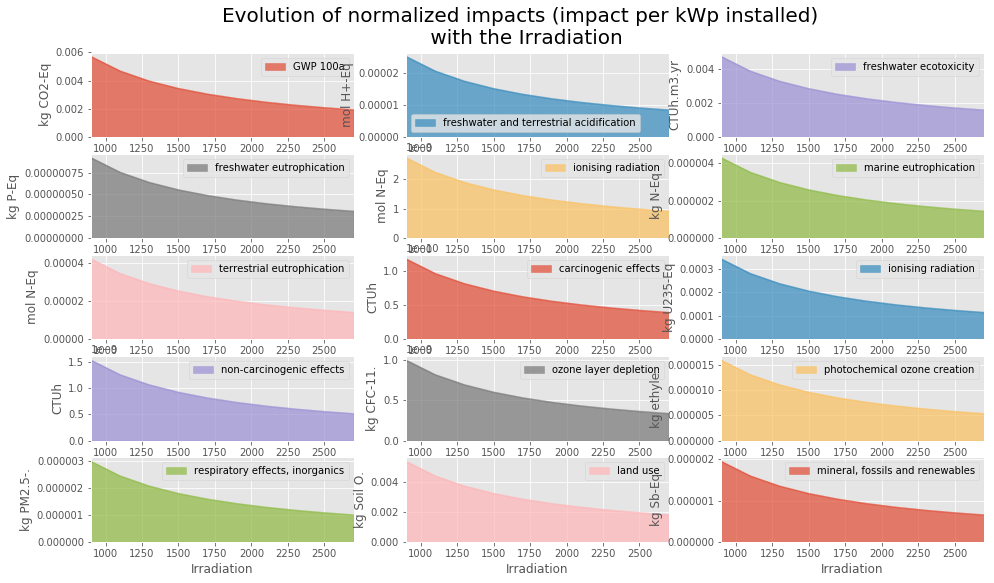

In [330]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

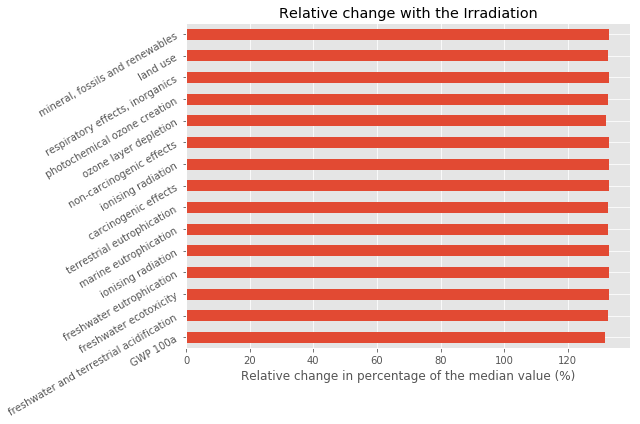

In [331]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### PR

In [332]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.64,1, 0.1):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.96, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW= False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    prod = assessed_PV_productivity(weather = weather['2017'], latitude = lat,
                                    longitude = lon, inclinaison = 30, 
                                    azimuth = 180, name = 'Antibes_Production',
                                    PR = i, altitude = 0, timezone = 'Europe/Paris', 
                                    DR = 0.005, lifespan = 30, tracker = False, 
                                    gcr = 0.3, backtrack = True, max_angle = 60) 
    DF_impact[i] = (myMultiLCA.results.T/prod[0])
    

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_PR.pkl')
DF_impact

0.64
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
0.74
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
0.84
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
0.94
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)


0.64  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  4.487186e-01   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.965185e-03   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.680746e-01   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  7.156369e-05   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.123601e-07   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.346522e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.307415e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.188333e-09   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.668714e-02   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.195157e-07   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  7.787510e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.247815e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.318123e-04   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  4.168816e-01   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.517888e-04   

                                                            0.74  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  3.884722e-01   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.699953e-03   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.183453e-01   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  6.189375e-05   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.836831e-07   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.895194e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.861478e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  7.947162e-09   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.308354e-02   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.033675e-07   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  6.740039e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.079529e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.005050e-04   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  3.606443e-01   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.312771e-04   

                                                            0.84          0.94  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  3.425701e-01  3.064345e-01  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.497871e-03  1.338786e-03  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.804563e-01  2.506287e-01  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  5.452617e-05  4.872617e-05  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.618339e-07  1.446335e-07  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.551326e-04  2.280621e-04  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.521717e-03  2.254245e-03  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  7.001508e-09  6.257057e-09  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.033794e-02  1.817651e-02  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.106413e-08  8.137849e-08  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  5.941966e-08  5.313695e-08  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.513117e-04  8.503746e-04  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.766519e-04  1.578738e-04  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  3.177968e-01  2.840658e-01  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.156492e-04  1.033463e-04

In [333]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_PR.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Performance Ratio (PR)'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Performance Ratio (PR)                                                       
0.64                    0.044872                                  0.000197   
0.74                    0.038847                                  0.000170   
0.84                    0.034257                                  0.000150   
0.94                    0.030643                                  0.000134   

                        freshwater ecotoxicity  freshwater eutrophication  \
Performance Ratio (PR)                                                      
0.64                                  0.036807                   0.000007   
0.74                                  0.031835                   0.000006   
0.84                                  0.028046                   0.000005   
0.94                                  0.025063                   0.000005   

                        ionising radiation  marine eutrophication  \
Performance Ratio (PR)                                              
0.64                          2.123601e-08               0.000033   
0.74                          1.836831e-08               0.000029   
0.84                          1.618339e-08               0.000026   
0.94                          1.446335e-08               0.000023   

                        terrestrial eutrophication  carcinogenic effects  \
Performance Ratio (PR)                                                     
0.64                                      0.000331          9.188333e-10   
0.74                                      0.000286          7.947162e-10   
0.84                                      0.000252          7.001508e-10   
0.94                                      0.000225          6.257057e-10   

                        ionising radiation  non-carcinogenic effects  \
Performance Ratio (PR)                                                 
0.64                              0.002669              1.195157e-08   
0.74                              0.002308              1.033675e-08   
0.84                              0.002034              9.106413e-09   
0.94                              0.001818              8.137849e-09   

                        ozone layer depletion  photochemical ozone creation  \
Performance Ratio (PR)                                                        
0.64                             7.787510e-09                      0.000125   
0.74                             6.740039e-09                      0.000108   
0.84                             5.941966e-09                      0.000095   
0.94                             5.313695e-09                      0.000085   

                        respiratory effects, inorganics  land use  \
Performance Ratio (PR)                                              
0.64                                           0.000023  0.041688   
0.74                                           0.000020  0.036064   
0.84                                           0.000018  0.031780   
0.94                                           0.000016  0.028407   

                        mineral, fossils and renewables  
Performance Ratio (PR)                                   
0.64                                           0.000015  
0.74                                           0.000013  
0.84                                           0.000012  
0.94                                           0.000010

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Performance Ratio (PR)')

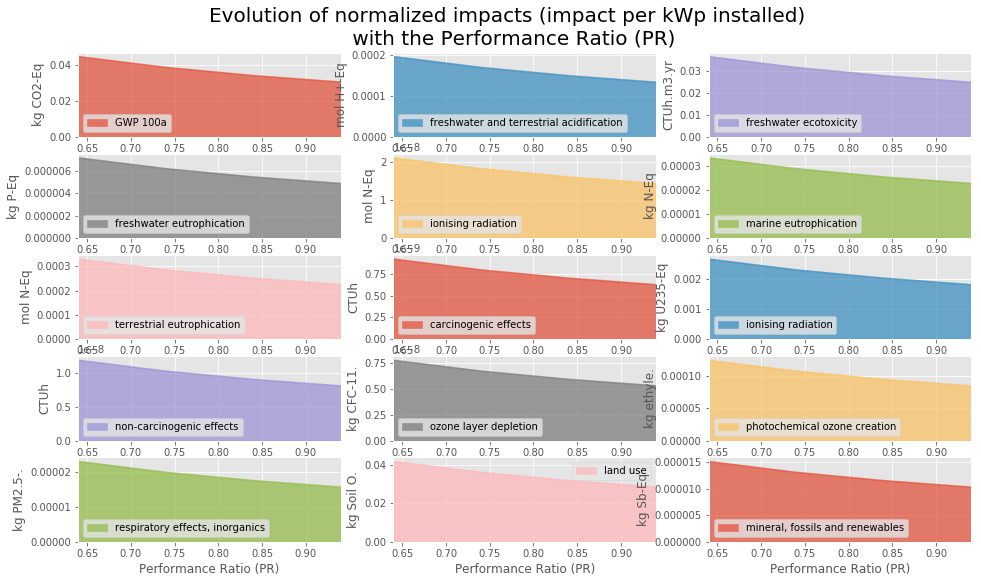

In [334]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

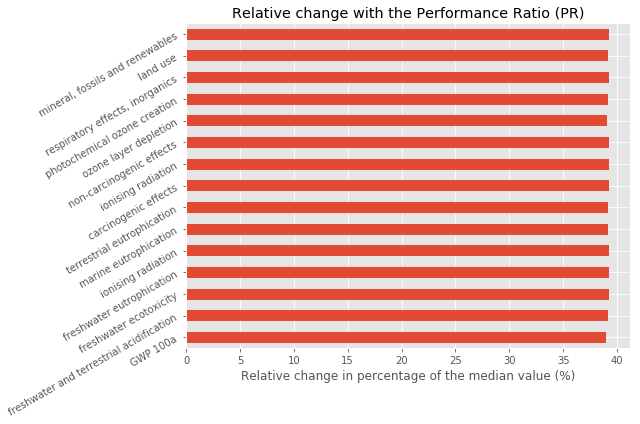

In [335]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Degradation Rate

In [382]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(0.05,0.08, 0.01):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.96, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW= False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    prod = assessed_PV_productivity(weather = weather['2017'], latitude = lat,
                                    longitude = lon, inclinaison = 30, 
                                    azimuth = 180, name = 'Antibes_Production',
                                    PR = 0.85, altitude = 0, timezone = 'Europe/Paris', 
                                    DR = i, lifespan = 30, tracker = False, 
                                    gcr = 0.3, backtrack = True, max_angle = 60) 
    DF_impact[i] = (myMultiLCA.results.T/prod[0])
    

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_DR.pkl')
DF_impact

0.05
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
0.060000000000000005
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
0.07
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)


0.05  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  6.169687e-01   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.644382e-03   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.931143e-01   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  9.582426e-05   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.850962e-07   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.517225e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.469315e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.231952e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  3.583711e-02   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.600824e-07   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.062833e-07   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.684361e-03   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  3.110674e-04   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  5.621016e-01   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  2.031867e-04   

                                                            0.06          0.07  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  6.898091e-01  7.665995e-01  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.954261e-03  3.280557e-03  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  5.508099e-01  6.115473e-01  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  1.070338e-04  1.188340e-04  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.184777e-07  3.536233e-07  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  5.047150e-04  5.605248e-04  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  4.993820e-03  5.546243e-03  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.376134e-08  1.527924e-08  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  4.003360e-02  4.445193e-02  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.788111e-07  1.985268e-07  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.187994e-07  1.319890e-07  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.881958e-03  2.090061e-03  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  3.474839e-04  3.858238e-04  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  6.280176e-01  6.974338e-01  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  2.269531e-04  2.519714e-04

In [402]:
DR = 0.07
(1.0-(1-DR)**(30))/(1-(1-DR))

12.666178992767133

In [404]:
15.7/12.6

1.246031746031746

In [391]:
(1-0.05)**30/(1-0.05)

0.22593554099256555

In [393]:
(1-0.07)**30/(1-0.07)

0.12190050592075256

In [383]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_DR.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Degradation rate'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Degradation rate                                                       
0.05              0.061697                                  0.000264   
0.06              0.068981                                  0.000295   
0.07              0.076660                                  0.000328   

                  freshwater ecotoxicity  freshwater eutrophication  \
Degradation rate                                                      
0.05                            0.049311                   0.000010   
0.06                            0.055081                   0.000011   
0.07                            0.061155                   0.000012   

                  ionising radiation  marine eutrophication  \
Degradation rate                                              
0.05                    2.850962e-08               0.000045   
0.06                    3.184777e-08               0.000050   
0.07                    3.536233e-08               0.000056   

                  terrestrial eutrophication  carcinogenic effects  \
Degradation rate                                                     
0.05                                0.000447          1.231952e-09   
0.06                                0.000499          1.376134e-09   
0.07                                0.000555          1.527924e-09   

                  ionising radiation  non-carcinogenic effects  \
Degradation rate                                                 
0.05                        0.003584              1.600824e-08   
0.06                        0.004003              1.788111e-08   
0.07                        0.004445              1.985268e-08   

                  ozone layer depletion  photochemical ozone creation  \
Degradation rate                                                        
0.05                       1.062833e-08                      0.000168   
0.06                       1.187994e-08                      0.000188   
0.07                       1.319890e-08                      0.000209   

                  respiratory effects, inorganics  land use  \
Degradation rate                                              
0.05                                     0.000031  0.056210   
0.06                                     0.000035  0.062802   
0.07                                     0.000039  0.069743   

                  mineral, fossils and renewables  
Degradation rate                                   
0.05                                     0.000020  
0.06                                     0.000023  
0.07                                     0.000025

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Degradation rate')

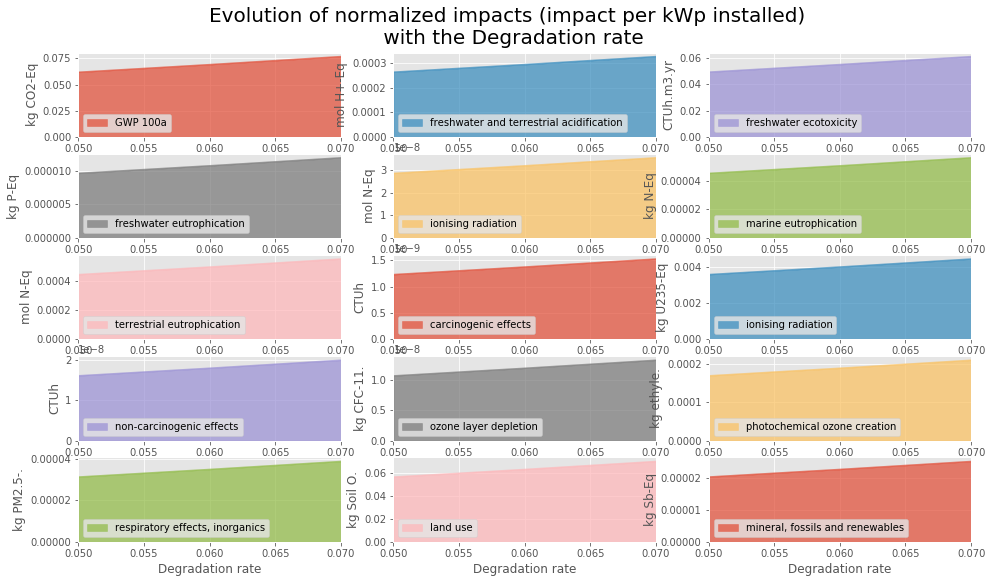

In [384]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

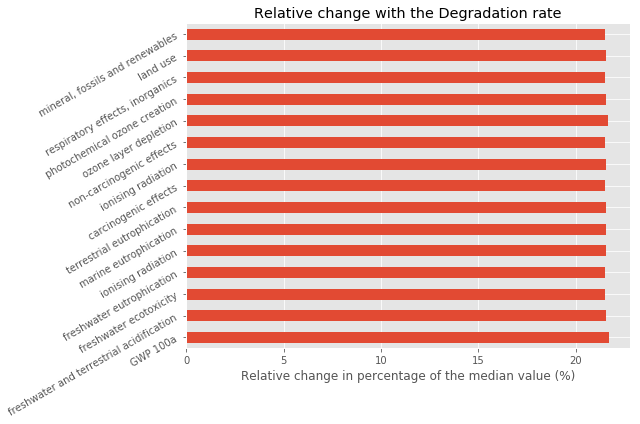

In [385]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

### Orientation

In [340]:
DF_impact = pd.DataFrame(index = list_methods,)

for i in np.arange(20,60, 10):
    print(i)
    system_inv = create_dictionary_PV_system(P = 10,
                                             P_module = 280, 
                                             module_efficiency = None, 
                                             roof = True,
                                             share_recycled_aluminium = 0.27, 
                                             elec_dataset = None,
                                             inverter_weight = None,  
                                             print_steps = False, 
                                             inverter_lifetime = 15, 
                                             PV_lifetime = 30, 
                                             glass_thickness = 4, 
                                             manufacturing_efficiency_gains = 0,
                                             kerf_loss = 0.44,
                                             wafer_thickness = 200, 
                                             silver_amount = 9.6, 
                                             Silicon_electricity_intensity = 30+10,
                                             d_lorry = 1020, 
                                             d_train = 350, 
                                             d_sea = 4000,
                                             recycling_rate_alu = 0.96, 
                                             recycling_rate_cu = 0.75, 
                                             recycling_rate_glass = 0.9,
                                             recycling_rate = 0.9,
                                             electricity_recycling = 50, 
                                             heat_recycling = 76,
                                             SiC_recycled_share= 0.694, 
                                             TEG_recycled_share = 0.899,
                                             DW= False)
    
    bw.calculation_setups['SA'] = {'inv': [system_inv], 'ia': list_methods}
    myMultiLCA = bw.MultiLCA('SA')
    prod = assessed_PV_productivity(weather = weather['2017'], latitude = lat,
                                    longitude = lon, inclinaison = i, 
                                    azimuth = 180, name = 'Antibes_Production',
                                    PR = 0.85, altitude = 0, timezone = 'Europe/Paris', 
                                    DR = 0.5, lifespan = 30, tracker = False, 
                                    gcr = 0.3, backtrack = True, max_angle = 60) 
    DF_impact[i] = (myMultiLCA.results.T/prod[0])
    

DF_impact.to_pickle('FINAL_PV_IMPACT/SA_orientation.pkl')
DF_impact

20
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
30
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
40
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)
50
For an European optimally oriented panel, the average production is 975 kWh/kWp/year (Frischknecht et al., 2014)


20  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  4.904747e+00   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.134218e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.992126e+00   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  7.760562e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.304679e-06   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.637751e-03   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.596412e-02   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.967988e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.896495e-01   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.296181e-06   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  8.493186e-07   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.356412e-02   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.515442e-03   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  4.530126e+00   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.645896e-03   

                                                              30  \
(ILCD 1.0.8 2016 midpoint no LT, climate change...  4.759839e+00   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.069499e-02   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.870438e+00   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  7.523857e-04   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.234600e-06   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.527849e-03   
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.487900e-02   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.664428e-08   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.808448e-01   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.256661e-06   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  8.239975e-07   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.315433e-02   
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.438914e-03   
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  4.393085e+00   
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.595677e-03   

                                                              40            50  
(ILCD 1.0.8 2016 midpoint no LT, climate change...  4.737814e+00  4.839829e+00  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.058271e-02  2.100905e-02  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.848810e+00  3.927892e+00  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  7.481669e-04  7.635247e-04  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  2.222285e-06  2.268122e-06  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.509115e-03  3.582216e-03  
(ILCD 1.0.8 2016 midpoint no LT, ecosystem qual...  3.469519e-02  3.541938e-02  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  9.610707e-08  9.808469e-08  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.792998e-01  2.850634e-01  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.249629e-06  1.275295e-06  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  8.199579e-07  8.373820e-07  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  1.308448e-02  1.335707e-02  
(ILCD 1.0.8 2016 midpoint no LT, human health, ...  2.425431e-03  2.475416e-03  
(ILCD 1.0.8 2016 midpoint no LT, resources, lan...  4.369578e+00  4.460423e+00  
(ILCD 1.0.8 2016 midpoint no LT, resources, min...  1.586713e-03  1.619266e-03

In [341]:
df_impact = pd.read_pickle('FINAL_PV_IMPACT/SA_orientation.pkl')
df_impact = df_impact.T
df_impact.index.name = 'Orientation'

df_impact = df_impact[methods_no_LT]
df_impact.columns = [m[2] for m in df_impact.columns]
df_impact = df_impact / 10
df_impact

GWP 100a  freshwater and terrestrial acidification  \
Orientation                                                       
20           0.490475                                  0.002134   
30           0.475984                                  0.002069   
40           0.473781                                  0.002058   
50           0.483983                                  0.002101   

             freshwater ecotoxicity  freshwater eutrophication  \
Orientation                                                      
20                         0.399213                   0.000078   
30                         0.387044                   0.000075   
40                         0.384881                   0.000075   
50                         0.392789                   0.000076   

             ionising radiation  marine eutrophication  \
Orientation                                              
20                 2.304679e-07               0.000364   
30                 2.234600e-07               0.000353   
40                 2.222285e-07               0.000351   
50                 2.268122e-07               0.000358   

             terrestrial eutrophication  carcinogenic effects  \
Orientation                                                     
20                             0.003596          9.967988e-09   
30                             0.003488          9.664428e-09   
40                             0.003470          9.610707e-09   
50                             0.003542          9.808469e-09   

             ionising radiation  non-carcinogenic effects  \
Orientation                                                 
20                     0.028965              1.296181e-07   
30                     0.028084              1.256661e-07   
40                     0.027930              1.249629e-07   
50                     0.028506              1.275295e-07   

             ozone layer depletion  photochemical ozone creation  \
Orientation                                                        
20                    8.493186e-08                      0.001356   
30                    8.239975e-08                      0.001315   
40                    8.199579e-08                      0.001308   
50                    8.373820e-08                      0.001336   

             respiratory effects, inorganics  land use  \
Orientation                                              
20                                  0.000252  0.453013   
30                                  0.000244  0.439309   
40                                  0.000243  0.436958   
50                                  0.000248  0.446042   

             mineral, fossils and renewables  
Orientation                                   
20                                  0.000165  
30                                  0.000160  
40                                  0.000159  
50                                  0.000162

Text(0.5, 0.95, 'Evolution of normalized impacts (impact per kWp installed) \n with the Orientation')

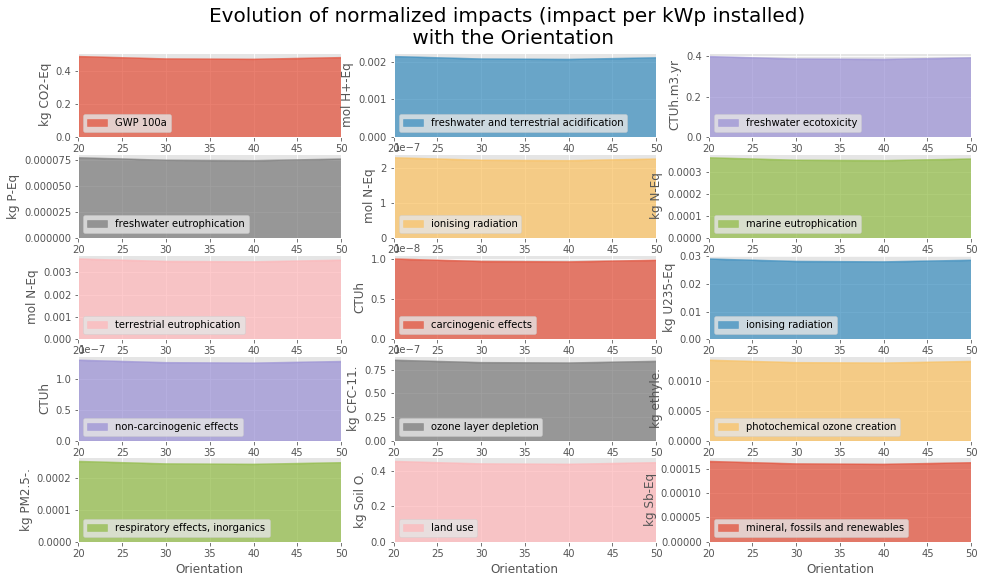

In [342]:
fig, ax = plt.subplots(5,3, figsize = (16,9))
df_impact.plot(ax = ax, subplots= True, kind = 'area', alpha = 0.7)
for i,axi in enumerate(ax):
    for j, axj in enumerate(axi):
        axj.set_ylabel(ILCD_methods_unit[i*len(axi)+j])
plt.suptitle('Evolution of normalized impacts (impact per kWp installed) \n with the %s'%df_impact.index.name, y = 0.95, fontsize = 20)
#plt.tight_layout()

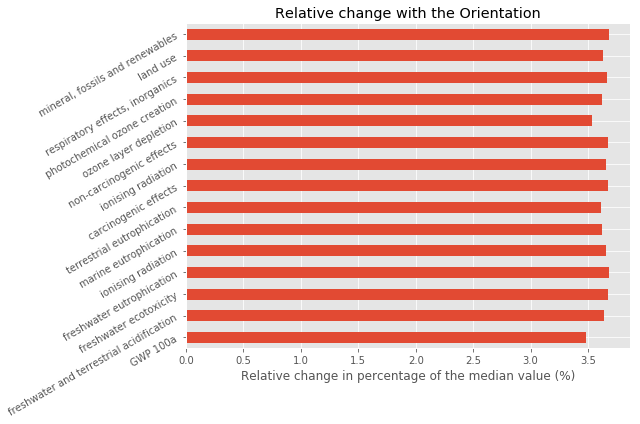

In [343]:
df = (df_impact.max() - df_impact.min())/df_impact.median() * 100
fig, ax = plt.subplots(figsize = (9, 6))
plt.title('Relative change with the %s'%df_impact.index.name)
df.plot(kind = 'barh', rot = 30)
ax.set_xlabel('Relative change in percentage of the median value (%)')
plt.tight_layout()

df_RC[df_impact.index.name] = df

In [386]:
df_RC.to_pickle('FINAL_PV_IMPACT/SA_relative_change.pkl')

### Final Full OAT Graph

In [435]:
df_RC = pd.read_pickle('FINAL_PV_IMPACT/SA_relative_change.pkl')
df_RC

System power  Panel efficiency  \
GWP 100a                                      5.464250         84.970664   
freshwater and terrestrial acidification     26.593098         73.353248   
freshwater ecotoxicity                       21.579768         72.672082   
freshwater eutrophication                    69.357844         47.461445   
ionising radiation                            6.500344         85.801797   
marine eutrophication                        10.566320         82.978411   
terrestrial eutrophication                   13.106771         81.201619   
carcinogenic effects                          9.274399         81.830068   
ionising radiation                            6.712123         85.681498   
non-carcinogenic effects                     33.915773         69.199051   
ozone layer depletion                         2.927222         87.017651   
photochemical ozone creation                 11.269384         82.298273   
respiratory effects, inorganics              16.658505         79.547964   
land use                                     12.102963         82.082614   
mineral, fossils and renewables              22.153280         74.927958   

                                          Roof / Ground  \
GWP 100a                                       7.867750   
freshwater and terrestrial acidification      10.224813   
freshwater ecotoxicity                        16.622993   
freshwater eutrophication                      3.926924   
ionising radiation                             6.064902   
marine eutrophication                          8.892194   
terrestrial eutrophication                    14.582709   
carcinogenic effects                          31.467542   
ionising radiation                             6.228769   
non-carcinogenic effects                      16.912617   
ozone layer depletion                          3.606609   
photochemical ozone creation                   9.421746   
respiratory effects, inorganics               12.892788   
land use                                      99.242653   
mineral, fossils and renewables               41.776185   

                                          Recycled share of aluminum  \
GWP 100a                                                    4.504217   
freshwater and terrestrial acidification                    5.594976   
freshwater ecotoxicity                                      5.860330   
freshwater eutrophication                                   1.497745   
ionising radiation                                          1.861712   
marine eutrophication                                       4.668235   
terrestrial eutrophication                                  5.184914   
carcinogenic effects                                        9.369492   
ionising radiation                                          1.949057   
non-carcinogenic effects                                    8.186194   
ozone layer depletion                                       1.120138   
photochemical ozone creation                                4.046114   
respiratory effects, inorganics                             6.900500   
land use                                                    4.162234   
mineral, fossils and renewables                            32.836921   

                                          Electricity mix  \
GWP 100a                                        29.521996   
freshwater and terrestrial acidification        40.558464   
freshwater ecotoxicity                           6.257372   
freshwater eutrophication                       13.885641   
ionising radiation                             105.295139   
marine eutrophication                           37.696755   
terrestrial eutrophication                      38.299758   
carcinogenic effects                             8.519142   
ionising radiation                             105.009189   
non-carcinogenic effects                         8.835705   
ozone layer depletion                           19.55285

In [436]:
len(df_RC.T) #30 parameters

30

In [388]:
import seaborn as sns

In [ ]:
#We drop the panel efficiency 2 because it can be calculate by 2 methods:
#either by modifying the module_efficiency or by modifying the P_module
df_RC.drop('Panel efficieny 2',axis=1, inplace=True)

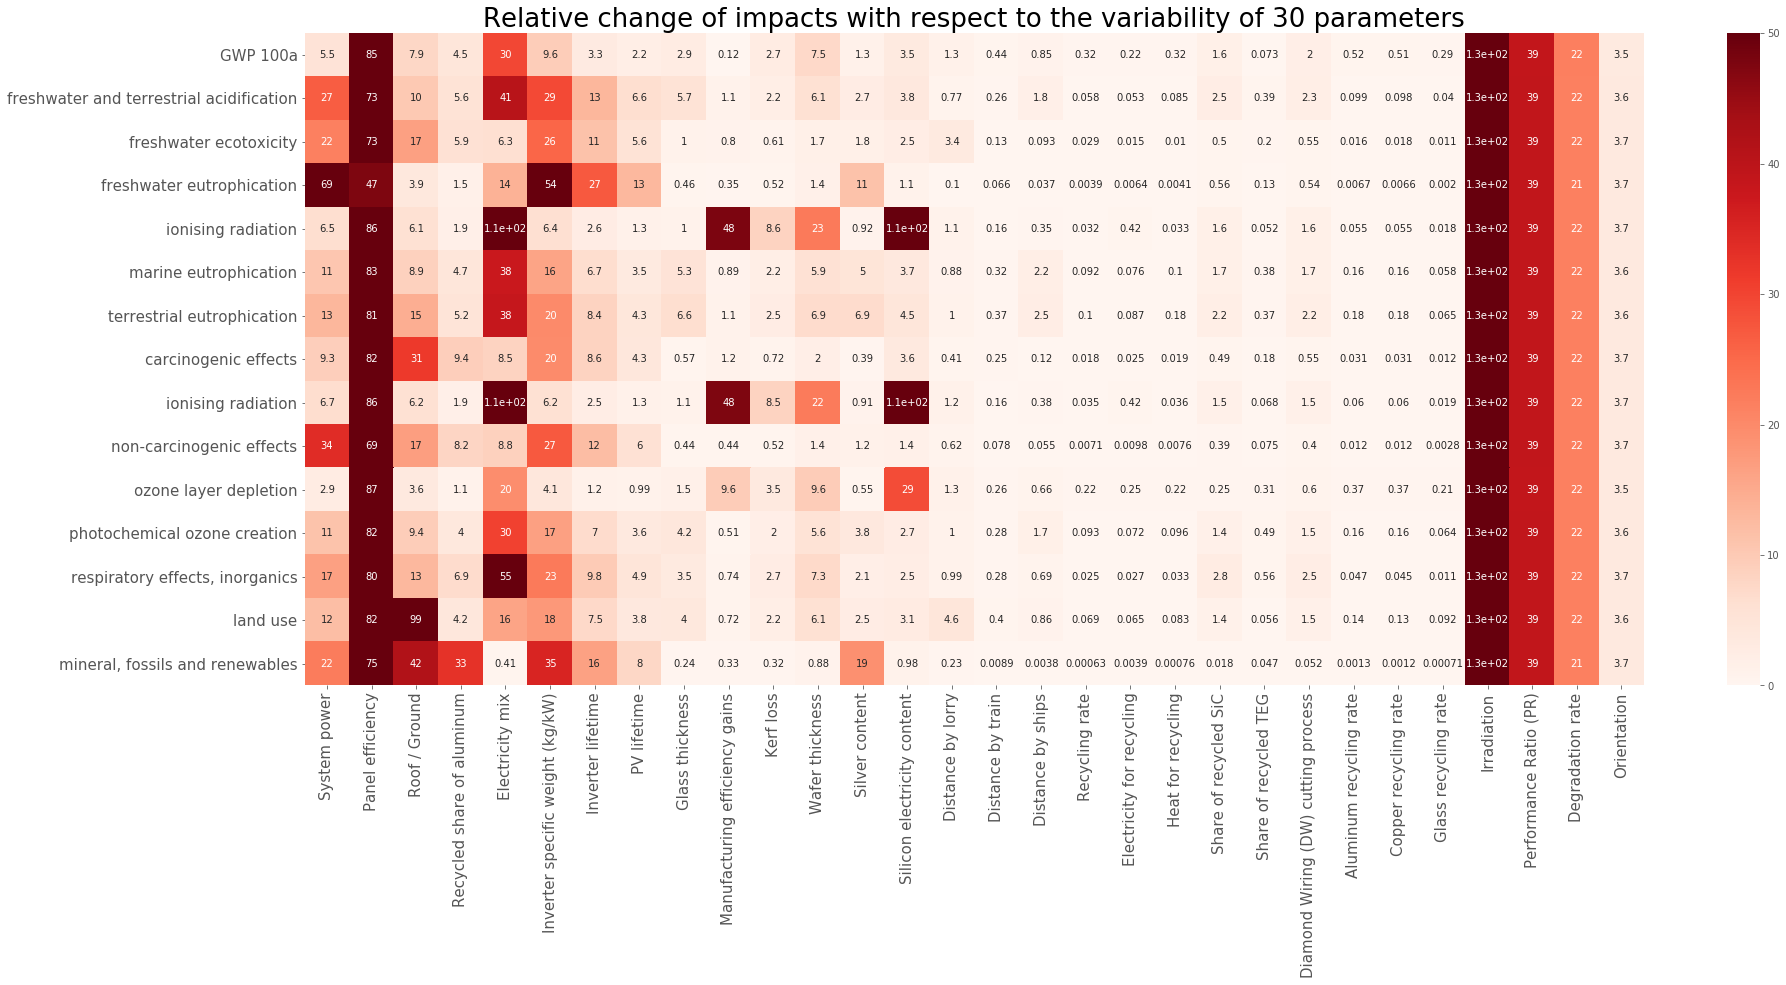

In [470]:
fig, ax = plt.subplots(figsize = (30, 12))
sns.heatmap(df_RC, cmap= "Reds", vmax=50, annot= True,)
plt.title('Relative change of impacts with respect to the variability of 30 parameters',
          fontsize = 26)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)

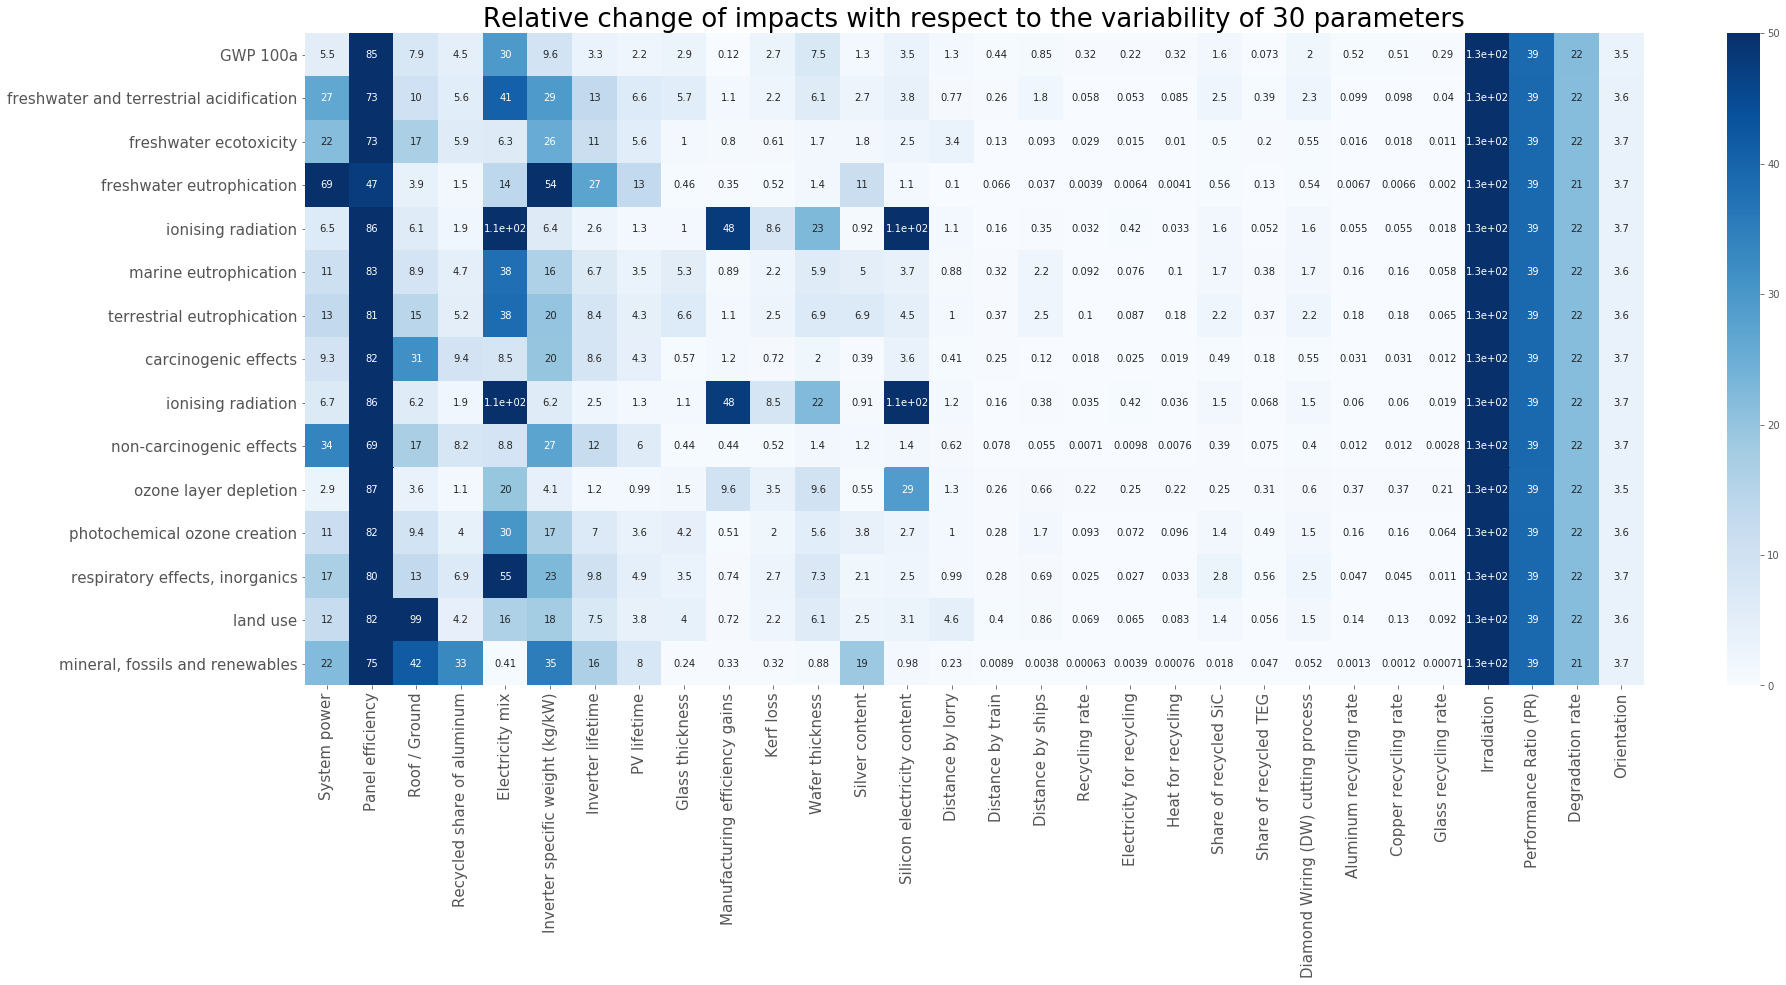

In [471]:
fig, ax = plt.subplots(figsize = (30, 12))
sns.heatmap(df_RC, cmap= "Blues", vmax=50, annot= True,)
plt.title('Relative change of impacts with respect to the variability of 30 parameters',
          fontsize = 26)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)

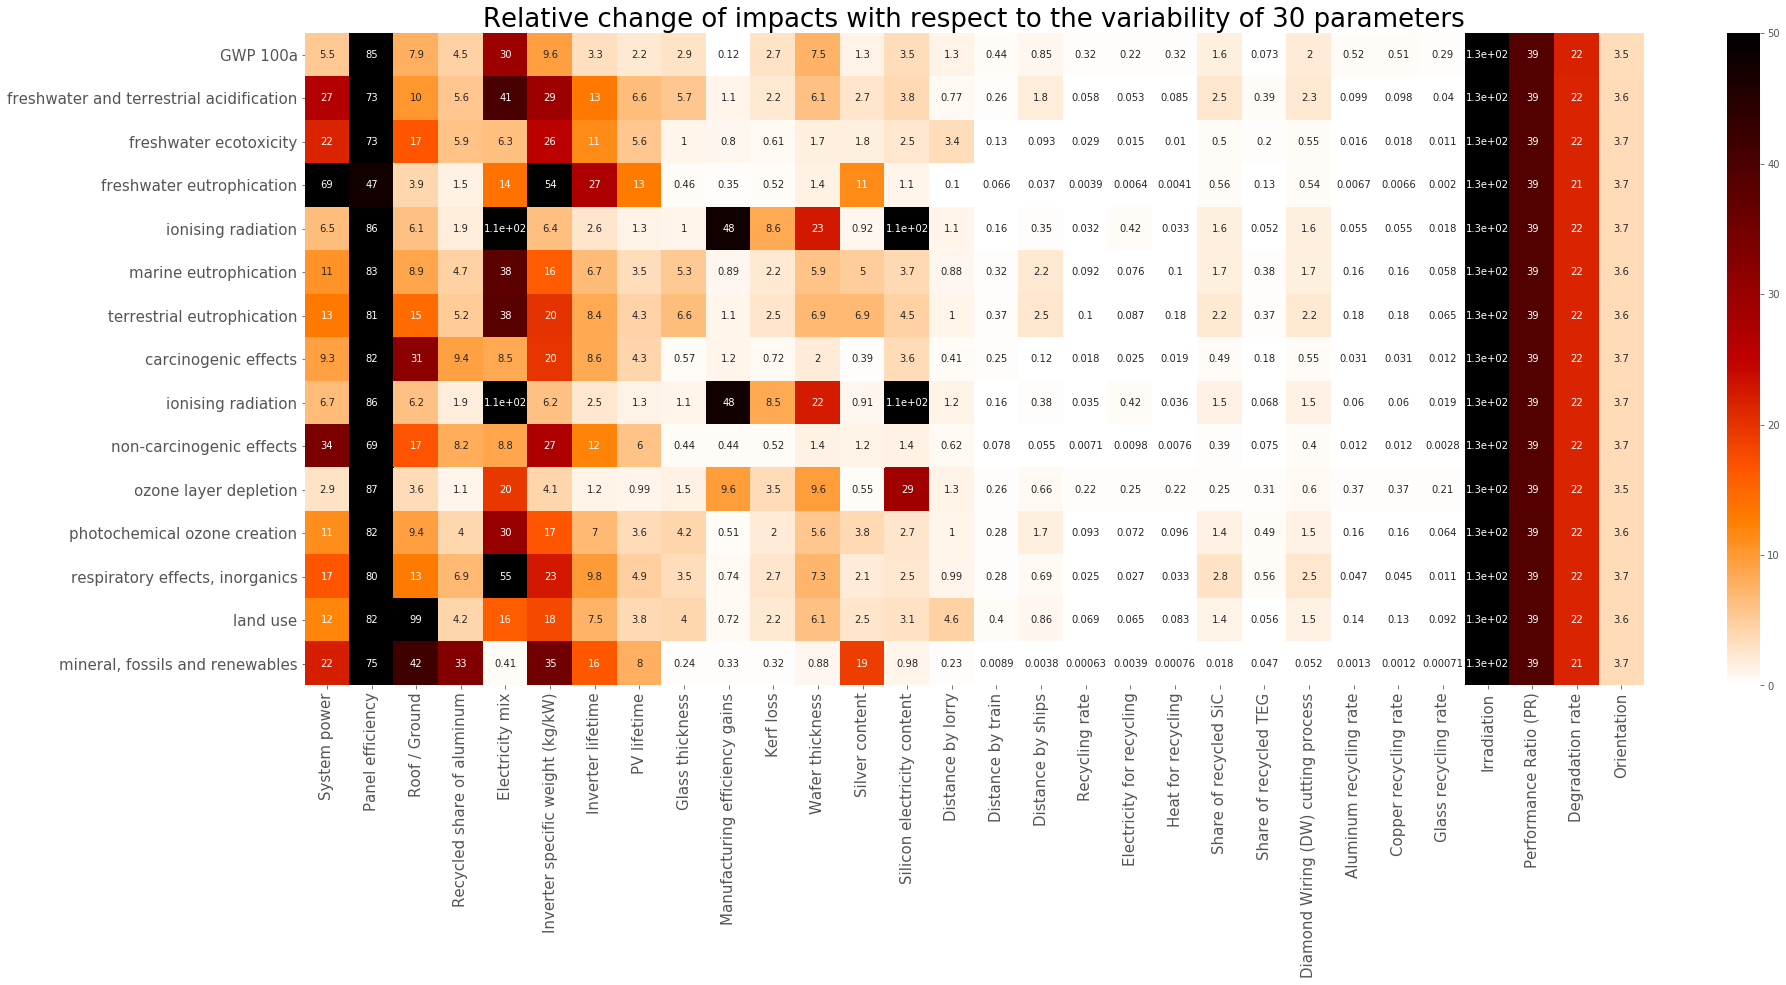

In [472]:
fig, ax = plt.subplots(figsize = (30, 12))
sns.heatmap(df_RC, cmap= "gist_heat_r", vmax=50, annot= True,)
plt.title('Relative change of impacts with respect to the variability of 30 parameters',
          fontsize = 26)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)

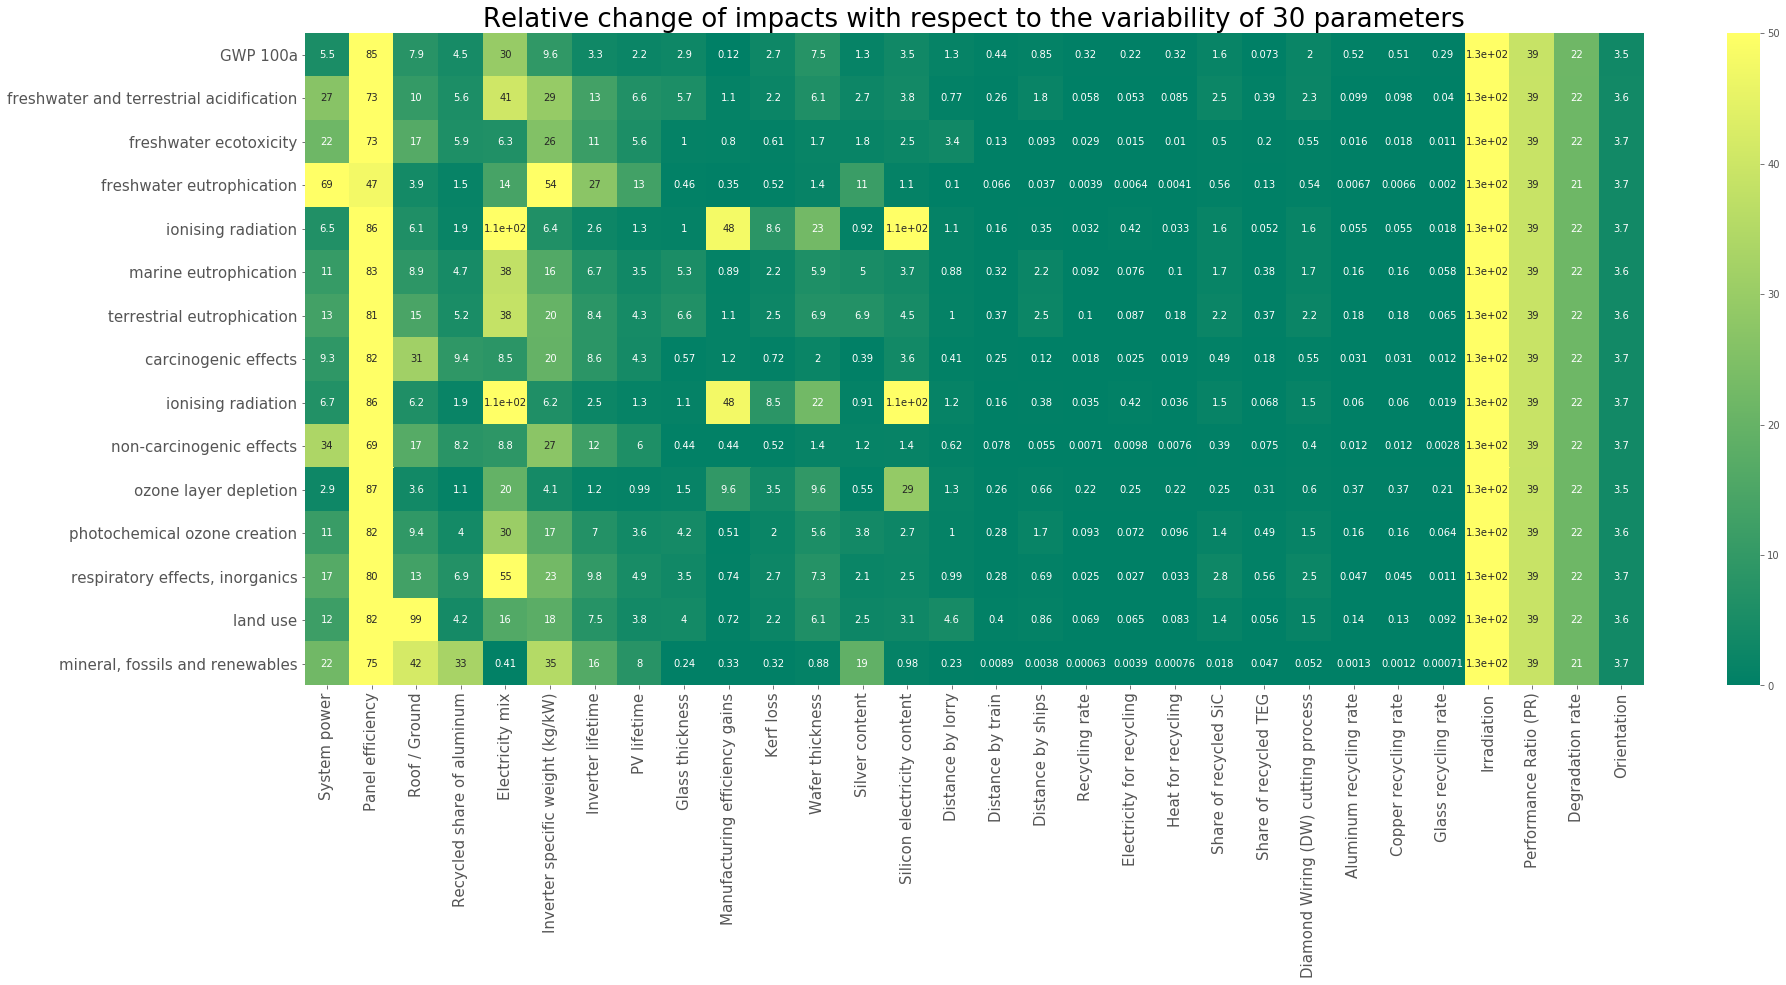

In [473]:
fig, ax = plt.subplots(figsize = (30, 12))
sns.heatmap(df_RC, cmap= "summer", vmax=50, annot= True,)
plt.title('Relative change of impacts with respect to the variability of 30 parameters',
          fontsize = 26)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)